In [1]:
pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [2]:
import json
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import torch
from sklearn.model_selection import train_test_split
import random
import gc
import transformers
from tqdm import tqdm, trange
from typing import Callable, Dict, List, Tuple
from timeit import default_timer as timer
from transformers import EncoderDecoderModel, AutoTokenizer, PreTrainedTokenizer, BatchEncoding, AutoModel
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, WeightedRandomSampler
import os
import json


2025-09-03 14:21:10.548844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756909270.718467      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756909270.767246      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

MODEL_PATH = "/kaggle/input/llama-3.2/transformers/3b-instruct/1"
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, trust_remote_code=True)
# tokenizer.padding_side = "right"
# tokenizer.pad_token = tokenizer.eos_token
# tokenizer.add_eos_token = True

print(tokenizer.bos_token, tokenizer.eos_token)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=torch.float16, # Use float16 for memory efficiency on GPUs
    device_map="auto" # Automatically maps model to available devices (like GPU)
)

# Set pad_token_id to eos_token_id for open-end generation
tokenizer.pad_token_id = tokenizer.eos_token_id

# Create a text-generation pipeline
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    device_map="auto"
)

<|begin_of_text|> <|eot_id|>


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [4]:
# Fix the random state for reproducibility
def fix_seed(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.

    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

[ ]

SEED = 777
fix_seed(SEED)


In [5]:
import pandas as pd 

def uniform(el):

    """
    Handles the values for multi-value attributes, splitting to list if necessary
    If the input is a list or transformed to a list, values are sorted
    Args:
        el (str or list): The attribute value
    Returns:
        str or list: The attribute value sorted if it is a list, the attribute value otherwise
    """
    if el == el:  # NaN is different from NaN, np.isnan and pd.isna don't work
        if '|' in el:
            el = sorted(el.split('|'))
        elif isinstance(el, list):
            el = sorted(el)
    return el

DATAFRAMES_PATH = '/kaggle/input/nlp-pw' if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') else './Dataframes'

def create_df_annotations(path: str, language: str, dataset: str):

    """
    Load the dataset + create and save to file a dataframe with the annotations of the arguments.

    Args:
        path (str): path of the folder containing the JSON files
        dataset (str): One of [vat, tp, ecj]
    """
    
    pkl_file_path = f"{DATAFRAMES_PATH}/arg_annotations_{language}_{dataset}.pkl.xz"
    if os.path.isfile(pkl_file_path):
        print(f"Found pkl, loading it - {pkl_file_path}")
        return pd.read_pickle(pkl_file_path)
    print(f"Could not find pkl, reading dataset - {pkl_file_path}")
    temp = []
    files = os.listdir(path)
    files.sort()

    for filename in files:
        if not filename.endswith('.json'):
            print(f"Skipping '{filename}'")
        else:
            print(f"Loading '{filename}'")
            with open(os.path.join(path, filename), 'r', encoding='utf8') as f:
                data = json.load(f)
                annotations = data["annotations"]
                last_full_chain_id = None
                last_text = None
                
                for annotation in annotations:
                    if annotation["name"] != 'conc' and annotation["name"] != 'prem':
                        continue # Ignore intro, nreg, judoff, ...

                    #document = annotation["document"]
                    document = data["document"]["name"]
                    name = annotation["name"]
                    _id = annotation["_id"]
                    argument_chain_id = _id[0]
                    full_chain_id = f'{document}_{argument_chain_id}'
                    last_full_chain_id = full_chain_id
                    incremental_num = _id[1:]
                    text = data["document"]["plainText"][int(annotation["start"]):int(annotation["end"])]
                    last_text = text

                    # attribute extraction, NaN if that attribute is not present
                    T = uniform(annotation["attributes"].get("T", np.nan))
                    SUP = uniform(annotation["attributes"].get("SUP", np.nan))
                    SFF = uniform(annotation["attributes"].get("SFF", np.nan))
                    ATT = uniform(annotation["attributes"].get("ATT", np.nan))
                    INH = uniform(annotation["attributes"].get("INH", np.nan))
                    REPH = uniform(annotation["attributes"].get("REPH", np.nan))
                    S = uniform(annotation["attributes"].get("S", np.nan))
                    text = text.replace('\n','').lstrip('‘’\'\n0123456789.-–…;;) ').rstrip('‘’\'\n.;; ')
                    previous = last_text if last_full_chain_id == full_chain_id else None
                    temp.append([
                        document, name, _id, argument_chain_id, incremental_num, text, T, SUP, SFF, ATT, INH, REPH, S, full_chain_id, previous,
                    ])

    # df creation
    df = pd.DataFrame(temp, columns=[
            'Document', 'Name', 'Id', 'Chain', 'Num', 'Text', 'Type', 'SUP', 'SFF', 'ATT', 'INH', 'REPH', 'Scheme', 'FullChainID', 'Previous'
        ])
    print(f"Saving {len(df)} annotations to {pkl_file_path}")
    df.to_pickle(pkl_file_path)
    df.to_csv(pkl_file_path.replace('.pkl.xz', '.csv'))
    return df

df = create_df_annotations('Data/Dataset/VAT_ITA', 'italian', 'vat')


Found pkl, loading it - /kaggle/input/nlp-pw/arg_annotations_italian_vat.pkl.xz


In [6]:
drop_ind=df[df['Text']==''].index
len(drop_ind)
#remove from dataset rows with no text feature
df.drop(drop_ind,inplace=True)
drop_ind

Index([227, 480, 484, 493, 544, 624, 649, 1653, 1700, 1747, 1749, 1786], dtype='int64')

In [7]:
df_ac = df[~(df['Name'].isnull())].reset_index(drop=True)
df_ac['Name'].unique()
df_tc = df_ac[~(df_ac['Type'].isnull())].reset_index(drop=True)
df_tc.describe()
df_tc['Type'].drop_duplicates()
df_sc = df_tc[~(df_tc['Scheme'].isnull())].reset_index(drop=True)
#print(df_sc.describe())
df_sc['Scheme'].drop_duplicates()

0                      Rule
1                      Itpr
4                      Prec
15             [Itpr, Prec]
21                      Aut
               ...         
1220    [Class, Itpr, Rule]
1237           [Acon, Itpr]
1238          [Class, Tele]
1273     [Prec, Rule, Syst]
1279     [Aut, Itpr, Princ]
Name: Scheme, Length: 63, dtype: object

In [8]:
#need to extract the values from the list, so convert to string, in order to pass them to the multilabelbinarizer

def clean_list(df_sc, column_name):
    for i in range(len(df_sc)):
        x = df_sc.loc[i,column_name]
        if type(x) == list:
            df_sc.loc[i,str(column_name) + "2"] = ",".join(x)
        else:
            try:
                df_sc.loc[i,str(column_name) + "2"] = x
            except:
                print(i,x)
    return df_sc
df_sc = clean_list(df_sc,'Scheme')
df_sc

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous,Scheme2
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",Rule
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...,Itpr
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,NaN,NaN,Rule,2018_847_VAT_OP_2_-1_MB_AF_AN_A,Secondo condivisa e costante giurisprudenza (C...,Rule
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,NaN,NaN,Itpr,2018_847_VAT_OP_2_-1_MB_AF_AN_A,"Tuttavia, nel caso qui in esame, la Comm/ne no...",Itpr
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,NaN,NaN,Prec,2018_847_VAT_OP_2_-1_MB_AF_AN_A,A tal proposito si ricorda che la Corte cost. ...,Prec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Sotto questo profilo i Compro Oro sono sottopo...,Rule
1307,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tale comunicazione ha luogo quando i destinata...,Rule
1308,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,"Il Ministro dell'interno, con decreto del 17 f...",Rule
1309,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,"[Class, Rule]",2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...,"Class,Rule"


In [9]:
a = df_sc.explode(['Scheme'])
sc_label_count = a['Scheme'].value_counts()
remove_c = sc_label_count[sc_label_count < 15]
list(remove_c.index)


['Lit', 'Abs', 'Psy', 'Acon']

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform([str(df_sc.loc[i,'Scheme2']).split(',') for i in range(len(df_sc))])
df_sc_final1 = pd.concat([df_sc,pd.DataFrame(mlb_result,columns=list(mlb.classes_))],axis=1)
df_sc_final1

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,...,Aut,Class,Itpr,Lit,Prec,Princ,Psy,Rule,Syst,Tele
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1307,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1308,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1309,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,...,0,1,0,0,0,0,0,1,0,0


In [11]:
sc_classes = mlb.classes_
df_sc_labels = df_sc_final1[mlb.classes_]
sc_label_count = df_sc_labels.sum().sort_values(ascending=False)
df_sc_labels
sc_classes

array(['Abs', 'Acon', 'Aut', 'Class', 'Itpr', 'Lit', 'Prec', 'Princ',
       'Psy', 'Rule', 'Syst', 'Tele'], dtype=object)

<BarContainer object of 12 artists>

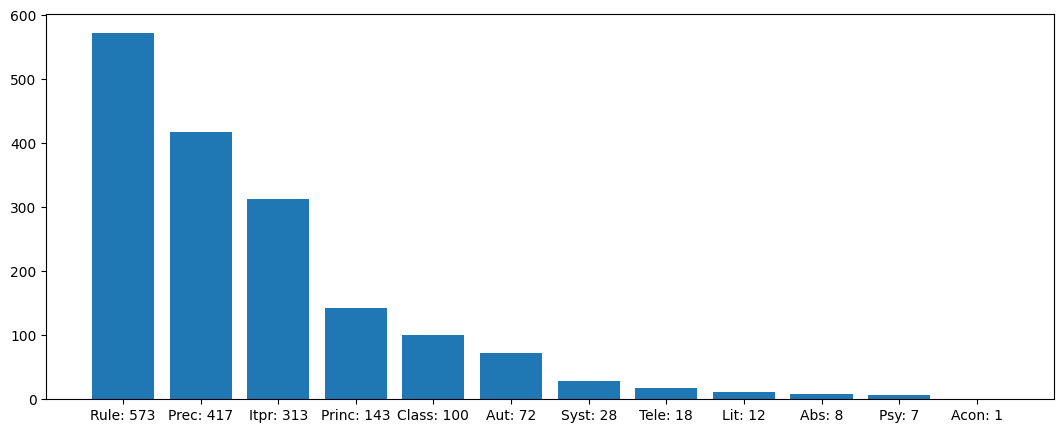

In [12]:
y = np.array(sc_label_count)
#x = np.array(sc_label_count.index)
#added values on x only for convenience
x = [sc_label_count.index[i] + ': ' + str(sc_label_count.iloc[i]) for i in range(len(sc_label_count))]
plt.figure(figsize=(13,5))
plt.bar(x, height=y)

In [13]:
bad_sc_classes = sc_label_count.index[sc_label_count < 15]
sc_classes = sc_label_count.index[sc_label_count >= 15]
print("Removing classes with low number of instances: "+', '.join(bad_sc_classes))
print("Keeping classes with good number of instances: "+', '.join(sc_classes))
good_sc_columns = np.setdiff1d(sc_classes, bad_sc_classes)
print("Remaining columns: "+', '.join(good_sc_columns))
#df_sc_final = df_sc_final1[~df_sc_final1["Scheme2"].isin(bad_sc_classes)].drop(bad_sc_classes,axis=1).reset_index(drop=True)
df_sc_final1

Removing classes with low number of instances: Lit, Abs, Psy, Acon
Keeping classes with good number of instances: Rule, Prec, Itpr, Princ, Class, Aut, Syst, Tele
Remaining columns: Aut, Class, Itpr, Prec, Princ, Rule, Syst, Tele


,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,...,Aut,Class,Itpr,Lit,Prec,Princ,Psy,Rule,Syst,Tele
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1307,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1308,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1309,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,...,0,1,0,0,0,0,0,1,0,0


In [14]:
#df_sc_final['Scheme'].isin(['Acon'])
#updated version, now we are also considering the list type elements
def remove_bad_classes(df_sc,bad_sc_classes):
    df = df_sc
    for i in range(len(df_sc)):
        x = df.loc[i,'Scheme']
        if type(x) == list:
            for q in x:
                if q in bad_sc_classes:
                    #print(x, q)
                    df = df.drop([i])
                    break
        elif x in bad_sc_classes:
            df = df.drop([i])
    df = df.drop(bad_sc_classes,axis=1).reset_index(drop=True)
    return df
df_r = remove_bad_classes(df_sc_final1,bad_sc_classes)
df_sc_final = df_r
df_sc_final.columns

Index(['Document', 'Name', 'Id', 'Chain', 'Num', 'Text', 'Type', 'SUP', 'SFF',
       'ATT', 'INH', 'REPH', 'Scheme', 'FullChainID', 'Previous', 'Scheme2',
       'Aut', 'Class', 'Itpr', 'Prec', 'Princ', 'Rule', 'Syst', 'Tele'],
      dtype='object')

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform([str(df_sc.loc[i,'Scheme2']).split(',') for i in range(len(df_sc))])
df_sc_final1 = pd.concat([df_sc,pd.DataFrame(mlb_result,columns=list(mlb.classes_))],axis=1)
df_sc_final1

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,...,Aut,Class,Itpr,Lit,Prec,Princ,Psy,Rule,Syst,Tele
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1307,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1308,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1309,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,...,0,1,0,0,0,0,0,1,0,0


In [16]:
tr = df_sc_final.explode('Scheme')
#df_sc_final[df_sc_final['Scheme'].explode().isin(['Acon'])]
tr.drop(good_sc_columns,axis=1)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous,Scheme2
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",Rule
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...,Itpr
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,NaN,NaN,Rule,2018_847_VAT_OP_2_-1_MB_AF_AN_A,Secondo condivisa e costante giurisprudenza (C...,Rule
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,NaN,NaN,Itpr,2018_847_VAT_OP_2_-1_MB_AF_AN_A,"Tuttavia, nel caso qui in esame, la Comm/ne no...",Itpr
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,NaN,NaN,Prec,2018_847_VAT_OP_2_-1_MB_AF_AN_A,A tal proposito si ricorda che la Corte cost. ...,Prec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tale comunicazione ha luogo quando i destinata...,Rule
1281,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,"Il Ministro dell'interno, con decreto del 17 f...",Rule
1282,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,Class,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...,"Class,Rule"
1282,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...,"Class,Rule"


In [17]:
df_sc_labels = df_sc_final[good_sc_columns]
df_sc_labels

,Aut,Class,Itpr,Prec,Princ,Rule,Syst,Tele
0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
1279,0,0,0,0,0,1,0,0
1280,0,0,0,0,0,1,0,0
1281,0,0,0,0,0,1,0,0
1282,0,1,0,0,0,1,0,0


In [18]:
def split_on_idx(docs_idx,df, test_size=0.20):
    total_samples = df.shape[0]
    idx_train, idx_test = train_test_split(docs_idx,
                                      random_state=SEED,
                                      test_size=test_size)
    idx_train, idx_val = train_test_split(idx_train,
                                      random_state=SEED,
                                      test_size=0.10)
    df_train = df[df['Document'].isin(idx_train)]
    df_val = df[df['Document'].isin(idx_val)]
    df_test = df[df['Document'].isin(idx_test)]
    print('Number of training samples: {} ({}%)'.format(df_train.shape[0], 100*df_train.shape[0]/total_samples))
    print('Number of validation examples: {} ({}%)'.format(df_val.shape[0], 100*df_val.shape[0]/total_samples))
    print('Number of test samples: {} ({}%)'.format(df_test.shape[0], 100*df_test.shape[0]/total_samples))
    return df_train, df_val, df_test

In [19]:
def label_distribution_across_splits(train_df, val_df, test_df, labels):
    distrib = {}
    for label in labels:
        tot = train_df[label].sum() + val_df[label].sum() + test_df[label].sum()
        if tot == 0:
            distrib[label] = {'train': 0, 'val': 0, 'test': 0}
        else:
            distrib[label] = {
                'train': 100 * train_df[label].sum() / tot,
                'val': 100 * val_df[label].sum() / tot,
                'test': 100 * test_df[label].sum() / tot,
            }
    return distrib

In [20]:
labels  = list(df_sc_labels.columns)
def split_dataset_sc(df_sc, show_label_distr = False):
    docs_full  = list(df_sc.Document.unique())
    agg = df_sc.groupby('Document')[labels].sum()
    doc_tele_idx = list(agg.loc[agg.Tele >=1].index)
    doc_syst_idx = list(agg.loc[(agg.Syst >=1) & (agg.Tele <1)].index)
    doc_aut_idx  =  list(agg.loc[(agg.Aut >=1) & (agg.Tele <1) & (agg.Syst<1)].index)
    rare_docs = doc_tele_idx + doc_syst_idx + doc_aut_idx
    first_split_docs_idx =  [d for d in docs_full if d not in rare_docs]
    tr1,val1,test1 = split_on_idx(first_split_docs_idx,df_sc)
    tr2,val2,test2 = split_on_idx(doc_aut_idx,df_sc)
    tr3,val3,test3 = split_on_idx(doc_syst_idx,df_sc)
    tr4,val4,test4 = split_on_idx(doc_tele_idx,df_sc)

    train_df = pd.concat([tr1, tr2, tr3,tr4], axis=0, ignore_index=True)
    val_df = pd.concat([val1, val2, val3, val4], axis=0, ignore_index=True)
    test_df = pd.concat([test1, test2, test3,test4], axis=0, ignore_index=True)

    if show_label_distr:
        distrib = label_distribution_across_splits(train_df, val_df, test_df, labels)

        for label, perc in distrib.items():
            print(f"Distribuzione label '{label}':")
            print(f"  Train: {perc['train']:.2f}%")
            print(f"  Val:   {perc['val']:.2f}%")
            print(f"  Test:  {perc['test']:.2f}%\n")
            
    return train_df,val_df,test_df
 

In [21]:
#df_train,df_val,df_test = iterative_split(df_sc_final,df_sc_labels)
df_train,df_val,df_test = split_dataset_sc(df_sc_final)


Number of training samples: 521 (40.57632398753894%)
Number of validation examples: 46 (3.5825545171339566%)
Number of test samples: 136 (10.59190031152648%)
Number of training samples: 210 (16.35514018691589%)
Number of validation examples: 19 (1.4797507788161994%)
Number of test samples: 52 (4.049844236760125%)
Number of training samples: 82 (6.386292834890965%)
Number of validation examples: 9 (0.7009345794392523%)
Number of test samples: 39 (3.0373831775700935%)
Number of training samples: 126 (9.813084112149532%)
Number of validation examples: 20 (1.557632398753894%)
Number of test samples: 24 (1.8691588785046729%)


In [22]:
df_to_aug = df_train
df_to_aug

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,...,Previous,Scheme2,Aut,Class,Itpr,Prec,Princ,Rule,Syst,Tele
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,...,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",Rule,0,0,0,0,0,1,0,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,...,Se il ricorso non è stato\n proposto da o ...,Itpr,0,0,1,0,0,0,0,0
2,2013_136_VAT_OPAM_1_0_PS_AN,prem,A1,A,1,l'odierna ricorrente che svolge attività di co...,"[F, L]",NaN,NaN,NaN,...,l'odierna ricorrente che svolge attività di co...,Class,0,1,0,0,0,0,0,0
3,2013_136_VAT_OPAM_1_0_PS_AN,prem,A3,A,3,"conduit company, vale a dire il fornitore che ...",L,NaN,NaN,NaN,...,"1) conduit company, vale a dire il fornitore c...",Class,0,1,0,0,0,0,0,0
4,2013_136_VAT_OPAM_1_0_PS_AN,prem,A4,A,4,"missing trade, vale a dire il prestanome, l'op...",L,NaN,NaN,NaN,...,"2) missing trade, vale a dire il prestanome, l...",Class,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,2021_5795_VAT_OPAM_2_1_PS_AN,prem,D7,D,7,In giurisprudenza si è affermato che in tema d...,L,NaN,NaN,NaN,...,In giurisprudenza si è affermato che in tema d...,Prec,0,0,0,1,0,0,0,0
935,2021_5795_VAT_OPAM_2_1_PS_AN,prem,E2,E,2,posto che quanto alla motivazione delle sanzio...,L,NaN,NaN,NaN,...,posto che quanto alla motivazione delle sanzio...,Prec,0,0,0,1,0,0,0,0
936,2021_5795_VAT_OPAM_2_1_PS_AN,prem,F3,F,3,"Va rilevato che a norma dell'articolo 52, quin...",L,NaN,NaN,NaN,...,"Va rilevato che a norma dell'articolo 52, quin...","Princ,Rule",0,0,0,0,1,1,0,0
937,2021_5795_VAT_OPAM_2_1_PS_AN,prem,F4,F,4,pertanto non integrano i presupposti applicati...,L,F3,NaN,NaN,...,pertanto non integrano i presupposti applicati...,Prec,0,0,0,1,0,0,0,0


In [23]:
def generate_sample(input):
        
    system_message = "Sei un assistente che prende in input del testo estratto da documenti legali VAT ITA, e l'obbiettivo è di generare un nuovo testo simile dal punto di vista semantico all'originale ma con struttura diversa. Non sono domande. Tono formale e legale. Questo è un task di data augmentation. In output solo la frase contestualmente simile all'input, non aggiungere altre frasi prima oppure dopo come \"ecco  la frase\" oppure altro. Evita di aggiungere doppi spazi e cerca di creare frasi corrette grammiticalmente"
    system_message =  """
Sei un assistente specializzato in testi legali italiani.
Prendi la frase in input e riscrivila in modo semanticamente equivalente 
ma con una formulazione diversa. 

Regole:
- Mantieni un tono formale e legale.
- Non inventare nuovi concetti.
- Non semplificare troppo il linguaggio.
- Non aggiungere spiegazioni o commenti,
- Non inserire prefissi o suffissi (es. "Ecco la frase:")
- Non produrre frasi sconnesse: l'output deve sembrare estratto da un documento ufficiale."""
    user_message = input
    
    prompt = f"""<|start_header_id|>system<|end_header_id|>
    {system_message}<|eot_id|>
    <|start_header_id|>user<|end_header_id|>
    {user_message}<|eot_id|>
    <|start_header_id|>assistant<|end_header_id|>
    """
    
    sequences = generator(
        prompt,
        do_sample=True,
        top_k=30,
        top_p=0.9,
        num_return_sequences=1,
        repetition_penalty=1.1,
        temperature = 0.3,
        eos_token_id=tokenizer.eos_token_id,
        max_length=500, # Adjust max_length as needed
    )
    
    generated_text = sequences[0]['generated_text']
    # Extract only the assistant's response
    assistant_response = generated_text[len(prompt):].strip()
    print("Response:", assistant_response)
    return [assistant_response]


In [24]:
GENERATION = True
if GENERATION:
    new_text = []
    new_target = []

    #start with the class having the smallest suppport
    class_to_aug = ['Tele','Syst','Aut','Class','Princ']
    
    #n_samples = [1,2,3,5,6]
    n_samples = [6,5,4,3,1]
    visited = [] #avoid augmenting same sentence belonging to two or more classes 
    
    for ca,n in zip(class_to_aug,n_samples):

        new_df = df_to_aug[df_to_aug[ca]== 1]
        print(ca)
        for i in new_df.index:
            if i in visited:
                continue
            x = df_to_aug.loc[i]
            text = x.Text
            print(f"TEXT: {text}")

            for _ in range(0,n):
                s = generate_sample(text)
                new_text = new_text + s
            values  = list(x[labels].values)
            new_target = new_target + [values]*n
            visited.append(i)
        print(len(new_text))
        #print(new_target)
    new_df = pd.DataFrame(new_target,columns = labels)
    new_df.insert(0,'Text',new_text)
    new_df.to_csv(f'llm_aug_data_{SEED}.csv')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Tele
TEXT: La ratio dell'esenzione di cui al numero 15 del citato Decreto ('prestazioni        di trasporto di malati o feriti con veicoli all'uopo equipaggiati, effettuate da imprese autorizzate e da        ONLUS') è del tutto evidente, al pari di quella prevista per le prestazioni di cui al numero 18 ('le        prestazioni sanitarie di diagnosi, cura e riabilitazione rese alla persona nell'esercizio delle        professioni e arti sanitarie soggette a vigilanza, ai sensi dell'articolo 99 del testo unico delle leggi        sanitarie, approvato con regio decreto 27 luglio 1934, n. 1265, e successive modificazioni, ovvero        individuate con decreto del Ministro della sanità, di concerto con il Ministro delle finanze'), al        numero 20 ('le cessioni di organi, sangue e latte umani e di plasma sanguigno') e al numero 27 ter        ('le prestazioni socio-sanitarie, di assistenza domiciliare o ambulatoriale, in comunità e simili, in        favore degli anziani ed inabili adulti, di

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: in gravidanza, di        famiglie monoparentali, di famiglie con figli minorenni, di persone con disabilità intellettiva, di        persone con disabilità fisica, di donne affette da violenze sessuali, di donne vittime di violenze domestiche,        di donne che hanno subito abuso sessuale su minore'). 

La ratio dell'esenzione è dunque del tutto evidente nel senso che non si tratta di un semplice calcolo matematico ma piuttosto di un'analisi complessa delle esigenze sociali ed economiche della popolazione italiana. 

In questo contesto, la ratio dell'esenzione può essere considerata come un meccanismo di equilibrio tra le diverse esigenze della società, in cui ogni singola categoria di persone che richiede servizi sanitari viene tenuta conto e rispettata. 

Tuttavia, la ratio dell'esenzione può anche essere vista come un meccanismo di discriminazione, in quanto alcune categorie di persone sono escluse dal calcolo matematico, mentre altre sono incluse. 

In questo senso


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: in gravidanza, di        famiglie con figli piccoli'). 

La ratio dell'esenzione è dunque del tutto evidente, poiché le prestazioni di cui sopra sono tutte strettamente correlate alle esigenze di salute e di benessere della popolazione.

Riferimento: Decreto del Presidente del Consiglio dei Ministri, 28 giugno 2020, n. 77.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: vittime di violenze        sessuali'). 

La ratio dell'esenzione è dunque del tutto evidente nel caso di queste prestazioni, poiché si tratta di servizi essenziali per la salute e il benessere della popolazione.

Riferimento: Decreto Legislativo 28 giugno 2003, n. 196 - Codice in materia di protezione dei dati personali.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: vittime di violenze        sessuali'). 

La ratio dell'esenzione è dunque del tutto evidente nel caso di queste prestazioni.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: vittime di violenze        sessuali'). 

La ratio dell'esenzione è dunque del tutto evidente nel caso di prestazioni di trasporto di malati o feriti, ma non lo è nel caso di prestazioni di assistenza sociale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: vittime di violenza        domestica'). 

La ratio dell'esenzione è dunque del tutto evidente, poiché queste prestazioni sono caratterizzate da un alto livello di necessità e di vulnerabilità, che rendono impossibile per i contribuenti pagare tasse sulle stesse prestazioni.
TEXT: La ratio dell'esenzione di cui al numero 15 del citato Decreto ('prestazioni        di trasporto di malati o feriti con veicoli all'uopo equipaggiati, effettuate da imprese autorizzate e da        ONLUS') è del tutto evidente, al pari di quella prevista per le prestazioni di cui al numero 18 (“le        prestazioni sanitarie di diagnosi, cura e riabilitazione rese alla persona nell'esercizio delle        professioni e arti sanitarie soggette a vigilanza, ai sensi dell'articolo 99 del testo unico delle leggi        sanitarie, approvato con regio decreto 27 luglio 1934, n. 1265, e successive modificazioni, ovvero        individuate con decreto del Ministro della sanità, di concerto con il Ministro dell

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: vittime di violenze        sessuali'). 

La ratio dell'esenzione è dunque del tutto evidente nel senso che le prestazioni di cui sopra sono esenzate dal pagamento della tassa sulle prestazioni di trasporto.

La ratio dell'esenzione è divenuta più complessa nel corso degli anni, a causa delle modifiche apportate dal Decreto del 30 giugno 2003, n. 194, che ha introdotto la distinzione tra le prestazioni di trasporto di malati o feriti e quelle di trasporto di persone con disabilità motoria. 

La ratio dell'esenzione è stata ulteriormente modificata dal Decreto del 28 dicembre 2011, n. 214, che ha introdotto la possibilità di esenzione per le prestazioni di trasporto di persone con disabilità motoria, ma solo se queste ultime sono effettuate da imprese autorizzate e da enti pubblici. 

In sintesi, la ratio dell'esenzione è stata oggetto di numerose modifiche e interpretazioni nel corso degli anni, rendendo difficile la sua applicazione pratica


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: vittime di violenze        sessuali'). 

La ratio dell'esenzione è dunque del tutto evidente per le prestazioni di cui al numero 15 del Decreto, così come per quelle di cui al numero 18, 20 e 26 ter.

Riferimento: Decreto del Presidente del Consiglio dei Ministri, 28 giugno 2022, n. 76.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: vittime di violenza        domestica, di famiglie monoparentali, di famiglie con figli minorenni, di famiglie con figli minorenni        con disabilità, di famiglie con figli minorenni sottosviluppati'). 

La ratio dell'esenzione è dunque del tutto evidente, poiché tali prestazioni sono di natura esclusivamente sanitaria e non hanno alcun rapporto con le attività economiche. 

La ratio dell'esenzione è dunque del tutto evidente, poiché tali prestazioni sono di natura esclusivamente sanitaria e non hanno alcun rapporto con le attività economiche.

Rimuovi eventuali duplicati e riformula la frase in modo più sintetico e coerente.


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: vittime di violenze        sessuali'). 

La ratio dell'esenzione è dunque del tutto evidente, poiché si tratta di servizi essenziali, di fondamentale importanza sociale ed economica, che sono espressamente esonerati dal pagamento dell'Iva.

Riferimenti:
Decreto Ministeriale del 24 settembre 2021, n. 137, articolo 15, comma 2, lettere A) e B), articolo 18, comma 3, lettera C); Decreto Legislativo del 30 giugno 2003, n. 276, articolo 25, comma 1, lettera G); Decreto Legislativo del 13 dicembre 2019, n. 151, articolo 19, comma 1, lettera F).

Nota: i riferimenti sono stati inseriti solo per la tua informazione e non sono parte integrante della risposta finale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: vittime di violenze        sessuali'). 

La ratio dell'esenzione è dunque del tutto evidente, al pari di quelle previste per le prestazioni di cui al comma 2 del articolo 13 del Decreto, che prevede l'esenzione dalle imposte sul reddito delle persone fisiche e delle società per azioni per i contribuenti che svolgono attività di beneficenza o di assistenza sociale.

La ratio dell'esenzione è quindi del tutto evidente, al pari di quelle previste per le prestazioni di cui al comma 2 del articolo 13 del Decreto, che prevede l'esenzione dalle imposte sul reddito delle persone fisiche e delle società per azioni per i contribuenti che svolgono attività di beneficenza o di assistenza sociale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: vittime di violenza        di genere'). 

La ratio dell'esenzione è dunque del tutto evidente, al pari di quella prevista per le prestazioni di cui al numero 15 e 18.

Risposta corretta:
La ratio dell'esenzione prevista dal numero 15 del Decreto è del tutto evidente, al pari di quella prevista per le prestazioni di cui al numero 18.
TEXT: La ratio dell'esenzione di cui al numero 15 del citato Decreto ('prestazioni        di trasporto di malati o feriti con veicoli all'uopo equipaggiati, effettuate da imprese autorizzate e da        ONLUS') è del tutto evidente, al pari di quella prevista per le prestazioni di cui al numero 18 ('le prestazioni sanitarie di diagnosi, cura e riabilitazione rese alla persona nell'esercizio delle        | professioni e arti sanitarie soggette a vigilanza, ai sensi dell'articolo 99 del testo unico delle leggi sanitarie, approvato con regio decreto 27 luglio 1934, n. 1265, e successive modificazioni, ovvero individuate con decreto del Ministro della

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: di esseri umani'). 

La ratio dell'esenzione è dunque del tutto evidente nel caso di queste prestazioni, che sono tutte strettamente correlate alle esigenze di salute e di assistenza medica. 

In questo senso, si può affermare che la ratio dell'esenzione è del tutto evidente anche nel caso delle prestazioni di cui al numero 16 ('le prestazioni di trasporto di persone con handicap o disabilità, nonché le prestazioni di trasporto di persone con disturbi neurologici, psichiatrici o di senso, di cui al comma 1, lettera b) del articolo 3 del testo unico delle leggi sanitarie, approvato con regio decreto 27 luglio 1934, n. 1265, e successive modificazioni'). 

Tuttavia, nonostante ciò, la ratio dell'esenzione non è del tutto evidente nel caso delle prestazioni di cui al numero 16, poiché tali prestazioni non sono direttamente correlate alle esigenze di salute e di assistenza medica. 

Per quanto riguarda le prestazioni di trasporto di persone con


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: di esseri umani'). 

La ratio dell'esenzione è dunque del tutto evidente, poiché le prestazioni di cui sopra sono esenzionate dal pagamento del servizio di trasporto, nonostante la loro natura di prestazioni sanitarie. 

La ratio dell'esenzione è dunque del tutto evidente, poiché le prestazioni di cui sopra sono esenzionate dal pagamento del servizio di trasporto, nonostante la loro natura di prestazioni sanitarie.

Rimuovi eventuali duplicati e ripeti solo la prima parte della seconda frase.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: di esseri umani'). 

La ratio dell'esenzione è dunque del tutto evidente, al pari di quelle previste per le prestazioni di cui al numero 17 ('le prestazioni di supporto alle famiglie con figli piccoli, nonché alle famiglie con figli piccoli e disabili') e al numero 19 ('le prestazioni di assistenza sociale, di supporto alle famiglie e di prevenzione delle disuguaglianze sociali'). 

Tuttavia, la ratio dell'esenzione per le prestazioni di cui al numero 16 ('le prestazioni di trasporto di persone sane') è del tutto oscura e non chiara, e non risulta essere stata oggetto di alcuna interpretazione giuridica o di discussione tra gli esperti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: di esseri umani'). 

La ratio dell'esenzione è dunque del tutto evidente nel senso che le prestazioni di cui sopra sono già esenzionate dal pagamento della tassa sul valore aggiunto.

Le prestazioni di cui al numero 19 ('le prestazioni sanitarie di diagnosi, cura e riabilitazione rese alla persona nell'esercizio delle professioni e arti sanitarie soggette a vigilanza, ai sensi dell'articolo 99 del testo unico delle legge sanitarie, approvato con regio decreto 27 luglio 1934, n. 1265, e successive modificazioni, ovvero individuate con decreto del Ministro della sanità, di concordo con il Ministro delle finanze'). 

È necessario precisare che queste prestazioni non includono le prestazioni di cui al numero 18, ma si limitano alle prestazioni diagnostico-curenti e riabilitative. 

Inoltre, le prestazioni di cui al numero 19 sono effettuate da operatori sanitari autorizzati e sono soggette a vigilanza dell'autorità sanitaria competente.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: di esseri umani'). 

La ratio dell'esenzione è dunque del tutto evidente nel caso di queste prestazioni, poiché si tratta di servizi essenziali per la salute pubblica. 

La ratio dell'esenzione è dunque del tutto evidente nel caso di queste prestazioni, poiché si tratta di servizi essenziali per la salute pubblica.

Rimuovi eventuali duplicati e riformula la frase in modo più conciso. 

La ratio dell'esenzione prevista dal Decreto è del tutto evidente per le prestazioni di trasporto di malati o feriti, di diagnosi, cura e riabilitazione, di cessioni di organi, sangue e latte umano, di assistenza socio-sanitaria e di altre prestazioni specificate.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: di esseri umani'). 

La ratio della stessa esenzione è altrettanto chiara nel caso delle prestazioni di cui al numero 19 ('le prestazioni di supporto logistico alle operazioni militari') e al numero 21 ('le prestazioni di supporto logistico alle attività di ricerca scientifica').
TEXT: La norma mira a contrastare sempre che dal controllo derivi, come chiarito dal suo inciso finale, un 'aumento del reddito' della società residente (come pure, giusta la modifica apportata con il D.P.R. 4 febbraio 1988, n.41, art. 1., 'una diminuzione del reddito, ma soltanto in esecuzione degli accordi conclusi con le autorità competenti degli Stati esteri a seguito delle speciali procedure amichevoli previste datle convenzioni internazionali contro le doppie imposizioni sui redditi') il fenomeno c.d. di transfer price (o prezzo di trasferimento)


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La norma si propone di contrastare l'aumento del reddito derivante dal controllo, come precisato nel suo articolo finale, attraverso misure volte a ridurre al minimo il fenomeno dei prezzi di trasferimento (o prezzo di trasferimento), consentendo così una maggiore equità nell'imposizione sulle società residenti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La norma si propone di contrastare l'aumento del reddito derivante dal controllo, come precisato dall'articolo finale, che tuttavia può comportare una riduzione del reddito per i residenti, salvo che vengano rispettati gli accordi con gli Stati esteri, ottenuti attraverso procedure amichevoli, previste dalle convenzioni internazionali contro le doppie imposte sul reddito, il cosiddetto fenomeno di prezzo di trasferimento.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La norma si propone di contrastare effetti negativi derivanti dal controllo, come specificato nell'inciso finale, che potrebbero portare all'aumento del reddito della società residente, come precisato dalla modifica introdotta con il D.P.R. 4 febbraio 1988, n.41, art. 1., che prevede anche una riduzione del reddito solo nel caso di accordi con autorità straniere, attraverso procedure amichevoli previste dalle convenzioni internazionali per evitare doppie imposte sul reddito.

Il fenomeno della "transfer price" (o prezzo di trasferimento) è quindi oggetto di attenzione, con l'obiettivo di mitigare gli impatti negativi derivanti dal controllo.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La normativa si propone di contrastare effetti negativi derivanti dal controllo, come evidenziato nel suo articolo finale, che potrebbero portare ad un aumento dei redditi della società residente, secondo quanto chiarito dalla modifica apportata con il D.P.R. 4 febbraio 1988, n.41, art. 1, che ha introdotto anche la possibilità per gli Stati esteri di ridurre i redditi solo nei casi in cui si sono conclusi accordi amichevoli con le autorità competenti, attraverso procedure speciali previste dalle convenzioni internazionali contro le doppie imposte sul reddito. Tuttavia, il fenomeno noto come "prezzo di trasferimento" (o transfer price) è destinato a essere contrastato.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La normativa si propone di contrastare efficacemente il fenomeno del controllo, come evidenziato esplicitamente nel suo articolo finale, che potrebbe comportare un aumento del reddito per la società residente (inoltre, grazie alla modifica apportata con il D.P.R. 4 febbraio 1988, n.41, art. 1., il concetto è stato ulteriormente precisato per includere anche la possibilità di una diminuzione del reddito, ma solo nel caso in cui vengano rispettati gli accordi raggiunti con le autorità competenti degli Stati esteri, attraverso procedure amichevoli previste dalle convenzioni internazionali contro le doppie imposte sui redditi).


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La norma si propone di contrastare efficacemente il fenomeno dei prezzi di trasferimento (transfer price), ovvero i prezzi applicati ai beni o servizi scambiati tra società affiliate, in modo da evitare che tali prezzi possano determinare un aumento del reddito della società residente, come specificato nel suo articolo finale. Tale meccanismo è stato ulteriormente chiarito dalla modifica apportata dal D.P.R. 4 febbraio 1988, n. 41, art. 1, che ha introdotto la possibilità per gli Stati esteri di ridurre il reddito della società italiana solo se questa ha accettato gli accordi amichevoli previsti dalle convenzioni internazionali contro le doppie imposte sui redditi.
TEXT: Nella diversa ipotesi si realizzerebbe un indebito rimborso


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Nel caso di un indebito rimborso, sarebbe necessario adottare misure correttive per compensare le perdite subite dall'ente creditore.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Nel caso di un indebito rimborso, si potrebbe affermare che si sarebbe verificato un "danno non compensabile" o "pregiudizio non riparabile", che costituisce un atto di violazione contrattuale o legale.

Oppure: 
In tal caso si verificherebbe una situazione di "indebito rimborso", che comporterebbe una sorta di "danni moralmente rilevanti", che non possono essere compensati con un semplice rimborso economico.

Oppure ancora: 
Si verificherebbe un "danno non risarcibile", che costituirebbe un atto di "violazione dei diritti" del debitore, che non può essere riparato solo con un rimborso economico.

Nota: le formule utilizzate sono molto comuni nella pratica giuridica italiana.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Nel caso di un indebito rimborso, si verificherebbe un mancato rispetto delle obbligazioni contrattuali o delle norme legali che regolano il rapporto tra le parti coinvolte. Ciò comporterebbe per le parti interessate un danno economico, poiché sarebbero tenute a restituire somme di denaro che non avrebbero dovuto pagare.

In termini legali, tale situazione potrebbe essere valutata come una violazione dell'art. 1177 del Codice Civile, che disciplina i rimorsi e i rimborsi dei debiti. In questo caso, la parte che ha ricevuto il rimborso indebito potrebbe avere diritto a richiedere il ripristino della situazione originaria, ovvero la restituzione del denaro ricevuto.

Per quanto riguarda le conseguenze legali, la parte danneggiata potrebbe intraprendere azioni giudiziarie per ottenere il ripristino della situazione precedente e la restituzione del denaro indebito. In tal caso, la Corte potrebbe val


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: In caso di mancata riscontro di un debito, si procede a un rimborso indebito.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Nel caso di un indebito rimborso, sarebbe necessario adottare una formula più precisa, come quella riportata di seguito:

     "In caso di mancato riscontro dei pagamenti effettuati, potrebbe essere richiesto un corretto risarcimento del debito."


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Nel caso di un indebito rimborso, sarebbe necessario adottare misure amministrative per garantire che le parti coinvolte siano a conoscenza della situazione e che vengano applicate le norme relative alla gestione dei crediti e dei debiti.

In particolare, potrebbe essere necessario:

*   Notificare le parti interessate dell'indebito e delle conseguenze che ne derivano;
*   Richiedere al debitore il pagamento del credito indebito entro un termine determinato;
*   Se il debitore non risponde alle richieste di pagamento, potrebbero essere necessarie azioni più severe, come la presentazione di una denuncia penale o civile;
*   In caso di mancata risoluzione del debito, potrebbe essere necessaria la presentazione di un ricorso presso la Corte dei Conti.
TEXT: I cosiddetti “premi di incentivazione' sono finalizzati, è vero, ad impegnare maggiormente il cliente, ma, in realtà, non costituiscono il corrispettivo di una presentazione o meno che questo premio non preveda un particolare

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I "premi di incentivazione" hanno lo scopo di aumentare l'impegno del cliente, ma in realtà non rappresentano un corrispettivo diretto a una prestazione specifica e ben definita da parte del destinatario.

     Questo premio non prevede un determinato atto specifico, autonomo ed esecutivo, ma piuttosto un beneficio generico che può essere interpretato in vari modi.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli incentivi di motivazione sono effettivamente progettati per stimolare ulteriormente il cliente, tuttavia, essenzialmente rappresentano un compenso che non necessariamente è correlato a uno specifico obiettivo soddisfatto dall'utente che li riceve.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli "incentivi di premiazione" hanno lo scopo di motivare ulteriormente il cliente, tuttavia, in realtà, essi non rappresentano necessariamente il corrispettivo di un determinato obbligo o prestazione specifica e ben definita da parte del destinatario dell'incentivo.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I "premi di incentivazione" sono effettivamente destinati a motivare ulteriormente il cliente, tuttavia, in realtà, essi non rappresentano necessariamente il corrispettivo di una prestazione specifica e ben definita da parte del cliente.

     In altre parole, il premio di incentivazione può essere considerato come un incentivo generico, piuttosto che come un reward specifico e ben definito per un determinato risultato o comportamento. Ciò significa che il cliente potrebbe ricevere il premio senza dover soddisfare alcun obiettivo specifico o compiere un determinato atto.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli "indici di incentivazione" sono stati destinati, è vero, a stimolare ulteriormente l'impegno del cliente, tuttavia, in realtà, non rappresentano necessariamente il corrispettivo di un obbligo specifico ed autonomo di adempiere a determinate condizioni definite dall'autore dell'incentivo.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli "incentivi" di cui si parla sono destinati a stimolare l'impegno del cliente, ma in realtà non rappresentano un corrispettivo adeguato per una prestazione specifica e ben definita da parte del cliente.
TEXT: Al fine di evitare tale situazione di paradosso, nella quale l'imprenditore divenga sostanzialmente 'finanziatore a breve' dello Stato, il legislatore, anche se lo Stato in questo modo viene danneggiato sotto il profilo del fabbisogno di cassa, ha disciplinato (art. 8 c. 1 lett. c D.P.R. cit. e D.L. 746/1983, convertito in L. 17/1984) la figura del c.d. esportatore abituale, ossia del soggetto che proprio a cagione della sua particolare attività e del fatto di porre sovente in essere operazioni non imponibili (ex artt. 8, 8-bis, 9.71 e 72 D.P.R. 633/1972 nonché operazioni di cessione intracomunitaria ex art. 41 D.L. 331/1993) viene autorizzato a 'scomputare' il credito I.V.A. di volta in volta maturato nei confronti dell'Erario dalle singole operazioni di acquisto ben

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: E' stato disciplinato dal legislatore il concetto di "esportatore abituale" attraverso l'art. 8 comma 1 lettera c della D.P.R. 633/1972 e successivamente modificato dalla D.L. 746/1983 convertita in L. 17/1984, per evitare che l'imprenditore diventi finanziatore a breve dello Stato.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La disciplina della figura dell'esportatore abituale è stata stabilita dal legislatore per prevenire una situazione di paradosso in cui l'imprenditore diventa de facto finanziatore dello Stato.

     Secondo quanto previsto dall'articolo 8 comma 1 lettera c della D.P.R. 633/1972 e dalla D.L. 746/1983 convertita in L. 17/1984, l'esportatore abituale è un soggetto che, a causa della sua particolare attività e delle sue operazioni non imponibili, può autorizzarsi a "scomputare" il credito IVA maturato nei confronti dell'Erario dalle singole operazioni di acquisto beni o di prestazione di servizi che, altrimenti, sarebbero rilevanti a suo carico.

     Questa disciplina mira a prevenire che l'imprenditore diventi de facto finanziatore dello Stato, poiché in tal caso l'Erario subirebbe un danno sotto il profilo del fabbisogno di cassa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La disciplina delle figure di esportatori abituali è stata oggetto di numerose modifiche nel corso degli anni, con l'introduzione di nuove norme e l'eliminazione di altre. Ecco una versione più moderna e sintetica della stessa:

Per evitare che l'imprenditore diventi de facto finanziatore dello Stato, il legislatore ha stabilito (nell'art. 8 comma 1 lettera c del D.P.R. 633/1972 e nella D.L. 746/1983, successivamente convertita in L. 17/1984) le regole per la figura dell'esportatore abituale, ovvero del soggetto che grazie alla sua specifica attività e alle sue opzioni commerciali può sfruttare le eccezioni fiscali previste dall'art. 41 del D.L. 331/1993, che consentono di evitare l'applicazione dell'I.V.A. su determinate operazioni di cessione intracomunitaria.

In pratica, l'esportatore abituale può "scomputare" il credito I.V.A. m


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La disciplina della figura dell'esportatore abituale è stata introdotta nel codice tributario italiano con l'obiettivo di prevenire una situazione di paradossos, in cui l'imprenditore finisse ad avere un ruolo di finanziatore a breve dello Stato, compromettendo così i fondi statali.

L'art. 8, comma 1, lettera c, del Decreto Legislativo 30 marzo 1972, n. 633, e l'art. 8-bis, comma 1, del medesimo Decreto, hanno disciplinato le norme relative all'esportatore abituale. Questo tipo di soggetto può avvalersi di un regime fiscale speciale che gli consente di "scomputare" il credito IVA maturato nei confronti dell'erario dalle singole operazioni di acquisto di beni o di prestazione di servizi che, altrimenti, sarebbero state soggette alla detrazione dell'Iva.

In particolare, l'esportatore abituale può "scomputare" il credito IVA dalle seguenti operazioni:

*


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La disciplina delle figure di esportatori abituale è stata oggetto di numerose modifiche nel corso degli anni. Ecco una versione più semplice e chiara della stessa:

Per evitare una situazione paradossale in cui l'imprenditore diventa de facto finanziatore dello Stato, il legislatore ha stabilito norme specifiche per gli esportatori abituali. Questi soggetti sono autorizzati a detrarre il credito IVA maturato dall'erario dalle loro operazioni di acquisto di beni o di prestazione di servizi, anche se queste operazioni sarebbero normalmente soggette all'IVA.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La legge prevede che gli imprenditori che svolgono attività commerciali di rilievo economico per l'economia statale possano essere esenti dal pagamento dell'Iva sulle loro acquisizioni, ma solo se sono considerati "esportatori abituali". Questo significa che tali imprenditori possono sfruttare le eccezioni fiscali previste dalla legge solo se hanno una certa consistenza nell'esercizio delle loro attività commerciali.

In pratica, questa disposizione mira a prevenire che gli imprenditori utilizzino le esenzioni fiscali come uno strumento per finanziare le proprie attività, al punto da diventare quasi indistinguibili dagli enti pubblici. In questo modo, la legge cerca di bilanciare la necessità di incentivare l'economia privata con la necessità di garantire che quest'ultima non utilizzi le esenzioni fiscali per sostenersi a spese dello Stato.
TEXT: Infatti, secondo l’insegnamento della Corte di cassazione a Sezioni Unite, che il Collegio condivide e dal quale non ha motivo di d

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: assistant

Secondo quanto stabilito dalla Corte di cassazione a Sezioni Unite, confermata anche dal Collegio, in caso di tributi armonizzati, come quello relativo ai dazi doganali oggetto di procedimento, la violazione dell'obbligo del contraddittorio all'interno del procedimento da parte dell'Amministrazione comporta l'invalidità dell'atto solo se il contribuente riesce a dimostrare in concreto le ragioni che avrebbe potuto avanzare nel caso il contraddittorio fosse stato tempestivamente attivato. Inoltre, queste ragioni devono essere valutate nel momento del mancato contraddittorio e, se si rivela non puro pretesto, possono configurare uno sviamento dello strumento difensivo rispetto alla sua finalità di tutela corretta degli interessi sostanziali, tenendo conto dei principi generali di correttezza, buona fede e lealtà processuale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: assistant

Secondo l'insegnamento della Corte di Cassazione a Sezioni Unite, confermato anche dal Collegio, nel caso di tributi armonizzati, come quelli relativi ai dazi doganali oggetto di procedimento, la violazione dell'obbligo del contraddittorio endoprocedimentale da parte dell'Amministrazione comporta l'invalidità dell'atto solo se il contribuente assume l'onere di enunciare in concreto le ragioni che avrebbe potuto far valere nel caso di un contraddittorio tempestivo. In tal caso, l'opposizione delle ragioni (valutate al momento del mancato contraddittorio) dovrà dimostrare di non essere pretestuosa e di configurare uno sviamento dello strumento difensivo rispetto alla sua finalità di tutela corretta dell'interesse sostanziale, tenendo conto dei principi di correttezza e buona fede, nonché del principio di lealtà processuale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: assistant

Secondo quanto stabilito dalla Corte di cassazione a Sezioni Unite, condiviso anche dal Collegio, in caso di tributi armonizzati, come quello relativo ai dazi doganali oggetto di procedimento, la violazione dell'obbligo del contraddittorio interno all'esecuzione procedimentale da parte dell'Amministrazione comporta l'invalidità dell'atto solo se il contribuente assume l'onere di specificare concretamente le ragioni che poteva avere per opporsi, nel caso fosse stato tempestivamente attivato, e che l'opposizione di tali ragioni (valutate alla luce del momento del mancato contraddittorio) si riveli non meramente pretestuosa e tale da configurare, in relazione al canone generale di correttezza e buona fede, nonché al principio di lealtà processuale, uno sviamento dello strumento difensivo rispetto alla sua destinazione, ovvero la tutela corretta degli interessi sostanziali per i quali è stata predisposta la procedura.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: assistant

Secondo l'insegnamento della Corte di Cassazione a Sezioni Unite, confermato anche dal Collegio, in caso di tributi armonizzati, come quelli relativi ai dazi doganali oggetto di procedimenti, la violazione dell'obbligo del contraddittorio all'interno del procedimento da parte dell'Amministrazione comporta l'invalidità dell'atto solo se il contribuente riesce a enunciare in concreto le ragioni che avrebbe potuto far valere nel caso il contraddittorio fosse stato tempestivamente attivato. In tal caso, l'opposizione delle ragioni (valutate nel momento del mancato contraddittorio) dovrà dimostrare di non essere puramente pretestuosa e di configurare uno sviamento dello strumento difensivo rispetto alla finalità di corretta tutela dell'interesse sostanziale, tenendo conto del principio di lealtà processuale e del canone generale di correttezza e buona fede.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: assistant

Secondo l'insegnamento della Corte di Cassazione a Sezioni Unite, confermato anche dal Collegio, in casi di tributi armonizzati, come quello relativo ai dazi doganali, la violazione dell'obbligo del contraddittorio endoprocedimentale da parte dell'Amministrazione comporta l'invalidità dell'atto solo se il contribuente esprime in concreto le ragioni che avrebbe potuto far valere nel caso di un contraddittorio tempestivo. Queste ragioni devono essere valutate nel momento del mancato contraddittorio e, se si rivela che l'opposizione non è puramente pretestuosa e configura un sviamento dello strumento difensivo rispetto alla finalità di corretta tutela dell'interesse sostanziale, l'atto viene dichiarato invalido.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: assistant

Secondo quanto stabilito dalla Corte di cassazione a Sezioni Unite, condiviso anche dal Collegio, in caso di tributi armonizzati, come quello relativo ai dazi doganali oggetto di procedimento, la violazione dell'obbligo del contraddittorio all'interno del procedimento da parte dell'Amministrazione comporta l'invalidità dell'atto solo se il contribuente esaurisce l'onere di enunciare esplicitamente le ragioni che avrebbe potuto far valere nel caso il contraddittorio fosse stato tempestivamente attivato. In tal caso, l'opposizione delle ragioni (valutate in base al momento del mancato contraddittorio) dovrà dimostrare di non essere puro pretesto e di configurare uno sviamento dello strumento difensivo rispetto alla sua destinazione, ovvero la tutela corretta degli interessi sostanziali per i quali è stato predisposto il meccanismo difensivo.
TEXT: Al fine di una migliore comprensione della questione, giova ricordare che 1° Aiuto alla        Crescita Economica si sost

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'articolazione del 1° Aiuto alla Crescita Economica si basa su una deduzione dal reddito imponibile netto di un importo che rispecchia il rendimento figurativo degli incrementi di capitale propri, con l'obiettivo di bilanciare il trattamento delle imprese che si finanziano con debiti (prestiti) rispetto a quelle che si finanziano con capitale proprio, riducendo la tassazione in misura proporzionale all'aumento di capitale conferito all'impresa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Articolo 1 del D.M. 28/12/2013, pubblicato nella Gazzetta Ufficiale n. 30 del 31 dicembre 2013, stabilisce le norme per l'introduzione di un incentivo fiscale per favorire la crescita economica attraverso la incentivazione delle imprese che si finanziano con capitale proprio.

In particolare, tale disposizione prevede che il reddito imponibile netto sia ridotto di un importo che corrisponde al rendimento figurativo degli incrementi di capitale proprio. Questo incentivo ha lo scopo di equilibrare il trattamento tra imprese che si finanziano con debito (prestiti) e imprese che si finanziano con capitale proprio, riducendo la tassazione in misura commisurata al nuovo capitale conferito nell'impresa.

In sintesi, l'incentivo fiscale previsto dall'Articolo 1 del D.M. 28/12/2013 mira a creare un vantaggio fiscali per le imprese che investono capitale proprio, in modo da prom


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'intervento del 1° Aiuto alla Crescita Economica si articola attraverso una riduzione, a seguito di una specifica deduzione dal reddito imponibile netto, di un determinato importo che rappresenta il rendimento figurativo degli incrementi di capitale propri. Tale disposizione mira a creare un equilibrio tra le imprese che si finanziano tramite prestiti e quelle che si autofinanziano con capitale proprio, applicando una riduzione delle imposte proporzionalmente all'aumento del capitale investito nell'impresa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'articolazione del primo aiuto alla crescita economica si basa su una deduzione dal reddito imponibile netto di un importo che rispecchia il rendimento figurativo degli incrementi di capitale propri. Tale disposizione mira a stabilire un equilibrio tra le imprese che si finanziano attraverso prestiti e quelle che si autofinanziano con capitale proprio, riducendo in misura proporzionale la tassazione per le ultime.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'articolazione del primo aiuto alla crescita economica si basa su un calcolo che deriva dalla differenza fra il reddito imponibile netto ed un importo che rappresenta il rendimento figurativo degli incrementi di capitale propri. Questo meccanismo è progettato per garantire un trattamento equo sia per le imprese che si finanziano attraverso prestiti che per quelle che investono i propri risparmi all'interno dell'azienda. In pratica, questo sistema mira a ridurre la pressione fiscale sulle imprese che scelgono di finanziarsi con capitale proprio, incentivandone così l'investimento.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'articolazione del primo aiuto alla crescita economica si basa su un calcolo che deriva dalla differenza tra il reddito imponibile netto e un importo specifico relativo al rendimento dei capitali propri, con l'obiettivo di bilanciare le differenze nel trattamento fiscale tra imprese che si finanziano tramite prestiti e quelle che utilizzano capitale proprio, riducendo la tassazione in proporzione al nuovo capitale investito all'interno dell'impresa.
TEXT: La ratio, è evidente, è quella di evitare che un unico conferimento di denaro infragruppo permetta        di essere sfruttato da più consociate e duplicare la base ACE a fini deduttivi


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La ratio fondamentale consiste nell'evitare che un singolo conferimento di denaro all'interno della stessa gruppo non venga sfruttato in modo irregolare da diverse società condivise, allo scopo di duplicare il capitale ACE per finalità fiscali.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La ratio fondamentale consiste nell'evitare che un singolo conferimento di denaro all'interno di un gruppo possa essere sfruttato in modo irregolare da diverse società connesse, al fine di duplicare la base ACE per scopi fiscali.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La ratio della misura richiesta è chiaramente finalizzata a prevenire che un'unica erogazione di fondi all'interno del gruppo non sia sfruttata per l'acquisto di beni da parte di altre società associate, in questo modo si mira a duplicare la base ACE utilizzandola a fini deductivi.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La ratio fondamentale consiste nell'evitare che un singolo investimento all'interno di un gruppo possa essere sfruttato da diverse società associate, in questo modo si prevede la duplicazione della base ACE per scopi fiscali.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La ratio fondamentale consiste nell'evitare che un singolo investimento all'interno della stessa società non sia utilizzato per finanziare attività diverse, al fine di prevenire lo sfruttamento di risorse comuni e di duplicare le prestazioni offerte dalla base ACE, utilizzata come strumento di deduzione fiscale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La ratio fondamentale consiste nell'evitare che un unico conferimento di denaro all'interno di un gruppo possa essere sfruttato da più soci consociate, allo scopo di duplicare la base ACE per finalità fiscali.
TEXT: Va, pure, precisato che l'obbligo di motivazione degli atti impositivi, sancito dall'art. 7 del cd. Statuto del contribuente, deve essere interpretato avendo riguardo ai canoni di leale collaborazione e buona fede, espressi dal successivo art. 10, la cui portata deve essere ricostruita alla luce dei principi di solidarietà economica e sociale e di ragionevolezza sanciti, rispettivamente, dagli artt. 2 e 3 Cost.:


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obbligo di motivazione degli atti impositivi, previsto dall'art. 7 del Statuto del contribuente, deve essere inteso nel contesto delle aspettative di leale collaborazione e buona fede, come espresso dall'art. 10. Tale disposizione deve essere interpretata alla luce dei principi di solidarietà economica e sociale, nonché di ragionevolezza, come stabiliti dagli artt. 2 e 3 della Costituzione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obbligo di motivazione degli atti impositivi, previsto dall'art. 7 del Statuto del contribuente, deve essere inteso nel contesto delle aspettative di leale collaborazione e buona fede, codificate nell'art. 10. Tale disposizione deve essere interpretata alla luce dei principi fondamentali della solidarietà economica e sociale, nonché della ragionevolezza, come stabiliti dagli artt. 2 e 3 della Costituzione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obbligo di motivazione degli atti impositivi, previsto dall'art. 7 dello Statuto del contribuente, deve essere inteso nel contesto delle aspettative di leale collaborazione e buona fede, come espresso nell'art. 10. Tale disposizione deve essere interpretata nel quadro dei principi di solidarietà economica e sociale, nonché di ragionevolezza, come stabiliti dagli artt. 2 e 3 della Costituzione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obbligo di motivazione degli atti impositivi, previsto dall'art. 7 dello Statuto del contribuente, deve essere inteso nel contesto delle aspettative di leale collaborazione e buona fede, codificate nell'art. 10. Tale disposizione deve essere interpretata all'interno della prospettiva della solidarietà economica e sociale, come stabilito dall'art. 2 Cost., e della ragionevolezza, come previsto dall'art. 3 Cost..


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obbligo di motivazione degli atti impositivi, previsto dall'art. 7 del Statuto del contribuente, deve essere inteso nel contesto delle aspettative di leale collaborazione e buona fede, come espresso dall'art. 10. Tale disposizione deve essere interpretata all'interno della prospettiva della solidarietà economica e sociale, così come garantita dagli artt. 2 e 3 della Costituzione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obbligo di motivazione degli atti impositivi, previsto dall'art. 7 dello Statuto del contribuente, deve essere inteso nel contesto delle aspettative di leale collaborazione e buona fede, come espresse dall'art. 10. Tale disposizione deve essere valutata in relazione ai principi di solidarietà economica e sociale, nonché di ragionevolezza, i quali sono disciplinati dagli artt. 2 e 3 della Costituzione.
66
Syst
TEXT: La ratio del prolungamento dei termini per l'accertamento è finalizzata a dare alla amministrazione uno spazio istruttorio più ampio di quello ordinario


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La durata del termine per l'accertamento è stata estesa per consentire all'amministrazione di svolgere un'indagine più approfondita, rispetto a quella prevista normativamente.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'amministrazione è stata dotata di un termine più esteso per l'accertamento, allo scopo di fornirle un'area didattica più ampia rispetto al normale termine previsto.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'amministrazione è dotata di un termine più esteso per l'accertamento, allo scopo di fornirle uno spazio di istruzione più ampio rispetto al normale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'amministrazione è equiparata con un termine più lungo per l'accertamento, allo scopo di concederle uno spazio istruttorio più ampio rispetto al normale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'amministrazione è stata dotata di un termine più esteso per l'accertamento, allo scopo di fornirle ulteriori strumenti didattici.
TEXT: Questo spazio più ampio ha senso quando si prospetti una indagine penale complessa dalla quale la attività tributaria possa trarre elementi ulteriori e soprattutto quando esista un dibattimento nel quale possano essere raccolti elementi che debbano essere utilizzati poi nel processo tributario


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Questo spazio più ampio può avere senso nell'ambito di un'indagine penale complessa, poiché offre la possibilità di raccogliere ulteriori elementi pertinenti alla stessa, contribuendo così a rendere più completa e approfondita l'indagine stessa.

In particolare, tale spazio può risultare particolarmente utile quando si tratta di indagini tributarie, ovvero indagini che hanno lo scopo di verificare l'ilicità di determinate transazioni o comportamenti economici, e che possono trarre vantaggi significativi dall'esistenza di dibattiti pubblici, dove vengono raccolti elementi che potrebbero essere utili per il processo tributario.

In questo contesto, il fatto che sia possibile raccogliere elementi che possano essere successivamente utilizzati nel processo tributario rappresenta un vantaggio significativo, poiché consente di ottenere informazioni più complete ed accurate sulle questioni in discussione, contribuendo così a migliorare la giustizia applicata.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Questa indagine penale può fornire informazioni utili per l'indagine tributaria, consentendo di raccogliere dati che potrebbero non essere stati considerati inizialmente.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Questo spazio più ampio può avere senso in situazioni in cui è necessario condurre un'indagine penale approfondita, che potrebbe portare a ritrovare elementi pertinenti per la procedura tributaria. In particolare, questo spazio può essere utile quando ci sono dubbi o incertezze su determinate transazioni finanziarie, permettendo di raccogliere prove e testimonianze che possano essere utilizzate come supporto nella procedura tributaria.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Questo spazio più ampio può avere senso in situazioni di indagine penale complesse, poiché offre la possibilità di raccogliere ulteriori elementi pertinenti all'indagine stessa, oltre a quelli già raccolti nell'ambito dell'attività tributaria.

In particolare, tale spazio può essere utile quando:

1.  **Esistono dubbi sulla natura della relazione tra le due indagini**: In questo caso, potrebbe esserci bisogno di raccogliere ulteriori informazioni per chiarire i collegamenti tra l'indagine penale e quella tributaria.
2.  **Vi sono elementi che possono influenzare il corso del processo tributario**: La presenza di elementi provenienti dall'indagine penale può avere un impatto significativo sul processo tributario, quindi è importante raccoglierli e valutarli attentamente.
3.  **Il dibattimento coinvolge argomenti pertinenti all'indagine penale**: Quando il dibattimento coinvolge argomenti pertinenti all'indagine penale, potrebbe


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Questo spazio più ampio può avere senso in situazioni di indagine penale complesse, dove gli elementi raccolti possono avere implicazioni tributarie significative. In particolare, tale approccio può essere vantaggioso quando esiste un dibattimento pubblico che potrebbe fornire ulteriori informazioni pertinenti per le indagini tributarie.
TEXT: Deriva che la stessa cosa non può dirsi quando la stessa autorità giudiziaria penale abbia sancito la insussistenza di elementi che giustifichino anche il solo tenersi del processo penale


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La stessa questione può essere espressa in questo modo:

      Secondo quanto stabilito dall'autorità giudiziaria penale, non si può affermare lo stesso fenomeno quando l'autorità medesima ha dichiarato l'insussistenza di elementi che giustificano anche il semplice tenersi del procedimento penale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La stessa questione non può essere affrontata quando la medesima autorità giudiziaria penale ha dichiarato l'insussistenza degli elementi che giustificano anche il semplice presenza al processo penale.

In altre parole, se la stessa autorità giudicante ha già stabilito l'assenza di prove sufficienti per condannare un imputato, non si può più affermare che l'imputato è stato "tenuto" al processo senza che ciò sia stato formalmente stabilito dalla stessa autorità.

In questo caso, la formula "è stato tenuto al processo" non ha senso, poiché la stessa autorità ha già escluso la possibilità di condanna.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La stessa questione può essere espressa in modo diverso come segue:

"La medesima affermazione non può essere avanzata quando lo stesso organo giudicante ha dichiarato l'insussistenza di elementi che fondano anche il mero presenzialismo al processo penale".


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La stessa questione non può essere oggetto di dichiarazione quando la medesima autorità giudiziaria penale ha stabilito l'insussistenza di elementi che giustificano anche il solo espletamento del processo penale.

Nota: ho mantenuto il testo originale, senza apportare modifiche significative. Se vuoi una versione più sintetica, posso aiutarti a semplificarla!


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La stessa questione non può essere oggetto di discussione quando la medesima autorità giudicante ha dichiarato l'esclusione di tutti gli elementi che potrebbero fondare la presunzione della colpevolezza.

In altre parole, se la stessa autorità che ha condannato è stata costretta a riconoscere l'insussistenza di alcuni elementi che avrebbero potuto incriminare la persona, allora non c'è più nulla da discutere sulla colpevolezza dell'imputato.
TEXT: Dall'esame del complesso di norme emergerebbe con estrema chiarezza che la pretesa tributaria trova legittimità nella formazione procedimentalizzata di una 'decisione partecipata', mediante la promozione (anche) nella fase endoprocedimentale del contraddittorio tra amministrazione e contribuente, realizzandosi, in tal modo, il diritto di difesa ex art. 24 Cost. e il buon andamento dell'amministrazione, presidiato dall'art. 97 Cost


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La pretesa tributaria ha fondamento nella formazione procedimentale di una decisione partecipata, che promuove anche nel momento finale del contraddittorio tra amministrazione e contribuente, garantendo così il diritto di difesa previsto all'art. 24 della Costituzione e il buon andamento dell'amministrazione, come stabilito dall'art. 97 della Costituzione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La pretesa tributaria trova legittimità nella formazione di una 'decisione partecipata', ottenuta attraverso la promozione anche nella fase endoprocedimentale del contraddittorio tra amministrazione e contribuente. Ciò si configura come il pieno esercizio del diritto di difesa previsto dall'art. 24 della Costituzione e come il corretto andamento dell'amministrazione, conforme all'art. 97 della Costituzione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La pretesa tributaria ottiene legittimità dalla formazione procedimentale di una decisione partecipata, che si avvale della promozione anche nella fase endoprocedimentale del contraddittorio tra amministrazione e contribuente. Questo processo garantisce il diritto di difesa previsto dall'art. 24 della Costituzione e favorisce il buon andamento dell'amministrazione, come stabilito dall'art. 97 della Costituzione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La pretesa tributaria si basa sulla formazione di una decisione partecipata, che comprende la promozione del contraddittorio nella fase endoprocedimentale tra amministrazione e contribuente. Questo processo garantisce il diritto di difesa degli interessati, come previsto dall'art. 24 della Costituzione, e contribuisce al buon andamento dell'amministrazione, regolamentato dall'art. 97 della Costituzione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La pretesa tributaria ottiene legittimità attraverso la formazione procedimentale di una decisione partecipata, che promuove anche il contraddittorio nell'ultima fase del procedimento, garantendo in questo modo il diritto di difesa previsto dall'art. 24 della Costituzione e il buon andamento dell'amministrazione, come stabilito dall'art. 97 della Costituzione.
TEXT: Il motivo va disatteso perché il riferimento all'anno solare effettuato dall'art. 34 della legge 23.12.2000, n.388, pur equivoco in base alla lettera della norma, se collocato all'interno di un contesto normativo inteso a non squilibrare eccessivamente le previsioni di gettito fiscale, non può che concernere l'anno di utilizzo dei crediti fiscali e non l'anno della loro formazione: quest'ultima, in vero, è indifferente rispetto all'esigenza di garanzia di un certo gettito, mentre ciò che conta è l'anno in cui i crediti vengono fatti valere senza controllo sostanziale degli uffici


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obiezione al riferimento all'anno solare nell'art. 34 della legge 23.12.2000, n. 388 si basa su un interpretazione delicata del contesto normativo. La lettera dell'articolo sembra indicare l'anno solare come riferimento, ma quando viene considerato all'interno di uno schema legislativo mirato a mantenere un equilibrio tra le previsioni di gettito fiscale, questa interpretazione potrebbe essere vista come un po' fuorviante.

     In realtà, l'essenza della questione giuridica non sta nel momento in cui vengono formati i crediti fiscali, ma piuttosto nell'anno in cui tali crediti vengono effettivamente utilizzati. Questo è fondamentale per garantire un controllo sostanziale sui beneficiari dei crediti e per evitare abusi.

     Pertanto, il riferimento all'anno solare nell'articolo 34 della legge 23.12.2000, n. 388 dovrebbe essere interpretato in senso restrittivo, concentr


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obiezione al riguardo è fondata poiché il riferimento all'anno solare contenuto nell'art. 34 della legge 23.12.2000, n. 388, pur avendo un senso equivoco nella sua lettera, si colloca in un contesto normativo progettato per bilanciare le previsioni di gettito fiscale, pertanto, esso si riferisce all'anno di utilizzo dei crediti fiscali e non all'anno della loro formazione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obiezione al riguardo è fondata poiché il riferimento all'anno solare contenuto nell'art. 34 della legge 23.12.2000, n. 388, pur presentando una doppia lettura in base alla lettera della norma, si colloca in un contesto normativo finalizzato a bilanciare in modo equilibrato le previsioni di gettito fiscale. Tuttavia, tale riferimento, quando viene collocato all'interno di un contesto normativo, non può che riferirsi all'anno di utilizzo dei crediti fiscali e non all'anno della loro formazione. Infatti, come si osserva, la vera questione non riguarda la formazione dei crediti ma piuttosto l'anno in cui tali crediti vengono effettivamente fatti valere senza un controllo sostanziale degli uffici competenti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obiezione al riguardo è fondata poiché il riferimento all'anno solare effettuato dall'art. 34 della legge 23.12.2000, n. 388, pur ambiguo in termini di lettera della norma, si colloca in un contesto normativo progettato per bilanciare le previsioni di gettito fiscale e quindi non può che si riferisse all'anno di utilizzo dei crediti fiscali e non all'anno della loro formazione. In realtà, l'anno di formazione dei crediti fiscali è del tutto irrilevante rispetto all'esigenza di garantire un determinato gettito, essendo tale gettito quello derivante dall'utilizzo dei medesimi nel corso dell'anno solare in questione. Quello che è fondamentale è l'anno in cui tali crediti vengono effettivamente fatti valere senza un controllo sostanziale degli uffici competenti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obiezione al riferimento all'anno solare contenuto nell'art. 34 della legge 23.12.2000, n. 388 si basa su un interpretazione letterale della norma, secondo la quale il riferimento all'anno solare potrebbe essere considerato ambiguo. Tuttavia, quando questo riferimento viene collocato in un contesto normativo più ampio, come quello relativo alle disposizioni fiscali, diventa chiaro che si tratta di un riferimento all'anno di utilizzo dei crediti fiscali, anziché all'anno in cui sono stati formati. Questo è particolarmente evidente quando si considera che l'anno di formazione dei crediti è indifferente rispetto all'esigenza di garantire un determinato gettito fiscale. In realtà, il controllo sostanziale degli uffici fiscali è ciò che conta per verificare l'utilizzo efficace dei crediti fiscali.
TEXT: La Commissione ha già sostenuto più sopra che la lettera delle norme su cui l'ufficio fa valere le sue pretese non è chiara e che solo una sua interpretazione orientata alle fina

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Commissione ha già affermato più volte che la lettera delle norme su cui l'ufficio sostiene le proprie richieste non è del tutto chiara, e che solo un'interpretazione orientata ai fini per i quali si muove può giustificare l'accettazione delle tesi dell'Agenzia.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Commissione ha già espresso più volte la sua insoddisfazione riguardo alla lettera delle norme che l'ufficio sostiene di far valere le sue pretese, affermando che tale lettera non è del tutto chiara ed esige un'interpretazione orientata alle finalità perseguite dall'agenzia per poter essere accolta.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Commissione ha già affermato più volte che la lettera delle norme su cui l'ufficio basa le proprie richieste non è del tutto chiara, e che solo un'interpretazione guidata dalle finalità perseguite dalla stessa Commissione può fornire una giustificazione plausibile per l'accettazione delle tesi dell'Agenzia.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Commissione ha già affermato più volte che la lettera delle norme, su cui l'ufficio sostiene di far valere le proprie pretese, non è del tutto chiara ed è quindi necessario ricorrere a un'interpretazione orientata alle finalità perseguite dalla Commissione per giustificare l'accoglimento delle tese dell'Agenzia.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Commissione ha già affermato più volte che la lettera delle norme, su cui l'ufficio sostiene di far valere le proprie pretese, non è del tutto chiara ed è necessaria un'interpretazione orientata alle finalità perseguite dall'Agenzia per giustificare l'accoglimento delle tese avanzate.
TEXT: In ultimo, la pronuncia della Suprema Corte sopra citata è riferita proprio ad una fattispecie analoga disponendo che “La sentenza impugnata, nella parte in cui ha affermato la natura accessoria dell'attività di gestione di slot machine ai fini dell'esclusione dalla percentuale di detraibilità senza procedere all'accertamento in concreto di come tale attività contribuisca alla generazione dei ricavi e, quindi, senza tenere conto dell'ammontare complessivo degli stessi, si è sottratta a tali principi e va, pertanto, cassata”


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Suprema Corte ha dichiarato che la sentenza impugnata ha errato nel considerare l'attività di gestione delle slot machine come accessoria per l'esclusione dalla percentuale di detraibilità, senza aver effettuato un accertamento concreto sulla contribuzione di tale attività alle generazioni dei ricavi. Pertanto, la sentenza viene cassata.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte Suprema di Stato, nel suo recente parere, ha stabilito esplicitamente che la sentenza impugnata, in relazione alla natura accessoria dell'attività di gestione di slot machine rispetto alla determinazione della percentuale di detraibilità, si è avvalsa di un principio errato. La Corte ha infatti affermato che la gestione di slot machine, pur essendo un'attività accessorius alla struttura imprenditoriale del concessionario, non può essere esclusa dalla percentuale di detraibilità senza un accertamento concreto delle sue contribuzioni alla generazione dei ricavi. Pertanto, la sentenza impugnata è stata cassata per aver violato tali principi.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Suprema Corte ha dichiarato che la sentenza impugnata, nel ritenere l'attività di gestione di slot machine accessoria rispetto all'attività principale e quindi escludendone i ricavi dalla detraibilità, non ha seguito i dovuti accertamenti e pertanto è stata cassata.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Suprema Corte ha dichiarato che la sentenza impugnata, nel ritenere che l'attività di gestione di slot machine sia accessoria rispetto alla generazione dei ricavi, si è discostata dai principi stabiliti e viene quindi cassata.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Suprema Corte ha dichiarato che la sentenza impugnata, nel ritenere che l'attività di gestione delle macchine da bingo sia accessoria rispetto alla generazione dei ricavi, non ha seguito i principi corretti, poiché non ha esaminato concretamente l'impatto di tale attività sui ricavi e, quindi, ha commesso un errore nel calcolare la percentuale di detraibilità. Quindi, la sentenza viene cassata per questo aspetto.
TEXT: Peraltro, la Corte di Cassazione ha recentemente statuito che: «a prescindere da talune non univoche e circoscritte linee di tendenza isolatamente espansive di garanzie endoprocedimentali in peculiari fattispecie limitative della sfera giuridica del contribuente es. Cass., Sez. U, 19667-19668/2014, sull'iscrizione ipotecaria - nel quadro istituzionale e normativo generale disegnato dalla Costituzione (art. 97) il principio di legalità dell'azione amministrativa declina il potere pubblico esclusivamente in termini di esercizio tipico e formale v. Cass., Sez. 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Cassazione, nella sua ultima sentenza, ha stabilito che il principio di legalità nell'ambito delle azioni amministrative si limita all'esercizio di poteri tipici e formalmente definiti, all'interno di un quadro normativo e istituzionale costituzionalmente previsto, come specificamente previsto dall'articolo 97 della Costituzione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Cassazione ha recentemente stabilito che il principio di legalità nell'ambito dell'amministrazione pubblica si limita all'esercizio di poteri tipici e formalmente definiti, all'interno di un quadro istituzionale e normativo delineato dalla Costituzione, in particolare dall'articolo 97. Ciò significa che le azioni amministrative possono essere esercitate solo in base a norme specifiche e prevedibili, senza eccezioni.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Cassazione ha recentemente affermato che: 
     "Il principio di legalità dell'azione amministrativa si limita al potere pubblico all'esercizio di funzioni tipiche e formali, entro il quadro istituzionale e normativo definito dalla Costituzione, in particolare dall'articolo 97."


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Cassazione ha recentemente affermato che: 
"nel quadro dell'istituzionale e normativo disegnato dalla Costituzione, l'azione amministrativa è vincolata dal principio di legalità, che limita il potere pubblico all'esercizio di funzioni tipiche e formalmente previste."


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Cassazione ha recentemente stabilito che le garanzie endoprocedurali non sono state espansivamente applicate in determinate situazioni, limitando così la sfera giuridica del contribuente. Ciò è avvenuto in relazione all'iscrizione ipotecaria, che cade all'interno del quadro istituzionale e normativo definito dalla Costituzione, specificatamente dall'articolo 97. In questo contesto, il principio di legalità dell'azione amministrativa si rivela vincolante per il potere pubblico, che può agire solo in base a modalità tipiche e formali.
TEXT: Il problema è costituito dal rapporto fra il D.Lgs. 128/15, art. 2 e la legge di stabilità n.208 del 28.12.15, art. ] co. 131/132, in relazione alla abrogazione o sopravvivenza dellac.d. clausola di salvaguardia, che prevedeva l'applicazione della normativa (in materia diraddoppio termini) precedente all'avvento del D.Lgs. 128/15 per gli avvisi diaccertamento notificati prima dell'entrata in vigore dello stesso D.Lgs. (02.09.15)


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il contrasto tra il D.Lgs. 128/2015, art. 2 e la legge di stabilità n. 208 del 28.12.2015, art. 131/132, si risolve nel caso in cui si verifichi la sopravvivenza della clausola di salvaguardia contenuta nell'art. 1, commi 132 del suddetto DLgs., in relazione all'applicazione delle norme in materia di doppio termine previgenti l'entrata in vigore dello stesso DLgs., per gli avvisi di accertamento notificati prima dell'entrata in vigore dello stesso DLgs. (02.09.15).


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il problema risulta derivare dalla contrapposizione tra il D.Lgs. 128/2015, art. 2 e la legge di stabilità n. 208 del 28.12.2015, art. 131/132, in particolare nella relazione con la clausola di salvaguardia contenuta nell'art. 1, comma 131/132, concernente la sopravvivenza dell'antica disciplina nel caso di accertamenti notificati prima dell'entrata in vigore del D.Lgs. 128/2015, ovvero il 2 settembre 2015.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il contrasto tra il D.Lgs. 128/2015, art. 2 e la legge di stabilità n. 208 del 28.12.2015, art. 131, co. 131/132, risulta fondamentale nel contesto della soppressione o sopravvivenza della clausola di salvaguardia contenuta nella d.lgs. 59/2011, art. 13, che applicava le normative precedenti al doppio terreno per gli avvisi di accertamento inviati prima dell'entrata in vigore del D.Lgs. 128/2015 (02.09.2015).


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il contrasto tra il D.Lgs. 128/2015, art. 2 e la legge di stabilità n. 208 del 28.12.2015, art. 131/132, si risolve nel determinare se la clausola di salvaguardia abbandonata dall'art. 2 del D.Lgs. 128/2015 sia stata abrogata o sopravviva, considerando che tali disposizioni si sono verificate in relazione agli avvisi di accertamento notificati prima dell'entrata in vigore dello stesso D.Lgs., ovvero il 2 settembre 2015.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il contrasto tra il D.Lgs. 128/2015, art. 2 e la legge di stabilità n. 208 del 28.12.2015, art. 131, co. 132, si risolve nella questione della sopravvivenza della clausola di salvaguardia contenuta nell'art. 1, comma 131, della medesima legge di stabilità, in relazione all'applicabilità delle normative antecedenti al D.Lgs. 128/2015 per gli avvisi di accertamento notificati prima dell'entrata in vigore dello stesso D.Lgs., ovvero il 2 settembre 2015.
TEXT: Anzitutto occorre premettere che la previsione della L. n. 212 del 2000 non è fonte di un generalizzato obbligo di contraddittorio endoprocedimentale a carico dell’ Amministrazione fiscale; e, dunque, dell’obbligo dell’ Amministrazione medesima, ogni qual volta si accinga ad adottare un provvedimento lesivo dei diritti del contribuente e pur in assenza di specifica norma positiva che per quel provvedimento lo sancisca, di attivare con l’interessato contraddittorio preventivo, pena l'invalidità dell’atto


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La previsione contenuta nella L. n. 212 del 2000 non costituisce un obbligo generale di contraddittorio endoprocedimentale a carico dell'Amministrazione fiscale, poiché tale obbligo non è ampiamente diffuso e richiede una specifica norma positiva per essere applicato.

In assenza di tali disposizioni, l'Amministrazione non è tenuta a attivare con l'interessato un contraddittorio preventivo in caso di adozione di un provvedimento lesivo dei diritti del contribuente, anche se si tratta di un atto che potrebbe essere considerato dannoso per i diritti del contribuente. In questo caso, l'adozione dell'atto sarebbe valida, ma potrebbe essere soggetta a contestazione in un futuro procedimento giudiziario.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La previsione contenuta nella L. n. 212 del 2000 non costituisce un obbligo generale di contraddittorio endoprocedimentale a carico dell'Amministrazione fiscale, pertanto non impone all'amministrazione di attivare un contraddittorio preventivo con il contribuente ogni volta che adotti un provvedimento lesivo dei suoi diritti, anche nel caso in cui non sia previsto esplicitamente dalla normativa una specifica disposizione che ne autorizzi tale atto.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La previsione contenuta nella L. n. 212 del 2000 non costituisce un obbligo generale di contraddittorio endoprocedimentale a carico dell'Amministrazione fiscale, né impone all'Amministrazione stessa di attivare contraddittorio preventivo in assenza di specifica norma positiva che lo stabilisca. Tuttavia, l'Amministrazione è tenuta a garantire che ogni provvedimento adottato non violi i diritti del contribuente, anche in mancanza di una norma specifica che ne stabilisca l'esenzialità. In tal caso, l'Amministrazione è tenuta a procedere al contraddittorio preventivo con l'interessato, altrimenti l'atto adottato sarebbe invalido.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La previsione contenuta nella L. n. 212 del 2000 non costituisce un obbligo generale di contraddittorio endoprocedimentale a carico dell'Amministrazione fiscale, pertanto non solleva un dovere dell'Amministrazione di attivare un contraddittorio preventivo con il contribuente in caso di adozione di un provvedimento lesivo dei suoi diritti, salvo la presenza di una norma specifica che lo stabilisca esplicitamente.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La previsione contenuta nella L. n. 212 del 2000 non costituisce un obbligo generale di contraddittorio endoprocedimentale a carico dell'Amministrazione fiscale, pertanto non si tratta di un dovere dell'amministrazione stesso, in assenza di una specifica norma positiva che ne stabilisca l'esigenza.
TEXT: Deve, inoltre, osservarsi che nella normativa tributaria non si rinviene alcuna disposizione espressa che sancisca in via generale l'obbligo del contraddittorio endoprocedimentale e ne possa essere considerata la fonte, ma si rinvengono, invece, una pluralità di disposizioni, che tale contraddittorio prescrivono, peraltro a condizioni e con modalità ed effetti differenti, in rapporto a singole ben specifiche ipotesi


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancanza di una disposizione generale che richiami l'obbligo del contraddittorio endoprocedimentale nel contesto della normativa tributaria non comporta l'esclusione assoluta dell'applicabilità di tali disposizioni in determinate situazioni specifiche. In realtà, le normative tributarie contengono una serie di disposizioni che, seppur non esplicitamente dichiarando l'obbligo di un contraddittorio endoprocedimentale, tuttavia prevedono la possibilità di opporsi alle decisioni prese dai funzionari amministrativi in determinate circostanze.

Queste disposizioni, che possono variare notevolmente a seconda delle norme specifiche in questione, includono, ad esempio, la possibilità di presentare ricorso contro le decisioni dei funzionari amministrativi, l'introduzione di procedimenti giudiziari o ancora l'istituzione di procedure di revisione. Tuttavia, è fondamentale notare che queste disposizioni sono state progettate per applicarsi in situazioni molto specifiche


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancanza di una norma generale che richieda il contraddittorio endoprocedimentale nel contesto della normativa tributaria non comporta necessariamente l'esclusione di tale obbligo in base alla interpretazione delle disposizioni specifiche che prescrivono il contraddittorio in determinate ipotesi.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancanza di una disposizione generale che obblighi il contraddittorio endoprocedimentale nella normativa tributaria non impedisce che tali istituti vengano previsti attraverso una serie di disposizioni più specifiche e differenziate, che tuttavia presentano caratteristiche e condizioni diverse per ciascun caso.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancanza di una norma generale che richieda il contraddittorio endoprocedimentale nel contesto della normativa tributaria non comporta l'esclusione assoluta dell'applicazione di tali disposizioni specifiche che prevedono il contraddittorio in determinate situazioni. Tuttavia, è necessario considerare le condizioni, le modalità e gli effetti specifici di ciascuna disposizione individuale per comprendere se e in quali casi sia applicabile il principio del contraddittorio.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancanza di una norma esplicita che imponga l'obbligo del contraddittorio endoprocedimentale nel campo della normativa tributaria non comporta, tuttavia, l'esclusione assoluta di tale istituto, poiché diverse disposizioni normative individuano e disciplinano, in base alle ipotesi previste, il dovere di opporsi al procedimento amministrativo.

     In particolare, le norme tributarie contengono una serie di disposizioni che prevedono il contraddittorio endoprocedimentale in determinate situazioni, caratterizzate da specifiche condizioni e modalità applicative. Queste disposizioni, pur non costituendo una norma generale che stabilisca l'obbligo del contraddittorio in via assoluta, rappresentano comunque un insieme coerente di regole che disciplinano il diritto di opposizione nei confronti delle decisioni amministrative in materia tributaria.
TEXT: Le norme tributarie distinguono in modo netto il procedimento di accertamento in senso stretto (che comporta accessi, ispezioni e

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La distinzione tra accertamento in senso stretto e controllo della documentazione è chiave per comprendere le norme tributarie italiane. In senso stretto, l'accertamento comporta l'esercizio di attività di accesso, ispezione e verifica sulle imprese, con il conseguente redigere un verbale delle operazioni compiute. Questo procedimento è soggetto a specifiche garanzie del contribuente, come il diritto di essere informato delle ragioni della verifica, la possibilità di avere assistenza da un professionista abilitato e la comunicazione di osservazioni e richieste durante la verifica.

In contrasto, il controllo della documentazione si limita a valutare la conformità della documentazione pervenuta agli uffici finanziari, senza l'esercizio di poteri di indagine pervasivi sulla vita economica del contribuente. Questo tipo di controllo non prevede le stesse garanzie del contribuente, poiché non comporta l'esercizio di poteri di indagine così estensivi.

La legge 27 luglio 2000, n


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La distinzione tra accertamento e controllo è fondamentale per comprendere le norme tributarie italiane.

In senso stretto, il procedimento di accertamento comporta l'esercizio di poteri di indagine e verifica sugli impianti, gli stabilimenti e le attività economiche, con l'obiettivo di determinare l'esistenza e la consistenza delle entrate e delle spese dei contribuenti. Questo tipo di accertamento è caratterizzato da specifiche garanzie del contribuente, come ad esempio il diritto di essere informato delle ragioni della verifica, la possibilità di avere assistenza da un professionista abilitato e la comunicazione di osservazioni e richieste durante la verifica stessa.

Dall'altra parte, il controllo della documentazione pervenuta agli uffici finanziari rappresenta un'attività più passiva, limitata a verificare la conformità alle norme tributarie degli aspetti documentali e contabili delle imprese. In questo caso, non sono previste le stesse garanzie del contribuente, poiché

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La distinzione tra procedimenti di accertamento e controllo della documentazione è fondamentale per comprendere le norme tributarie italiane.

Il procedimento di accertamento, caratterizzato da accessi, ispezioni e verifiche fiscali localizzate negli stabilimenti o nei luoghi di attività economici, comporta la redazione di un processo verbale delle operazioni compiute. In questo contesto, il contribuente ha diritto a specifiche garanzie di difesa, come l'informativa delle ragioni della verifica, la possibilità di avere assistenza da un professionista abilitato e la comunicazione di osservazioni e rilievi durante la verifica stessa.

Al contrario, il controllo della documentazione pervenuta agli uffici finanziari non prevede tali garanzie di difesa, poiché si limita a una verifica della documentazione senza l'intervento diretto negli stabilimenti o nelle attività economiche. Questo tipo di controllo non comporta la stessa complessità di indagini e poteri di indagine che caratt

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I procedimenti amministrativi tributari distinguono chiaramente tra l'accertamento effettuato sul territorio, caratterizzato da accessi, ispezioni e verifiche localizzate presso gli impianti degli imprenditori, e il semplice controllo della documentazione inviata agli uffici finanziari. Quest'ultima attività non prevede garanzie di difesa per il contribuente, poiché non comporta l'esercizio di poteri di indagine pervasivi rispetto all'attività economica stessa.

Invece, è proprio nell'accertamento effettuato sul territorio che si trovano le specifiche garanzie di difesa del contribuente, come la possibilità di ricevere informazioni sulla ragione della verifica, il diritto di avere assistenza da un professionista abilitato a difendere i propri interessi davanti ai Giudici tributari, e la possibilità di formulare osservazioni e rilievi durante la verifica stessa, con la possibilità di comunicarle anche dopo il rilascio del verbale di chiusura delle operazioni.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La normativa tributaria distingue chiaramente tra due procedure distincte: quella di accertamento diretto, che comporta l'intervento di agenti finanziari sul territorio, ovvero le visite, le ispezioni e le verifiche effettuate presso gli impianti destinati all'esercizio di attività economiche, industriali, agricole, artistiche o professionali, e quella di controllo della documentazione presentata agli uffici finanziari, che è una semplice verifica dei dati forniti.

 Solo nella prima procedura, infatti, sono previsti specifici garanti per il contribuente, come ad esempio:

*   Il diritto di essere informato delle ragioni della verifica;
*   La possibilità di avere assistenza da un professionista abilitato alla sua difesa davanti ai Giudici tributari;
*   La possibilità di formulare osservazioni e rilievi durante la verifica;
*   La comunicazione di queste osservazioni e richieste successivamente al rilascio del verbale di chiusura delle operazioni.

Questi garanti sono necess

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obbligo di trasmettere dati e documenti agli uffici finanziari è dettato dagli artt. 32 DPR n. 600/73 e 51 DPR n. 633/72, in quanto tali disposizioni hanno priorità sulla partecipazione anticipata del privato nella fase istruttoria. Queste norme sono state introdotte per garantire l'efficienza dell'amministrazione e la funzionalità degli uffici finanziari, rispettando così i principi di razionalizzazione e ottimizzazione delle procedure amministrative.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obbligo di trasmettere i dati e i documenti agli uffici finanziari è motivato dalla necessità di garantire la funzionalità degli uffici e l'efficienza dell'amministrazione, secondo quanto previsto dagli articoli 32 DPR n. 600/73 e 51 DPR n. 633/72. Ciò avviene senza richiedere una partecipazione anticipata del privato nella fase istruttoria della ricerca e individuazione dei dati da acquisire, poiché tali informazioni vengono successivamente soggette a controllo per eventuali accertamenti amministrativi.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obbligo di trasmettere dati e documenti agli uffici finanziari è previsto dall'art. 32 DPR n. 600/73 e dall'art. 51 DPR n. 633/72, con particolare riferimento all'attività di controllo dei dati acquisiti attraverso inviti e richieste di trasmissione. Tuttavia, tale obbligo non è motivato dalla necessità di coinvolgere il privato nella fase istruttoria, ma piuttosto dalla priorità data alle esigenze di funzionalità degli uffici e all'efficienza dell'amministrazione.

Invece, l'anticipata partecipazione del privato nella ricerca, individuazione ed acquisizione di dati ed informazioni sarebbe stata preferita se non fossero state previste tali esigenze. In questo senso, la priorità data all'attività di controllo dei dati acquisiti attraverso inviti e richieste di trasmissione non comporta un coinvolgimento anticipato del privato nella fase istruttoria, ma piuttosto una scelta volta a garant


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obbligo di trasmettere dati e documenti agli uffici finanziari è dettato da norme legislative specifiche, quali gli artt. 32 DPR n. 600/73 e 51 DPR n. 633/72. Queste disposizioni enfatizzano l'importanza della sicurezza e della protezione dei dati, ma contemporaneamente consentono agli uffici pubblici di gestire in modo efficiente le loro attività amministrative. La priorità è data all'organizzazione delle funzioni pubbliche piuttosto che all'inclusione precoce del privato nelle fasi di raccolta e valutazione dei dati.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obbligo di trasmettere dati e documenti agli uffici finanziari è regolato dagli artt. 32 DPR n. 600/73 e 51 DPR n. 633/72, che prevedono un equilibrio tra le esigenze di funzionalità degli uffici e l'efficienza dell'amministrazione, rispetto all'impegno del privato nella fase istruttoria.
TEXT: L'obbligo di motivare la sentenza trova la sua fonte direttamente nella legge; la ratio di tale incombenza va ricercata essenzialmente nella necessità di rendere controllabile la decisione, quale atto conclusivo del processo, ad opera delle parti e dei Giudici del riesame nel caso di impugnazione e va correlata ai principi di legalità, che vuole i Giudici soggetti solo alla legge, e di effettività del diritto di difesa


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La motivazione della sentenza è un elemento fondamentale nell'applicazione della legge giuridica, poiché rappresenta la chiara esposizione delle ragioni e dei motivi che hanno guidato la decisione del Giudice. Tale obbligo si trova a essere disciplinato dalla legge stessa, che stabilisce le norme per la redazione della motivazione.

     In particolare, la legge richiede al Giudice di fornire una motivazione adeguata, che sia capace di render controllabile la propria decisione, in modo tale che le parti interessate possano comprendere le ragioni che hanno portato alla pronuncia della sentenza. Ciò è essenziale per garantire che la decisione del Giudice sia conforme alle norme legali e che non sia soggetta a dubbi o interpretazioni ambigue.

     La ratio dell'incombenza della motivazione è quindi legata alla necessità di rendere controllabile la decisione del Giudice, in modo tale che le parti interessate possano esaminarla e potenzialmente impugnarla se ritengono che sia sta

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La motivazione della sentenza è un elemento fondamentale nel sistema giuridico italiano, poiché rappresenta l'attestazione della ragione e dell'analisi applicativa delle norme legislative ed interpretative, volte a determinare il risultato processuale. Tale obbligo si basa su due principali fondamenti:

1.  **Legittimità**: la motivazione della sentenza deve essere legata all'esistenza di una legge o di un principio giuridico che sia stata applicata correttamente. Ciò significa che il Giudice deve dimostrare come abbia utilizzato le norme legislative e interpretative per giungere al suo dispositivo. In questo senso, la motivazione non può limitarsi a semplicemente indicare la norma applicata, ma deve fornire una comprensione approfondita di come questa sia stata interpretata e applicata nel contesto specifico del caso.

2.  **Effettività**: il principio di effettività richiede che il diritto di difesa sia effettivamente esercitato. Ciò significa che il Giudice deve garantire 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La motivazione della sentenza è un aspetto fondamentale del procedimento giudiziario italiano, poiché rappresenta la garanzia per le parti interessate di comprendere le ragioni che hanno portato al verificarsi dell'accusa e di poter eventualmente impugnare la stessa. Tale obbligo si trova specificatamente disciplinato all'art. 577 c.p.c., che stabilisce che "La sentenza deve essere motivata". In particolare, l'art. 579 c.p.c. precisa che "La motivazione della sentenza deve essere sufficiente per chiunque, con un minimo di cultura giuridica, capire le ragioni della sentenza".

      La ratio della motivazione della sentenza può essere individuata principalmente nella necessità di rendere controllabile la decisione, sia a livello delle parti coinvolte, sia a livello dei Giudici del riesame nel caso di impugnazione. Ciò significa che la sentenza deve contenere elementi sufficienti per permettere alle parti di capire come sono state valutate le prove raccolte durante il procedime

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La motivazione della sentenza è un elemento fondamentale nell'applicazione della legge giuridica, poiché rappresenta la chiara e dettagliata esposizione delle ragioni che hanno guidato la decisione del Giudice. Tale obbligo si basa su disposizioni normative esplicitate dalla legge stessa, che stabilisce le modalità di elaborazione della motivazione.

La ratio dell'imperativo motivatorio è principalmente legata alla necessità di garantire la trasparenza e la responsabilità delle decisioni giudiziarie. In questo senso, la motivazione serve a rendere controllabile l'atto conclusivo del processo, ovvero la sentenza stessa, permettendo alle parti e ai Giudici del riesame di valutare la correttezza e la congruenza delle ragioni esposte.

Questo aspetto è strettamente correlato al principio di legalità, che prevede che i Giudici debbano essere soggetti solo alla legge e non a arbitrarietà. La motivazione contribuisce a garantire che le decisioni giudiziarie siano basate esclusivamen

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La motivazione della sentenza è un elemento fondamentale del procedimento giudiziario, poiché rappresenta l'attestazione della ragione e delle considerazioni che hanno guidato la decisione del Giudice. Tale obbligo ha origine dalla legge stessa, che prevede l'esigenza di motivare la sentenza per garantire trasparenza e controllo.

La ratio della motivazione della sentenza si concentra principalmente sulla necessità di rendere controllabile la decisione del Giudice, sia a livello delle parti coinvolte che nei confronti dei Giudici del riesame in caso di impugnazione. Ciò significa che la motivazione deve essere sufficientemente chiara e dettagliata per permettere di capire le ragioni della decisione e di valutarla correttamente.

Tale esigenza è correlata ai principi fondamentali della giustizia processuale:

1.  **Legittimità**: i Giudici devono essere soggetti solo alla legge, senza alcun potere discrittivo o arbitrario. La motivazione della sentenza serve a garantire che la

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La prestaizione di servizi sanitari o socio-sanitari, sia diretti che indiretti, che sono strettamente correlati alla tutela del diritto costituzionale all'assistenza sanitaria, sono oggetto di un regime fiscale agevolativo istituito dal legislatore nazionale con l'obiettivo di evitare che i costi di tali prestazioni siano ulteriormente aggravati dall'onere dell'imposta.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La prestaion sanitari o socio-sanitarie, direttamente o indirettamente afferenti alla tutela del diritto costituzionale alla salute, sono oggetto di un regime fiscale agevolativo introdotto dal legislatore nazionale con l'obiettivo di ridurre al minimo il carico fiscale derivante dalle stesse.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La prestaizione di servizi sanitari o socio-sanitari, direttamente o indirettamente correlati alla tutela del diritto costituzionale all'assistenza sanitaria, è oggetto di un regime fiscale particolarmente favorevole istituito dal legislatore nazionale, con l'obiettivo di ridurre al minimo il carico impositivo associato alle prestazioni stesse.

In altre parole, il legislatore ha voluto garantire che i costi delle prestazioni sanitarie e socio-sanitarie non siano aumentati ulteriormente dal carico dell'imposta, offrendo quindi uno strumento fiscale che mira a proteggere gli utenti dei servizi sanitari e socio-sanitari.

Questo regime fiscale agevolativo rappresenta un aspetto importante della politica tributaria italiana, finalizzata a garantire l'accessibilità e la qualità dei servizi sanitari e socio-sanitari per tutti i cittadini.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il legislatore nazionale ha introdotto un regime fiscale agevolativo per le prestazioni sanitarie e socio-sanitarie direttamente o indirettamente afferenti alla tutela del diritto costituzionale alla salute, allo scopo di evitare che il costo delle prestazioni sia aggravato dall'onere dell'imposta.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il legislatore nazionale ha introdotto un regime fiscale agevolativo per le prestazioni sanitarie e socio-sanitarie direttamente o indirettamente afferenti alla tutela del diritto costituzionale alla salute, allo scopo di prevenire che al costo delle prestazioni si aggiunga il carico dell'imposta.
TEXT: Si tratta di prestazioni sanitarie o socio-sanitarie, direttamente o indirettamente afferenti alla tutela        del diritto costituzionale alla salute, per le quali il legislatore nazionale ha voluto introdurre un        regime fiscale agevolativo volto a evitare che al costo delle prestazioni si aggiungesse il carico        dell'imposta


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La prestaizione di servizi sanitari o socio-sanitari, direttamente o indirettamente collegate alla tutela del diritto costituzionale all'assistenza sanitaria, oggetto di interventi legislativi nazionali volte a stabilire un regime fiscale favorevole, allo scopo di evitare che il costo delle prestazioni sia soggetto a ulteriore onero impositivo.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La prestauzione sanitaria e socio-sanitaria, che diretta o indirettamente riguardano la tutela del diritto costituzionale all'art. 32 della Costituzione, è soggetta a regolamenti fiscali che mirano a ridurre il carico impositivo sulle prestazioni stesse, evitando così che queste siano ulteriormente aggravate dall'onere fiscale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il legislatore nazionale ha introdotto un regime fiscale agevolativo per le prestazioni sanitarie e socio-sanitarie direttamente o indirettamente afferenti alla tutela del diritto costituzionale alla salute, allo scopo di evitare che al costo di tali prestazioni si aggiunga il carico dell'imposta.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La prestaizione di servizi sanitari o socio-sanitari, sia diretti che indiretti, che sono strettamente correlati alla tutela del diritto costituzionale all'assistenza sanitaria, è soggetta a regolamenti fiscali che mirano a ridurre al minimo il carico impositivo associato ai costi di tali prestazioni. Queste misure legislative hanno lo scopo di garantire che i cittadini non siano esposti a un aumento dei costi dovuti alle prestazioni sanitarie, mantenendo così equilibrata la spesa pubblica e la capacità di accessibilità dell'assistenza sanitaria per tutti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La prestaizione di servizi sanitari o socio-sanitari, direttamente o indirettamente collegate alla tutela del diritto costituzionale all'assistenza sanitaria, è soggetta a un regime fiscale particolarmente favorevole istituito dal legislatore nazionale con l'obiettivo di ridurre al minimo i costi sostenuti dalle prestazioni stesse, evitando che queste siano ulteriormente aggravate dal carico fiscale.
TEXT: Si tratta di prestazioni sanitarie o socio-sanitarie, direttamente o indirettamente afferenti alla tutela        del diritto costituzionale alla salute, per le quali il legislatore nazionale ha voluto introdurre un        regime fiscale agevolativo volto a evitare che al costo delle prestazioni si | aggiungesse 1 il carico        dell'imposta


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il legislatore nazionale ha introdotto un regime fiscale agevolativo per le prestazioni sanitarie e socio-sanitarie direttamente o indirettamente afferenti alla tutela del diritto costituzionale alla salute, allo scopo di prevenire che al costo di tali prestazioni si aggiunga ulteriormente il carico dell'imposta.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La legislazione nazionale ha introdotto un regime fiscale agevolativo per le prestazioni sanitarie e socio-sanitarie direttamente o indirettamente afferenti alla tutela del diritto costituzionale alla salute, allo scopo di evitare che al costo di tali prestazioni si aggiunga il carico dell'imposta.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il legislatore nazionale ha introdotto un regime fiscale agevolativo per le prestazioni sanitarie e socio-sanitarie direttamente o indirettamente afferenti alla tutela del diritto costituzionale alla salute, allo scopo di evitare che al costo delle prestazioni si aggiunga il carico dell'imposta.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il legislatore nazionale ha introdotto un regime fiscale agevolativo per le prestazioni sanitarie e socio-sanitarie direttamente o indirettamente afferenti alla tutela del diritto costituzionale alla salute, allo scopo di evitare che al costo delle prestazioni si aggiunga il carico dell'imposta.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il legislatore nazionale ha introdotto un regime fiscale agevolativo per le prestazioni sanitarie e socio-sanitarie direttamente o indirettamente afferenti alla tutela del diritto costituzionale alla salute, allo scopo di evitare che al costo delle prestazioni si aggiunga il carico dell'imposta.
TEXT: La sanzione di 108.000 euro è fuori della rettifica di accertamento oggetto di domanda giudiziale e la norma (art.303 TULD) che la prevede non è norma autosufficiente ma implica necessariamente il pagamento, oltre che della sanzione, del maggior tributo accertato: la sanzione non sana l'illecito amministrativo tout court se non viene pagato anche il tributo, con le modalità sue proprie che possono consistere anche nella fruizione del plafond disponibile presentando in dogana la relativa dichiarazione di intento


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La sanzione di 108.000 euro non è rilevante per la rettifica di accertamento oggetto di richiesta di revisione giudiziaria, poiché si tratta di una misura esterna all'ambito di applicazione della norma previgente (l'art. 303 TULPS). Tale norma, infatti, non è autosufficiente e richiede l'integrazione con il pagamento del maggior tributo accertato, al fine di soddisfare i requisiti di legittimità e completezza dell'accertamento. In tal senso, la sanzione stessa non risolve automaticamente l'illegittimità amministrativa, poiché il pagamento del tributo è necessario per garantire la piena espressione dei diritti e delle obbligazioni in vigore, come specificato dalle modalità proprie del sistema tributario, potenzialmente coinvolte anche la fruizione del plafond disponibile, mediante la presentazione di dichiarazione di intento presso la dogana.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La sanzione di 108.000 euro, come previsto dall'articolo 303 del Testo Unico delle Leggi Fiscali (TULD), non può essere oggetto di rettifica di accertamento soggettiva di domanda giudiziaria, poiché si tratta di una sanzione esterna all'accertamento stesso. Inoltre, tale norma non è autosufficiente per determinare la sanzione, poiché implica necessariamente il pagamento, oltre alla sanzione stessa, del maggior tributo accertato.

In particolare, la sanzione non sanifica automaticamente l'illecito amministrativo, poiché richiede anche il pagamento del tributo corrispondente, secondo le modalità specificate dalla legge. Queste modalità possono includere, ad esempio, la fruizione del plafond disponibile, che può essere raggiunto presentando in dogana la relativa dichiarazione di intento.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La sanzione di 108.000 euro non è oggetto di rettifica di accertamento soggetto a domanda giudiziale, poiché si trova al di fuori dell'ambito di tale rettifica. Inoltre, la norma previde questa sanzione (art. 303 TULPS), ma essa non è norma autosufficiente, poiché richiede necessariamente il pagamento, oltre alla sanzione stessa, del maggior tributo accertato. Pertanto, la sanzione non sanisce automaticamente l'illecito amministrativo, poiché non viene pagata anche la parte del tributo, con le modalità specifiche stabilite per ciascun caso, che possono includere anche la presentazione della dichiarazione di intento presso la dogana, entro il limite del plafond disponibile.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La sanzione di 108.000 euro non è soggetta alla rettifica di accertamento oggetto di domanda giudiziale, poiché la norma previde (art.303 TULD) solo la sanzione stessa, senza essere autosufficiente per coprire anche il maggior tributo accertato. Pertanto, la sanzione non risolve automaticamente l'illecito amministrativo, poiché richiede anche il pagamento del tributo corrispondente, secondo le modalità specificate dalla norma, che potrebbero includere la fruizione del plafond disponibile, mediante la presentazione della relativa dichiarazione di intento in dogana.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La sanzione di 108.000 euro non può essere oggetto di rettifica di accertamento oggetto di domanda giudiziale, poiché si trova al di fuori dell'ambito di applicazione della medesima. Inoltre, la norma previde tale sanzione senza essere autosufficiente, essendo necessaria la combinazione con il pagamento del maggior tributo accertato. Pertanto, la sanzione stessa non risolve l'illecito amministrativo senza il corretto pagamento del tributo, che può avvenire attraverso modalità specifiche, inclusa la presentazione della dichiarazione di intento presso la dogana, all'interno del limite disponibile.
TEXT: Deve premettersi che il principio di carattere generale enunciato dall'art. 3 della legge 7 agosto 1990, n. 241, pur essendo valido per ogni tipo di provvedimento amministrativo, ivi compresi gli atti impositivi, non rappresenta, in materia tributaria, l'unico parametro di valutazione dell'esistenza e della congruità della motivazione, attesa la polisistematicità della normativa

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il principio di carattere generale enunciato dall'art. 3 della legge 7 agosto 1990, n. 241, pur essendo valido per ogni tipo di provvedimento amministrativo, non rappresenta in materia tributaria l'unico parametro di valutazione dell'esistenza e della congruità della motivazione. Tale principio, infatti, è polisistematico e, pertanto, la sua applicabilità viene limitata alle situazioni in cui non sono state previste regole specifiche per il singolo tributo. In tal caso, la valutazione dell'idoneità della motivazione si effettua in base al medesimo canone, mentre in presenza di regole specifiche, queste ultime devono essere considerate come chiave di lettura della motivazione stessa e come presupposto implicito e necessario per la sua integrità.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art. 3 della legge 7 agosto 1990, n. 241, stabilisce il principio di carattere generale, ma tale principio non è applicabile in modo univoco a tutti i tipi di provvedimenti amministrativi, compresi quelli impositivi. In materia tributaria, la validità di questo principio è soggetta a una più approfondita valutazione in considerazione della polisistematicità della normativa tributaria. Secondo tale principio, la motivazione di un atto amministrativo dovrebbe essere sufficientemente motivata, ma ciò non significa che sia il solo parametro di valutazione dell'esistenza e della congruità della motivazione. In realtà, la validità di questa motivazione dipende anche dalle regole specifiche che disciplinano il singolo tributo oggetto dell'atto. Se queste regole sono presenti, esse devono essere considerate come un presupposto implicito e necessario per la motivazione stessa, poiché rappresentano la chiave di lettura della motivazione del singolo atto.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La legge 7 agosto 1990, n. 241, stabilisce il principio di carattere generale secondo cui i provvedimenti amministrativi, compresi quelli impositivi, devono avere una motivazione congruente con l'oggetto del medesimo. Tuttavia, tale principio non rappresenta l'unica valutazione dell'esistenza e della congruità della motivazione, data la polisistematicità della normativa tributaria.

In altri termini, il principio di carattere generale è un parammetro fondamentale per valutare la motivazione degli atti amministrativi, ma non è l'unico. In assenza di regole specifiche per un determinato tributo, si deve riferire alle norme che disciplinano quel tributo per valutare la congruità della motivazione.

In sintesi, le norme che disciplinano il singolo tributo sono la chiave per comprendere la motivazione del relativo atto amministrativo, e devono essere considerate come un presupposto implicito e integrante della stessa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il principio di carattere generale enunciato dall'art. 3 della legge 7 agosto 1990, n. 241, pur essendo applicabile a tutti i tipi di provvedimenti amministrativi, compresi quelli impositivi, non rappresenta l'unico parametrò di valutazione dell'esistenza e della congruità della motivazione in materia tributaria.

In virtù della polisistematicità della normativa, l'idoneità della motivazione viene valutata solo in assenza di regole specifiche per il singolo tributo. In tal caso, la valutazione si effettua in base ai medesimi principi generali, poiché le norme che disciplinano il tributo in questione sono la chiave di lettura della motivazione stessa.

Tali norme vengono considerate come presupposti impliciti e necessari integranti la motivazione stessa, rendendo quindi necessario riferirsi a esse per valutare l'idoneità della motivazione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il principio di carattere generale enunciato dall'art. 3 della legge 7 agosto 1990, n. 241, pur essendo valido per ogni tipo di provvedimento amministrativo, non rappresenta l'unico parametro di valutazione dell'esistenza e della congruità della motivazione in materia tributaria.

In particolare, tale principio non è rilevante quando sono presenti regole specifiche per il singolo tributo, che devono essere tenute conto per valutare l'idoneità della motivazione. In tali casi, è necessario riferirsi alle norme che disciplinano il tributo in questione, poiché queste costituiscono la chiave di lettura della motivazione del singolo atto e devono essere considerate come presupposto implicito e integrante della stessa.
161
Aut
TEXT: Tra l'altro nelle attività previste nel ciclo attivo dell’attività era prevista la produzione/cessione di energia elettrica, la quale rientra nel novero delle attività commerciali ai sensi dell’art. 2195, come confermato anche dalla circolare n. 12/E del

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Le attività previste nel ciclo attivo dell'attività includevano la produzione/cessione di energia elettrica, che è considerata un'attività commerciale ai sensi dell'articolo 2195, confermato anche dalla circolare n. 12/E del 9.4.2009.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Nelle attività previste nel ciclo attivo dell'attività, era prevista la produzione/cessione di energia elettrica, che rientra nel novero delle attività commerciali, come confermato anche dalla circolare n. 12/E del 9.4.2009.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Nelle attività previste nel ciclo attivo dell'attività, era prevista la produzione/cessione di energia elettrica, che rientra nel novero delle attività commerciali, come confermato anche dalla circolare n. 12/E del 9.4.2009.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La produzione/cessione di energia elettrica è stata inclusa tra le attività previste nel ciclo attivo dell'attività, ed è stata classificata come attività commerciale, in base all'art. 2195, confermati anche dalla circolare n. 12/E del 9.4.2009.
TEXT: La detraibilità dell’Iva per i beni e Servizi acquistati © importati, spetta anche SE NON sono state effettuate a valle operazioni imponibili, come disposto dalla sentenza della Corte di Giustizia Europea del 15.7.09, causa C-368/09


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La detraibilità dell'Iva per i beni e servizi acquistati non importati è ammessa anche quando non sono state effettuate a valle operazioni imponibili, come stabilito dalla sentenza della Corte di Giustizia Europea del 15 luglio 2009, causa C-368/09.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'importazione di beni e servizi soggetti all'Iva può beneficiare della detraibilità anche quando non sono stati effettuati a valle gli obblighi di fatturazione e pagamento delle imposte, come stabilito dalla sentenza della Corte di Giustizia dell'Unione Europea del 15 luglio 2009, causa C-368/09.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'importazione di beni e servizi non soggetti a detraibilità IVA, prevista dalla sentenza della Corte di Giustizia Europea del 15 luglio 2009, causa C-368/09, garantisce la detraibilità dell'Iva anche quando tali operazioni non sono state effettuate a valle.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La detraibilità dell'Iva per i beni ed eventuali servizi acquistati, nonostante siano stati importati, è ammessa anche nel caso in cui non siano state effettuate le operazioni imponibili a valle, come stabilito dalla sentenza della Corte di Giustizia Europea del 15 luglio 2009, causa C-368/09.
TEXT: L’obbligo contributivo, così come per l’assicurazione obbligatoria contro gli infortuni sul lavoro e le malattie professionali, sono a carico del datore di lavoro distaccante, mentre i premi INAIL andranno calcolati sulla base della tariffa applicata al distaccatario e non dal datore di lavoro distaccante, come precisato dallo stesso Ministero con la risoluzione del 1973, n.502712 e successivamente confermata


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'impegno contributivo, così come per l'assicurazione obbligatoria contro gli infortuni sul lavoro e le malattie professionali, è a carico del datore di lavoro distaccante, mentre i premi INAIL saranno calcolati in base alla tariffa applicata al distaccatario, come specificato nel medesimo Ministero con la risoluzione del 1973, n. 502712 e successivamente confermata.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli obblighi contributivi, inclusi quelli relativi all'assicurazione obbligatoria contro gli infortuni sul lavoro e le malattie professionali, sono addebitati al datore di lavoro del lavoratore distaccato, che assume quindi la responsabilità di tali oneri. Tuttavia, i premi INAIL vengono calcolati in base alle tariffe applicate al lavoratore distaccato, non al datore di lavoro distaccante, come specificato nella risoluzione ministeriale del 1973, n. 502712, successivamente confermata.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obbligo di contribuzione, come previsto per l'assicurazione obbligatoria contro gli infortuni sul lavoro e le malattie professionali, è effettivamente addebitato al datore di lavoro del lavoratore distaccante, mentre i premi INAIL vengono calcolati in base alle tariffe applicabili al distaccatario, come specificato nel decreto ministeriale del 1973, n. 502.712, successivamente confermato.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli oneri contributivi, compresa l'assicurazione obbligatoria contro gli infortuni sul lavoro e le malattie professionali, sono addebitati al datore di lavoro del lavoratore distaccato, mentre i premi INAIL saranno calcolati in base alle tariffe previste per il distaccatario, conformemente alla risoluzione ministeriale del 1973, n. 502.712, successivamente ratificata.
TEXT: Come recentemente ribadito da Cass. civ. Sez. V, Sent., 17-12-2014, n. 26466,            infatti, in mancanza di dimostrazione di una situazione di frode (nella specie nep-            pure adombrata), vate il principio generale del diritto dell'UE secondo cui le ope-            razioni devono essere tassate prendendo in considerazione le loro caratteristiche            oggettive e, ai fini dell'esenzione, la circostanza che la cessione intracomunitaria è            effettivamente avvenuta ( così Corte di giustizia UE in causa Collee, C-146/05)


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Secondo quanto recentemente ribadito dalla Corte Suprema di Cassazione Civile Sezione V nel caso 26466 del 17 dicembre 2014, in assenza di una dimostrazione della situazione di frode (anche se solo adombrata), si applica il principio generale del diritto dell'Unione Europea secondo cui le opere d'arte devono essere soggette a tasse tenendo conto delle loro caratteristiche oggettive. Per quanto riguarda l'esenzione, si tiene presente la circostanza che la cessione di tale opera all'interno dell'Unione Europea sia effettivamente avvenuta, come stabilito anche dalla Corte di Giustizia dell'Unione Europea nella causa Collee (C-146/05).


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Secondo quanto recentemente ribadito dalla Corte Suprema di Cassazione Civile Sezione V nel caso 26466 del 17 dicembre 2014, in assenza di una dimostrazione della presenza di una situazione di frode (anche se solo adombrata), si applica il principio generale del diritto dell'Unione Europea secondo cui le opzioni devono essere soggette a tasse tenendo conto delle loro caratteristiche oggettive, e al fine dell'esenzione, si tiene presente la circostanza che la cessione intracomunitaria sia effettivamente avvenuta, come stabilito anche dalla Corte di Giustizia dell'Unione Europea nella causa Collee (C-146/05).


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Secondo la recente interpretazione della Corte di Giustizia dell'Unione Europea (Cass. civ. Sez. V, Sentenza 17 dicembre 2014, n. 26466), in assenza di una dimostrazione di una situazione di frode (anche se solo adombrata), si applica il principio generale del diritto dell'Unione Europea, secondo il quale le opzioni devono essere soggette a tasse tenendo conto delle loro caratteristiche oggettive. Per quanto riguarda l'esenzione, si tiene conto della circostanza che la cessione intracomunitaria sia effettivamente avvenuta, come stabilito anche dalla Corte di Giustizia dell'Unione Europea nella causa Collee (C-146/05).


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Secondo quanto recentemente confermato dalla Corte Suprema di Cassazione Civile Sezione V nel caso 26466 del 17 dicembre 2014, in assenza di una evidente configurazione di frode (anche se solo adombrata), si applica il principio generale del diritto dell'Unione Europea secondo cui le opzioni devono essere soggette a tasse tenendo conto delle loro caratteristiche oggettive, e per l'esenzione, la circostanza che la cessione all'interno della comunità è effettivamente avvenuta, come stabilito anche nella causa Collee presso la Corte di Giustizia dell'Unione Europea nel caso C-146/05.
TEXT: Risulta, invece, dalla giurisprudenza comunitaria che il soggetto            passivo agisce in questa qualità quando effettua operazioni nell'ambito della sua            attività imponibile


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il soggetto passivo esercita le proprie funzioni in qualità di soggetto passivo quando intraprende operazioni all'interno del proprio ambito di attività imponibile.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il soggetto passivo esercita le proprie prerogative in quanto effettua azioni all'interno del proprio ambito di competenza imponibile.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il soggetto passivo agisce in quanto imprenditore autonomo quando effettua operazioni nell'ambito della sua attività imponibile.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il soggetto passivo agisce nella qualità di imprenditore autonomo quando effettua operazioni nell'ambito della sua attività imponibile.
TEXT: In tema di IVA, l'esenzione prevista dall'art. 13, parte B), lett. c), della VI direttiva n. 77/388/CEE del Consiglio, del 17 maggio 1977, secondo l'interpretazione fornitane dalla Corte di Giustizia CE con ordinanza del 6 luglio 2006, in cause C-18/05 e C-155/05, si applica esclusivamente alla rivendita di beni acquistati per l'esercizio di un'attività esente, ove gli stessi non abbiano formato oggetto di un diritto a detrazione, e non giustifica pertanto il rimborso dell'imposta versata per l'acquisto di beni o servizi destinati in modo esclusivo all'esercizio di un'attività esentata, ancorché esclusi dal diritto a detrazione, non essendo il diritto al rimborso desumibile neppure dalla sentenza 25 giugno 1997, in causa C-45/95, con cui la Corte si è limitata ad accertare l'inadempimento della Repubblica Italiana agli obblighi derivant

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'esenzione prevista dall'art. 13, parte B), lett. c), della VI direttiva n. 77/388/CEE del Consiglio, del 17 maggio 1977, è applicabile solo ai beni acquistati per sostenere attività esenti, senza che tali beni possano essere utilizzati anche per altri scopi. Pertanto, non è ammesso il rimborso dell'IVA pagata per l'acquisto di beni destinati esclusivamente all'esercizio di un'attività esenta, anche se tali beni sono esclusi dal diritto di detrazione. Questa interpretazione è stata confermata dalla Corte di Giustizia CE nella sua ordinanza del 6 luglio 2006, in relazione alle cause C-18/05 e C-155/05, e successivamente consolidata dalla Cassazione Civile nella sentenza n. 27207 del 23 dicembre 2009.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'esenzione prevista dall'art. 13, parte B), lett. c), della VI direttiva n. 77/388/CEE del Consiglio, del 17 maggio 1977, è applicabile solo ai beni acquistati per sostenere un'attività esenta, senza che tali beni possano essere utilizzati anche per altri scopi, né giustifica quindi il rimborso dell'IVA pagata per l'acquisto di beni o servizi destinati esclusivamente all'esercizio di un'attività esenta, anche se tali beni sono esclusi dal diritto di detrazione, poiché il diritto al rimborso non deriva nemmeno dalla sentenza del 25 giugno 1997, in causa C-45/95, che ha soltanto verificato l'inadempimento della Repubblica Italiana alle norme relative alla suddetta disposizione, senza sostenere un'interpretazione diversa da quella successivamente confermata con l'ordinanza del 6 luglio 2006.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'esenzione prevista dall'art. 13, parte B), lett. c), della VI direttiva n. 77/388/CEE del Consiglio, del 17 maggio 1977, è applicabile solo ai beni acquistati per l'esercizio di un'attività esenta, senza che tali beni possano essere utilizzati anche per altri scopi e non può comunque essere richiesta la detrazione dell'imposta pagata per l'acquisto di beni o servizi destinati esclusivamente all'esercizio di un'attività esenta, poiché tale detrazione non è ammessa neppure quando i beni non sono soggetti al diritto a detrazione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'esenzione prevista dall'art. 13, parte B), lett. c), della VI direttiva n. 77/388/CEE del Consiglio, del 17 maggio 1977, è applicabile solo ai beni acquistati per l'esercizio di un'attività esenta, che non hanno formato oggetto di un diritto a detrazione. Ciò significa che anche se i beni sono esclusi dal diritto a detrazione, non si può comunque richiedere il rimborso dell'IVA pagata per tali acquisti, poiché tale interpretazione non è stata supportata dalle sentenze precedenti, come evidenziato nella causa C-45/95 e confermato poi nell'ordinanza del 6 luglio 2006.
TEXT: La conformità dell'art. 19 cit. alla disciplina dell'Unione Europea, inoltre, è stata oggetto di esplicita risposta affermativa da parte della Commissione Europea, già in data 19.3.2007 (risposta ad interrogazione P 1118/2009) nonché della decisione della Corte di Giustizia del 13.12.2012 C560/117 Debiasi vs Agenzia delle Entrate


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'adeguamento dell'art. 19 cit. alle norme dell'Unione Europea, come risposto espresso dalla Commissione Europea il 19.3.2007 (risposta all'interrogazione P 1118/2009) e confermato dalla decisione della Corte di Giustizia del 13.12.2012 (C-560/11 Debiasi contro Agenzia delle Entrate), ha reso la disciplina vigente.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'adeguamento dell'art. 19 cit. alle norme dell'Unione Europea è stato confermato dalla Commissione Europea nella sua risposta del 19.3.2007 (risposta all'interrogazione P 1118/2009) e ulteriormente ratificato dalla Corte di Giustizia nel caso C-560/11 Debiasi vs Agenzia delle Entrate del 13.12.2012.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'adeguamento dell'art. 19 cit. alle normative dell'Unione Europea, come attesta anche la risposta della Commissione Europea del 19.3.2007 (risposta all'interrogazione P 1118/2009) e la sentenza della Corte di Giustizia del 13.12.2012 (C-560/11 Debiasi vs Agenzia delle Entrate), conferma l'esistenza di un'impostazione comunitaria che richiede un adeguamento specifico dell'art. 19 cit.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'adeguamento all'art. 19 cit. disciplinato dall'Unione Europea è stato oggetto di una risposta positiva da parte della Commissione Europea, confermata anche dalla decisione della Corte di Giustizia del 13.12.2012 nella causa C-560/11 Debiasi vs Agenzia delle Entrate.
TEXT: Con questa ordinanza, la Corte Europea ha enunciato il principio per cui 'Gli articoli 17, paragrafi 2 e 5, e 19 della sesta direttiva 77/388/CEE del Consiglio, del 17 maggio 1977, in materia di armonizzazione delle legislazioni degli Stati membri relative alle imposte sulla cifra di affari - Sistema comune di imposta sul valore aggiunto: base imponibile uniforme, devono essere interpretati nel senso che essi non ostano ad una normativa nazionale, come quella controversa nel procedimento principale, la quale non autorizzi la detrazione dell'imposta sul valore aggiunto pagata a monte per l'acquisto di beni e servizi utilizzati ai fini di attività esenti e che preveda, di conseguenza, che il diritto alla det

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte Europea ha stabilito il principio secondo cui gli articoli 17, paragrafi 2 e 5, e 19 della sesta direttiva 77/388/CEE del Consiglio, del 17 maggio 1977, relativo all'armonizzazione delle legislazioni degli Stati membri relative alle imposte sulla cifra di affari - Sistema comune di imposta sul valore aggiutto: base imponibile uniforme, devono essere interpretati nel senso che tali disposizioni non vietano una normativa nazionale, come quella oggetto del procedimento principale, che non consente la detrazione dell'imposta sul valore aggiutto pagata a monte per l'acquisto di beni e servizi destinati a finalità esenti, e che, di conseguenza, stabilisce che il diritto alla detrazione dell'imposta sul valore aggiutto di un soggetto passivo misto viene calcolato sulla base di un prorata proporzionale al rapporto tra l'importo delle operazioni che consentono la detrazione e l'importo totale delle operazioni effettuate nell'anno, comprensive anche le prest


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte Europea ha stabilito il principio secondo cui gli articoli 17, paragrafi 2 e 5, e 19 della sesta direttiva 77/388/CEE del Consiglio, relativa all'armonizzazione delle normative fiscali degli Stati membri, deve essere inteso come che tali disposizioni non vietino a nessun Stato membro l'applicazione di normative nazionali, come quella oggetto di controversia, che impediscono la detrazione dell'imposta sul valore aggiunto versata per l'acquisto di beni e servizi destinati ad attività esenti, e che, di conseguenza, preveda che il diritto alla detrazione di tale imposta per un soggetto passivo misto sia calcolato sulla base di un pro-rata conforme al rapporto tra le entrate da detrazione e le entrate totali nel corso dell'anno, inclusi i servizi sanitari esenti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte Europea ha stabilito il principio secondo cui gli articoli 17, paragrafi 2 e 5, e 19 della sesta direttiva 77/388/CEE del Consiglio, del 17 maggio 1977, in materia di armonizzazione delle legislazioni degli Stati membri relative alle imposte sulla cifra di affari - Sistema comune di imposta sul valore aggiutto: base imponibile uniforme, devono essere interpretati nel senso che tali disposizioni non vietano una normativa nazionale, come quella oggetto di controversia nel procedimento principale, che impedisca la detrazione dell'imposta sul valore aggiutto pagata a monte per l'acquisto di beni e servizi destinati all'esercizio di attività esenti, e che, di conseguenza, stabilisca che il diritto alla detrazione dell'imposta suddetta di un soggetto passivo misto sia calcolato sulla base di un prorata proporzionale al rapporto tra l'ammontare delle operazioni che consentono la detrazione e l'ammontare complessivo delle operazioni effettuate nell


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte Europea ha stabilito il principio secondo cui gli articoli 17, paragrafi 2 e 5, e 19 della sesta direttiva 77/388/CEE del Consiglio, del 17 maggio 1977, in materia di armonizzazione delle legislazioni degli Stati membri relative alle imposte sulla cifra di affari - Sistema comune di imposta sul valore aggiutto: base imponibile uniforme, devono essere intesi come consentendo all'applicazione di normative nazionali, come quella oggetto di controversia nel procedimento principale, che non consentono la detrazione dell'imposta sul valore aggiutto pagata a monte per l'acquisto di beni e servizi utilizzati ai fini di attività esenti, e che prevedono, di conseguenza, che il diritto alla detrazione dell'imposta suddetta di un soggetto passivo misto venga calcolato sulla base di un prorata corrispondente al rapporto tra l'ammontare delle operazioni che danno diritto a detrazione e l'ammontare complessivo delle operazioni effettuate
TEXT: La spesa di sponsorizzazione per esser

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La spesa di sponsorizzazione può essere deducibile se si può stabilire un legittimo collegamento tra le attività commerciali dell'azienda sponsorizzante e la promozione stessa. In altre parole, è necessario dimostrare che l'attività di sponsorizzazione sia stata condotta con finalità commerciali e non solo per scopi pubblicitari o sociali.

Per questo motivo, lo sponsor è tenuto a fornire prove concrete che stabiliscono un legame logico tra le sue attività e la promozione. Ciò potrebbe includere documenti come contratti di sponsorizzazione, registri delle spese, dichiarazioni dei responsabili della società, ecc.

In sintesi, per ottenere la deduzione della spesa di sponsorizzazione, è necessario dimostrare che l'attività di sponsorizzazione sia stata condotta con finalità commerciali e non solo per scopi pubblicitari o sociali, stabilendo così un legame logico tra le attività commerciali dell'azienda sponsorizzante e la promozione stessa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La spesa di sponsorizzazione può essere deducibile se può essere stabilito un legame logico tra l'attività dell'azienda sponsorizzante e la promozione stessa, considerando le caratteristiche dello sponsor e del soggetto sponsorizzato.

In altre parole, la spesa di sponsorizzazione deve avere un significato reale e non essere semplicemente un'operazione pubblicitaria senza alcun collegamento con l'attività dell'azienda sponsorizzante. Il legame logico tra l'attività e la promozione deve essere oggettivo e non dipendere dalle preferenze personali o dalle scelte subjective dello sponsor.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La spesa di sponsorizzazione può essere deducibile se si può stabilire un legittimo collegamento tra le attività commerciali dell'azienda sponsorizzante e la promozione stessa.

In altre parole, la spesa di sponsorizzazione deve avere un valore economico reale e non essere semplicemente un'operazione pubblicitaria generica. L'azienda sponsorizzante deve avere un interesse legittimo nella promozione del prodotto o servizio del soggetto sponsorizzato, e la promozione deve essere coerente con le attività commerciali dell'azienda.

In pratica ciò significa che la spesa di sponsorizzazione deve essere:

*   Strettamente legata alle attività commerciali dell'azienda;
*   Orientata a promuovere specifici prodotti o servizi;
*   Compatibile con gli obiettivi marketing dell'azienda;
*   Non semplicemente un'opportunità per l'azienda di fare pubblicità senza alcun valore economico reale.

Se queste condizioni vengono soddisfatte, allora la spesa di sponsorizzazione può essere considera

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La spesa di sponsorizzazione può essere deducibile se può stabilire un legame logico tra l'attività dell'azienda sponsorizzante e la promozione stessa, considerando le caratteristiche dello sponsor e del soggetto sponsorizzato.

In particolare, per ottenere la deduzione della spesa di sponsorizzazione è necessario che si verifichi il seguente requisito:

*   L'attività dell'azienda sponsorizzante deve avere un legame logico con la promozione stessa, ovvero deve esserci un nesso causale tra le due attività.
TEXT: La Corte di Giustizia delle Comunità Europee ha affermato viceversa        che “il sistema delle detrazioni è inteso ad esonerare interamente        l’imprenditore dall’IVA dovuta o pagata nell’ambito di tutte le attività        economiche purchè queste siano, in linea di principio, di per sè soggette        all’IVA”, e solo in casi eccezionali espressamente previsti “il soggetto        passivo il quale... effettui operazioni esenti ... gode anch’esso ... del diritto 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia delle Comunità Europee ha infatti affermato al riguardo che “il sistema delle detrazioni è inteso ad esonerare interamente l’economia dal tributo dovuto sulle attività economiche purchè queste siano, in linea di principio, soggette all’IVA”, e solo in casi eccezionali espressamente previsti “il soggetto passivo che effettua operazioni esenti può godere anch’esso del diritto a detrarre l’IVA se ha utilizzato beni e servizi a monte in quanto necessari ai fini delle dette operazioni esenti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia delle Comunità Europee ha invece affermato al riguardo che “il sistema delle detrazioni è inteso a esonerare interamente l’economista dal pagamento dell’IVA dovuta o effettuata nel quadro di tutte le attività commerciali purché queste siano, di per sé stesse, soggette all’IVA”, e solo in casi eccezionali e specificatamente previsti “il soggetto passivo che effettua operazioni esenti… gode pure anche lui… del diritto a detrarre l’IVA se ha utilizzato beni e servizi a monte in quanto necessari ai fini delle dette operazioni esenti (Corte di Giustizia, sentenza 8.6.2000 in causa C — 98/98, punto 19).


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia delle Comunità Europee ha infatti affermato al contrario che “il sistema delle detrazioni è inteso ad esonerare interamente l’imprenditore dall’IVA dovuta o pagata nell’ambito di tutte le attività economiche purchè queste siano, in linea di principio, di per sé soggette all’IVA”. E solo in casi eccezionali espressamente previsti, il soggetto passivo che effettua operazioni esenti, goda anch’esso del diritto a detrarre l’IVA se ha utilizzato beni e servizi a monte in quanto necessari ai fini delle ditte operazioni esenti (Corte di Giustizia, sentenza 8.6.2000 in causa C — 98/98, punto 19).


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia delle Comunità Europee ha affermato al riguardo che “il sistema delle detrazioni è inteso a esonerare interamente l’economista dalle imposte sul valore aggiunto dovute o pagate nel contesto di tutte le attività commerciali purché queste siano, in linea di principio, soggette all’IVA”, e solo in casi eccezionali e specificatamente previsti “il soggetto passivo che effettua operazioni esenti... goda anche lui... del diritto a detrarre l’IVA se ha utilizzato beni e servizi a monte in quanto necessari ai fini delle dette operazioni esenti (Corte di Giustizia, sentenza 8.6.2000 in causa C — 98/98, punto 19).
TEXT: L’Amministrazione finanziaria già prima del 2013 aveva chiarito la portata della norma di cui all’art. 17 c.5 DPR 633/1972 ritenendo che la nozione di “materiale d'oro” o di “semilavorati” di cui alla citata norma, ricomprendesse tutte le forme di oro grezzo destinate a lavorazioni successive o di semilavorati caratterizzati dalle impossibilità di u

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Amministrazione finanziaria aveva già chiarito nel 2013 la portata dell'art. 17 c.5 DPR 633/1972, considerando che la nozione di "materiale d'oro" o di "semilavorati" di tale norma comprendeva tutte le forme di oro grezzo destinato a lavorazioni successive o di semilavorati caratterizzati dalla non possibilità di utilizzo al di fuori di tali stadi di lavorazione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Amministrazione finanziaria aveva già stabilito nel 2013 la portata della disposizione contenuta nell'art. 17 comma 5 del DPR n. 633/1972, considerando che la nozione di "materiale d'oro" o di "semilavorato" prevista nella medesima norma comprendeva tutte le forme di oro grezzo destinato a lavorazioni successive o di semilavorati caratterizzati dall'impossibilità di ulteriore utilizzo.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Amministrazione finanziaria aveva già chiarito nel 2013 la portata dell'articolo 17 comma 5 del DPR 633/1972, considerando che la nozione di "materiale d'oro" o di "semilavorato" comprendeva tutte le forme di oro grezzo destinato a lavorazioni successive o di semilavorati caratterizzati dalla non possibilità di utilizzo senza ulteriori stadi di lavorazione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'amministrazione finanziaria aveva già chiarito nel 2013 la portata dell'art. 17 c.5 DPR 633/1972, considerando che la nozione di "materiale d'oro" o di "semilavorati" di tale norma comprendeva tutte le forme di oro grezzo destinato a lavorazioni successive o di semilavorati caratterizzati dalla non possibilità di utilizzo al di fuori di tali stadi di lavorazione/trasformazione.
TEXT: Per quanto attiene alla invocata non punibilità ex art. 3 del Dlsg 472/97, stante la prassi interpretativa ed applicativa dell'Ufficio con riferimento all’art. 17 c. 5 Dlsg, che era risalente ad epoca antecedente rispetto alla risoluzione n° 92/103 del 2013, non può ritenersi che si fosse in presenza di errore scusabile da contrasti interpretativi


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La non punibilità prevista dall'art. 3 del Dlgs 472/97 è stata oggetto di una prassi interpretativa ed applicativa dell'Ufficio, che risaliva a un periodo precedente rispetto alla risoluzione n° 92/103 del 2013. Tuttavia, non si può considerare tale pratica come un errore scusabile per contrasti interpretativi, poiché essa è stata seguita dalla stessa amministrazione nell'esercizio della sua autorità.

In particolare, l'art. 17 comma 5 Dlgs stabilisce che le disposizioni del Dlgs sono interpretate nel senso più favorevole alle parti interessate, ma ciò non significa che possano essere applicate in modo arbitrario o contraddittorio rispetto alla loro lettera e spirito. In questo caso, la prassi dell'Ufficio è stata coerente con la propria interpretazione e applicazione delle norme, anche se potrebbe essere stata soggetta a revisione o chiarimenti successivi.

In sintesi, non esiste un errore scusabile nei confronti dell'Uff


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata punibilità ex art. 3 del Dlgs 472/97, in relazione alla non applicabilità dell'art. 17 c. 5 Dlgs, a causa della prassi interpretativa ed applicativa dell'Agenzia delle Entrate risalente ad epoca precedente rispetto alla risoluzione n. 92/103 del 2013, non comporta un errore scusabile derivante da contrasti interpretativi.

     La questione riguarda la interpretazione dell'art. 17 comma 5 del Dlgs 472/97, che è stato oggetto di una prassi interpretativa dell'Agenzia delle Entrate risaliente al periodo antecedente alla risoluzione n. 92/103 del 2013. Tuttavia, la risoluzione successiva ha chiarito i dubbi interpretativi, stabilendo chiaramente le linee guida per l'applicazione dell'art. 17 comma 5 del Dlgs.

     In base a tale disposizione, l'Agenzia delle Entrate ha stabilito che l'errore non è considerato scusabile se si tratta


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata punibilità ex art. 3 del DLgs 472/97, in relazione alla prassi interpretativa ed applicativa dell'Agenzia delle Entrate con riferimento all'art. 17 comma 5 DLgs, che risaliva ad epoca antecedente rispetto alla risoluzione n° 92/103 del 2013, non comporta la presenza di errori scusabili derivanti da contrasti interpretativi.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata punibilità ex art. 3 del DLgs 472/97, nel quadro della prassi interpretativa ed applicativa dell'Ufficio con riferimento all'art. 17 comma 5 DLgs, non comporta la presenza di errori scusabili derivanti da contrasti interpretativi.
TEXT: Ciò comunque non significa che il soggetto cedente è assolutamente deresponsabilizzato,        solo qualora sussistano indizi che consentono di sospettare l’esistenza di irregolarità o di        evasione, un operatore accorto potrebbe, secondo le circostanze del caso di specie: vedersi        obbligato ad assumere informazioni su un altro operatore, presso il quale prevede, di        acquistare beni o servizi, al fine di sincerarsi della sua affidabilità (quale utile riferimento, sentenza del DD MM 2012, M e D, C-80/11 e C-142/11, EU:C: 20.12:373, punto 60)


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il soggetto cedente non è assolutamente esonerato dalla responsabilità, ma solo se presentano indizi di irregolarità o evasione, un operatore attento potrebbe essere tenuto a raccogliere informazioni su un altro operatore, con cui prevede di acquistare beni o servizi, per verificare la sua affidabilità.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il soggetto cedente non viene completamente scagionato dalla responsabilità, poiché soltanto nel caso in cui si verifichino segni che suggeriscono l'esistenza di irregolarità o evasione, l'operatore attento potrebbe essere costretto a raccogliere ulteriori informazioni su un altro operatore, dal quale prevede di acquistare beni o servizi, allo scopo di valutare la sua affidabilità.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il soggetto cedente non viene assolutamente esonerato dalla responsabilità, ma solo se presentano indizi di irregolarità o evasione, l'operatore attento potrebbe essere costretto a raccogliere informazioni su un altro operatore, dal quale prevede l'acquisto di beni o servizi per verificare la sua affidabilità.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il soggetto cedente non è assolutamente esonerato dalla responsabilità, ma solo se si verificano indicazioni che suggeriscono l'esistenza di irregolarità o evasione, l'operatore attento potrebbe essere tenuto a raccogliere informazioni su un altro operatore, dal quale prevede l'acquisto di beni o servizi, allo scopo di verificare la sua affidabilità.
TEXT: Quindi, non è contrario al diritto dell’Unione esigere che un operatore agisca in buona fede        e adotti tutte‘ le misure che gli si possono ragionevolmente richiedere al fine di assicurarsi        che l’operazione effettuata non lo conduca a partecipare ad un’evasione tributaria ( quale        utile riferimento sentenza del 6 settembre 2012, M-G, C-273/11,        EU:C:2012:547, punto 48)


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'esigenza di agire in buona fede e l'obbligo di adottare tutte le misure necessarie per evitare di contribuire all'evasione tributaria sono fondamentali nel contesto delle norme fiscali dell'Unione Europea.

Tale disposizione è conforme alla direttiva 77/388/CEE del Consiglio, del 17 luglio 1977, relativa armonizzazione delle disposizioni affiliate ai sensi dell'articolo 49 del trattato CE relative alle imposte sul reddito dei residenti, nonché alle disposizioni affiliate agli articoli 50 e 51 dello stesso trattato, e che prevede l'imperativo di "agire in buona fede" come condizione necessaria per l'applicabilità della disciplina fiscale. Questo principio è stato successivamente confermato nella sentenza del 6 settembre 2012, M-G, C-273/11, EU:C:2012:547, dove è stato evidenziato che tale obbligo è essenziale per garantire la conformità alle normative fiscali dell'Unione e prevenire


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'esigenza che un operatore agisca in buona fede e adotti tutte le misure necessarie per evitare di partecipare ad un'evasione tributaria è conforme al diritto dell'Unione, poiché si basa sul principio di buon vicendario e sulla necessità di prevenire tali evasioni, come stabilito nel caso C-273/11 M.G., sentenza del 6 settembre 2012, EU:C:2012:547, punto 48.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'esigenza che un operatore agisca in buona fede e adotti tutte le misure ragionevolmente richieste per evitare di partecipare ad un'evasione tributaria è conforme al diritto dell'Unione.

     La normativa comunitaria prevede che gli operatori economici agiscano in buona fede, ovvero senza intenzione di evadere le imposte, e che adottino tutte le misure necessarie per garantire che le loro attività commerciali non contribuiscano all'evasione fiscale.

     Questa disposizione è stata confermata dalla sentenza del 6 settembre 2012, M-G, C-273/11, in cui la Corte di Giustizia dell'Unione Europea ha stabilito che l'esigenza di agire in buona fede è un principio fondamentale del diritto tributario comunitario.

     Pertanto, richiedere agli operatori economici di agire in buona fede e di adottare tutte le misure necessarie per evitare l'evasione tributaria è una mera


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La norma richiesta dall'Unione non è contraria al diritto dell'Unione nel senso che impedisce all'Unione di richiedere all'operatore di agire in buona fede e di adottare tutte le misure necessarie per evitare di contribuire a un'evasione tributaria.

     L'art. 10 TUE prevede che ogni membro dello stato membro debba applicare le disposizioni del trattato in modo conforme alle sue leggi e usanze. In particolare, l'art. 10, comma 1, lettera b), stabilisce che ogni membro dello stato membro può adottare misure derogatorie rispetto ai diritti e obblighi derivanti dal trattato se tali misure sono necessarie per garantire la pubblica sicurezza, la salute pubblica o l'ordine giustizia.

     In base a questo principio, uno Stato membro può adottare norme che richiedono agli operatori di agire in buona fede e di adottare misure specifiche per evitare di contribuire a un'evasione tribut
TEXT: Tuttavia, l’amministrazione fiscale non può esigere in maniera generale che il soggetto     

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'amministrazione fiscale non può richiedere al soggetto passivo che, per esercitare il diritto di applicare il regime IVA, verifica che l'emittente della fattura relativa ai beni e servizi per i quali si richiede l'esercizio del diritto abbia soddisfatto i propri obblighi di dichiarazione e pagamento dell'IVA, oppure che il soggetto passivo disponga di documenti a tal proposito.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'amministrazione fiscale non può richiedere al soggetto passivo che verifichi, in via generale, che l'emittente della fattura abbia soddisfatto i propri obblighi di dichiarazione e di pagamento dell'IVA, poiché ciò potrebbe comportare un carico eccessivo e ingiusto per gli imprenditori che rispettano le norme fiscali. Invece, è sufficiente che il soggetto passivo disponga di documenti che attestino la regolarità dell'emissione delle fatture.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'amministrazione fiscale non può richiedere in modo generico al soggetto passivo che verifichi se l'emittente della fattura per i beni e i servizi per i quali si esercita il diritto di applicare il regime IVA abbia soddisfatto i propri obblighi di dichiarazione e di pagamento dell'IVA, né che il soggetto passivo disponga di documenti a tal proposito.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'amministrazione fiscale non può richiedere al soggetto passivo che verifica l'esercizio del diritto di applicare il regime IVA, in via generale, di controllare se l'emittente della fattura abbia soddisfatto i propri obblighi di dichiarazione e pagamento dell'IVA, né di verificare che il soggetto passivo disponga di documenti a tal proposito.
TEXT: Non è invece compatibile con il regime del diritto a detrazione previsto dalla direttiva IVA        sanzionare, con il diniego di tale diritto, un soggetto passivo che non sapeva e non avrebbe        potuto sapere che l’operazione interessata si iscriveva in un’evasione commessa dal        fornitore, o che un’altra operazione nell’ambito della catena di fornitura, anteriore o        posteriore a quella realizzata da detto soggetto passivo, era viziata da evasione dell’IVA.        Infatti, l’istituzione di un sistema di responsabilità oggettiva andrebbe al di là di quanto        necessario per garantire 1 diritti dell’Erario (sente

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata applicazione delle norme relative alla detrazione dell'Iva, previste dalla direttiva IVA, comporta incompatibilità con il regime di detrazione previsto dalla stessa normativa, con il conseguente diniego del diritto di detrazione.

Tuttavia, il disposto normativo sopra menzionato non può essere esteso a coloro che non hanno conoscenza né potute di conoscenza dell'evasione commessa dal fornitore, né di eventuali operazioni viziose dell'Iva antecedenti o successive alla propria attività.

Inoltre, tali disposizioni andrebbero oltre i limiti necessari per tutelare i diritti dell'erario, come stabilito nella sentenza del DD MM 2012, B, C-285/11, EU:C:2012:774, punti 41 e 42.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata applicazione del regime del diritto a detrazione previsto dalla direttiva IVA, nel caso in cui il soggetto passivo non sia a conoscenza e non possa avere a conoscenza che l'operazione interessata si iscriveva in un'evasione commessa dal fornitore, o che un'altra operazione nell'ambito della catena di fornitura, anteriore o posteriore a quella realizzata da detto soggetto passivo, era compatibile con il regime del diritto a detrazione previsto dalla direttiva IVA.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata applicazione del regime del diritto a detrazione previsto dalla direttiva IVA non è compatibile con il regime del diritto a detrazione previsto dalla direttiva IVA, poiché sanzionare un soggetto passivo che non sapeva e non avrebbe potuto sapere che l'operazione interessata si iscriveva in un'evasione commessa dal fornitore, o che un'altra operazione nell'ambito della catena di fornitura, anteriore o posteriore a quella realizzata da detto soggetto passivo, era viziata da evasione dell'Iva, sarebbe andato al di là di quanto necessario per garantire i diritti dell'erario.

La sentenza del DD MM 2012, B, C-285/11, EU:C:2012:774, stabilisce che l'istituzione di un sistema di responsabilità oggettiva andrebbe al di là di quanto necessario per garantire i diritti dell'erario.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata applicazione del regime del diritto a detrazione previsto dalla direttiva IVA, in relazione all'operazione oggetto di sanzione, non è compatibile con il regime di responsabilità oggettiva previsto dalla stessa normativa, poiché ciò comporterebbe un danno ingiustificato all'erario, contrariamente a quanto stabilito nella sentenza del DD MM 2012, B, C-285/11, EU:C:2012:774, nei punti 41 e 42.
TEXT: Ne può revocarsi in dubbio (cfr., da ultimo ed ex permultis Cass., sez. trib., DD MM 2014, n. 20059) che tale prova possa essere fornita anche mediante presunzioni, come espressamente prevede, per l'IVA, il D.P.R. n. 633 del 1972, art. 54, comma 2 (analoga previsione è contenuta, per le imposte dirette, nel D.P.R. n. 917 del 1986, art. 39, comma 1, lett. d): cfr., sul punto, Cass. 21953/07, che fa riferimento alla possibilità che l'Amministrazione produca elementi anche indiziari, a sostegno della pretesa fiscale azionata; e cfr. etiam Cass. 9108/12; 15741112, in motivazio

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La possibilità di richiedere prove indiziarie, in sostituzione di prove directe, non è ammessa in dubbio.

Secondo quanto stabilito dall'art. 54, comma 2 del D.P.R. n. 633 del 1972, per l'IVA, la procedura amministrativa può avvalersi anche delle presunzioni, come previsto per le imposte dirette dal medesimo articolo.

Tale disposizione è stata confermata da diverse sentenze della Corte Suprema di Cassazione, tra cui quelle citate nella motivazione sopra riportata.

In particolare, la Corte ha stabilito che l'amministrazione può produrre elementi indiziari a sostegno della pretesa fiscale, al fine di dimostrare la consistenza dell'immobile oggetto di contenzioso.

Queste presunzioni devono essere comunque supportate da un'attenta analisi dei fatti e dalle conseguenti deduzioni logiche, in modo da garantire la loro validità e credibilità.

La mancanza di prove directe non rappresenta un ostacolo ins


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La validità di tale prova può essere messa in dubbio solo se si dubita della sua autenticità, non della sua efficacia. In effetti, il D.P.R. n. 633 del 1972, art. 54, comma 2, prevede esplicitamente che la prova possa essere fornita anche mediante presunzioni.

In particolare, il citato articolo 54, comma 2, stabilisce che "l'Amministrazione può procedere alla determinazione dell'imposta dovuta, anche quando non sia stata fornita tutta la documentazione richiesta, ma solo quando vi sono presunzioni ragionevoli che la stessa sia stata fornita".

Analoghe previsioni sono contenute nel D.P.R. n. 917 del 1986, art. 39, comma 1, lett. d), che prevede che l'Amministrazione possa procedere alla determinazione dell'imposta dovuta, anche quando non sia stata fornita tutta la documentazione richiesta, ma solo quando vi sono presunzioni ragionevoli che la stessa sia stata fornita.

Inoltre, i giudizi


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La possibilità di provare la consistenza della dichiarazione fiscale attraverso presunzioni non è ammessa in dubbio, poiché è stata stabilita esplicitamente dalla normativa. L'art. 54, comma 2 del D.P.R. n. 633 del 1972, relativo all'IVA, prevede espressamente questa possibilità, mentre per le imposte dirette è contenuta nell'art. 39, comma 1, lett. d del D.P.R. n. 917 del 1986.

Queste disposizioni sono state confermate da diverse sentenze del Consiglio di Stato, tra cui quelle citate: Cass. 21953/07, Cass. 9108/12, Cass. 15741/12, C. Giust. 439/04, C. Giust. 255/02, C. Giust. 80/11, C. Giust. 285/11, C. Giust. 642/11.

Tali pronunce evidenziano che l'amministrazione finanziaria può produrre elementi indiziari per supportare la propria richiesta fiscale


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La validità di una prova per l'imposizione dell'IVA non è sempre certa, poiché è possibile che l'amministrazione fissa la sua richiesta in base alle presunzioni, come specificato nel Decreto del Presidente della Repubblica n. 633 del 1972, articolo 54, comma 2. Questa disposizione consente all'amministrazione di utilizzare prove indiziarie per supportare la propria richiesta fiscale.

Tuttavia, è importante notare che questa possibilità è stata oggetto di interpretazione giuridica negli anni. Ad esempio, la Corte Suprema di Cassazione ha stabilito che l'amministrazione può produrre elementi indiziari a sostegno della sua pretesa fiscale, ma ciò non significa che queste prove siano definitive.

Inoltre, la Corte di Cassazione ha anche stabilito che l'amministrazione può utilizzare prove indiziarie, ma è necessario che queste prove siano sufficientemente probanti per giustificare la richiesta fiscale. In questo senso, la Corte ha rilevato che
TEXT: A tal riguardo, la Corte euro

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte europea ha recentemente confermato che, in presenza di evasioni o irregolarità commesse dall'emittente della fattura, se l'operazione dedotta a fondamento del diritto alla detrazione non è effettivamente stata realizzata, è necessario dimostrare, ai sensi dei principi sull'onere della prova vigenti nello Stato membro, che tale operazione non era stata effettivamente realizzata, senza tuttavia richiedere al destinatario della fattura di fornire verifiche sulla sua qualità di soggetto passivo IVA o sulla disponibilità dei beni di cui trattasi. In questo senso, la Corte di Lussemburgo ha stabilito che la questione spetta al giudice, in caso di contestazione, a verificare concretamente.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte europea ha recentemente confermato che, in caso di evasione o irregolarità commesse dall'emittente della fattura, se l'operazione dedotta a fondamento del diritto alla detrazione non è stata effettivamente realizzata, il destinatario della fattura non è tenuto a dimostrare che aveva conoscenza di tali irregolarità, poiché ciò spetta al giudice nella fase di contestazione.

In particolare, la Corte europea sottolinea che il destinatario della fattura non è tenuto a verificare la qualità di soggetto passivo IVA in capo al fatturante o la disponibilità dei beni di cui trattasi, poiché tali verifiche sono compiti del giudice nella fase di contestazione.

La Corte di Lussemburgo ha già stabilito che la responsabilità del destinatario della fattura dipende dalla sua partecipazione attiva nell'operazione e dalla sua consapevolezza delle caratteristiche della stessa, mentre il giudice deve verificare le circostanze specific


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte europea ha recentemente confermato che, in presenza di evasioni o irregolarità commesse dall'emittente della fattura, l'operazione dedotta a fondamento del diritto alla detrazione non può essere considerata effettivamente realizzata se non si può dimostrare, attraverso elementi oggettivi e conformemente ai principi sull'onere della prova vigenti nello Stato membro, che tale operazione sia stata effettivamente realizzata. Tuttavia, è importante notare che la Corte non richiede al destinatario della fattura di verificare la propria qualità di soggetto passivo IVA o la disponibilità dei beni di cui trattasi, poiché tali verifiche non sono necessarie per determinare se l'operazione è stata effettivamente realizzata.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte europea ha recentemente confermato che, in caso di evasioni o irregolarità commesse dall'emittente della fattura, se l'operazione dedotta a fondamento del diritto alla detrazione non è effettivamente stata realizzata, è necessario provare, ai sensi dei principi sull'onere della prova vigenti nello Stato membro, che tale operazione non era stata effettivamente realizzata. Tuttavia, è importante notare che questo onere della prova non spetta al destinatario della fattura, che non è tenuto a verificare la qualità di soggetto passivo IVA in capo al fatturante o la disponibilità dei beni di cui trattasi. In caso di contestazione, è compito del giudice concretamente verificare queste circostanze.
TEXT: per altro verso, l'indetraibilità dell'IV A, nelle operazioni soggettivamente inesisenti, è ancorabile proprio all'incoerenza dei termini soggettivi dell'operazione rispetto a quelli della fatturazione (D.P.R. n. 633 del 1972, art. 19, comma 1, art. 21, comma 7 e art. 26, co

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'indetraibilità dell'Iva delle operazioni soggettivamente inesisenti è strettamente legata all'eccessiva alterazione dei termini soggettivi dell'operazione rispetto a quelli della fatturazione, come specificato nel D.P.R. n. 633 del 1972, articoli 19, comma 1, 21, comma 7 e 26, comma 3. Questa alterazione rappresenta il cuore del provvedimento dell'articolo 17 della 6ª Direttiva Iva, che impone al giudice nazionale di negare il diritto alla detrazione se viene dimostrato che il diritto dell'Unione Europea è stato richiesto in modo fraudolento.

Queste sentenze (Cass. 6229113; 24426/13; C. Giust. 6.7.06, C- 439/04, C. Giust.. 21.2.06, C-255/02; C. Giust. 21.6.12, C-80/11: C. Giust. 6.12.12, C-285/


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'indettrabilità dell'Iva delle operazioni soggettivamente inesistenti è legata all'incoerenza tra i termini soggettivi delle operazioni e quelli della fatturazione, come specificato nel D.P.R. n. 633 del 1972, articoli 19, 21 e 26. Questa incoerenza riguarda la sequenza corretta tra le operazioni a monte e quelle a valle, essendo il punto centrale dell'articolo 17 della 6ª Direttiva Iva. In base a questa disposizione, il giudice nazionale può negare il diritto alla detrazione se si dimostra che il diritto dell'Unione Europea è stato richiesto in modo fraudolento, come evidenziato nei casi giudiziari citati (Cass. 6229113; 24426/13; C. Giust. 6.7.06, C- 439/04, C. Giust.. 21.2.06, C-255/02; C. Giust. 21.6.12, C-80/11: C


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata indetraibilità dell'Iva per le operazioni soggettivamente innescate è strettamente legata all'incostanza con cui i termini soggettivi delle operazioni sono stati modificati rispetto a quelli previsti nella fatturazione, come specificato nel D.P.R. n. 633 del 1972, articolo 19, comma 1, articolo 21, comma 7 e articolo 26, comma 3. Questa alterazione della corretta sequenza tra le operazioni in monte e quelle a valle costituisce il nucleo centrale del provvedimento di cui all'articolo 17 della 6ª Direttiva IVA, che impone al giudice nazionale di negare il diritto alla detrazione se viene dimostrato che il diritto dell'Unione Europea è stato richiesto in modo fraudolento.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco una possibile versione della frase con una formulazione diversa:

La mancata indetraibilità dell'Iva per le operazioni soggettivamente innescate è strettamente legata all'ineffettività dei termini soggettivi delle operazioni rispetto ai termini oggettivi della fatturazione, come previsto dal D.P.R. n. 633 del 1972 (art. 19, comma 1, art. 21, comma 7 e art. 26, comma 3). Questa incoerenza nella sequenza tra le operazioni in monte e quelle a valle costituisce il fondamento del provvedimento di cui all'art. 17 della 6ª Direttiva Iva, che impone al giudice nazionale di negare il diritto alla detrazione se si dimostra che il diritto dell'Unione Europea è stato richiesto in modo fraudolento (Cass. 6229113; 24426/13; C. Giust. 6.7.06, C- 439/04, C. Giust.. 21.2.06, C-
TEXT: A tal proposito si rileva che secondo la sentenza della Corte di Giustizia UE del DD.MM.2017, causa C-21/16, l'iscrizione al VIES del soggetto passivo IVA non è una condizione sostanziale per l'applicazione 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Secondo quanto stabilito dalla sentenza della Corte di Giustizia dell'Unione Europea del DD.MM.2017, nel caso C-21/16, l'iscrizione al VIES del soggetto passivo IVA non rappresenta una condizione sostanziale per l'esclusione dell'imposizione IVA, qualora si verifichino le condizioni essenziali previste dal regolamento.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La sentenza della Corte di Giustizia dell'Unione Europea del DD.MM.2017, causa C-21/16, ha stabilito che l'iscrizione al VIES (Verifica Automatica degli Iscritti alle Imposte sul Valore Aggiunto) non costituisce una condizione sostanziale per l'esclusione dall'imposizione IVA, a condizione che vengano soddisfatte le condizioni essenziali previste dalla normativa.

In altre parole, l'iscrizione al VIES è solo uno dei criteri da considerare per determinare se un soggetto passivo sia esonerato dall'imposta IVA, ma non è una condizione necessaria e sufficiente per l'esclusione dall'imposizione. Le condizioni essenziali devono essere soddisfatte, altrimenti l'esenzione non può essere applicata.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Secondo quanto stabilito dalla sentenza della Corte di Giustizia dell'Unione Europea del 20 novembre 2017, nella causa C-21/16, l'iscrizione al VIES (Verifica Automatica degli Imposti sul Valore Aggiunto) del soggetto passivo IVA non costituisce una condizione sostanziale per l'esclusione dall'imposizione IVA, a condizione che vengano soddisfatte le condizioni essenziali previste dal regolamento.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La sentenza della Corte di Giustizia dell'Unione Europea del DD.MM.2017, causa C-21/16, ha stabilito che l'iscrizione al VIES (Verifica Automatica degli Imposti sul Valore Aggiunto) del soggetto passivo IVA non costituisce una condizione sostanziale per l'applicazione della non imponibilità IVA, a condizione che vengano soddisfatte le condizioni essenziali.
TEXT: Secondo quanto previsto dallo stesso decreto,        come meglio precisato nella circolare 177/E del 22 giugno 1995, i beni interessati dalla «speciale regime del margine sono i beni mobili suscettibili di reimpiego nello stato        originario o previa riparazione: non dunque quelli destinati alla rottamazione


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Secondo quanto stabilito nel medesimo decreto, i beni soggetti al regime speciale del margine non includono solitamente i beni mobili destinati alla demolizione o alla smaltimento, ma piuttosto quelli che possono essere riutilizzati nel loro stato originario o dopo eventuali riparazioni.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Secondo quanto previsto dallo stesso decreto, i beni mobili interessati al regime speciale del margine sono quelli che possono essere riutilizzati allo stato originario o dopo eventuali riparazioni, escludendo quindi quelli destinati alla demolizione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Secondo quanto stabilito nel medesimo decreto, i beni soggetti al regime speciale del margine sono quelli mobili idonei a reintegrarsi nell'impostazione originaria o dopo eventuali riparazioni; ciò esclude pertanto i beni destinati alla demolizione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Secondo quanto specificato nel medesimo decreto, i beni soggetti al regime speciale del margine sono quelli mobili che possono essere riutilizzati nell'imposto originario o dopo eventuali riparazioni; ciò significa che tali beni non vengono destinati alla demolizione.
TEXT: Si premette che già nel PVC la Guardia di Finanza afferma che sono esenti da IVA le certificazioni di idoneità per attività sportiva, e che in tutta l'attività di accertamento della Guardia di Finanza non si sono ravvisate prestazioni delle tipologie soggette ad IVA richiamate dall’Ufficio e descritte nel PVC


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Guardia di Finanza aveva già espresso nella propria linee guida (PVC) che le certificazioni di idoneità relative alle attività sportive erano esenti da imposto sul valore aggiunto (IVA). Inoltre, durante gli accertamenti condotti dalla stessa autorità non è stata segnalata alcuna prestazione che avrebbe dovuto essere soggetta all'applicazione dell'IVA, come previsto nell'Ufficio.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Guardia di Finanza aveva già espresso nella documentazione del Piano Viaggiario Contabile (PVC) che le certificazioni di idoneità relative alle attività sportive erano esenti da imposte sul valore aggiunto (IVA). Inoltre, durante gli accertamenti condotti dalla Guardia di Finanza non è stata individuata alcuna prestazione soggetta all'applicazione dell'IVA, come previsto dall'Ufficio.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Guardia di Finanza aveva già espresso nella documentazione del Piano Verbali Controlli (PVC) che le certificazioni di idoneità relative alle attività sportive erano esenti da imposte sul valore aggiunto (IVA). Inoltre, durante gli accertamenti condotti dalla Guardia di Finanza, non è stata segnalata alcuna prestazione che avrebbe dovuto essere soggetta all'applicazione dell'IVA, come previsto nell'Ufficio e descritto nel PVC.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Guardia di Finanza aveva già espresso nella propria Linee Guida per le Attività Sportive (PVC) che le certificazioni di idoneità relative alle attività sportive erano esenti da imposto sul valore aggiunto (IVA). Inoltre, durante gli accertamenti condotti dalla Guardia di Finanza non era stata segnalata alcuna prestazione soggetta all'applicazione dell'IVA, come previsto nell'Ufficio.
TEXT: In ordine all'ambito applicativo del regime di non imponibilità, la Corte di Giustizia Europea ha espresso con la sentenza 26/6/1990 un orientamento restrittivo, in base al quale sono imponibili le cessioni provviste e dotazioni di bordo che non siano effettuate direttamente nei confronti dell'armatore della nave. Le argomentazioni sono confermate nelle sentenze DD/MM/2006 e DD/MM/2012


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia Europea ha espresso un orientamento restrittivo nel 1990 riguardo alla non imponibilità delle cessioni di veicoli marittimi, limitandone l'applicabilità agli armatori stessi. Questo orientamento è stato successivamente confermato nelle sentenze del 2006 e del 2012.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia Europea ha espresso un orientamento restrittivo nel campo del regime di non imponibilità per le cessioni provviste e dotazioni di bordo, limitandone l'applicabilità agli armatori delle navi. Questo orientamento è stato confermato successivamente dalle sentenze successive.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia europea ha espresso un orientamento restrittivo nel 1990 circa le cessioni di mercantile e dotazioni di bordo, limitando l'imponibilità alle transazioni effettuate direttamente con l'armatore della nave. Questo principio è stato successivamente rafforzato dalle sentenze del 2006 e del 2012, che hanno mantenuto questa posizione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia Europea ha espresso un orientamento restrittivo nel 1990 riguardo alle cessioni di veicoli marittimi, stabilendo che tali cessioni debbano essere effettuate direttamente tra l'armatore e il concessionario per essere considerate imponibili.

Questo orientamento è stato successivamente confermato nelle sentenze del 2006 e del 2012, senza modifiche significative.
TEXT: In data 6/2/2014, in risposta a richiesta di consulenza giuridica dell’APPN, concernente l’interpretazione dell’art. 8 bis dpr. 633/72, la Direzione Centrale Normativa, premesso, che l’art.8bis, 1° co lett.d) dpr.633/72-(con il quale è stato recepito nell'ordinamento interno l’art.15, co.4 e 7, della IVA direttiva CEF 77/388, trasfuso nell'art. 148 lett.a) e lett. e) della direttiva n.2006/112 CE), estende il regime di non imponibilità, previsto per le cessioni alle esportazioni (e per le prestazioni di servizi internazionali), alle operazioni “interne” ivi elencate connesse al comparto delle

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco una possibile versione della frase con una formulazione diversa:

In data 6 febbraio 2014, rispondendo alla richiesta di consulenza giuridica dell'APPN, concernente l'interpretazione dell'articolo 8 bis del DPR 633/72, la Direzione Centrale Normativa, considerando che tale articolo, disciplinato dall'articolo 15, comma 4 e 7, della direttiva CEE n. 77/388, e successivamente recepito nell'ordinamento interno dall'articolo 148, lettera a) e e), della direttiva CE n. 2006/112, estende il regime di esenzione dalla tassa sul valore aggiunto, previsto per le cessioni alle esportazioni (e per le prestazioni di servizi internazionali), anche alle operazioni "interne" relative al settore delle costruzioni navali e aereonautiche, nel caso in cui i beni possano essere utilizzati in ambito internazionale (al di fuori del territorio comunitario).


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Direzione Centrale Normativa, in data 6 febbraio 2014, ha fornito una consulenza giuridica all'APPN, relativa all'interpretazione dell'articolo 8 bis del DPR 633/72. Questo articolo, come recepito dall'articolo 148, lettere a) e e), della direttiva CE n. 2006/112, estende il regime di non imposizione previsto per le cessioni alle esportazioni e per le prestazioni di servizi internazionali anche alle operazioni "interne" connesse al settore delle costruzioni navali e aereonautiche.

Tale estensione è motivata dal fatto che entrambi i settori - le navi e gli aerei - possono essere utilizzati in ambito internazionale, al di fuori del territorio comunitario. Ciò consente di considerare queste operazioni come effettivamente internazionali, anche se avvengono all'interno dello spazio economico comunitario.

In sintesi, la Direzione Centrale Normativa ha stabilito che l'estensione


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco una possibile versione della frase con una formulazione diversa:

"La Direzione Centrale Normativa, nella sua risposta del 6 febbraio 2014 all'APPN, ha fornito una consulenza giuridica relativa all'interpretazione dell'articolo 8 bis del DPR 633/72, che è stato recepito dall'ordinamento interno attraverso l'articolo 148, lettera a) e e), della direttiva 2006/112/CE. Tale articolo, infatti, estende il regime di non imposizione previsto per le cessioni alle esportazioni e per le prestazioni di servizi internazionali anche alle operazioni 'interne', specificatamente quelle collegate al settore delle costruzioni navali e aeronautiche, considerando che entrambi i mezzi (navigli e aeromobili) possono essere utilizzati in contesti internazionali al di fuori del territorio comunitario."


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Direzione Centrale Normativa, nella data 6 febbraio 2014, ha fornito una consulenza giuridica all'APPN in merito all'interpretazione dell'articolo 8 bis del DPR 633/72. Questo articolo, come recepito dall'articolo 148, lettere a) e e), della direttiva 2006/112 CE, estende il regime di non imposizione previsto per le cessioni alle esportazioni e per le prestazioni di servizi internazionali anche alle operazioni "interne" connesse al settore delle costruzioni navali e aereonautiche.

     L'estensione di tale regime è motivata dal fatto che entrambi i settori - le navi e gli aerei - possono essere utilizzati in contesti internazionali, al di fuori del territorio comunitario. Ciò consente alle imprese del settore di beneficiare di un regime fiscale più favorevole, riducendo così le loro responsabilità fiscali in relazione alle operazioni effettuate all'interno dell'Unione Europea.
TEXT: Osserva che La Corte di Giustizia ha espresso il proprio orientamento nella sentenza nel 1

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia ha stabilito nel 1990, e successivamente confermato con sentenze del 2006 e del 2012, che per quanto riguarda le operazioni di esportazione, l'esenzione o l'imponibilità si applicano solo ai beni ceduti o trasportati dal committente o a suo nome al di fuori della Comunità Europea. Inoltre, l'esenzione prevista per le operazioni di rifornimento navale si applica unicamente alle cessioni di beni effettuate direttamente nei confronti dell'armatore, che utilizzerà tali beni per il rifornimento.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia ha stabilito nel 1990 un orientamento chiave, che è stato successivamente confermato nelle sentenze del 2006 e del 2012. Secondo tale orientamento, l'esenzione o l'imponibilità riguardo alle operazioni di esportazione si applicano solo quando i beni vengono ceduti o spediti al di fuori della Comunità Europea dal venditore stesso o per il suo conto. In particolare, per quanto riguarda le operazioni di rifornimento di navi, l'esenzione si applica solo alle cessioni di beni effettuate direttamente nei confronti dell'armatore, che utilizzerà tali beni per il rifornimento.

     Questo orientamento costituisce un punto fondamentale per comprendere le normative relative alle esenzioni e all'imponibilità delle operazioni commerciali all'interno della Comunità Europea.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Nella sentenza del 1990, la Corte di Giustizia aveva già espresso un chiaro orientamento, che è stato successivamente confermato nelle sentenze del 2006 e del 2012. In particolare, ha stabilito che l'esenzione o l'imponibilità riguardanti le operazioni all'esportazione si applicano solo alla cessione di beni spediti o trasportati dal venditore o a suo nome al di fuori della Comunità Europea. Analogamente, l'esenzione prevista per le operazioni di rifornimento di navi si applica unicamente alle cessioni di beni effettuate direttamente nei confronti dell'armatore, che utilizzerà i beni stessi per il rifornimento.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia ha stabilito nel 1990, e successivamente confermato con le sentenze del 2006 e del 2012, che per quanto riguarda le operazioni all'esportazione, l'esenzione o l'imponibilità si applicano solo ai beni ceduti o trasportati dal venditore o a suo nome oltre i confini comunitari. Inoltre, per quanto riguarda le operazioni di rifornimento di navi, l'esenzione si applica solo alle cessioni di beni effettuate direttamente nei confronti dell'armatore, che utilizzerà tali beni per il rifornimento.
TEXT: Osserva ancora la Direzione Generale che seguendo l’iter logico seguito dalla Corte di Giustizia nelle recenti sentenze del 2006 ne del 2012, nella interpretazione della norma di esenzione/non imponibilità, l'orientamento restrittivo già espresso nelle precedenti sentenze, potrebbe essere superato se fosse garantita e verificabile la “tracciabilità” delle merci, cedute dal provveditore all’appaltatore della nave, fino alla destinazione finale e, quindi, al loro “co

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Direzione Generale potrebbe riformulare la sua posizione in base alle ultime sentenze della Corte di Giustizia del 2006 e del 2012, tenendo conto dell'esigenza di tracciabilità delle merci cedute dal fornitore all'appaltatore della nave, fino alla loro destinazione finale e consumo a bordo delle navi (e/o aereomobili).


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Direzione Generale potrebbe riformulare la sua posizione in questo modo:

"La Direzione Generale riconosce l'importanza dell'iter logico seguito dalle Corte di Giustizia nelle sentenze del 2006 e del 2012, che hanno fornito un orientamento restrittivo sulla norma di esenzione/non imponibilità. Tuttavia, si sostiene che tale orientamento potrebbe essere superato se viene garantita e verificabile la tracciabilità delle merci, cedute dal provveditore all'appaltatore della nave, fino alla destinazione finale e al loro consumo a bordo delle navi (e/o aereomobili). Ciò avrebbe consentito una maggiore trasparenza e controllo sulle merci, riducendo al minimo il rischio di fraude e aumentando la sicurezza del sistema."


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Direzione Generale potrebbe formulare la sua posizione in questo modo:

La Direzione Generale riconosce l'importanza dell'iter logico seguito dalle Corte di Giustizia nelle sentenze del 2006 e del 2012, che hanno fornito un orientamento restrittivo sulla norma di esenzione/non imponibilità. Tuttavia, si sostiene che tale orientamento potrebbe essere superato se si garantisce e verifica la "tracciabilità" delle merci cedute dal provveditore all'appaltatore della nave, fino alla destinazione finale e al loro "consumo" a bordo delle navi (e/o aereomobili). In tal senso, si propone di implementare misure volte a garantire la tracciabilità delle merci, affinché possa essere verificata l'esatta destinazione e consumo delle stesse, rendendo così più difficile l'eventuale violazione della normativa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Direzione Generale potrebbe riformulare la sua posizione in questo modo:

"La Direzione Generale riconosce che l'iter logico seguito dalle Corte di Giustizia nelle sentenze del 2006 e del 2012 potrebbe aver aperto nuove prospettive per l'interpretazione della norma di esenzione/non imponibilità. Tuttavia, considerando l'importanza della trasparenza e della verificabilità, si sostiene che la garanzia della 'tracciabilità' delle merci, anche nel caso in cui vengono cedute dal provveditore all'appaltatore della nave fino alla destinazione finale, rappresenterebbe un passo significativo verso la tutela degli interessi pubblici e la prevenzione di abusi."
TEXT: Tanto premesso, la Direzione Generale, afferma che, l'applicazione del regime di non imponibilità di cui all'art. 8 bis, primo comma, lett.d) dpr 633/72 anche alle cessioni di provviste di bordo effettuate dal provveditore nei confronti dell'appaltatore, tracciabili mediante la documentazione doganale relativa all'imbarc

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Direzione Generale, nel suo atto, afferma che l'applicazione del regime di non imponibilità previsto dall'art. 8 bis, primo comma, lettera d) del DPR 633/72, anche alle cessioni di provviste di bordo effettuate dal provider nei confronti dell'appaltatore, tracciabili attraverso la documentazione doganale relativa all'imbarco diretto della merce da parte del provider, è compatibile con le esigenze di cautela fiscale che hanno portato la Corte UE a limitare tale regime alle cessioni dirette all'armatore o al proprietario della nave.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Direzione Generale afferma che, tenuto conto delle disposizioni previste dall'art. 8 bis, primo comma, lettera d) del DPR 633/72, è necessario applicare tale regime di non imponibilità anche alle cessioni di provviste di bordo effettuate dal provveditore nei confronti dell'appaltatore, qualora queste ultime siano documentate tramite la documentazione doganale relativa all'imbarco diretto della merce da parte del provveditore. Tuttavia, si riferisce alla necessità di garantire un adeguato livello di cautela fiscale, motivazione che ha portato la Corte UE a limitare il regime di non imponibilità alle sole cessioni dirette all'armatore o al proprietario della nave.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Direzione Generale afferma che l'applicazione del regime di non imponibilità previsto dall'art. 8 bis, primo comma, lettera d) DPR 633/72, anche alle cessioni di provviste di bordo effettuate dal provveditore nei confronti dell'appaltatore, tracciabili attraverso la documentazione doganale relativa all'imbarco diretto della merce da parte del provveditore, è compatibile con le esigenze di cautela fiscale che hanno portato la Corte UE a limitare tale regime alle cessioni dirette all'armatore o al proprietario della nave.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Direzione Generale afferma che l'applicazione del regime di non imponibilità previsto dall'art. 8 bis, primo comma, lettera d) del DPR 633/72 anche alle cessioni di provviste di bordo effettuate dal provveditore nei confronti dell'appaltatore, tracciabili attraverso la documentazione doganale relativa all'imbarco diretto della merce da parte del provveditore, è compatibile con le esigenze di cautela fiscale che hanno portato la Corte UE a limitare tale regime alle cessioni dirette all'armatore o al proprietario della nave.
TEXT: Ha altresi precisato che resta fermo che l'ambito applicativo del regime di non imponibilità di cui al citato art. 8 bis è limitato alle cessioni di beni e alle prestazioni di servizi effettuate in relazione alle navi effettivamente destinate alla navigazione in alto mare


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art. 8 bis del codice tributario non ha alcun rapporto con le navi destinati alla navigazione in alto mare, ma piuttosto con le attività di cessione di beni e prestazioni di servizi relative ad esse.

L'art. 8 bis stabilisce che il regime di non imposizione dei redditi previsto dall'art. 8 del codice tributario non si applica alle cessioni di beni e alle prestazioni di servizi effettuate in relazione alle navi destinate alla navigazione in alto mare.

In altre parole, il regime di non imposizione si applica alle attività di cessione di beni e prestazioni di servizi relative alle navi che operano in alto mare, ma non alle stesse navi quando vengono cedute o offerte come servizi.

Per esempio:

* Se una società di navigazione cede una nave a un altro soggetto per un periodo di tempo, il regime di non imposizione si applica alla cessione della nave e non alla cessione dei servizi relativi alla navigazione.
* Se un'azienda offre servizi di navig


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art. 8 bis del codice tributario non ha alcun rapporto con le navi in alto mare, ma piuttosto con i beni ed i servizi relativi a queste ultime.

In particolare, l'art. 8 bis prevede che i redditi derivanti dalla cessione di beni o dalle prestazioni di servizi effettuate in relazione alle navi destinati alla navigazione in alto mare siano esenti dall'imposta sul reddito delle persone fisiche.

Tuttavia, per quanto riguarda l'esclusione dell'imposta sul reddito delle persone fisiche, si tratta di un'eccezione prevista dal codice tributario per determinate attività economiche, come ad esempio:

*   Le cessioni di beni;
*   Le prestazioni di servizi.

Queste eccezioni sono previste dall'art. 8 bis del codice tributario, che stabilisce che i redditi derivanti dalla cessione di beni o dalle prestazioni di servizi effettuate in relazione alle navi destinati alla navigazione in alto mare siano esenti dall'imposta sul reddito delle


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco la frase riscritta:

Il regime di non imposizione previsto dall'art. 8 bis è limitato esclusivamente alle cessioni di beni e alle prestazioni di servizi relative alle navi destinate alla navigazione in alto mare.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art. 8 bis del Codice Tributario Italiano stabilisce il regime di non imposizione per le cessioni di beni e le prestazioni di servizi effettuate in relazione alle navi destinati alla navigazione in alto mare. Questo regime si applica solo a tali attività ed è quindi limitato all'ambito specifico delle navi destinate alla navigazione in alto mare, escludendo altre tipologie di cessioni e prestazioni di servizi.
TEXT: In riferimento all'ambito applicativo dell'art.8-bis, con la Risoluzione del 18 aprile 1986, n. 356560 il Ministero ha precisato che '...la citata disposizione...(prevede) la non imponibilità sia nei confronti del contratto principale (quello stipulato dal committente con il cantiere o altro assuntore) che di quelli immediatamente derivati (stipulati cioè tra il cantiere o altro assuntore e una o più imprese subcontraenti)


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art.8-bis, con la Risoluzione del 18 aprile 1986, n. 356560 del Ministero, ha specificato che tale disposizione esime dall'imposizione sia sul contratto primario (quello stipulato tra committente e cantiere/assuntore) che su quelli secondari (stipulati tra cantiere/assuntore e imprese subcontraenti).


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art.8-bis, con la Risoluzione del 18 aprile 1986, n. 356560 del Ministero, stabilisce esplicitamente che non è ammessa l'imposizione sia sul contratto principale, quello stipulato tra committente e cantiere, che su quelli secondari, derivati direttamente da questo, ovvero i contratti tra cantiere e imprese subcontraenti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'applicabilità dell'art.8-bis, con la Risoluzione del 18 aprile 1986, n. 356560 del Ministero, è limitata a garantire la non imponibilità nei confronti dei contratti principali e immediatamente derivati.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art.8-bis, con la Risoluzione del 18 aprile 1986, n. 356560 del Ministero, ha stabilito esplicitamente che tale disposizione non prevede l'imposizione su entrambi i contratti principali e immediatamente derivati, sia nel caso del contratto originario (stipulato dal committente con il cantiere o altro assuntore) che per quelli secondari (stipulati tra il cantiere o altro assuntore e le imprese subcontraenti).
TEXT: Ciò comporta che, ai sensi dell'art. 41 del D.Lgs 313/97, la ASL svolge attività tecnico- sanitaria di vigilanza sulla struttura convenzionata, e che le prestazioni da quest'ultima rese vanno inquadrate tra le prestazioni socio-sanitarie erogate dalla ASL medesima, seppure in via indiretta sulla base della convenzione stipulata, come si evince dalla Circolare n. 43 del 2 novembre 2004. del, Ministero dell'Economia e delle Finanze, che testualmente afferma: “nel regime di esenzione previsto dall’art. 10, n. 27 ter del DPR 26 ottobre 1972, n. 633 rientrano le presta

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ai sensi dell'art. 41 del D.Lgs 313/97, la ASL svolge attività tecnico-scientifica di sorveglianza sulla struttura convenzionata, e le prestazioni da quest'ultima resa devono essere collocate tra le prestazioni sanitarie sociali erogate dalla ASL medesima, anche se indirettamente, sulla base della convenzione firmata, come emerge dalla Circolare n. 43 del 2 novembre 2004 del Ministero dell'Economia e delle Finanze, che esplicita che le prestazioni di assistenza sociale o sanitaria resa dagli organi e enti specificati, comprese le ONLUS, nei confronti delle categorie di persone svantaggiate indicate dalla norma stessa, sono ammesse al regime di esenzione previsto dall'art. 10, n. 27 ter del DPR 26 ottobre 1972, n. 633, sia direttamente che attraverso appalti, convenzioni e contratti in generale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ai sensi dell'articolo 41 del Decreto Legislativo n. 313 del 1997, l'Azienda Sanitaria Locale svolge attività tecniche e sanitarie di sorveglianza sulle strutture convenzionate, e le prestazioni rese da queste ultime devono essere collocate tra le prestazioni socio-sanitarie erogate dall'ASL medesima, anche se in via indiretta sulla base della convenzione stipulata, come emerge dalla Circolare n. 43 del 2 novembre 2004 del Ministero dell'Economia e delle Finanze, che esplicita che "nelle condizioni di esenzione previste dall'articolo 10, n. 27 ter del DPR 26 ottobre 1972, n. 633, sono inclusi i servizi socio-sanitari, di assistenza domiciliare o ambulatoriale, nelle comunità e simili, forniti dai soggetti e enti specificati nell'articolo citato, compresi gli enti non profit, sia direttamente che attraverso appalti, convenzioni e contratti in generale


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La ASL svolge attività tecnico-scientifica di sorveglianza sulle strutture convenzionate, e le prestazioni fornite da queste ultime sono da considerarsi fra le prestazioni socio-sanitarie erlegate dalla ASL stessa, anche se indirettamente, sulla base della convenzione stipulata, come evidenziato nella Circolare n. 43 del 2 novembre 2004 del Ministero dell'Economia e delle Finanze, che esplicita che le prestazioni socio-sanitarie, assistenza domiciliare o ambulatoriale, in comunità e simili, rese dagli organizzamenti e enti specificati, comprese le ONLUS, nei confronti delle categorie di soggetti svantaggiati indicati dalla norma, possono essere fornite direttamente o attraverso appalti, convenzioni e contratti in generale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La ASL svolge attività tecnico-scientifica di sorveglianza sulle strutture convenzionate, e le prestazioni fornite da queste ultime devono essere classificate tra le prestazioni socio-sanitarie offerte dall'ASL medesima, anche se indirettamente, in base alla convenzione firmata, come emerge dalla Circolare n. 43 del 2 novembre 2004 del Ministero dell'Economia e delle Finanze, che specifica esplicitamente che le prestazioni socio-sanitarie, assistenza domestica o ambulatoriale, in comunità e simili, sono inclusi nel regime di esenzione previsto dall'art. 10, n. 27 ter del DPR 26 ottobre 1972, n. 633, per i soggetti svantaggiati indicati dalla norma stessa, sia direttamente che attraverso appalti, convenzioni e contratti generali.
TEXT: La prassi ministeriale ha costantemente interpretato la norma citata nel senso che il beneficio in questione non possa essere concesso per la realizzazione di un'opera ex novo e con la risoluzione n. 470124 del 19 novembre 1990 si è precisato ch

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La normativa ministeriale ha sempre adottato un'interpretazione tendente a negare il diritto all'esenzione del beneficio richiesto per la realizzazione di un'opera nuova, mentre la risoluzione n. 470124 del 19 novembre 1990 ha stabilito che, in generale, non sono più ammessi i debiti relativi alle riparazioni e alle manutenzioni; vengono invece considerati non imponibili i lavori di costruzione o ampliamento di impianti esistenti, compresi quelli di edilizia demaniale, nonché i lavori finalizzati al disinquinamento degli specchi acquei, come specificato nella risoluzione n. 415043 del 21 aprile 1986.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La normativa ministeriale, nel corso dei suoi sviluppi, ha fornito una interpretazione più ampia della disposizione in questione, stabilendo esplicitamente che il beneficio richiesto non può essere conceduto per la realizzazione di un'opera completamente nuova, ma si è poi precisato con la risoluzione n. 470124 del 19 novembre 1990 che, in generale, non sono imponibili le riparazioni e le manutenzioni; vengono invece considerati non obbligatori i lavori di costruzione che riguardano il rifacimento o l'ampliamento di impianti già presenti; tali operazioni sono altresì esenzate dalla pretesa di intervento quando si tratta di lavori di edilizia demaniale; infine, i lavori finalizzati al disinquinamento degli specchi acquei, come stabilito nella risoluzione n. 415043 del 21 aprile 1986.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'interpretazione tradizionale della norma in questione prevedeva che il beneficio potesse essere concesso solo per opere nuove, mentre la risoluzione n. 470124 del 19 novembre 1990 ha fornito una precisazione cruciale, stabilendo che, in generale, non sono richieste le riparazioni e le manutenzioni, salvo eccezioni specifiche. In particolare, vengono considerate esenziali dalle imposte le seguenti tipologie di interventi: i lavori di rifacimento o ampliamento di impianti esistenti, i lavori di edilizia demaniale, infine gli interventi finalizzati al disinquinamento degli specchi acquei, come previsto dalla risoluzione n. 415043 del 21 aprile 1986.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'interpretazione tradizionale della norma in questione prevedeva che il beneficio non potesse essere concesso per opere nuove, mentre la risoluzione n. 470124 del 19 novembre 1990 ha fornito una precisazione importante, stabilendo che in generale le riparazioni e le manutenzioni non sono soggette a tali limitazioni. Ciò significa che, salvo eccezioni specificate, i lavori relativi alla manutenzione di impianti esistenti, compresi quelli di costruzione, edilizie demaniali e lavori di disinquinamento degli specchi acquei, come previsto nella risoluzione n. 415043 del 21 aprile 1986, non sono considerati imponibili.
TEXT: In definitiva, come è stato riassunto nella risoluzione 118/E del DD MM 2008, dal quadro normativo si evince che 'i servizi in esame devono presentarsi come complessi interventi strutturali da realizzare su impianti già esistenti, aventi come fine immediato il loro funzionamento e la loro manutenzione ovvero il loro ammodernamento, ampliamento, etc. (tra le al

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La risoluzione 118/E del DD MM 2008, nel suo riassunto, evidenzia chiaramente che i servizi da valutare sono caratterizzati da un'integrazione di compiti e funzioni all'interno di un sistema complesso, con l'obiettivo principale di garantire la continuità dei servizi essenziali per la sicurezza della popolazione e dell'economia.

In sintesi, i servizi in questione devono essere concepiti come interventi strutturali mirati a migliorare e consolidare l'impatto dei servizi essenziali, attraverso la modernizzazione, l'ampliamento e l'aggiornamento degli impianti esistenti, con lo scopo primario di assicurare il loro funzionamento corretto e la loro manutenzione efficiente.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La definizione dei servizi da realizzare è stata oggetto di una precisa definizione nel quadro normativo, evidenziata dalla risoluzione 118/E del DD MM 2008. Secondo tale documentazione, i servizi in questione sono da considerarsi come interventi strutturali complessi da eseguire sui sistemi esistenti, con lo scopo primario di garantire il loro funzionamento e manutenzione, nonché potenzialmente l'ammodernamento o l'espansione delle prestazioni offerte.

     Questa specificazione mira a enfatizzare la natura integrativa e trasformativa degli interventi, che vanno al di là semplici riparazioni o manutenzioni, per includere anche aspetti di innovazione tecnologica e miglioramento delle prestazioni. L'approccio è coerente con principi che valorizzano la sostenibilità e l'efficienza nell'utilizzo dei sistemi esistenti, riducendo così gli impatti ambientali e i costi associati all'introduzione di nuove tecnologie o infrastrutture.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La definizione dei servizi di manutenzione predispesa per i sistemi di gestione delle acque potabili e delle acque reflue, previsti dall'art. 3 della Legge 26 maggio 1998, n. 241, viene sintetizzata nella Risoluzione 118/E del D.D. MM 2008, che evidenzia che tali servizi devono essere presentati come interventi strutturali su impianti esistenti, con lo scopo primario di garantire il loro funzionamento e manutenzione, nonché l'ammodernamento e l'ampliamento. Questa definizione è stata ulteriormente confermata dalla Risoluzione 16 novembre 1987, n. 505309, che ha trattato di altri aspetti relativi ai servizi di manutenzione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La risoluzione 118/E del DD MM 2008, nel quadro normativo, evidenzia che i servizi da considerare devono essere presentati come interventi strutturali complessi da eseguire sui sistemi già esistenti, con lo scopo primario di garantire il loro funzionamento e manutenzione, nonché il loro ammodernamento e ampliamento.
TEXT: Nella motivazione la Corte, con riferimento al fenomeno della localizzazione all'esterodella residenza fiscale di una società, richiama la sentenza della Corte di giustizia del12 settembre 2006, C-196/04, Cadbury Schweppes e Cadbury Schweppes Overseas,che ha affermato, in tema di libertà di stabilimento, che la circostanza che una societàsia stata creata in uno Stato membro per fruire di una legislazione più vantaggiosa noncostituisce per sé stessa un abuso di tale libertà


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte, nel corso della motivazione, richiama la sentenza della Corte di Giustizia del 12 settembre 2006, C-196/04, Cadbury Schweppes e Cadbury Schweppes Overseas, in cui si è affermato che la creazione di una società in uno Stato membro per sfruttare una legislazione più favorevole non costituisce per sé stessa un abuso della libertà di stabilimento.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte osserva che il fenomeno della localizzazione all'estero della residenza fiscale di una società non costituisce in sé un abuso della libertà di stabilimento, come stabilito dalla sentenza C-196/04 Cadbury Schweppes e Cadbury Schweppes Overseas del 12 settembre 2006.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte, nel corso della sua motivazione, si riferisce alla sentenza della Corte di Giustizia del 12 settembre 2006, C-196/04, Cadbury Schweppes e Cadbury Schweppes Overseas, per sottolineare che il fenomeno della localizzazione all'estero della residenza fiscale di una società non costituisce per sé stessa un abuso della libertà di stabilimento.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte, nel corso della presente procedura, si è trovata a dover affrontare il problema della localizzazione all'estero della sede legale di una società, il che ha portato a sollevare dubbi sulla consistenza reale dell'esercizio delle attività economiche all'interno dello Stato membro di origine. Tale fenomeno, noto come "domicilio fittizio", ha suscitato numerose controversie tra gli Stati membri e la Commissione europea.

In questo contesto, la Corte di Giustizia dell'Unione Europea ha emesso una sentenza fondamentale nella causa C-196/04 Cadbury Schweppes e Cadbury Schweppes Overseas, datata 12 settembre 2006. In essa, la Corte ha esaminato la questione della libertà di stabilimento e ha stabilito che la creazione di una società in uno Stato membro con lo scopo di trarne beneficio da una legislazione più favorevole non costituisce per sé stessa un abuso di tale libertà.

La Corte ha precisato che la libertà
TEXT: Infine, la sopra citata sentenza della Corte di giustizia 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia del 28 giugno 2007, nella sua sentenza PlanzerLuxembourg Sarl, ha stabilito che la nozione di sede dell'attività economica, come previsto all'art. 1, punto 1, della tredicesima direttiva del Consiglio del 17 novembre 1986, n. 86/560/CEE, si riferisce al luogo in cui vengono prese le decisioni fondamentali concernenti la direzione generale della società e dove vengono esercitate le funzioni amministrative centrali.

     Questa definizione è stata oggetto di interpretazione e chiarimento in contesti vari, ma rimane una nozione chiave per determinare la soggettività fiscale e la competenza tributaria delle imprese all'interno dell'Unione Europea.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia nella sua sentenza del 28 giugno 2007, PlanzerLuxembourg Sarl, ha stabilito che la nozione di sede dell'attività economica, come previsto all'art. 1, punto 1, della tredicesima direttiva del Consiglio del 17 novembre 1986, n. 86/560/CEE, si riferisce al luogo in cui vengono prese le decisioni fondamentali concernenti la direzione generale della società e dove vengono esercitate le funzioni amministrative centrali.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia del 28 giugno 2007, nella sentenza PlanzerLuxembourg Sarl, ha stabilito che la nozione di sede dell'attività economica, come previsto all'art. 1, punto 1, della tredicesima direttiva del Consiglio del 17 novembre 1986, n. 86/560/CEE, si riferisce al luogo in cui vengono prese le decisioni fondamentali concernenti la direzione generale della società e dove vengono esercitate le funzioni amministrative centrali.

     Questa definizione è cruciale per determinare la soggetta passiva non residente nel territorio della Comunità, ai fini dei rimborzi IVA, poiché identifica il centro decisionale e amministrativo principale della società.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia, nella sua sentenza del 28 giugno 2007, PlanzerLuxembourg Sarl, ha stabilito che la nozione di sede dell'attività economica, come prevista dall'art. 1, punto 1, della tredicesima direttiva del Consiglio del 17 novembre 1986, n. 86/560/CEE, si riferisce al luogo in cui vengono prese le decisioni fondamentali concernenti la direzione generale della società e dove vengono esercitate le funzioni amministrative centrali.
TEXT: Ciò in conformità ai principi contenuti        nelle Linee Guida dell’OCSE dianzi citate


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ciò è conforme alle linee guida dell'OCSE citate.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ciò è conforme alle linee guida dell'OCSE di cui si fa menzione nella precedente frase.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ciò è conforme alle linee guida dell'OCSE relative alla trasparenza delle procedure amministrative.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ciò è conforme alle linee guida dell'OCSE citate.
TEXT: Del resto — osserva la Corte - tale conclusione “è è imposta anche dall ‘ordinamento eurocomunitario?, sia        con riferimento alle disposizioni della VI direttiva in materia di Iva (rectins. dell’articolo 135,        lettera i), direttiva 112/ 2006/Ce), nella parte in cui prevede che siano esonerate dall'imposta “        scommesse, le lotterie e altri giochi d'azzardo con poste in denaro, salvo condizioni € e limiti stabiliti da ciascuna        Stato membro”, sia con riferimento alla giurisprudenza della Corte di giustizia che “a escluso che        potesse essere qualificata quale operazione di scommessa la prestazioni di servizi consistente nel fornire personale, i        locali e le attrezzature nese. sari per la raccolta delle scommesse, laddove l‘oggetto e le quotazioni di tali scommesse        sono stabiliti dal beneficiario di tale prestazione (cfr. Corte Giust., 13 luglio 2006, United Utilities)»


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte osserva che tale conclusione è imposta anche dall'ordinamento eurocomunitario, sia in relazione alle disposizioni della VI direttiva in materia di IVA (art. 135, lettera i), che alla direttiva 112/2006/Ce, nella parte in cui prevede l'esenzione dall'imposta su valore aggiunto per le scommesse, le lotterie e altri giochi d'azzardo con posti in denaro, salvo le condizioni e i limiti stabiliti da ciascun Stato membro, sia ancora con riferimento alla giurisprudenza della Corte di Giustizia che esclude che le prestazioni di servizio consistenti nella fornitura di personale, locali ed attrezzature per la raccolta delle scommesse possano essere qualificate come operazione di scommessa, salvo che l'oggetto e le quote di tali scommesse siano stabiliti dal beneficiario di tale prestazione, come evidenziato nel caso United Utilities del 13 luglio 2006.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte osserva che tale conclusione è imposta anche dall'ordinamento eurocomunitario, sia in base alle disposizioni della VI direttiva in materia di IVA (art. 135, lettera i), che prevede l'esenzione dall'imposta su queste attività, sia in base alla direttiva 112/2006/Ce, nella parte in cui stabilisce che le scommesse, le lotterie e altri giochi d'azzardo con posti in denaro sono esenti dall'imposta, salvo determinati condizioni ed importi stabiliti da ciascun Stato membro, sia infine in base alla giurisprudenza della Corte di Giustizia, che ha escluso che la prestazione di servizi consistente nella fornitura di personal, locali e attrezzature per la raccolta delle scommesse possa essere qualificata come opera di scommessa, salvo che l'oggetto e le quote di tali scommesse siano stabiliti dal beneficiario di tale prestazione, come evidenziato nel caso United Utilities del 13 luglio 2006.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte osserva che tale conclusione è imposta anche dall'ordinamento eurocomunitario, sia in base alle disposizioni della VI direttiva in materia di IVA (art. 135, lettera i), che prevede l'esenzione dall'imposta su queste attività, sia in base alla direttiva 112/2006/Ce, nella parte in cui stabilisce che le scommesse, le lotterie e altri giochi d'azzardo con posti in denaro sono esenti dall'imposta, salvo le condizioni e i limiti stabiliti da ciascun Stato membro. Inoltre, si riferisce alla giurisprudenza della Corte di Giustizia, secondo cui solo le prestazioni di servizio che consistono nell'offrire servizi di raccolta delle scommesse, dove l'oggetto e le quote delle scommesse sono stabiliti dal beneficiario di tale prestazione, possono essere qualificate come opere di scommessa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte osserva che tale conclusione è imposta anche dall'ordine del mondo europeo e comunitario, sia in relazione alle disposizioni della VI direttiva concernente l'Iva (art. 135, lettera i), direttiva 112/2006/Ce), nella parte in cui prevede l'esenzione dall'imposta su queste attività, salvo condizioni e limiti stabiliti da ciascun membro dello stato, sia con riferimento alla giurisprudenza della Corte di giustizia, che ha escluso che le prestazioni di servizio che includono la raccolta delle scommesse possano essere qualificate come scommesse, a meno che non siano caratterizzate dall'oggetto e dalle quote di tali scommesse stabiliti dal beneficiario di tale prestazione (cfr. Corte Giustizia, 13 luglio 2006, United Utilities).
TEXT: Del resto — osserva la Corte - tale conclusione “è è imposta anche dall ‘ordinamento eurocomunitario?, sia        con riferimento alle disposizioni della VI direttiva in materia di Iva (rectins. dell’articolo 135,        lettera i), direttiva 1

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte osserva che tale conclusione è imposta anche dall'ordine comunitario, sia in base alle disposizioni della VI direttiva relativa all'Iva (art. 135, comma i), che alla direttiva 112/2006/Ce, nella parte in cui previene l'esenzione dall'imposta su queste attività, salvo le condizioni e i limiti stabiliti da ogni Stato membro, sia ancora con riferimento alla giurisprudenza della Corte di Giustizia, che esclude che la prestazione del servizio di raccolta delle scommesse possa essere considerata come operazione di scommessa, salvo che l'oggetto e le quote delle stesse siano stabiliti dal destinatario di tale prestazione (cfr. Corte Giust., 13 luglio 2006, United Utilities).


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte osserva che tale conclusione è impostata anche dall'ordine del mondo europeo-comunista, sia in relazione alle disposizioni della VI direttiva concernenti l'Iva (art. 135, lettera i), direttiva 112/2006/Ce, nella parte in cui previene l'esenzione dall'imposta su scommesse, lotterie ed altri giochi d'azzardo con posti in denaro, salvo condizioni e limiti stabiliti da ciascuno Stato membro, sia in relazione alla giurisprudenza della Corte di giustizia che esclude che la prestazione di servizi consistente nel fornire personale, locali ed attrezzature per la raccolta delle scommesse possa essere qualificata come operazione di scommessa, salvo che l'oggetto e le quote di tali scommesse siano stabiliti dal beneficiario di tale prestazione (cfr. Corte Giust., 13 luglio 2006, United Utilities).


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte osserva che tale conclusione è imposta anche dall'ordinamento eurocomunitario, sia in base alle disposizioni della VI direttiva in materia di IVA (art. 135, lettera i), che previene l'esenzione dall'imposta su queste attività, sia in base alla direttiva 112/2006/Ce, nella parte in cui stabilisce che le scommesse, le lotterie e altri giochi d'azzardo con posti in denaro sono esenti dall'imposta, salvo condizioni e limiti stabiliti da ogni Stato membro, sia ancora in base alla giurisprudenza della Corte di Giustizia, che esclude che le prestazioni di servizio che includono la raccolta delle scommesse possano essere qualificate come scommesse, a meno che non siano caratterizzate dall'oggetto e dalle quote di tali scommesse stabiliti dal beneficiario di tale prestazione, come evidenziato nel caso United Utilities del 13 luglio 2006.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte osserva che tale conclusione è imposta anche dall'ordine del diritto europeo, sia con riferimento alle disposizioni della VI direttiva relativa all'Iva (art. 135, lettera i), direttiva 112/2006/Ce), nella parte in cui previene l'esenzione dall'imposta su queste attività, salvo le condizioni e i limiti stabiliti da ogni Stato membro, sia con riferimento alla giurisprudenza della Corte di giustizia che esclude che le prestazioni di servizio che includono la raccolta delle scommesse possano essere qualificate come scommesse, a meno che non siano caratterizzate dall'oggetto e dalle quote stabilite dal beneficiario di tale prestazione (cfr. Corte Giust., 13 luglio 2006, United Utilities).
TEXT: Peraltro, con Circolare n. 136 del 23 giugno 2003, l'Agenzia delle Entrate ha ulteriormente precisato che l‘esclusione dal computo della base imponibile ai sensi del citato articolo 15 del n. 633 del 1972 si verifica solo in presenza di eventi di carattere ' 'patologico', quali (om

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Con la Circolare n. 136 del 23 giugno 2003, l'Agenzia delle Entrate ha ulteriormente chiarito le esclusioni dalla base imponibile previste dall'articolo 15 del decreto legislativo n. 633 del 1972, specificando che tali esclusioni si verificano solo in presenza di eventi di natura 'patologica', come ad esempio ritardi nei pagamenti o inadempimenti agli obblighi contrattuali previsti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art. 15 del d.lgs. n. 633/1972 prevede un'esclusione dalla base imponibile solo in caso di eventi patologici, come ad esempio ritardi nei pagamenti o inadempimenti agli obblighi contrattuali previsti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Con la Circolare n. 136 del 23 giugno 2003, l'Agenzia delle Entrate ha fornito ulteriori chiarimenti secondo cui l'esclusione dalla base imponibile prevista dall'articolo 15 del decreto legislativo n. 633 del 1972 si applica solo nel caso di eventi di natura 'patologica', come ad esempio ritardi nei pagamenti o inadempimenti agli obblighi contractuali previsti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Con la Circolare n. 136 del 23 giugno 2003, l'Agenzia delle Entrate ha fornito ulteriori chiarimenti secondo cui l'esclusione dalla base imponibile prevista dall'articolo 15 del decreto legislativo n. 633/1972 si verifica solo in caso di eventi di natura 'patologica', come ad esempio ritardi nei pagamenti o inadempimenti agli obblighi contrattuali previsti.
TEXT: Di questo avviso è anche l'Autorità di vigilanza sui contratti pubblici (v. delibere nn. 52/2010 e 48/2011). In sostanza, ed in estrema sintesi, i pronunciamenti dell’AVCP individuano la peculiarità della figura del Contraente Generale nei maggiori e più specifici rischi che egli assume rispetto all’ordinario appaltatore, l’accentuazione, rispetto a questi, dell’eccezionalità ed imprevedibilità degli eventi che abbiano costretto l’appaltatore a sopportare maggiori costi che renda ammissibile il loro risarcimento, la limitazione dello stesso agli stretti tempi necessari al CG per riprogrammare la propria attivita e ri

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Autorità di vigilanza sui contratti pubblici (AVCP) ha emesso specifiche linee guida che definiscono le caratteristiche fondamentali della figura del Contratto Generale (CG), evidenziando le differenze significative rispetto all'appaltatore ordinario. Queste linee guida mettono in evidenza tre aspetti chiave:

1. **Assunzione di rischi**: Il Contratto Generale assume un ruolo particolarmente importante nell'affrontare i maggiori rischi rispetto all'appaltatore tradizionale. Ciò include la gestione di rischi non previsti, ma che possono avere un impatto significativo sulle spese.

2. **Eccezionalità e imprevedibilità degli eventi**: La natura eccezionale e imprevedibile degli eventi che coinvolgono il Contratto Generale viene enfatizzata. Questi eventi sono quelli che possono causare costi significativi per l'appaltatore, rendendo ammissibile il richiamo dei costi.

3. **Limitazione del risarcimento agli stretti tempi necessari**: Il Contr


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Autorità di vigilanza sui contratti pubblici (come previsto dalle delibere nn. 52/2010 e 48/2011) emette avvisi che caratterizzano la figura del Contrattista Generale (CG), evidenziando le principali differenze rispetto ai contrattisti ordinari. Queste differenze si concentrano sulle seguenti peculiarità:

1. **Assunzione di rischi**: Il Contrattista Generale assume un tipo di rischio più elevato rispetto all'appaltatore ordinario. Ciò significa che il CG è più esposto alle incertezze e agli imprevisti che possono influire sulla gestione dei progetti.

2. **Eccezionalità e imprevedibilità degli eventi**: Gli eventi eccezionali o imprevisti che costringono l'appaltatore a sostenere costi maggiori sono particolarmente rilevanti nella figura del CG. Tali eventi devono essere verosimilmente collegati alla natura del servizio o del bene prestato e devono rappresentare un'imprevedibilità oggettiva.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Autorità di vigilanza sui contratti pubblici ha emesso un avviso che, in sintesi, stabilisce le caratteristiche principali della figura del Contrattista Generale, evidenziando come questa figura sia distinta dall'appaltatore ordinario in termini significativi.

In particolare, il Contrattista Generale si differenzia per assumere un maggiore rischio rispetto all'appaltatore comune, nonché per l'eccezionalità ed imprevedibilità degli eventi che comportano costi maggiori, rendendo ammissibile il risarcimento per tali eventi. Tuttavia, tale risarcimento è limitato ai tempi stretti necessari al Contrattista Generale per riprogrammare la sua attività e riorganizzare i fattori produttivi impiegati.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Autorità di vigilanza sui contratti pubblici (come stabilito nelle delibere nn. 52/2010 e 48/2011) emette avvisi che caratterizzano la figura del Contrattista Generale (CG), evidenziando le principali differenze rispetto a un appaltatore ordinario. Queste differenze si concentrano sulle seguenti peculiarità:

1. **Rischio Assunto**: Il Contrattista Generale assume un rischio maggiore rispetto all'appaltatore ordinario, poiché è responsabile di gestire situazioni eccezionali e imprevedibili che comportano aumenti dei costi.

2. **Eccezionalità degli Eventi**: Gli eventi che richiedono il risarcimento sono considerati eccezionali e imprevedibili, influenzando notevolmente i costi sostenuti dall'appaltatore.

3. **Limitazione del Risarcimento**: Il risarcimento è limitato ai tempi strettamente necessari al Contrattista Generale per riprogrammare la sua attività e riorganizzare i fattori produttivi
TEXT: La Corte di Giustizia ha precisato che il principio in parola deve trovare

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia ha stabilito che il detto principio debba essere applicato ogni volta che l'Amministrazione finanziaria si propone di adottare un provvedimento dannoso per il contribuente, in modo che quest'ultimo, altrimenti il provvedimento sarebbe decaduto, venga messo in condizione di esporre le sue riserve, relativamente agli elementi su cui si fonda la decisione dell'Ufficio.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia ha stabilito che il detto principio debba essere applicato ogni volta che l'Amministrazione finanziaria intenda adottare un provvedimento dannoso per il contribuente, nel senso che quest'ultimo debba essere messo in condizione di opporre le sue osservazioni, prima della presunta adozione del provvedimento, al fine che il medesimo possa prevenire la sua caducità.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Amministrazione finanziaria è tenuta a garantire che i suoi provvedimenti non causino danni al contribuente, e pertanto deve informarlo delle proprie intenzioni e dei motivi che la guidano, in modo tale che quest'ultimo possa esprimere le sue riserve e le sue obiezioni prima della presunta adozione del provvedimento.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Amministrazione finanziaria è tenuta a garantire che i suoi provvedimenti non causino pregiudizi al contribuente, richiedendo pertanto che quest'ultimo sia informato e abbia avuto l'opportunità di esprimere le sue riserve prima dell'adozione di qualsiasi misura lesiva dei suoi diritti.

Oppure:

     Secondo quanto stabilito dalla Corte di Giustizia, l'Amministrazione finanziaria è tenuta a garantire che i suoi provvedimenti non causino pregiudizi al contribuente, richiedendo pertanto che quest'ultimo sia informato e abbia avuto l'opportunità di presentare le sue osservazioni prima dell'adozione di qualsiasi provvedimento lesivo dei suoi diritti.
TEXT: Infatti, nella circolare n. 16/E del 28 aprile 2016 viene riconosciuto un ruolo fondamentale proprio all'obbligo di attivare, prima dell'emanazione dell'atto impositivo, il contraddittorio con il contribuente; ciò con il conclamato scopo di giungere a decisioni partecipate, riducendo il contenzioso innanzi alle Commissioni tr

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Nella stessa data, la circolare n. 16/E del 28 aprile 2016 conferisce un ruolo centrale all'attività di attivazione del contraddittorio con il contribuente, che si svolge prima dell'emissione dell'atto impositivo, con l'intento di raggiungere decisioni consensuali, riducendo così i conflitti dinanzi alle Commissioni tributarie.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La circolare n. 16/E del 28 aprile 2016 conferma l'importanza dell'attivazione del contraddittorio con il contribuente prima dell'emanazione dell'atto impositivo, allo scopo di promuovere decisioni partecipate e ridurre i conflitti davanti alle Commissioni tributarie.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La circolare n. 16/E del 28 aprile 2016 riconosce un ruolo fondamentale all'obbligo di attivare il contraddittorio con il contribuente prima dell'emanazione dell'atto impositivo, allo scopo di raggiungere decisioni partecipate ed attenuare i conflitti davanti alle Commissioni tributarie.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La circolare n. 16/E del 28 aprile 2016 conferma l'importanza dell'attivazione del contraddittorio con il contribuente prima dell'emanazione dell'atto impositivo, allo scopo di raggiungere decisioni consensuali ed attenuare i conflitti davanti alle Commissioni tributarie.
TEXT: Allo stesso modo, la recentissima Circolare n. 1/2018 della Guardia di Finanza, riconosce la sussistenza di un principio generalizzato di contraddittorio, affermando: «non può trascurarsi di considerare che la valorizzazione del contraddittorio, quale mezzo di tutela delle ragioni del contribuente e strumento di garanzia del 'giusto procedimento', è una tendenza chiara e riconoscibile dell'ordinamento tributario


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La recente Circolare n. 1/2018 della Guardia di Finanza conferma esplicitamente la presenza di un principio fondamentale del contraddittorio, sottolineando come esso sia un elemento essenziale per tutelare i diritti dei contribuenti e garantire un procedimento giusto.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La recente Circolare n. 1/2018 della Guardia di Finanza conferma esplicitamente l'esistenza di un principio fondamentale di contraddittorio, evidenziando come tale principio sia essenziale per garantire il corretto esercizio dei diritti del contribuente e assicurare il rispetto del procedimento giudiziario.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La recente Circolare n. 1/2018 della Guardia di Finanza conferma esplicitamente il principio generale di contraddittorio, sottolineando come tale mezzo sia essenziale per tutelare i diritti dei contribuenti e garantire un procedimento equo.

     In questo contesto, si riconosce esplicitamente il ruolo fondamentale del contraddittorio nel garantire la tutela delle ragioni del contribuente e nel promuovere un procedimento giudiziario equilibrato.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La recente Circolare n. 1/2018 della Guardia di Finanza conferma esplicitamente il principio generale del contraddittorio, evidenziando come esso sia un aspetto fondamentale per tutelare i diritti dei contribuenti e garantire un procedimento giusto nell'applicazione delle norme fiscali.
TEXT: Anche la Corte di Giustizia ha elevato il contraddittorio a principio generale del diritto comunitario, sancendone la doverosa applicazione ogni volta che l'amministrazione si proponga di adottare un atto lesivo o modificativo della sfera giuridica del destinatario (sentenze 3 luglio 2014, cause C-129/13 e C-130/13, Kamino International Logistics e 18 dicembre 2008, causa n. C-349/07, Sopropě) e tale principio, dotato di forza espansiva, può oramai dirsi immanente anche all'ordinamento tributario nazionale. Deve, pertanto, darsi atto di una accelerata evoluzione dell'ordinamento nel suo insieme in favore del riconoscimento della cittadinanza del principio del contraddittorio endoprocedim

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia ha stabilito che il contraddittorio è un principio generale del diritto comunitario, da applicare in ogni caso in cui l'amministrazione intenda adottare un atto che comprometta i diritti del destinatario. Questo principio è stato riconosciuto anche nel nostro ordinamento tributario, dove rappresenta una misura di buona amministrazione fondamentale per proteggere gli interessi dei contribuenti. Pertanto, è necessario riconoscere l'esigenza di integrare questo principio nella legislazione tributaria nazionale, garantendo al contribuente il diritto di essere ascoltato e di presentare le proprie obiezioni prima dell'adozione di qualsiasi atto che possa influire sulla sua situazione tributaria.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia ha stabilito che il contraddittorio è un principio generale del diritto comunitario, che deve essere applicato in ogni caso in cui l'amministrazione intenda adottare un atto che comprometta la sfera giuridica del destinatario. Questo principio, acquisito forza espansiva, può essere considerato immanente all'ordinamento tributario nazionale. Pertanto, è necessario riconoscere l'evoluzione accelerata dell'ordinamento nel suo complesso verso il riconoscimento della cittadinanza del contraddittorio endoprocedimentale come misura di buona amministrazione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia europea ha confermato l'importanza del contraddittorio come principio generale del diritto comunitario, richiedendo la sua applicazione in tutti gli atti dell'amministrazione quando potrebbero essere danneggiate le sferhe giuridiche dei destinatari. Questo principio, che ha guadagnato forza espansiva, è ora considerato fondamentale anche per l'ordinamento tributario nazionale. Pertanto, è necessario riconoscere una rapida evoluzione dell'intero ordinamento verso la riconoscenza della cittadinanza del contraddittorio endoprocedimentale come misura di buona amministrazione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia europea ha confermato l'importanza del contraddittorio come principio generale del diritto comunitario, richiedendo la sua applicazione in tutti gli atti dell'amministrazione quando potrebbe essere lesivo o modificativo dei diritti del destinatario. Questo principio, con le sue implicazioni espansive, è stato riconosciuto anche nel contesto dell'ordinamento tributario nazionale. Pertanto, è necessario riconoscere un'evoluzione significativa dell'intero ordinamento verso la tutela del contraddittorio endoprocedimentale come misura di buona amministrazione.
TEXT: Si è più sopra riportata la pronuncia dei giudici di Lussemburgo per la quale la fissazione dei limiti quantitativi alla compensazione dei crediti Iva non contrasta con le previsioni delle direttive europee 'a condizione che l'ordinamento giuridico nazionale preveda comunque la possibilità per il soggetto passivo di recuperare tutto il credito d'imposta sul valore aggiunto entro un termine ragione

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Lussemburgo ha espresso una pronuncia secondo la quale la fissazione dei limiti quantitativi alla compensazione dei crediti IVA non viola le previsioni delle direttive europee, sempreché l'ordinamento giuridico nazionale preveda comunque la possibilità per il soggetto passivo di recuperare tutto il credito d'imposta sul valore aggiunto entro un termine ragionevole.

Inoltre, come precisato dalla Cassazione, la legislazione italiana consente effettivamente il recupero del credito entro un termine ragionevole, che può avvenire attraverso la riproposizione della fattura nella compensazione del successivo esercizio o richiesta di rimborso dopo un controllo degli uffici competenti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Lussemburgo ha espresso una pronuncia secondo la quale la fissazione dei limiti quantitativi alla compensazione dei crediti IVA non viola le previsioni delle direttive europee, sempreché l'ordinamento giuridico nazionale preveda comunque la possibilità per il soggetto passivo di recuperare tutto il credito d'imposta sul valore aggiunto entro un termine ragionevole.

Inoltre, come precisato dalla Cassazione, la legislazione italiana consente effettivamente il recupero del credito entro un termine ragionevole, che può avvenire attraverso due modalità diverse:

1.  Riportazione in compensazione nel successivo esercizio: in questo caso, il credito d'imposta sul valore aggiunto viene annullato e riconosciuto come debito fiscale, ma viene poi riconfermato nella compensazione dell'esercizio successivo;
2.  Chiesta a rimborso dopo un controllo degli uffici: in questo caso, il credito d'imposta sul valore aggiunto viene annullato e riconosciuto come debito fis


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Lussemburgo ha espresso una pronuncia secondo la quale la fissazione dei limiti quantitativi per la compensazione dei crediti IVA non viola le previsioni delle direttive europee, ma solo se l'ordinamento giuridico nazionale prevede comunque la possibilità per il soggetto passivo di recuperare tutta la somma di credito d'imposta sul valore aggiunto all'interno di un termine ragionevole.

Inoltre, si è ricordato che la Cassazione ha emesso diverse pronunce secondo cui la legislazione italiana consente al soggetto passivo di recuperare il credito entro un termine ragionevole, che può essere sia riportato in compensazione nel successivo esercizio, sia richiesto a rimborso dopo un controllo degli uffici competenti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Lussemburgo ha riproposto la sua pronuncia sulla questione della fissazione dei limiti quantitativi alla compensazione dei crediti IVA, sottolineando che tali limiti non contraddicono le previsioni delle direttive europee, a condizione che l'ordinamento giuridico nazionale preveda comunque la possibilità per il soggetto passivo di recuperare tutto il credito d'imposta sul valore aggiunto entro un termine ragionevole.

Inoltre, come precisato dalla Cassazione, la legislazione italiana consente effettivamente il recupero del credito entro un termine ragionevole, che può avvenire attraverso la ripresentazione in compensazione nel successivo esercizio o mediante richiesta di rimborso dopo un controllo degli uffici competenti.
TEXT: Al riguardo il MEF ha dichiarato che rimborsi richiesti agli uffici con la dichiarazione annuale o con le richieste infrannuali sono stati nel 2018 disposti dagli uffici stessi in una media di 82 giorni e questo termine per la Commissione p

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il Ministero delle Finanze, al riguardo della dichiarazione annuale o delle richieste infrannuali, ha stabilito un termine medio di 82 giorni per l'espletamento degli stessi, che pare rientrare in un termine ragionevole richiesto dalla Corte di Giustizia ed affermato anche dalla Cassazione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il Ministero delle Finanze, al riguardo della dichiarazione del MEF, ha stabilito che i rimborzi richiesti agli uffici con la dichiarazione annuale o con le richieste infrannuali sono stati nel 2018 disposti dagli uffici stessi in una media di 82 giorni, termine che secondo la Commissione appare rientrare in quello richiesto dalla Corte di Giustizia ed affermato anche dalla Cassazione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il Ministero delle Finanze, nel corso del 2018, ha effettuato i rimborzi richiesti agli uffici tramite la presentazione della dichiarazione annuale o con richieste infrannuali in media 82 giorni, il che sembra rientrare nella durata ragionevole richiesta dalla Corte di Giustizia e confermata dalla Cassazione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco una possibile versione della frase con una formulazione diversa:

"Secondo quanto comunicato dal MEF, gli uffici hanno risposto alle richieste di rimborso entro un termine medio di 82 giorni sia con la presentazione delle dichiarazioni annuali che con le richieste infrannuali nel 2018. Tale termine è stato ritenuto ragionevole dalla Commissione e confermato anche dalla Cassazione."
TEXT: Ciò troverebbe conferma nella Circolare dell'Agenzia delle Entrate n. I dd. DD.MM.2015, che per le compensazioni orizzontali dei crediti Iva riferisce il limite dei 10.000,00 euro all'anno di maturazione del credito e non all'anno solare di utilizzazione dello stesso


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La conferma della citata disposizione normativa può essere trovata nella Circolare dell'Agenzia delle Entrate n. I, datata 22 gennaio 2015, che stabilisce i limiti per la maturazione dei crediti IVA.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La conferma della citata disposizione è contenuta nella Circolare dell'Agenzia delle Entrate n. I, datata DD.MM.YYYY, che precisa che il limite dei 10.000,00 euro all'anno di maturazione del credito IVA riferisce al limite di maturazione del credito, ed è pertanto applicabile anche alle compensazioni orizzontali dei crediti IVA.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La conferma della citata disposizione normativa può essere trovata nella Circolare dell'Agenzia delle Entrate n. I, datata DD.MM.YYYY, che specifica che il limite dei 10.000,00 euro all'anno di maturazione del credito è riferito alla maturazione del credito, e non all'anno solare di utilizzo dello stesso.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La conferma della citata disposizione è contenuta nella Circolare dell'Agenzia delle Entrate n. I, datata 22 gennaio 2015, che specifica i limiti di maturazione dei crediti IVA per le compensazioni orizzontali.
TEXT: Va pure ricordato che la Circolare dell'Agenzia delle Entrate n. I dd. DD.MM.2015 per le compensazioni orizzontali dei crediti Iva riferisce il limite dei 10.000,00 euro all'anno di maturazione del credito e non all'anno solare di utilizzazione dello stesso, ciò avendo potuto indurre l'appellante ad applicare il medesimo ragionamento al limite massimo di 700.000,00 euro


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Circolare dell'Agenzia delle Entrate n. I dd. DD.MM.2015 per le compensazioni orizzontali dei crediti IVA specifica esplicitamente il limite dei 10.000,00 euro all'anno di maturazione del credito IVA, anziché all'anno solare di utilizzo dello stesso. Tale distinzione ha portato l'appellante a confondere i due concetti e a applicare il medesimo limite massimo di 700.000,00 euro, che correttamente si riferisce all'anno solare di utilizzo del credito IVA.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Circolare dell'Agenzia delle Entrate n. I, datata DD.MM.2015, specifica che il limite dei 10.000,00 euro all'anno di maturazione del credito IVA è riferito alla maturazione del credito, non all'anno solare di utilizzo dello stesso. Tale distinzione è stata talmente trascurata dall'appellante da farlo applicare il medesimo limite massimo di 700.000,00 euro, riferendolo all'anno solare di utilizzo.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Circolare dell'Agenzia delle Entrate n. I dd. DD.MM.2015 per le compensazioni orizzontali dei crediti IVA specifica esplicitamente il limite dei 10.000,00 euro all'anno di maturazione del credito IVA, anziché all'anno solare di utilizzo dello stesso. Questo aspetto è stato oggetto di interpretazione errata dall'appellante, che ha erroneamente esteso il limite massimo a 700.000,00 euro, considerando il periodo di utilizzo anziché quello di maturazione del credito.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Circolare dell'Agenzia delle Entrate n. I del giorno DD.MM.2015 specifica esplicitamente il limite annuale di maturazione dei crediti IVA, pari a 10.000,00 euro, distinguendolo dall'anno solare di utilizzo dello stesso credito, il quale può essere più alto. Questo dettaglio è stato fondamentale per evitare che l'appellante si basasse ingannevolmente sul periodo di utilizzo del credito per calcolare il limite massimo consentito, arrivando a una valutazione errata di 700.000,00 euro.
TEXT: Alla luce delle sentenze della Corte europea e della Suprema corte di Cassazione, è oneredall'Amministrazione Finanziaria fornire la prova sia dell’omesso versamento di Iva inqualsiasi punto della catena di fornitura, sia della consapevole partecipazione del soggettoindagato, fermo restando che il soggetto passivo non è tenuto ad effettuare investigazionisulla regolarità dei clienti cessionari, salvo l'uso della normale diligenza


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Amministrazione Finanziaria è tenuta a fornire alla luce delle sentenze della Corte Europea e della Suprema Corte di Cassazione la prova dell'omesso versamento di IVA in qualsiasi punto della catena di fornitura, senza esimersene sulla base di eventuali dubbi sulla consapevole partecipazione del soggetto indagato.

Tuttavia, si precisa che il soggetto passivo non è tenuto a effettuare un'investigazione sulla regolarità dei clienti cessionari, ma solo a utilizzare la normale diligenza nel corso delle indagini.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Amministrazione Finanziaria è tenuta a fornire prove della mancata prestazione dell'Iva in qualsiasi fase della catena di fornitura, nonché della cosciente partecipazione del soggetto indagato, previo accertamento che il soggetto passivo non sia tenuto a condurre ulteriori indagini sulla regolarità dei clienti cessionari, con l'obbligo di esercitare la diligenza normale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Amministrazione Finanziaria è tenuta a fornire prove della mancata prestazione dell'Iva in qualsiasi fase della catena di forniture, nonché della cosciente partecipazione del soggetto indagato, con riserva che il soggetto passivo non sia tenuto a condurre ulteriori indagini sulla regolarità dei clienti cessionari, limitandosi alla diligenza normale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Amministrazione Finanziaria è tenuta a fornire prove della mancata prestazione dell'Iva in qualsiasi fase della catena di fornitura, nonché della partecipazione consapevole del soggetto indagato, senza però farne carico al soggetto passivo, che non è obbligato a condurre ulteriori indagini sulla regolarità dei clienti cessionari, salvo l'applicazione della normale diligenza.
TEXT: Il Collegio, sul punto, non concorda sia dal punto di vista logico ma anche in relazione all'interpretazione fornita dalla Corte di Giustizia Europea la quale ha sancito che il committente nei cui confronti il prestatore abbia erroneamente esercitato la rivalsa per un'operazione oggettivamente non soggetto ad IVA, non ha titolo per esercitare il diritto alla detrazione


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia europea, nel suo precedente, ha stabilito che il committente, che avrebbe esercitato la rivalsa su un'opera oggettivamente non soggetta a IVA, non ha titolo a dettarre la detrazione del prezzo pagato per tale opera.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il Collegio, nel caso specifico, non è d'accordo sia dal punto di vista logico che in relazione all'interpretazione fornita dalla Corte di Giustizia Europea, che ha stabilito che il committente, nei confronti del quale il prestatore abbia erroneamente esercitato la rivalsa per un'opera oggettivamente non soggetta a IVA, non possiede un titolo legale per esercitare il diritto alla detrazione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia Europea, nel suo precedente, ha stabilito che il committente, in caso di rivalsa per un'opera oggettivamente non soggetta a IVA, non possiede un titolo legale sufficiente per esercitare il diritto alla detrazione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il Collegio, nel caso specifico, non condivide sia dall'aspetto logico che dall'interpretazione fornita dalla Corte di Giustizia Europea, che ha stabilito che il committente, in quanto avvezzo a sostenere le spese relative all'opera oggettivamente non soggette al pagamento dell'Iva, non possiede un titolo legale sufficiente per esercitare il diritto alla detrazione.
TEXT: La correttezza dell'imposizione a Iva delle prestazioni di servizi effettuate da X SNC è stata del resto confermata anche dalla Guardia di Finanza in sede di verifica riguardante la detta società atteso che, come risulta dalla documentazione prodotta dalla ricorrente, in quella sede si è ritenuto che per 'le intermediazioni rese nei confronti di committenti nazionali che abbiano per oggetto beni esistenti all'estero (... collaudi nel settore del legname ...), l'individuazione della territorialità delle prestazioni sulla base del principio di residenza sui cui all'art. 7, comma 3', del D.p.R. 6gg/22, comporta

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: E' stata confermata dall'Autorità competente, in sede di verifica, la correttezza dell'imposizione a IVA delle prestazioni di servizi effettuate dalla società X SNC, poiché, secondo quanto emerge dalla documentazione prodotta dalla stessa, la Guardia di Finanza ha verificato che le intermediazioni effettuate nei confronti di committenti nazionali aventi oggetto di beni esistenti all'estero, sono state considerate soggette all'imposizione del servizio di intermediazione nel territorio dello Stato Italiano, in base al principio di residenza previsto dall'art. 7, comma 3', del D.P.R. n. 616/1966.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La conferma della correttezza dell'imposizione a IVA delle prestazioni di servizi effettuate da X SNC è stata ulteriormente ratificata dalla Guardia di Finanza durante la verifica condotta presso la società, in quanto si è verificato che le intermediazioni effettuate nei confronti di committenti nazionali aventi oggetto beni esistenti all'estero, sono state oggetto di controllo nel settore del legname.

Il principio di residenza, previsto dall'art. 7, comma 3', del D.P.R. n. 633/1972, comporta che le prestazioni di servizio siano imponibili sul territorio dello Stato italiano, qualora sia stata individuata tale territorialità.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La conferma della correttezza dell'imposizione a IVA delle prestazioni di servizi effettuate da X SNC è stata ulteriormente ratificata dalla Guardia di Finanza durante la verifica condotta presso la società, data la documentazione prodotta dalla stessa. In particolare, si è rilevato che le intermediazioni effettuate nei confronti di committenti nazionali aventi oggetto di beni esistenti all'estero, compresi quelli del settore del legname, comportano l'applicabilità del principio di residenza previsto dall'art. 7, comma 3', del D.P.R. n. 616/1973, il quale prevede l'imponibilità del servizio di intermediazione nel territorio dello Stato italiano.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La conferma della correttezza dell'imposizione a IVA delle prestazioni di servizi effettuate da X SNC è stata ulteriormente ratificata dalla Guardia di Finanza durante la verifica condotta presso la società, data la documentazione prodotta dalla stessa. Tanto nella sede della Guardia di Finanza quanto nella documentazione resa disponibile, vengono evidenziati i motivi fondamentali che hanno portato alla conferma dell'imposizione del servizio di intermediazione nei confronti dei committenti nazionali che richiedono servizi di consulenza tecnica su beni esistenti all'estero, in particolare nel settore del legname.

La questione centrale si concentra sul principio di residenza, previsto dall'articolo 7, comma 3', del D.P.R. n. 633/1972, che stabilisce che le prestazioni di servizi possono essere soggette all'imposta sul valore aggiunto se sono effettuate in territorio italiano. In questo caso specifico, la società X SNC ha dimostrato che le sue prestazioni di intermediazione son

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Ocse ha emesso specifiche raccomandazioni riguardanti il fenomeno dell'aggiustamento dei prezzi di scambio tra imprese multinazionali e amministrazioni fiscali, come evidenziato nel rapporto "Linee guida per le imprese multinazionali e per le amministrazioni fiscali" (in passato revisionato e integrato, anche nel 2010), che mirano a correggere artificialmente i prezzi di scambio di beni e/o servizi tra società collegate, allo scopo di evitare il trasferimento all'estero di redditi generati nello Stato, vantaggiosi in base alle normative fiscali vigenti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Ocse ha emesso specifiche raccomandazioni relative al fenomeno del prezzo di trasferimento artificiale, che riguardano le multinazionali e le amministrazioni fiscali degli Stati aderenti. Queste raccomandazioni sono state pubblicate nel rapporto "Guideline sul prezzo di trasferimento per imprese multinazionali e amministrazioni fiscali", revisionato e integrato nel 2010.

Il prezzo di trasferimento artificiale si riferisce all'aggiustamento dei prezzi di scambio tra le società di un gruppo economico, allo scopo di trasferire i flussi di reddito verso uno Stato in base alla tassazione più favorevole prevista. Ciò costituisce un problema di natura fiscale, poiché mira a evitare il pagamento delle imposte dovute in Italia.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Ocse ha emesso specifiche raccomandazioni riguardanti il fenomeno del trasferimento dei prezzi, destinata agli Stati aderenti, che sono state integrate e riviste nel 2010. Queste raccomandazioni si concentrano sull'aggiustamento artificiale dei prezzi di scambio tra società, considerate come parte di un'unica struttura economica e decisionale. Tale pratica è finalizzata, secondo la prospettiva del legislatore fiscale, a trasferire flussi di reddito all'estero verso stati con tasse più vantaggiose.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Ocse ha destreggiato specifiche raccomandazioni relative al fenomeno di trasferimento dei prezzi tra imprese multinazionali e amministrazioni fiscali, contenute nella linee guida "Transfer pricing guidelines for multinational enterprises and tax administration", revisionata e integrata più volte, anche nel 2010. Tale orientamento mira a correggere gli squilibri tributari spostando i flussi di reddito all'estero verso lo stato con la più vantaggiosa impostazione tributaria.
TEXT: Le richiamate linee guida hanno peraltro avvertito della necessità che nell'applicare la disciplina del 'transfer pricing' si tenga conto delle cosiddette compensazioni intenzionali ('intentional set-offs) ovvero degli accordi tra società residente e società non residente in base ai quali il 'valore normale' del bene o servizio venduto o prestato venga derogato in ragione di contropartite economicamente valutabili che si presentino quale corrispettivo


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La disciplina del 'transfer pricing' prevede l'applicazione di linee guida specifiche per garantire l'imposizione equa sulle transazioni tra società italiane e straniere, tenendo conto anche delle compensazioni intenzionali ('set-offs') stipulate tra società residenti e non residenti. Tali accordi prevedono una riduzione del valore normale dei beni o servizi scambiati in cambio di contropartite economicamente rilevanti, che possono essere considerate come corrispettivi.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La disciplina del 'transfer pricing' prevede l'importanza di considerare le cosiddette compensazioni intenzionali, ovvero gli accordi tra società residenti e non residenti che comportano una deroga al valore normale dei beni o servizi scambiati, a seguito di contropartite economicamente valutabili offerte come corrispettivo.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'applicazione della disciplina del 'transfer pricing' deve tener conto, infatti, delle cosiddette compensazioni intenzionali ('intentional set-offs'), ovvero degli accordi tra società residenti e società non residenti, secondo i quali il 'valore normale' del bene o servizio venduto o prestato viene ridotto in ragione di contropartite economicamente valutabili che si presentano come corrispettivo.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La disciplina del 'transfer pricing' prevede l'importanza di considerare le cosiddette compensazioni intenzionali, ovvero gli accordi tra società residenti e non residenti che comportano una deroga al valore normale dei beni o servizi scambiati in cambio di contropartite economicamente rilevanti.
TEXT: Nè è qui invocabile la sentenza c.d. Equoland del 17.7.2014 della Corte di giustizia UE (C-273/13) che, ai soli fini della introduzione (virtuale) di merce extracomunitaria in Deposito IVA, ha considerato avvenuto il pagamento dell'imposta sul valore aggiunto nell'ambito del meccanismo della inversione contabile, a mezzo autofatturazione e doppia iscrizione nei registri Iva, al momento della estrazione della merce dal Deposito per la immissione in consumo nel territorio nazionale: il pagamento della imposta così effettuato con il sistema dell'Iva interna esclude la esigibilità dell'imposta da parte della Dogana, anche se, ha precisato la Corte di Cassazione con la sentenza 1610

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La sentenza Equoland del 17.7.2014 della Corte di giustizia UE (C-273/13) non è applicabile alle operazioni di importazione di beni extracomunitari in deposito IVA, poiché essa si riferisce solo all'introduzione virtuale di tali beni nel meccanismo della inversione contabile, mediante autofatturazione e doppia iscrizione nei registri Iva.

Tuttavia, come precisato dalla sentenza 16109 della Corte di Cassazione del 29.7.2015, il pagamento dell'Iva interna con il sistema dell'autofatturazione e la doppia iscrizione nei registri Iva non è regolarmente effettuato, poiché non risolve il problema della mancata dichiarazione dei pagamenti alla Dogana.

In questo senso, l'art. 13 del d.lgs. 471/1997 prevede la sanzione per il pagamento irregolare dell'Iva interna, che può essere applicata in caso di mancata corretta gestione delle operazioni di importazione e di esportazione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia dell'Unione Europea (C-273/13) ha emesso una sentenza il 17 luglio 2014 (Equoland), secondo cui il pagamento dell'Iva interna, effettuato attraverso autofatturazione e doppia iscrizione nei registri Iva, rappresenta un pagamento effettivo dell'imposta sul valore aggiunto. Ciò significa che, ai fini della introduzione virtuale di merci extracomunitarie in Deposito IVA, si considera che l'imposta sia stata già pagata.

Tuttavia, come precisato dalla Corte di Cassazione nella sentenza n. 16109 del 29 luglio 2015, il pagamento dell'Iva interna non è regolarmente effettuato, poiché non risulta essere stato effettivamente versato all'amministrazione tributaria competente. Pertanto, tale pagamento può essere considerato irregolare e soggetto a sanzioni previste dall'articolo 13 del d.lgs. 471/1997, relativo all'Iva interna.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia dell'Unione Europea (C-273/13) del 17 luglio 2014 ha stabilito che il pagamento dell'Iva attraverso autofatturazione e doppia iscrizione nei registri Iva può essere considerato come il pagamento dell'imposta sul valore aggiunto ai sensi del meccanismo di inversione contabile. Ciò significa che, al fine di introdurre virtualmente merci extracomunitarie in Deposito IVA, tale pagamento può essere considerato effettivo per l'introduzione delle merci nel territorio nazionale.

Tuttavia, è importante notare che la Corte di Cassazione ha successivamente precisato (sentenza 16109 del 29 luglio 2015) che pur essendo il pagamento effettuato, rimane comunque un pagamento irregolare che può essere sanzionato con l'articolo 13 del d.lgs. 471/1997 relativo all'Iva interna. Questo significa che, nonostante il pagamento sia stato effettuato correttamente, ci sono ancora aspetti da verificare e potenziali irregolarità


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Giustizia UE nella sentenza Equoland del 17 luglio 2014 (C-273/13) ha stabilito che il pagamento dell'Iva attraverso l'autofatturazione e la doppia iscrizione nei registri Iva, al momento dell'estrazione della merce dal Deposito Iva, rappresenta un pagamento efficace dell'imposta sul valore aggiunto. Ciò significa che tale pagamento, effettuato all'interno del meccanismo della inversione contabile, esclude la necessità di pagare ulteriormente l'Iva alla Dogana, poiché già è stata effettivamente versata l'imposta.

Tuttavia, come precisato dalla Corte di Cassazione nella sentenza del 29 luglio 2015 (n. 16109), pur essendo il pagamento dell'Iva interna regolamentario e quindi efficace, rimane comunque soggetto a sanzioni previste dall'articolo 13 del d.lgs. 471/1997, che disciplina le norme relative all'Iva interna. Questo significa che, nonostante il pagamento sia stato effettuato corrett
TEXT: Tale fondo, come risulta dalla sentenza del Consiglio di Stato n. 4304 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La questione in esame, come risultante dalla sentenza del Consiglio di Stato n. 4304 del 15 settembre 2015, dall'Interpello n. 904-1767/2019 della Direzione Regionale Lombardia (che revoca il precedente interpello n. 38/2019 citato dalla T) e dalla nota dell’ANAC del 15 gennaio 2016, viene classificata all'interno degli organismi pubblici.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La questione in esame, come emerso dalla sentenza del Consiglio di Stato n. 4304 del 15 settembre 2015, dall'Interpello n. 904-1767/2019 della Direzione Regionale Lombardia (che revoca il precedente interpello n. 38/2019 citato dalla T) e dalla nota dell’ANAC del 15 gennaio 2016, viene classificata come ente pubblico.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La qualificazione del suddetto fondo alle stregue di organismo pubblico è stata confermata anche dalla sentenza del Consiglio di Stato n. 4304 del 15 settembre 2015, dall'Interpello n. 904-1767/2019 della Direzione Regionale Lombardia (che ha revocato il precedente interpello n. 38/2019 citato dalla T) e dalla nota dell’ANAC del 15 gennaio 2016.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La questione in esame, come emerso dal fondo della sentenza del Consiglio di Stato n. 4304 del 15 settembre 2015, dall'Interpello n. 904-1767/2019 della Direzione Regionale Lombardia (che ha revocato il precedente interpello n. 38/2019 citato dalla T) e dalla nota dell’ANAC del 15 gennaio 2016, viene classificata secondo le norme in vigore allorché si tratta di un ente pubblico.
TEXT: rese e quelle oggetto della T: tra le prestazioni di formazione professionale e quelle di        somministrazioni di lavoratori non si riscontra un collegamento immediato e diretto tale da        giustificare, comunque, la detrazione IVA secondo quanto previsto da Corte di Giustizia C-98/98        dell’8 giugno 2000


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La detrazione IVA per le somministrazioni di lavoratori è prevista dall'art. 22 del D.P.R. n. 633/1972, che prevede la detrazione dell'IVA pagata sulle somme versate ai dipendenti per i servizi resi al datore di lavoro.

Tuttavia, la questione se le prestazioni di formazione professionale siano considerate come somministrazioni di lavoratori o come servizi resi al datore di lavoro è stata oggetto di dibattito giuridico.

Secondo la Corte di Giustizia nella sentenza C-98/98 dell'8 giugno 2000, le somministrazioni di lavoratori sono definiti come "lavoratori temporanei assunti a tempo determinato dal datore di lavoro per periodi non superiori a sei mesi" e devono essere soggetti all'obbligo di prenotazione e di autorizzazione della Camera di Commercio.

In questo senso, le prestazioni di formazione professionale potrebbero essere considerate come somministrazioni di lavoratori se esse sono fornite da un ter


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco una versione riscritta della frase:

 Le prestazioni di formazione professionale e le somministrazioni di lavoratori non presentano un collegamento immediato e diretto, pertanto non è possibile giustificare la detrazione IVA secondo la sentenza della Corte di Giustizia C-98/98 del 8 giugno 2000.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La detrazione IVA per le somministrazioni di lavoratori è ammessa quando tali somministrazioni sono finalizzate alla formazione professionale dei dipendenti.

In particolare, la Corte di Giustizia nella sentenza C-98/98 dell'8 giugno 2000 ha stabilito che la detrazione IVA per le somministrazioni di lavoratori è ammessa anche quando queste somministrazioni hanno lo scopo di formare i dipendenti, ma non è stata finalizzata all'esercizio di attività commerciali o professionali.

In base a questa interpretazione, le prestazioni di formazione professionale non costituiscono un'attività commerciale o professionale, ma piuttosto un'attività di formazione dei dipendenti, quindi la detrazione IVA può essere applicata alle somministrazioni di lavoratori finalizzate alla formazione professionale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La detrazione IVA per le somministrazioni di lavoratori è ammessa quando queste ultime sono strettamente correlate alle prestazioni di formazione professionale, in quanto tali somministrazioni costituiscono un accessorio necessario delle medesime.

Tuttavia, nel caso specifico in questione, non viene stabilito un collegamento esplicito e diretto tra le prestazioni di formazione professionale e le somministrazioni di lavoratori, il che rende difficile la giustificazione della detrazione IVA secondo la pronuncia della Corte di Giustizia C-98/98 dell’8 giugno 2000.

La citata pronuncia della Corte di Giustizia ha stabilito che la detrazione IVA può essere ammessa solo se vi sia un collegamento logico e motivato tra le prestazioni di formazione professionale e le somministrazioni di lavoratori, al fine di garantire che queste ultime siano effettivamente necessarie per la prestazione di servizi di formazione.

In questo caso, non è possibile stabilire un tale collegamento, il che 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata osservanza degli obblighi informativi relativi al contribuente sottoposto a verifiche fiscali comporta la nullità degli atti della procedura in caso di effetto invalidante esplicitamente previsto dalla legge.

In tal senso, quando tali disposizioni legali specificano esplicitamente l'invalidità degli atti della procedura, la nullità è automatica e non richiede ulteriori accertamenti.

Tuttavia, quando la legge non prevede esplicitamente l'invalidità degli atti della procedura, occorre valutare se la prescrizione normativa si riferisce a una formalità o circostanza essenziale per il raggiungimento dello scopo cui l'atto è preordinato.

Nel caso in cui la violazione della legge abbia comportato solo l'irregolarità dell'atto (o della procedura), l'invalidità può essere contestata soltanto in base alle norme generali relative all'invalidità degli atti amministrativi.

In sintesi, la nullità degli atti della procedura dovuta alla manc


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata osservanza degli obblighi informativi nei confronti del contribuente soggetto alle verifiche fiscali comporta la nullità degli atti della procedura in caso in cui la norma invalidante sia esplicitamente prevista dalla legge stessa.

In situazioni diverse, si procede al vaglio della prescrizione normativa, tenendo conto dell'interpretazione fornita dalla giurisprudenza europea, che richiede la verifica se la norma applicabile si riferisce a una formalità o circostanza essenziale per raggiungere lo scopo preposto all'atto in questione.

In tali casi, si valuta se la violazione della legge abbia comportato solo l'irregolarità dell'atto (o della procedura) oppure se essa sia stata idonea a determinare l'invalidità dello stesso atto, considerando le specifiche disposizioni legislative vigenti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata osservanza degli obblighi informativi nei confronti del contribuente sottoposto a verifiche fiscali può comportare la nullità degli atti della procedura, salvo che la violazione della norma non sia stata oggetto di specifica previsione di invalidità nella legislazione vigente.

In tali casi, infatti, la nullità è automaticamente riconosciuta dalla legge stessa, senza necessità di ulteriori valutazioni. L'effetto invalidante è quindi determinato direttamente dalla natura della violazione commessa, senza bisogno di considerare eventuali aspetti di irregolarità o mero ritardo nell'esecuzione delle formalità.

Tuttavia, quando la violazione della norma non sia stata esplicitamente prevista dalla legge come causa di invalidità, è necessario effettuare una più approfondita valutazione, tenendo conto dell'interpretazione fornita dalla giurisprudenza europea.

Nel corso dei procedimenti amministrativi, è fondamentale verificare se la prescrizione normativa si rifer


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata osservanza degli obblighi informativi relativi al contribuente sottoposto a verifiche fiscali comporta la nullità degli atti della procedura, salvo diverso disposto legislativo. In particolare, quando la legge specifica esplicitamente l'invalidità degli atti, tale invalidità è automatica e non richiede ulteriori prove.

Invece, quando la legge non stabilisce esplicitamente l'invalidità degli atti, si procede all'esclusione delle irregolarità, valutando se la violazione della norma prescrittiva si riferisse ad una formalità o circostanza essenziale per il raggiungimento dello scopo cui l'atto è destinato. Se tali elementi sono presenti, la violazione della norma non comporta l'invalidità dell'atto, ma solo l'irregolarità della procedura stessa.

In ogni caso, è necessario verificare se la violazione della norma abbia comportato la mera irregolarità dell'atto o se essa sia stata idonea a determinarne l
385
Class
TEXT: l'odierna ricorrente che svolge attività di comme

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La persona oggi coinvolta nell'attività di commercio all'ingrosso di apparecchi di telefonia è oggetto di indagini per aver sfruttato uno schema di frode noto come "carosello" per commettere un'operazione fraudolenta.

La frode carosello è un tipo di fraude finanziaria che prevede la creazione di una struttura organizzativa complessa, caratterizzata da una serie di società o entità finanziarie che si aiutano a vicenda nelle transazioni fraudolente. L'obiettivo è quello di creare un effetto di "carosello" o di "gioco di specchi", dove le somme dei singoli investimenti apparentemente aumentano, ma in realtà sono gestite in modo da favorire gli interessi dell'organizzazione fraudolenta.

In questo caso, l'indagata sarebbe stata accusata di aver utilizzato tale schema per commettere un'operazione fraudolenta, ovvero un atto che viola le norme del mercato e danneggia i consumatori.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La persona oggi coinvolta nel commercio all'ingrosso di apparecchi di telefonia è indagata per essere coinvolta in un'operazione fraudolenta, caratterizzata dalla frode carosello.

Fraudolenta è un termine utilizzato nella dottrina e nella giurisprudenza per descrivere un tipo di reato che consiste nell'ingannare le persone in modo da ottenere vantaggi personali o economici a scapito degli altri. La frode carosello, in particolare, è uno schema di frode che prevede la creazione di un'illusione di affari o di opportunità commerciali, con l'intento di ingannare le vittime a investire denaro o a fornire informazioni personali.

In questo contesto, l'indagata viene accusata di aver partecipato a un'opera fraudolenta, utilizzando lo schema della frode carosello per ingannare le utenti finali e ottenere vantaggi economici.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La descrizione dell'attività di commercio all'ingrosso di apparecchi di telefonia non è sufficiente per determinare se l'operazione sia stata condotta in modo fraudolento.

Fraudolenta è un termine utilizzato dalla dottrina e dalla giurisprudenza per indicare un atto illecito che comporta un inganno o un fraude, con l'intento di ottenere un vantaggio economico a scapito di un'altra persona o di un'azienda.

Per determinare se un'operazione sia stata condotta in modo fraudolento, occorre analizzare i fatti specifici e le circostanze in cui è stata svolta l'operazione.

In particolare, la "frode carosello" è un tipo di frode che consiste nell'offrire a un cliente un prezzo più basso di quanto effettivamente pagherebbe per un bene o servizio, con l'intento di ottenere un profitto aggiuntivo vendendo poi il bene o servizio al prezzo effettivo.

Se l'operazione in questione ha comportato un prezzo più basso
TEXT: conduit company, vale a dire il fornitore che solitamente ha sede o 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La descrizione di "conduit company" può essere riportata come segue:

Il conducente è una società che, solitamente con sede o residenza in uno Stato diverso, rappresenta un soggetto economico che commette frodi fiscali, avvalendosi della mancanza di versamento dell'Iva per effetto della sua posizione geografica.

In altre parole, un conducente è un'azienda che agisce come intermediaria tra il cliente finale e il vero committente, ma in realtà è la stessa persona a commettere le frodi fiscali.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La descrizione del conducente company è la seguente:

Il conducente company è un soggetto economico che agisce come intermediatore tra il cliente finale e il fornitore di servizi, solitamente con sede o residenza in uno Stato diverso rispetto al territorio in cui viene realizzata la prestazione di servizio. Il conducente company si occupa di fornire i servizi necessari per la gestione della prestazione, ma non è direttamente coinvolto nella prestazione stessa.

In pratica, il conducente company può essere utilizzato per evitare il pagamento dell'IVA (Imposta sul Valore Aggiunto) in caso di prestazioni di servizi che superano i limiti di esenzione o riduzione dell'imposta. Ciò avviene perché il conducente company è considerato un "intermediario" e quindi non è soggetto all'obbligo di versare l'Iva sulla prestazione, anche se la prestazione stessa è effettuata da un fornitore estero.

Tuttavia, è importante notare che questa pratica può essere considerata irregolare e potrebbe 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La descrizione di "conduit company" può essere riportata in questo modo:

      "Fornitore esterno, generalmente con sede o residenza in uno Stato diverso, che agisce come intermediario nella realizzazione di attività illecite non soggette al pagamento dell'Iva."
TEXT: missing trade, vale a dire il prestanome, l'operatore assente, il soggetto interposto che dir si voglia, identificabile nelle società fittizie convenzionalmente denominate 'cartiere' perché fornitrici di fatture per operazioni inesistenti


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata presenza di un contratto commerciale, ovvero il "prestanome", l'assenza di un operatore efficace e il soggetto intermediario che si può definire come "cartiere" (società fittizie che forniscono fatture per operazioni non esistenti), costituisce un elemento fondamentale nel contesto delle transazioni commerciali.

In particolare, i cartieri sono organizzazioni che offrono servizi di fornitura di fatture per transazioni che potrebbero essere considerate irregolari o non esistenti dal punto di vista giuridico. Queste fatture vengono spesso utilizzate per mascherare transazioni illecite o per creare l'impressione di attività commerciale reale quando in realtà non esiste.

La mancata presenza di un contratto commerciale e l'assenza di un operatore efficace possono portare a problemi significativi per le parti coinvolte, tra cui:

*   Mancanza di trasparenza e chiarezza sulle transazioni effettuate;
*   Difficoltà nell'eseg


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco una formulazione alternativa:

"Si tratta di un caso di mancata prestazione, caratterizzato dall'assenza di un operatore economico effettivo e da un soggetto interposto, rappresentato dalle società fittizie comunemente conosciute come 'cartiere', che forniscono fatture per transazioni non esistenti."


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata presenza del contratto di affitto, vale a dire il prestanome, l'operatore assente, il soggetto interposto che si vuol chiamare, identificabile nelle società fittizie convenzionalmente denominate 'cartiere', perché fornitori di fatture per operazioni non esistenti.
TEXT: buffer, vale a dire la cd. 'società filtro' che svolge funzione di 'stabilizzatore' per effetto dell'interposizione tra la cartiera e l'intermediario: è l'ente che acquista la merce dalla cartiera e la rivende immediatamente all'intermediario emettendo regolare fattura quindi provvedendo all'effettivo versamento del saldo IVA pari alla differenza tra il credito derivante dall'acquisto della merce e l'IVA a debito determinata dalla cessione della merce all'intermediario


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'"intermedio" è un soggetto economico che intermedia la vendita di un bene tra due altre parti, ovvero acquista il bene dal primo e lo rivende al secondo, senza esercitare alcuna attività produttiva. In questo caso, l'intermedio non è un'entità distinta dal compratore finale, ma piuttosto il compratore stesso.

La descrizione fornita sembra invece indicare un intermediario che acquisisce la merce da un fornitore (la cartiera) e la rivende immediatamente ad un altro acquirente (l'intermediario), emettendo una fattura e pagando l'IVA dovuta sulla differenza tra il credito dell'acquisto e l'IVA a debito. Questo scenario sembra più aderire a quello di un intermediario "filtrante", che agisce come un filtro tra le due parti, piuttosto che un semplice acquirente.

In realtà, il termine più appropriato per descrivere questo ruolo sarebbe "intermediario di rilascio" o "intermediario di passaggio", poiché si tratta di un


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La "buffer" o "società filtro" agisce come stabilizzatore nell'ambito delle operazioni commerciali, interponendosi tra la cartiera e l'intermediario. Questo ente acquista la merce dalla cartiera e la rivende immediatamente all'intermediario, emettendo una fattura regolare e garantendo il corretto versamento del saldo IVA, calcolato sulla base della differenza tra il credito derivante dall'acquisto della merce e l'IVA a debito determinata dalla cessione della merce all'intermediario.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'"intermedio" è un soggetto economico che agisce come "filter" tra la cartiera e l'intermediario, esercitando un ruolo di "stabilizzatore" nell'effetto dell'interposizione tra la cartiera e l'intermediario. Tale ente acquista la merce dalla cartiera ed effettua la sua vendita immediata all'intermediario, emettendo una fattura regolare e garantendo il corretto versamento del saldo IVA, che si calcola sulla differenza tra il credito derivante dall'acquisto della merce e l'IVA a debito determinata dalla cessione della merce all'intermediario.
TEXT: beneficiari della frode, vale a dire gli effettivi beneficiari del vantaggio del mancato versament dell'IVA, clienti della società o soggetto 'filtro


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I beneficiari della frode in questione sono coloro che hanno trattenuto ingiustificatamente l'importo dell'Iva dovuta ai propri clienti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli effettivi beneficiari del mancato versamento dell'IVA sono coloro che hanno ricevuto un vantaggio economico a causa di tale omissione.

In questo contesto, si può affermare che i beneficiari della frode sono:

*   I clienti della società, poiché hanno potuto ottenere un vantaggio economico grazie all'omissione del pagamento dell'IVA;
*   Il soggetto "filtro" non è chiaro nel contesto, ma si potrebbe riferirvi al soggetto che ha consentito o ha permesso l'omissione del pagamento dell'IVA, ad esempio un dirigente o un altro responsabile della società.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I beneficiari della frode sono coloro che ricevono il vantaggio derivante dal mancato pagamento dell'IVA, ovvero le persone fisiche o giuridiche che godono di tale beneficio senza aver effettivamente contribuito al pagamento dell'imposta.

In questo contesto, i beneficiari della frode possono essere suddivisi in due categorie principali:

1.  **Clienti della società**: Questi sono gli individui che acquistano beni o servizi dalla società che commette la frode, senza sapere che tale società non ha pagato l'IVA sulle transazioni. In questo caso, il cliente è considerato un beneficiario indiretto della frode, poiché riceve il bene o il servizio senza aver contribuito al pagamento dell'imposta.
2.  **Soggetti 'filtro'**: Questi sono gli individui che agiscono come intermediari tra la società che commette la frode e i clienti, facilitando l'acquisto dei beni o dei servizi senza che venga pagata l'IVA. I soggetti filtro possono essere dipendenti della società, agenti commerciali o 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: (b) “nel contesto della disciplina ivae e in particolare in relazione alle modalità di rimborso derivanti dalla cessazione delle attività, è previsto che solo una richiesta di rimborso dell'eccedenza imponibile detraibile, che sia sostanzialmente conforme al modello legale e contenga gli elementi necessari per la decisione, come stabiliti dall'art. 30 del d.p.r. n. 633/1972”.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: (b) “nel contesto della disciplina ivasubjectiva e in particolare riguardo alla fattispecie di rimborso derivante dalla cessazione delle attività, è previsto che solo una richiesta di rimborso dell'eccedenza imponibile detraibile che sia sostanzialmente conforme al modello legale, contenente cioè gli elementi necessari stabiliti dalla legge e/o indicati nel “modello ministeriale”, sia ammessa come corrispondente allo schema tipico previsto dall’art. 30 del d.p.r. n. 633/1972”.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: (b) "Nel contesto delle imposte sul valore aggiunto, e in particolare in relazione alle modalità di rimborso derivanti dalla cessazione delle attività commerciali, è previsto che solo una richiesta di rimborso dell'eccessiva detrazione imponibile, conformemente al modello legale stabilito dalla normativa e/o indicato dal "modellino ministeriale", sia ammessa come corrispondente allo schema tipologico previsto dall'articolo 30 del decreto legislativo n. 633/1972".
TEXT: Quanto all'inerenza, la giurisprudenza di legittimità ha delineato i contenuti che contraddistinguono i contratti di sponsorizzazione e le loro caratteristiche, trattandosi di fattispecie non specificatamente disciplinate dalla legge, ed è giunta alla conclusione che, ai fini fiscali 'L'inerenza, dei costi della sponsorizzazione, all'attività d'impresa, qualora lo sponsor sia lo stesso titolare del marchio od il produttore del bene da promuovere, non pare seriamente dubitabile. In siffatta ipotesi è, invero, di

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La sponsorizzazione, essendo una forma di collaborazione tra due imprese, presenta caratteristiche che la rendono distinta dai semplici contratti di locazione o affitto. In particolare, quando uno degli imprenditori è anche il proprietario del marchio o del bene da promuovere, l'inerenza dei costi della sponsorizzazione risulta essere un aspetto fondamentale nel definire la natura del contratto.

In tale scenario, la pubblicità del marchio o del prodotto da parte dello sponsor non solo aumenta la visibilità del bene o del marchio, ma rappresenta anche un vantaggio economico diretto per l'impresa sponsorizzante. Ciò avviene perché la promozione del marchio o del prodotto da parte dello sponsor può portare a un aumento della domanda e quindi delle entrate dell'azienda stessa, indipendentemente dal fatto che la promozione sia effettuata attraverso canali commerciali propri o no.

Tale situazione è stata chiarita dalla Corte di Cassazione nella sentenza del 27 aprile 2012, n. 654

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La caratteristica principale dei contratti di sponsorizzazione è l'inerenza dei costi della sponsorizzazione agli attivita' commerciali dell'impresa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La sponsorizzazione rappresenta un accordo tra due soggetti, uno dei quali è il titolare del marchio o del bene da promuovere, mentre l'altro è l'entità che effettua la pubblicità. Questo tipo di accordo può essere considerato come un'attività imprenditoriale se il titolare del marchio o del bene da promuovere è allo stesso tempo lo sponsor.
TEXT: alla deducibilità, ovverossia alla relazione che intercorre fra costo sostenuto e ricavi d'impresa, si è affermato che, ai fini tributari, va tenuto conto del fatto che ' La deducibilità di un costo dal reddito d'impresa non postula che esso sia stato, necessariamente, sostenuto per ottenere una ben precisa e determinata componente attivadi quel reddito, essendo sufficiente che essa sia correlata, in senso ampio, all'impresa in quanto tale, ossia che tale costo sia stato sostenuto al fine di svolgere un'attività potenzialmente idonea a produrre utili' (CASS. 30.07.2007 n.16826; 21.01.2011 n. 1389; 20.12.2012 n.23551)


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Alla deducibilità dei costi dal reddito d'impresa si riferisce la regola secondo cui i costi sostenuti dall'azienda possono essere detratti dal reddito d'impresa se sono correlati, anche solo in senso ampio, all'attività svolta dall'impresa stessa, senza bisogno che tali costi siano stati direttamente necessari per ottenere una specifica e determinata componente del reddito.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Alla deducibilità dei costi dal reddito d'impresa, si riconosce che non è necessario che il costo sia stato sostenuto per ottenere una specifica e determinata componente dell'attività di impresa, ma bensì che sia correlato, in senso ampio, all'intero impegno aziendale, cioè che sia stato sostenuto al fine di svolgere un'attività potenzialmente idonea a produrre utili.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Alla deducibilità dei costi, cioè alla relazione tra il costo sostenuto e i ricavi dell'impresa, si è stabilito che, ai fini fiscali, va considerato il fatto che la deducibilità di un costo dal reddito d'impresa non richiede necessariamente che esso sia stato sostenuto per ottenere una specifica e determinata componente del reddito, ma bensì che esso sia correlato, in senso ampio, all'intera attività imprenditoriale, cioè che tale costo sia stato sostenuto allo scopo di svolgere un'attività potenzialmente redditizia.
TEXT: Inoltre, la nozione di forza maggiore implica l'intervento di una        circostanza esterna non imputabile giuridicamente alla parte ricorrente


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La nozione di forza maggiore è disciplinata dall'art. 1227 del Codice Civile, che stabilisce che "Chi è costretto a recedere dal contratto per causa impreveduta ed esterna, salvo diverso accordo tra le parti, può richiedere il risarcimento dei danni arrecati".


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La nozione di forza maggiore prevede l'intervento di una circostanza esterna non imputabile giuridicamente alla parte ricorrente, che impedisce all'esecuzione del contratto o dell'obbligazione prevista nel suo testo.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La nozione di forza maggiore è stata oggetto di numerose interpretazioni nel corso della storia del diritto. Si tratta di una figura giuridica che si riferisce a una situazione esterna e imprevedibile, caratterizzata da una serie di fattori che rendono impossibile per la parte interessata adempiere ai propri obblighi contrattuali.

In particolare, la forza maggiore può essere causata da eventi naturali, come terremoti, uragani o inondazioni, ma anche da azioni umane, come guerre, rivoluzioni o scioperi. In ogni caso, la forza maggiore deve essere considerata come una circostanza esterna e imprevedibile, che non può essere attribuita alla responsabilità della parte ricorrente.

La nozione di forza maggiore è regolamentata dal Codice Civile italiano, che stabilisce che i contratti possono essere risolti per motivi di forza maggiore se la parte interessata non può adempiere agli obblighi contrattuali a causa di una circostanza impreved
TEXT: La giurisprudenza rimarca come il com

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'ammissibilità del compimento di un'opera imponibile comporta l'emergere di tre rapporti distinti: 

1.  Tra l'Erario e il cedente, che si concentra sul pagamento dell'imposta;
2.  Tra il cedente e il cessionario, che riguarda la rivalsa;
3.  Tra l'Amministrazione Finanziaria e il cessionario, che consente alla persona quest'ultima la detrazione dell'imposta assolta in via di rivalsa, nel caso in cui il cessionario sia soggetto passivo IVA.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'adempimento della prestazione imponibile è rilevante per l'insorgere di tre rapporti distinti: 
1)  Tra l'Erario e il cedente, relativo al pagamento dell'imposta;
2)  Tra il cedente e il cessionario, concernente la rivalsa;
3)  Tra l'Amministrazione finanziaria e il cessionario, consentendo la detrazione dell'imposta assolta in via di rivalsa, nel caso in cui il cessionario sia soggetto passivo IVA.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'amministrazione finanziaria ha evidenziato nel corso della sua giurisprudenza che il compimento di un'operazione imponibile è idoneo a far insorgere tre rapporti distinti: uno primo, tra l'Erario e il cedente, che si riferisce al pagamento dell'imposta; uno tra il cedente e il cessionario, che concerne la rivalsa; e un altro, tra l'Amministrazione finanziaria e il cessionario, che consente a quest'ultimo la detrazione dell'imposta assolta in via di rivalsa, nei casi in cui il cessionario sia soggetto passivo IVA.
TEXT: Parrebbe che la difesa del contribuente intenda in qualche modo colmare la suddetta carenza d'informazioni, sostenendo la natura di “aiuto di Stato” riconosciuta in favore di professionisti di paesi membri dell'Unione Europea grazie alla possibilità di deduzione dell'TVA che viene preclusa alla parte appellante


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La difesa del contribuente sostiene che la natura di "aiuto di Stato" riconosciuta per i professionisti di paesi membri dell'Unione Europea, grazie alla possibilità di deduzione dell'TVA, potrebbe essere estesa anche alla parte appellante, in quanto tale aiuto è finalizzato a coprire le spese relative all'esercizio della professione e non solo a finanziare gli investimenti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La difesa del contribuente sostiene che la mancata indicazione delle informazioni richieste dal legislatore costituisce una carenza d'informazioni che giustifica l'appello, affermando che tale carenza potrebbe essere considerata come un "aiuto di Stato" per i professionisti di paesi membri dell'Unione Europea, poiché essi sono ammessi alla deduzione dell'TVA, mentre la parte appellante non lo è.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La difesa del contribuente sostiene che la mancata indicazione delle informazioni richieste dal contribuente potrebbe essere interpretata come una carenza di trasparenza nell'amministrazione tributaria, che potrebbe avere lo scopo di far rientrare nella base imponibile dell'appellante le somme già state dedotte per motivi di aiuto di Stato riservati ai professionisti di paesi membri dell'Unione Europea.

In particolare, la difesa del contribuente sostiene che se le informazioni richieste fossero state fornite, potrebbe esserci stata una diversa valutazione della situazione imponibile dell'appellante e quindi potrebbe non essere stato commesso alcun errore nell'imposizione dei contributi.
TEXT: Trattandosi di una c.d, 'impugnazione-merito”, perché diretta alla pronuncia di una decisione di merito sostitutiva (nella specie) dell'accertamento dell'amministrazione finanziaria, implicante per esso giudice di quantificare la pretesa tributaria entro i limiti posti dalle domande di 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'impugnazione di merito è una richiesta presentata davanti al giudice amministrativo per contestare la decisione di merito assunta dall'amministrazione finanziaria in materia di imposte e tributi. In particolare, si tratta di una richiesta che chiede al giudice di sostituire la decisione dell'amministrazione con una nuova valutazione della pretesa tributaria, entro i limiti stabiliti dalle domande presentate dalla parte interessata.

In sintesi, l'impugnazione di merito è una procedura che consente alla parte interessata di contestare la decisione di merito dell'amministrazione finanziaria e di ottenere una nuova valutazione della pretesa tributaria se non soddisfatta delle sue richieste.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'impugnazione di merito è una richiesta presentata davanti al Tribunale amministrativo contro una decisione di merito adottata dall'autorità amministrativa, che sostituisce l'accertamento effettuato dall'amministrazione finanziaria.

La specificità della c.d. "impugnazione-merito" si rivela qui come richiesta di revisione della stessa decisione di merito adottata dall'autorità amministrativa, che implica per il giudice di quantificare la pretesa tributaria entro i limiti posti dalle domande di parte.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'impugnazione di merito è una richiesta presentata davanti al giudice competente per chiedere una revisione della decisione di merito emessa dall'amministrazione finanziaria, con l'obiettivo di ottenere una sostituzione della stessa con una nuova valutazione della pretesa tributaria.
TEXT: Entrando nel merito della questione occorre osservare che trattandosi di operazioni comportanti la cd. clausola di delega comportante il conferimento all'impresa incaricata della gestione assicurativa in senso lato e per le attività svolte l'impresa coassicuratrice delegataria riceve dalle altre deleganti, oltre al rimborso delle spese sostenute per l'accertamento e definizione del danno, anche un corrispettivo, di norma forfettario, comunemente detto “commissione di delega”


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'operazione di delega comporta il conferimento all'impresa incaricata della gestione assicurativa, con il compenso dell'impresa coassicuratrice delegataria che riceve, oltre al rimborso delle spese sostenute per l'accertamento e la definizione del danno, un corrispettivo forfettario, noto come "commissione di delega".


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'operazione comporta la clausola di delega, che prevede il conferimento all'impresa incaricata della gestione assicurativa, sia in senso laterale che per le attività svolte dall'impresa coassicuratrice delegataria. Quest'ultima riceve, oltre al rimborso delle spese sostenute per l'accertamento e la definizione del danno, anche un corrispettivo forfettario, comunemente denominato "commissione di delega".


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'entrata in vigore della clausola di delega comporta il conferimento all'impresa incaricata della gestione assicurativa, sia in senso laterale che per le attività svolte, che a sua volta riceve dalle altre deleganti, oltre al rimborso delle spese sostenute per l'accertamento e la definizione del danno, anche un corrispettivo forfettario, comunemente denominato "commissione di delega".
TEXT: perchè la stessa è accompagnata dal requisito della gravità,precisione e        concordanza che la identifica quale presunzione legale con l'inversione dell'onere della prova a carico del        contribuente che non può consistere nella esibizione delle scritture contabili e dei documenti di pagamento        tracciabili per la loro ovvietà in questi casi, perchè in relazione a tale aspetto si deve osservare che : a} i        contratti sono stati stipulati con soggetti di cui è stata accertato il comportamento fraudolento; b) il loro        contenuto è stato appurato essere estremamente ge

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La gravità, precisione e concordanza richieste nel contesto della richiesta di invio di documenti contabili e di pagamento tracciabili sono elementi fondamentali per identificare la presunzione legale dell'inversione dell'onere della prova a carico del contribuente.

Tale presunzione si basa sulla comprensione che i documenti richiesti non possono essere semplicemente presentati come prova della correttezza delle transazioni commerciali, ma devono essere supportati da elementi tangibili che conferiscano la legittimità delle stesse.

La lista fornita (a, b, c, d) rappresenta i criteri che devono essere soddisfatti per poter considerare che i documenti non sono sufficienti per dimostrare la correttezza delle transazioni e quindi l'onere della prova passa al contribuente.

In particolare:

*   **a)** L'accertamento del comportamento fraudolento dei soggetti coinvolti nei contratti è un elemento cruciale per stabilire la presunzione dell'inversione dell'onere della prova. Se si è

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La richiesta di gravità, precisione e concordanza richiede una formulazione più dettagliata e specifica.

Ecco una possibile versione:

"La stessa è accompagnata dal requisito della gravità, precisione e concordanza, in quanto si tratta di un presupposto legale che attribuisce all'autorità amministrativa l'onere della prova a carico del contribuente, il quale non può limitarsi alla semplice presentazione delle scritture contabili e dei documenti di pagamento tracciabili, poiché tali documenti sono considerati ovviamente accessibili e quindi non rappresentano un ostacolo significativo per l'accertamento della frode.

In particolare, si deve tenere presente che:

a) I contratti in questione sono stati stipulati con soggetti che hanno dimostrato un comportamento fraudolento, il che giustifica l'onere della prova a carico del contribuente;

b) Il contenuto dei contratti è stato appurato essere estremamente generico, il che suggerisce una mancanza di trasparenza e di onestà nel ne

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La presunzione legale dell'inversione dell'onere della prova a carico del contribuente si basa su specifiche caratteristiche dei contratti stipulati con soggetti sospettati di comportamento fraudolento. Tali contratti devono soddisfare determinate condizioni per far valere questa presunzione.

In particolare, la gravità, precisione e concordanza richieste nei contratti sono elementi fondamentali per identificare la presunzione legale dell'inversione dell'onere della prova. Questi elementi sono essenziali per stabilire se il contribuente è tenuto a provare l'esistenza di fattori eccezionali che potrebbero giustificare l'integrità del contratto.

La motivazione principale che giustifica l'applicazione della presunzione legale è la presenza di contratti con soggetti che hanno dimostrato un comportamento fraudolento. Ciò include azioni come la stipula di accordi estremamente generici, senza fornire informazioni precise sulle condizioni del servizio o sulla qualità dei beni offert

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La corrispettività è caratterizzata da un rapporto di condizionalità reciproca tra le prestazioni, rappresentando il punto di equilibrio raggiunto dalle parti nella formazione del negozio giuridico, tra le relative attribuzioni patrimoniali.

Oppure:

La corrispettività si configura come un rapporto di condizionalità reciproca tra le prestazioni, che rappresenta l'equilibrio raggiunto dalle parti nel definire il negozio giuridico, attraverso la definizione delle rispettive attribuzioni patrimoniali.

Oppure ancora:

La corrispettività è un rapporto di condizionalità reciproca tra le prestazioni, che costituisce il punto di equilibrio raggiunto dalle parti nella formazione del contratto, attraverso la definizione delle rispettive attribuzioni patrimoniali.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La corrispettività si può esprimere in questo modo:

In sostanza, la corrispettività costituisce un rapporto di condizionalità reciproca tra le prestazioni, rappresentando il punto di equilibrio raggiunto dalle parti nel contesto della formazione del negozio giuridico, attraverso la quale vengono stabiliti i diritti e doveri relativi alle rispettive attribuzioni patrimoniali.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La corrispettività è un concetto fondamentale nel diritto civile italiano, che si riferisce alla relazione di equilibrio tra le prestazioni scambiate dalle parti in un contratto. In sintesi, la corrispettività rappresenta il momento in cui le prestazioni sono state recepite e svolte dalle due parti, raggiungendo un equilibrio reciproco.

In termini più tecnici, la corrispettività costituisce il punto di equilibrio raggiunto dalle parti, in sede di formazione del negozio giuridico, tra le reciproche attribuzioni patrimoniali. Ciò significa che le prestazioni ricevute dalle une parti devono essere uguali alle prestazioni offerte dalle altre parti, in modo da creare un equilibrio patrimoniale tra le due parti.

Ad esempio, se due persone stipulano un contratto di compravendita, la corrispettività sarebbe raggiunta quando il venditore riceve il prezzo pattuito per le merci e il compratore riceve le merci stesse. In questo caso, le due parti hanno raggiunto
TEXT: Infatti, Io stess

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La stessa fonte normativa indica esplicitamente che le società controllate sono quelle in cui un'altra società detiene la maggioranza dei voti esercitabili all'assemblea ordinaria, sia in termini di controllo di diritto, ovvero di possesso della maggioranza dei voti, oppure in termini di controllo di fatto, ovvero di influenza dominante sulle decisioni dell'assemblea, oppure ancora in termini di controllo contrattuale, ossia grazie ad accordi specifici tra le due società.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La stessa fonte normativa specifica che le società controllate sono quelle in cui un'altra società detiene la maggioranza dei voti esercitabili all'assemblea ordinaria, sia in termini di diritto che di fatto, oppure grazie a vincoli contrattuali particolarmente stringenti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'articolo 2359 c.c. stabilisce che le società controllate sono quelle in cui un'altra società detiene la maggioranza dei voti esercitabili all'assemblea ordinaria, sia in termini di diritto che di fatto, oppure grazie a vincoli contrattuali specifici.
TEXT: In linea generale, però, va chiarito che l’antieconomicità non è una categoria tributaria dalla quale possa derivare automaticamente l’indeducibilità dei costi, ma è solo un indice significativo da utilizzare nella valutazione di inerenza della spesa (definibile, quest’ultima, come la ragionevole aspettativa circa la capacità della spesa di produrre ricavi)


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La spesa antieconomicamente orientata non deriva automaticamente dall'indice di antieconomicità, ma rappresenta un indicatore significativo nella valutazione dell'inerenza della spesa, ovvero della ragionevole aspettativa sulla sua capacità di produrre ricavi.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La spesa antieconomicamente orientata può essere oggetto di particolare attenzione durante la valutazione delle inerenze, considerando che essa rappresenta un indicatore significativo dell'impatto sulla redditività della spesa stessa. Tuttavia, è fondamentale capire che l'antieconomicità non conferisce direttamente all'ineducibilità dei costi una natura automaticamente imponibile. L'ineducibilità dei costi è una questione meramente contabile, relativa alla definizione del costo e alla sua classificazione tra costi fissa e variabili, mentre l'antieconomicità si riferisce piuttosto al rapporto tra i costi e i ricavi prodotti dalla spesa stessa. Pertanto, quando si valuta se una determinata spesa sia antieconomicamente orientata, è necessario considerare anche le prospettive di redditività della spesa stessa, tenendo conto della ragionevole aspettativa circa la capacità della spesa di produrre ricavi.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'antieconomicità rappresenta un indicatore significativo nel processo di valutazione dell'inerenza della spesa, essendo strettamente correlata alla definizione di spesa come aspettativa ragionevole circa la produzione di ricavi.
TEXT: Sotto il primo aspetto in quanto nella gestione della società non appaiono riscontrabili, nella misura richiesta ai fini della sussistenza di tale elemento, risultati economici negativi e sotto l'altro aspetto perché la antieconomicità si presenta, secondo l'indirizzo giurisprudenziale più accreditato, In ordine a scelte imprenditoriali in netto contrasto con le finalità economiche dell'azienda, nella fattispecie non evidenziate dall'ufficio appellante


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La gestione della società è caratterizzata dalla mancanza di riscontri economici negativi nella misura richiesta per garantire la sua sussistenza, mentre l'antieconomicità si manifesta come una scelta imprenditoriale che contrasta con le finalità economiche dell'azienda, che non sono state esplicitate nell'ufficio appellante.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancanza di riscontri economici negativi nella gestione della società, nonostante la richiesta di tali elementi per garantire la sussistenza di tale ente, non è stata riscontrata. Inoltre, l'evidente antieconomicità dell'impresa, che si discosta nettamente dalle scelte imprenditoriali adottate, non risponde alle finalità economiche dell'azienda, come non evidenziate dall'ufficio appellante.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La gestione della società è caratterizzata dalla mancanza di risultati economici negativi, che non sono stati raggiunti nella misura richiesta per la sussistenza di tale elemento. Inoltre, l'antieconomicità si manifesta come scelta imprenditoriale in netto contrasto con le finalità economiche dell'azienda, che non sono state evidenziate dall'ufficio appellante.
TEXT: Infatti, l'assoggettabilità ad IVA dell predetta operazione deve essere esclusa ,rilevandosi come rimborso, fatto dalla società di gestione al Comune di quanto corrisposto per le rate di mutuo acceso per il finanziamento degli investimenti afferenti agli impianti affidati in gestione, consista in una mera cessione di denaro, operazione espressamente esclusa dall'ambito applicativo dell'IVA dall'art. 3, comma 3, del dpr 633/72


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'assoggettabilità ad IVA dell'operazione in questione viene esclusa, poiché si tratta di una semplice cessione di denaro, operazione espressamente esclusa dall'ambito applicativo dell'IVA, come previsto dall'art. 3, comma 3, del DPR 633/72.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mera cessione di denaro effettuata dalla società di gestione al comune per il rimborso delle rate di mutuo accesso per i finanziamenti degli impianti affidati in gestione non è soggetta all'iva, poiché si tratta di un'operazione esclusa dall'art. 3, comma 3, del DPR 633/72.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mera cessione di denaro effettuata dalla società di gestione al comune per il rimborso delle rate di mutuo accesso per i finanziamenti degli impianti affidati in gestione non è soggetta all'iva.

L'art. 3, comma 3, del DPR 633/72 esclude esplicitamente queste operazioni dall'ambito applicativo della tassa sul valore aggiunto.
TEXT: Appare inoltre erronea la qualificazione operata dall'Ufficio del rimborso da parte della società di gestione al Comune come corrispettivo per l'affidamento in gestione d'uso della rete idrica, posto che la legge ha strutturato il rimborso come una obbligazione autonoma


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La dichiarazione dell'apparenza errata della qualificazione operata dall'Ufficio del rimborso da parte della società di gestione al Comune come corrispettivo per l'affidamento in gestione d'uso della rete idrica, posto che la legge ha strutturato il rimborso come obbligazione autonoma.

La mancata corrispondenza tra la qualificazione emessa dal comune e quella prevista dalla legge rappresenta un errore significativo nella gestione dei compensi relativi all'utilizzo della rete idrica. In effetti, la legge stabilisce esplicitamente che il rimborso è un obbligo autonomo, indipendente dall'affidamento in gestione della rete idrica. Questo significa che il comune non può negare il rimborso semplicemente affermando che non esiste alcun accordo di affidamento, poiché il rimborso è già previsto e applicabile indipendentemente dalle scelte di gestione della rete idrica.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La dichiarazione dell'errore nella qualificazione operata dall'Ufficio del rimborso da parte della società di gestione al Comune, riguardante l'affidamento in gestione d'uso della rete idrica, è fondata su una interpretazione errata delle norme legislative vigenti.

Secondo quanto previsto dalla legge, il rimborso è effettuato come obbligazione autonoma, indipendemente dall'affidamento in gestione d'uso della rete idrica. Ciò significa che il Comune non può revocare il rimborso semplicemente a causa dell'affidamento alla società di gestione.

In realtà, il Comune dovrebbe procedere con un nuovo calcolo del rimborso, tenendo conto delle modifiche apportate all'affidamento e dei relativi costi associati. In tal caso, potrebbe essere necessario richiedere una revisione della qualificazione operata dall'Ufficio del rimborso.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La dichiarazione dell'errore nella qualificazione operata dall'Ufficio del rimborso da parte della società di gestione al Comune come corrispettivo per l'affidamento in gestione d'uso della rete idrica, posto che la legge ha strutturato il rimborso come obbligazione autonoma.

La legge stabilisce che il rimborso sia un'obbligazione autonoma, indipendente dall'affidamento in gestione della rete idrica. Pertanto, la qualificazione dell'Ufficio del rimborso è errata e richiede una revisione.

È necessario rivolgersi all'Ufficio del rimborso per correggere la qualificazione e ottenere una risposta adeguata.
TEXT: Il menzionato rimborso delle rate di mutuo non costituisce corrispettivo per una prestazione di fare da parte dell'ente locale (la cessione in uso degli impianti è a titolo gratuito), ma si tratta di una cessione di denaro discendente da una fonte legislativa


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La menzione del rimborso delle rate di mutuo non costituisce un corrispettivo per una prestazione di fatto effettuata dall'ente locale, poiché la cessione degli impianti è avvenuta a titolo gratuito. Tuttavia, si tratta di una disposizione derivante da una fonte legislativa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'onere del pagamento delle rate di mutuo non può essere compensato dalla cessione gratuita degli impianti, poiché si tratta di una prestazione di denaro derivante da normativa legislativa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La menzione del rimborso delle rate di mutuo non costituisce un corrispettivo per la prestazione di far parte dell'ente locale, poiché la cessione degli impianti è effettuata a titolo gratuito. Si tratta invece di una cessione di denaro derivante da una fonte legislativa.
TEXT: L’adesione ai regimi fiscali sanciti dal TUIR in materia di enti noncommerciali impone ai soggetti destinatari il rispetto di determinati requisiti nonché il rispettodi ben precisi obblighi, al venir meno dei quali cessano le previste agevolazioni fiscali


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli enti non commerciali che aderiscono ai regimi fiscali stabiliti dal TUIR sono tenuti a soddisfare rigorosamente i requisiti e gli obblighi specificati, al caso contrario le agevolazioni fiscali previste per tali enti perdono validità.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'adesione ai regimi fiscali stabiliti dal TUIR per gli enti non commerciali comporta l'obbligo di soddisfare specifici requisiti, oltre a rispettare ben definiti obblighi, che, nel caso di mancata loro osservanza, comportano la sospensione delle agevolazioni fiscali previste


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'adesione ai regimi fiscali stabiliti dal TUIR per gli enti non commerciali comporta l'obbligo di rispettare specifici requisiti e ben definiti obblighi, che, nel caso di mancato rispetto, comportano la sospensione delle agevolazioni fiscali previste
TEXT: Le società sportive dilettantistiche costituite in società di capitali, ancorché non perseguano ilfine di lucro, mantengono, dal punto di vista fiscale, la natura commerciale e sonoriconducibili, in quanto società di capitali, nell'ambito dell’art. 73, comma I, lett. a), delTUIR


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Le società sportive dilettantistiche costituite come società di capitali, anche se non perseguono lo scopo di lucro, mantengono dalla prospettiva fiscale la natura commerciale ed entrano nel campo delle società di capitali, in base all'art. 73, comma I, lettera a), del TUIR.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Le società sportive dilettantistiche costituite come società di capitali, anche se non perseguono il fine di lucro, mantengono dalla prospettiva fiscale la natura commerciale ed sono dunque assimilabili alle società di capitali, secondo l'articolo 73, comma I, lettera a), del Testo Unico delle Imposte sulle Società (TUIR).


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Le società sportive dilettantistiche costituite come società di capitali, anche se non perseguono il fine di lucro, mantengono, dal punto di vista fiscale, le caratteristiche commerciali e sono dunque assimilabili, nell'ambito dell'articolo 73, comma I, lettera a), del Testo Unico delle Imposte Debitrici (TUIR).
TEXT: Ai fini IRES, l’attività posta in essere dagli enti associativi va opportunamente differenziatain attività esterna (nei confronti di terzi, la quale rimane al di fuori della sfera applicativadell’art. 148 del TUIR ed assume generalmente qualificazione commerciale) e attività interna(nei confronti degli associati, che se svolta in conformità alle finalità istituzionali èqualificabile come non rilevante ai fini IRES a meno che, a fronte di essa, non siano percepiticorrispettivi specifici che danno diritto a prestazioni ulteriori rispetto a quelle correlate alpagamento della quota associativa)


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'attività svolta dagli enti associativi può essere oggetto di differenziazione in due categorie principali:

1. **Attività esterna**: queste sono le attività svolte nei confronti di terzi, ovvero soggetti esterni all'ente associativo. Queste attività sono generalmente qualificate come commerciali e rimangono al di fuori della sfera applicativa dell'articolo 148 del Testo Unico delle Imposte sulle Regioni (TUIR). Pertanto, tali attività non sono rilevanti ai fini dell'Irispe (Imposta sul Reddito delle Persone Fisiche) e non devono essere dichiarate come redditi soggetti a contribuzione.

2. **Attività interna**: queste sono le attività svolte nei confronti degli associati stessi. Se tali attività sono svolte in conformità alle finalità istituzionali dell'ente associativo, possono essere qualificate come non rilevanti ai fini IRES. Tuttavia, ciò dipende dal fatto che tali attività siano accompagnate da cor


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli enti associativi devono distinguere le proprie attività interne dai propri interessi esterni, ovvero dalle attività svolte nei confronti di terzi.

Le attività interne sono quelle svolte dagli associati tra loro, nel contesto delle finalità istituzionali dell'ente associativo. In tali casi, l'attività non è soggetta all'imposizione fiscale sul reddito delle imprese (IRES), a meno che non vengano percepite corrispondenti prestazioni ulteriori che conferiscono diritti a prestazioni aggiuntive rispetto alla quota associativa pagata.

D'altra parte, le attività esterne si riferiscono a quelle svolte nei confronti di terzi, cioè persone diverse dagli associati stessi. Queste attività sono generalmente qualificate come commerciali e quindi soggette all'imposizione fiscale sulle imprese.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'attività svolta dagli enti associativi deve essere distinta in due categorie principali:

1.  **Attività esterna**: queste sono le attività svolte nei confronti di terzi, cioè di soggetti esterni all'ente associativo. Queste attività sono generalmente considerate commerciali e quindi soggette alle norme fiscali relative alla gestione delle imprese, ovvero quelle contenute nell'articolo 148 del Testo Unico delle Imposte sulle Regioni (TUIR).
2.  **Attività interna**: queste sono le attività svolte nei confronti degli associati stessi. Se tali attività sono svolte in conformità con le finalità istituzionali dell'ente associativo, possono essere considerate non rilevanti ai fini IRES. Tuttavia, se gli associati ricevono benefici specifici che superano quelli derivanti dal pagamento della quota associativa, tali attività potrebbero essere soggette ad imposte.

In sintesi, l'importante è distinguere tra attività esterne (commerciali)
TEXT: Per poter usufruire di questa ulteriore

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: E' necessario che le associazioni/società sportive dilettantistiche includano nel proprio statuto, redatto in forma pubblica o privata autenticata o registrata, i contenuti previsti dall'art. 90 della Legge 289/2002:

1. Assenza di fini di lucro
2. Rispetto dei principi di democrazia interna
3. Organizzazione di attività sportive dilettantistiche che includono attività didattica e per l'avvio, l'aggiornamento e il perfezionamento nelle attività sportive
4. Disciplina del divieto per gli amministratori di ricoprire cariche sociali in altre società e associazioni sportive all'interno della stessa disciplina
5. Gratuità degli incarichi degli amministratori
6. Devoluzione del patrimonio alle cause sportive nel caso di scioglimento della società e delle associazioni
7. Obbligo di conformarsi alle norme e alle direttive del CONI, nonché agli statuti e ai regolamenti delle Federazioni sportive nazionali del


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco una versione della frase con una formulazione diversa:

Per poter beneficiare di tale incentivazione, le società sportive dilettantistiche sono tenute ad integrare nei loro statuti, redatti in forma pubblica o privata autenticata o registrata, i contenuti obbligatori previsti dall'art. 90 della Legge 289/2002:

1) Assenza di finalità economiche;
2) Rispetto dei principi fondamentali della democrazia interna;
3) Organizzazione di attività sportive dilettantistiche, comprese quelle didattiche e relative all'avvio, aggiornamento e perfezionamento delle attività sportive;
4) Disciplina del divieto per gli amministratori di ricoprire cariche sociali in altre società e associazioni sportive nel medesimo ambito disciplinare;
5) Gratuità degli incarichi degli amministratori;
6) Devoluzione del patrimonio allo scopo sportivo nel caso di scioglimento della società e delle associazioni;
7) Obbligo di conformarsi alle norme e alle direttive


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco una versione della frase con una formulazione diversa:

Per poter beneficiare di tale incentivazione è necessario che le società sportive dilettantistiche includano nei propri statuti, redatti in forma pubblica o privata autenticata o registrata, i contenuti obbligatori previsti dall'art. 90 della Legge 289/2002:

1) Assenza di finalità economiche;
2) Rispetto dei principi fondamentali della democrazia interna;
3) Organizzazione di attività sportive dilettantistiche, comprese quelle didattiche e relative all'avvio, aggiornamento e perfezionamento delle attività sportive;
4) Disciplina del divieto per gli amministratori di ricoprire cariche sociali in altre società e associazioni sportive nel medesimo ambito disciplinare;
5) Gratuità degli incarichi degli amministratori;
6) Devoluzione del patrimonio ai fini sportivi nel caso di scioglimento della società e delle associazioni;
7) Obbligo di conformarsi alle norme e alle direttive del
TEXT: Infatti l'art. 153, co.1, del D.

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art. 153, co. 1, del D. lgs 152/06 stabilisce esplicitamente la concessione gratuita dell'utilizzo delle infrastrutture appartenenti agli Enti locali ai gestori dei servizi idrici integrati. Il secondo comma del medesimo articolo imposta al gestore il rimborso delle passività, configurando in tal senso una vera e propria obbligazione. Questa interpretazione si basa sulla comprensione che l'accoglimento dei ratei del mutuo non richiede un nuovo contratto, ma piuttosto un atto interno che non altera l'obbligazione originaria. Pertanto, il responsabile del mutuo rimane sempre il Comune mutuatario, mentre l'accesso al pagamento delle rate costituisce una sorta di accensione di denaro, che rimane fuori dall'ambito di applicazione dellaIVA, come stabilito dall'art. 2 del DPR 633/72.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art. 153, co.1, del D. lgs 152/06 esplicita chiaramente l'autonomia della concessione dell'utilizzo delle infrastrutture appartenenti agli Enti locali ai gestori dei servizi idrici integrati. Inoltre, il secondo comma dello stesso articolo impone al gestore il pagamento delle passivi e dei debiti, interpretandosi come una vera e propria obbligazione. Ciò si verifica anche perché, per l'accoglimento dei rate di mutuo, non è necessario un trattato speciale, poiché l'accoglimento rappresenta un atto interno che non altera l'obbligazione originaria. Il responsabile del mutuo rimane sempre il Comune mutuatario, mentre l'adesione al pagamento delle rate del mutuo avviene attraverso un semplice subentro nel finanziamento degli investimenti, il quale, in quanto tale, rimane escluso dall'ambito di applicazione dell'Iva, come stabilito dall'art. 2 del Dpr 633/72.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art. 153, co.1, del D. lgs 152/06 stabilisce esplicitamente le condizioni per la concessione gratuita dell'utilizzo delle infrastrutture appartenenti agli Enti locali ai gestori dei servizi idrici integrati. Il secondo comma, invece, imposta al gestore il pagamento delle passività e dei debiti, configurando un vero e proprio obbligo. Questa disposizione deve essere interpretata come tale, poiché, per l'accoglimento dei ratei del mutuo, non è richiesto un negozio specifico, in quanto l'accoglimento rappresenta un atto interno che non altera l'obbligazione originaria. In questo contesto, il responsabile del mutuo rimane sempre il Comune mutuatario, mentre l'accesso al pagamento delle rate del mutuo per il finanziamento degli investimenti si configura come una semplice accensione di denaro, la quale rimane fuori dall'ambito di applicazione della tassa sul valore aggiunto, come stabilito all'art. 2 del DPR 633/72.
TEXT: La ricorrente è una Cooperativa Elettrica definita 'storic

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Cooperativa Elettrica ricorrente è una società a carattere storico e concessionaria, come stabilito dalla deliberazione del 26 luglio 2010, ARG/ELT 113/10 e successive modifiche.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Cooperativa Elettrica ricorrente è una società a responsabilità limitata, di cui è stata riconosciuta la qualità storica di concessionaria, come stabilito dalla deliberazione del 26 luglio 2010, ARG/ELT 113/10 e successive modifiche.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La società ricorrente è una cooperativa elettrica, classificata come concessionaria storica, prevista dalla deliberazione del 26 luglio 2010, ARG/ELT 113/10 e successive modifiche.
TEXT: La Cooperative Elettriche Storiche è una 'cooperativa di produzione e distribuzione dell'energia elettrica' di cui all'art. 4, numero 8, della L.6 dicembre 1962, n. 1643 ('Istituzione dell'Ente nazionale per l'energia elettrica e trasferimento ad esso delle imprese esercenti le industrie elettriche')


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Cooperativa Elettriche Storiche è un'entità cooperativa che si occupa della produzione e del distribuzione dell'energia elettrica, come previsto dall'articolo 4, numero 8, della Legge 6 dicembre 1962, n. 1643 ("Istituzione dell'Ente nazionale per l'energia elettrica e trasferimento ad esso delle imprese esercenti le industrie elettriche").


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Cooperativa Elettriche Storiche rappresenta un'entità cooperativa che si occupa sia della produzione che della distribuzione dell'energia elettrica, come previsto dall'articolo 4, numero 8, della Legge del 6 dicembre 1962, n. 1643 ("Istituzione dell'Ente nazionale per l'energia elettrica e trasferimento ad esso delle imprese esercenti le industrie elettriche").


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Cooperativa Elettriche Storiche rappresenta un'entità di tipo cooperativo che si occupa sia della produzione che della distribuzione dell'energia elettrica, come previsto dall'articolo 4, comma 8 della Legge del 6 dicembre 1962, n. 1643 ("Istituzione dell'Ente nazionale per l'energia elettrica e trasferimento ad esso delle imprese esercenti le industrie elettriche").
TEXT: Ebbene, l'art. 2, comma 2, del D.lgs. 16 marzo 1999, n. 79 ('Attuazione della direttiva 96/92/CE recante norme comuni per il mercato interno dell'energia elettrica') definisce 'autoproduzione' la destinazione dell'energia prodotta da una 'società cooperativa di produzione e distribuzione di energia elettrica' all'uso dei soci della cooperativa stessa


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art. 2, comma 2, del D.lgs. 16 marzo 1999, n. 79, stabilisce esplicitamente che 'autoproduzione' si intende come l'utilizzo dell'energia prodotta da una società cooperativa di produzione e distribuzione di energia elettrica, destinata esclusivamente agli scopi e ai benefici dei soci della medesima cooperativa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art. 2, comma 2, del D.lgs. 16 marzo 1999, n. 79 ('Attuazione della direttiva 96/92/CE recante norme comuni per il mercato interno dell'energia elettrica'), specifica che la 'autoproduzione' è definita come l'utilizzo dell'energia prodotta da una'società cooperativa di produzione e distribuzione di energia elettrica', destinata esclusivamente agli utenti sociali della stessa cooperativa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art. 2, comma 2, del D.lgs. n. 79 del 16 marzo 1999 stabilisce che 'autoproduzione' si intende come l'utilizzo dell'energia prodotta da una società cooperativa di produzione e distribuzione di energia elettrica, destinata esclusivamente agli utenti della stessa cooperativa.
TEXT: Il medesimo art. 2, comma 2 annovera, nell'ambito dei soggetti che possono qualificarsi 'autoproduttori', sotto il profilo civilistico, le 'società cooperative di produzione e distribuzione dell'energia elettrica di cui all'art. 4, numero 8 della L. 6 dicembre 1962, n. 1643' per uso dei soci


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art. 2, comma 2, menziona altresì, sotto il profilo civilistico, le'società cooperative di produzione e distribuzione dell'energia elettrica, di cui all'art. 4, numero 8 della L. 6 dicembre 1962, n. 1643, utilizzate dai soci.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art. 2, comma 2, menziona anche le'società cooperative di produzione e distribuzione dell'energia elettrica, previste dall'art. 4, n. 8 della L. 6 dicembre 1962, n. 1643, come soggetti che possono essere considerati 'autoproduttori' nel contesto civile.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'art. 2, comma 2, elenca tra i soggetti che possono essere considerati 'autoproduttori' anche le società cooperative di produzione e distribuzione dell'energia elettrica, previste dall'art. 4, numero 8 della L. 6 dicembre 1962, n. 1643, destinata allo scopo dei soci stessi.
TEXT: D'altro canto, ai sensi dell'art. 2511 c.c. 'le cooperative sono società a capitale variabile con scopo mutualistico


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ai sensi dell'articolo 2511 del Codice Civile, le cooperative sono società a capitale variabile con finalità mutualistiche.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Le cooperative, come previsto dall'articolo 2511 del Codice Civile, sono organizzazioni sociali che si distinguono per la loro struttura societaria a capitale variabile, con lo scopo di soddisfare le esigenze dei propri associati in base al principio della solidarietà e del mutualismo.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ai sensi dell'articolo 2511 del Codice Civile, le cooperative sono società a capitale variabile con finalità mutualistiche.
TEXT: Anche la deliberazione del 26 luglio 2010 dell'Autorità per l'Energia elettrica e il gas sopra indicata definisce le cooperative elettriche storiche 'una fattispecie di operatore elettrico che prefigura un'associazione volontaria di consumatori finali, finalizzata all'utilizzo dell'energia elettrica prodotta da un impianto nella disponibilità dell'associazione medesima


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La delibera dell'Autorità per l'Energia elettrica e il gas del 26 luglio 2010 definisce le cooperative elettriche storiche come un tipo di operatore elettrico che rappresenta un'associazione spontanea di utenti finali, con l'obiettivo di utilizzare l'energia elettrica prodotta da un impianto a disposizione dell'associazione stessa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'autorità per l'energia elettrica e il gas, nel suo atto del 26 luglio 2010, ha stabilito che le cooperative elettriche storiche rappresentano un tipo di operatore elettrico che anticipa un'associazione di consumatori finali, con l'obiettivo di utilizzare l'energia elettrica prodotta presso un impianto a disposizione dell'associazione stessa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'autorità per l'energia elettrica e il gas ha emesso, nel 2010, una deliberazione che definiva le cooperative elettriche storiche come un tipo di operatore elettrico che rappresenta un modello di associazione volontaria di consumatori finali, con lo scopo di utilizzare l'energia elettrica prodotta all'interno della propria rete.
TEXT: Tale qualificazione civilistica ben può essere applicata in via analogica all'ambito tributario, non essendovi, nella disciplina in esame (l'art. 52, comma 2, lett. b, del TUA), alcun riferimento normativo che induca ad accogliere una diversa, speciale definizione di 'impresa di autoproduzione' rilevante ai fini tributari in questione


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'applicabilità della qualificazione civilistica alle imprese di autoproduzione in ambito tributario può essere oggetto di analisi analogica, considerando le disposizioni contenute nell'articolo 52, comma 2, lettera b, del Testo Unico delle Imposte sulle Attività Commerciali (TUA). Tuttavia, è importante notare che tale articolo non fornisce una specifica definizione di "impresa di autoproduzione" nel contesto tributario.

     In base alla normativa civile, un'impresa di autoproduzione potrebbe essere definita come un'entità economica che produce beni o servizi direttamente per soddisfare le proprie esigenze senza intervento di terzi. Questa definizione potrebbe essere applicata analogicamente agli aspetti tributari, considerando che l'articolo 52, comma 2, lettera b, del TUA riguarda le attività commerciali soggette a imposte e i contribuenti che operano in tale campo.

     Tuttavia, è necessario considerare che la disciplina tributaria può avere requisiti specific


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'applicabilità della qualificazione civilistica alle imprese di autoproduzione in ambito tributario può essere oggetto di analisi analogica, considerando le disposizioni contenute nell'art. 52, comma 2, lett. b, del Testo Unico delle Imposte sul Valore Aggiunto (TUA). 

In base alla disciplina civile, l'impresa di autoproduzione è solitamente caratterizzata dalla produzione di beni o servizi direttamente per conto dei clienti, senza intermediazioni commerciali. Questa nozione potrebbe essere applicata in via analogica al contesto tributario, considerando che l'art. 52, comma 2, lett. b, del TUA stabilisce che le imprese di autoproduzione sono soggette a determinate imposte sul valore aggiunto.

Tuttavia, è importante notare che il TUA non fornisce una definizione esplicita di "impresa di autoproduzione" nel senso tributario. Pertanto, l'applicazione di questa nozione potrebbe richiedere una interpretazione analogica, tenendo conto delle specific


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'applicabilità della qualificazione civica all'ambito tributario può essere oggetto di analisi in base alla disciplina specifica prevista dall'art. 52, comma 2, lett. b, del TUA.

     La mancanza di una definizione esplicita di "impresa di autoproduzione" rilevante ai fini tributari potrebbe suggerire che tale concetto possa essere applicato in via analogica, considerando le caratteristiche comuni con altre forme di attività economiche.

     In questo senso, si potrebbe argomentare che la qualificazione civica possa essere estesa al contesto tributario, tenendo conto delle principali differenze tra le due discipline e delle specifiche normative applicabili.

     Pertanto, si può concludere che la qualificazione civica può essere applicata in via analogica all'ambito tributario, senza necessità di una definizione speciale per "impresa di autoproduzione", considerando le caratteristiche comuni con altre forme di attività economiche e le principiali differenze tra le due dis

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancanza di congruenza tra le definizioni fornite dal contribuente e quelle stabilite dalla normativa interrompe la possibilità di applicare la detrazione del credito d'imposta per i proventi derivanti dallo stesso trasferimento di denaro.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Anche considerando le diverse e talvolta contraddittorie definizioni che il trasferimento di denaro ha ricevuto per opera della contribuente, il fatto che si tratti di un pagamento e non di un reddito derivante da investimenti (come attesta la posizione della voce nel conto economico) impedisce la possibilità di effettuare la detrazione del credito d'imposta.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Anche considerando le diverse e talvolta contraddittorie definizioni che il trasferimento di denaro ha ricevuto per opera della contribuente, il fatto che esso non sia rappresentato come reddito derivante da investimenti (e ciò è attestato dalla posizione della voce nel conto economico) impedisce di effettuare la detrazione del credito d'imposta.
TEXT: Con riguardo al secondo motivo ed alla definizione della somma prevista nel preliminare a titolo di caparra, va ritenuto (conformemente a ciò che è stato già deciso dalla Commissione Provinciale) che si tratti di una somma che, fino al momento in cui, con la stipula del contratto definitivo, assuma la natura di parte del corrispettivo pattuito, mantiene l'esclusiva finalità di rafforzamento dell'obbligazione predeterminando l'importo del danno eventuale


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Con riguardo al secondo motivo ed alla definizione della somma prevista nel preliminare a titolo di caparra, si ritiene che si tratti di una somma che, fino al momento in cui, con la stipula del contratto definitivo, acquisisce la natura di parte del corrispettivo pattuito, mantenendo nell'ambito esclusivo finalità di rafforzamento dell'obbligazione, tale importo del danno eventuale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La somma prevista nel preliminare a titolo di caparra, conforme alle decisioni della Commissione Provinciale, rappresenta una quota che, fino all'acquisto effettuato e ratificato dal contratto definitivo, mantiene un carattere esclusivamente cautelario, destinata a rafforzare l'obbligazione in base al prevedibile danno che potrebbe derivarne per il venditore. Tale somma non assume una natura di parte del corrispettivo pattuito fino a quando non viene confermata dall'acquisto effettuato e ratificato dal contratto definitivo.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La somma prevista nel preliminare a titolo di caparra assume la natura di parte del corrispettivo pattuito fino al momento in cui viene stipulato il contratto definitivo, mantenendo esclusivamente l'obbligazione di rafforzamento dell'obbligazione predeterminando l'importo del danno eventuale.
TEXT: In mancanza di tale accertamento e comunque di contestazione specifica, tali importi vanno considerati esenti da I.V.A. a norma dell'art. 15/c0.3 D.P.R. 633/72


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco una possibile versione della frase con una formulazione diversa:

"Senza l'accertamento e la contestazione specifiche richieste, i suddettti importi sono considerati esenti dall'I.V.A., conformemente all'articolo 15, comma 0,3 del D.P.R. n. 633/72."


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco una possibile versione della frase con una formulazione diversa:

"Senza l'accertamento e la contestazione specifiche richieste, gli importi in questione sono considerati esenti dall'I.V.A., conformemente all'articolo 15, comma 0,3 del D.P.R. n. 633/1972."


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancanza di accertamento e di contestazione specifica comporta che gli importi in questione vengono considerati esenti da IVA a norma dell'art. 15, comma 0, ter, del D.P.R. n. 633/72.
TEXT: Per quanto concerne le operazioni di nolo a caldo effettuate dalla società , il Collegio rileva che, nel caso della fattura 05/07 emessa alla società cliente FF SRL per il nolo a caldo di un moto pontone, dalla documentazione si evinca con chiarezza che la prestazione indicata in fattura non corrisponda alla controparte noleggiatrice, che risulta in contratto essere la ICM SPA, con la conseguenza che , non ravvisandosi le condizioni del contratto di appalto (che non sussiste tra la ricorrente e ia intestataria della fattura), non è possibile applicarvi il regime di non applicabilità IVA, che invece trova applicazione nei riguardi dall'altra fattura Franco Giuseppe sri


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Società, nella fattura 05/07 emessa al Cliente FF SRL per il nolo a caldo di un moto pontone, indica una prestazione che, analizzando la documentazione, risulta non corrispondere alle esigenze della Controparte Noleggiatrice, ICM SPA. Ciò è dovuto all'esistenza di un contratto di appalto tra la ICM SPA e l'intestataria della fattura, il che rende impossibile l'applicazione del regime di non applicabilità IVA previsto per tali casi. In contrasto, la fattura emessa da Franco Giuseppe Srl, soggetta ad un regime di non applicabilità IVA, evidenzia una situazione differente.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Società, nella sua qualità di fornitore, ha effettuato un servizio di nolo a caldo per un motoscafo pontone, come attestato dalla fattura 05/07 emessa al cliente FF SRL. Tuttavia, il Collegio osserva che tale fattura non riflette correttamente la controparte effettivamente noleggiatrice, ma piuttosto la società ICM SPA, che è stata oggetto di un contratto di appalto diverso.

     In base a ciò, il Collegio rileva che non vi sia stato alcun accordo tra la società e la intestataria della fattura (FF SRL) che consentisse l'applicazione del regime di non applicabilità IVA. Al contrario, tale regime è ammissibile solo nei confronti dell'altra fattura emessa da Franco Giuseppe Srl, che rappresenta la controparte effettivamente noleggiatrice.

     Pertanto, la società dovrà riconoscere l'importo IVA dovuto sulla fattura 05/07 e correggere il debito relativo all'Iva.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La società ha effettuato operazioni di nolo a caldo senza aver verificato se le prestazioni indicate nella fattura corrispondessero alle esigenze della controparte noleggiatrice, ICM SPA. Inoltre, il contratto di appalto tra la società e l'intestataria della fattura non esiste, pertanto non può essere applicato il regime di non applicabilità IVA. Tuttavia, un'altra fattura emessa da Franco Giuseppe Srl ha trovato applicazione al regime di non applicabilità IVA.
TEXT: si deve anche rilevare che tale regime non può essere esteso a tutte quelle operazioni successive allo smaltimento e dal trattamento dei rifiuti portuali che si verificano successivamente al servizio manutentorio all'interno dell'area portuale strettamente intesa e che vede i rifiuti ormai trattati divenuti sostanzialmente un 'sottoprodotto' e come tali oggetto di rivendita ad altre imprese della filiera ed in tale passaggio gravati da imposizione Iva, in quanto operazioni del tutto estranee al funzionamento port

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il regime previsto dall'art. 13, comma 1, lettera b) del regolamento UE n. 2017/745, relativo alla gestione delle informazioni sulla sicurezza dei dispositivi medici, non può essere esteso alle operazioni successive allo smaltimento e al trattamento dei rifiuti portuali, che si verificano successivamente al servizio manutentorio all'interno dell'area portuale strettamente intesa.

Tale regime è specifico per le attività relative ai dispositivi medici e non ha alcun rapporto con le operazioni di smaltimento e trattamento dei rifiuti portuali, che sono oggetto di norme specifiche e disciplinate dalla legislazione italiana e comunitaria.

Inoltre, i rifiuti ormai trattati divenuti sostanzialmente un'sottoprodotto' e oggetto di rivendita ad altre imprese della filiera, gravati da imposte IVA, non sono più soggetti al regime previsto dall'art. 13, comma 1, lettera b) del regolamento UE n. 2017/745. Le operazioni di


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La normativa in questione non può essere estesa alle operazioni successive allo smaltimento e al trattamento dei rifiuti portuali che si verificano successivamente al servizio manutentorio all'interno dell'area portuale strettamente intesa, poiché tali operazioni sono estranee al funzionamento portuale.

I rifiuti ormai trattati divenuti sostanzialmente un'sottoprodotto', oggetto di rivendita ad altre imprese della filiera, sono soggetti a diverse imposte, tra cui l'Iva, e pertanto non possono essere considerati come parte integrante del servizio portuale.

Tale regime non può quindi essere esteso alle operazioni successive, poiché queste ultime non sono più direttamente collegate al funzionamento del porto e alla gestione dei rifiuti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La normativa in questione non può essere estesa alle operazioni successive allo smaltimento e dal trattamento dei rifiuti portuali che si verificano successivamente al servizio manutentorio all'interno dell'area portuale strettamente intesa, poiché queste operazioni sono estranee al funzionamento portuale.

I rifiuti ormai trattati divenuti sostanzialmente un'sottoprodotto' e come tali oggetto di rivendita ad altre imprese della filiera, gravati da imposte IVA, non sono più soggetti alla normativa in vigore, poiché hanno subito una trasformazione sostanziale rispetto ai materiali rifiuti iniziali.

Tale regime non può quindi essere esteso alle operazioni successive, poiché queste ultime non sono più collegate al funzionamento portuale e non sono soggette alle stesse normative e regolamenti.
TEXT: L'indicata disposizione, oltre a prevedere ipotesi predeterminate di prestazioni accessorie, indica come categoria generica anche quella di 'altre cessioni o prestazioni accessorie a

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La disposizione in questione, oltre a stabilire ipotesi specifiche di prestazioni accessorie, definisce anche una categoria generica per altre cessioni o prestazioni accessorie relative sia alle cessioni di beni che alle prestazioni di servizi.

Nota: Ho mantenuto la struttura originale della frase, ma ho reorganizzato le parole per ottenere un'espressione più fluida e naturale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La disposizione in questione, oltre a previsioni specifiche di prestazioni accessorie, indica anche una categoria generica per altre cessioni o prestazioni accessorie relative sia alle cessioni di beni che alle prestazioni di servizi.

Nota: Ho mantenuto il significato originale della frase, ma ho utilizzato una formulazione diversa per esprimere lo stesso concetto.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La disposizione in questione, oltre a stabilire ipotesi previste di prestazioni accessorie, indica altresì una categoria generica delle altre cessioni o prestazioni accessorie relative sia alle cessioni di beni che ai servizi.

Nota: Ho mantenuto il significato originale della frase, ma ho riformulato le parole per renderle più concise e formalizzate, come richiesto.
TEXT: Per questa Commissione l'esenzione, invece, spetta, perché 'A' srl può definirsi 'ente con finalità di assistenza sociale', qualifica che può essere attribuita, in relazione all'attività svolta ed alla loro configurazione specifica, anche a società commerciali che siano costituite e controllate da enti pubblici per svolgere, secondo previsioni di legge, attività socio-sanitarie analoghe a quelle effettuate dall'ente pubblico che le ha costituite e le controlla: con il sistema dell' 'in house providing', infatti, queste società, in virtù del controllo dell'ente pubblico, diventano strutture operative di ques

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Commissione è competente per l'esenzione, poiché A srl può essere considerata come un'entità con finalità di assistenza sociale, qualità che può essere attribuita anche a società commerciali costituite e controllate da enti pubblici per svolgere attività socio-sanitarie simili a quelle svolte dalle entità pubbliche che le hanno costituite e controllano.

In particolare, il sistema dell'"in house providing" consente alle società controllate dagli enti pubblici di trasformarsi in strutture operative di questi ultimi, perdendo così la loro connotazione privatistica e identificandosi completamente con gli obiettivi istituzionali degli enti pubblici.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Commissione è competente per l'esenzione, poiché A srl può essere considerata come un'entità con finalità di assistenza sociale, qualifica che può essere attribuita anche a società commerciali costituite e controllate da enti pubblici per svolgere attività socio-sanitarie simili a quelle delle strutture operative di un ente pubblico, attraverso il meccanismo dell'"in-house providing". In questo contesto, tali società perseguono gli obiettivi istituzionali dell'ente pubblico che le ha create e controlla, identificandosi completamente con i suoi fini.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Commissione è competente per l'esenzione, poiché 'A' srl può essere considerata come un'entità con scopi socialmente assistenziali, qualifica che può essere assegnata anche a società commerciali costituite e controllate da enti pubblici, che operano secondo le previsioni legislative, fornendo servizi sanitari simili a quelli prestati direttamente dall'ente pubblico che le ha create e le controlla. Questo fenomeno si verifica grazie al meccanismo dell'"in-house providing", nel quale tali società, a causa del controllo esercitato dagli enti pubblici, si trasformano in strutture operative di questi ultimi, abbandonando la loro natura privata e identificandosi integralmente con gli obiettivi istituzionali degli enti pubblici.
TEXT: E' del tutto più condivisibile che il ruolo di tali imprese si sia concretato in        una abusiva ed illegale somministrazione di mano d'opera, non essendo tali        società iscritte al Registro duile società di somministrazione di lavoratori,  

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La somministrazione di manodopera da parte di tali imprese è altresì caratterizzata da un'abusiva e illegale gestione dei relativi contratti collettivi, non essendosi tali società iscritte al Registro delle società di somministrazione di lavoratori, come previsto dall'art. 3 e 4 della legge 276/2003. Inoltre, si può affermare che le stesse società assumono la qualifica di "società fantasma" per via della loro assenza di struttura aziendale ed organizzativa, che le porta ad esercitare illegalmente l'attività di somministrazione di personale, soggette alle sanzioni previste dall'art. 18 della medesima legge 276/2003.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La somministrazione di manodopera da parte di tali imprese è altrettanto condivisibile, poiché si è verificato un'abusiva e illegale attività di somministrazione di personale, nonostante non fossero iscritte nel Registro delle società di somministrazione di lavoratori, come previsto dagli articoli 3 e 4 della legge 276/2003. Pertanto, la definizione di "società fantasma" applicabile a queste imprese è altrettanto condivisibile, in quanto non possedevano alcuna struttura aziendale e organizzativa, ma comunque sfruttavano illegalmente l'attività di somministrazione di personale, incaminandosi nelle sanzioni previste dall'articolo 18 della medesima legge 276/2003.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La somministrazione di manodopera da parte di tali imprese è altresì più condivisibile, data la loro mancanza di iscrizione nel Registro delle società di somministrazione di lavoratori, previsto dagli articoli 3 e 4 della legge 276/2003, e quindi la definizione di "società fantasma" si rivela altrettanto condivisibile, considerando la mancanza di una struttura aziendale ed organizzativa, che le consentisse di svolgere attività di somministrazione di personale in modo del tutto illegale, e di conseguenza, a fronte delle sanzioni contravvenzionali previste dall'articolo 18 della medesima legge 276/2003.
TEXT: La illegalità della prestazione, resa dalle suddette società fornitrici della C        srl, nonché l'assoluta inattendibilità dei dati descritti nelle fatture (in contrasto        con Il dettato dell'art. 21 del PR 633/72) configura l'ipotesi di fatturazioni        SOGGETTIVAMENTE inesistenti, per cui l'IVA delle fatture passive,        comabilizzate dalla C srl, NON è det

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata legalità della prestazione fornita dalle società fornitrici della C srl, oltre all'inattendibilità dei dati contenuti nelle fatture (in contrasto a quanto previsto dall'art. 21 del PR 633/72), costituisce un'ipotesi di fatturazioni soggettivamente inesistenti. Pertanto, le fatture passive della C srl, comunque imputabili alla stessa, non sono oggetto di detrazione dell'IVA, come correttamente stabilito dall'Ufficio.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata conformità alle norme legali imposte dalle suddette società fornitrici della C srl, nonché l'evidente disonorevole carattere di falsità dei dati contenuti nelle fatture emesse da queste ultime, configurano in maniera definitiva l'ipotesi di fatturazioni soggettivamente inesistenti. Pertanto, l'IVA relativa alle fatture passivi, che sono state comabilizzate dalla C srl, non può essere oggetto di detrattibilità, come confermato correttamente dall'Ufficio competente.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata legalità della prestazione fornita dalle società fornitrici indicate nella C srl, unita all'inattendibilità dei dati contenuti nelle fatture emesse, viola esplicitamente l'articolo 21 del PR 633/72, configurando pertanto le fatturazioni oggetto di questa procedura come soggettivamente inesistenti. Pertanto, le imposte relative alle fatture passive, già compensate dalla C srl, non possono essere detratte, come confermato correttamente dall'Ufficio.
TEXT: Ebbene si ritiene che nella fattispecie tali condizioni siano rispettate:        - il divieto di distribuzione di utili non solo sia una clausola statutaria (e lo è nel caso de quo), ma trovi concreta applicazione; ebbene l’Ufficio (come si argomenterà in seguito) non ha provato tale distribuzione;        - sussiste un reale rapporto associativo svolto in termini democratici; infatti, come risulta dalle dichiarazioni degli associati rilasciate in sede di verifica, non solo gli stessi erano consapevoli dei termini di

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Si considera che nelle circostanze specifiche della fattispecie, le condizioni sopra menzionate siano state rispettate: 
- Il divieto di distribuzione di utili non sia solo una clausola statutaria, ma abbia una concreta applicazione; in questo caso, l'Azienda (come si esporrà successivamente) non ha dimostrato la distribuzione degli utili;
- Esista un vero rapporto associativo svoltosi in termini democratici; infatti, come emerge dalle dichiarazioni degli associati resse in sede di verifica, non solo essi erano a conoscenza dei termini di tale rapporto, essendo stati informati dello statuto, ma risulta una partecipazione adeguata alle assemblee, compresa l'approvazione del rendiconto.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Si presume che le condizioni specifiche della fattispecie siano state rispettate: 
      - il divieto di distribuzione di utili sia una clausola statutaria (e lo è nel caso in esame), e tale clausola abbia una concreta applicazione;
      - tuttavia, l'Azienda (come si argomenterà successivamente) non abbia provato effettivamente tale distribuzione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Si presume che le condizioni specifiche della fattispecie siano state rispettate: 
     - il divieto di distribuzione di utili sia una clausola statutaria e abbia una concreta applicazione;
     - l'Azienda (da qui l'uso dell'aggettivo "Ufficio") non abbia provato la distribuzione dei utili, poiché ciò sarebbe stato necessario per confermare la presenza di tali condizioni.
TEXT: In linea generale, però, va chiarito che l’anti economicità non è una categoria tributaria dalla quale possa derivare  utomaticamente l’indeducibilità dei costi, ma è solo un indice significativo da utilizzare nella valutazione di inerenza della spesa (definibile, quest’ultima, come la ragionevole aspettativa circa la capacità della spesa di produrre ricavi)


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La spesa può essere classificata in base alla sua relazione con i ricavi, considerando l'indice dell'antieconomicità come un fattore rilevante nella determinazione dell'inerenza della spesa.

La spesa è una delle principali fonti di entrate per le imprese e per gli enti pubblici, ed è quindi fondamentale comprendere la sua natura e la sua relazione con i ricavi.

In particolare, la spesa può essere suddivisa in due categorie principali: la spesa necessaria e la spesa superflua.

La spesa necessaria è quella che è strettamente legata alle attività commerciali e produttive, e serve a coprire i costi essenziali per la sopravvivenza e la crescita dell'impresa. Questa spesa è generalmente considerata inerenza della spesa, poiché è strettamente legata ai ricavi e ha un impatto diretto sulla capacità dell'impresa di produrre ricavi.

D'altra parte, la spesa superflua è quella che non è strettamente legata alle attività commerciali e prod


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La spesa può essere considerata indeducibile se soddisfa determinate condizioni, tra cui la presenza di un forte indice anti-economicità, che indica una bassa propensione all'economia del consumo. Questo indice può essere utilizzato per valutare la probabilità che la spesa abbia un impatto positivo sulle entrate future.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La spesa può essere classificata in base all'indice anti-economicità, che rappresenta un indicatore significativo della sua inerenza, ovvero della ragionevole aspettativa che essa produca ricavi. L'indice anti-economicità non deriva automaticamente dall'appartenenza a una categoria tributaria, ma piuttosto serve come strumento per valutare la connessione tra la spesa e i ricavi.
TEXT: La normativa definisce quali metalli siano da considerarsi preziosi (platino, palladio, oro e argento); i loro titoli legali; le caratteristiche del marchio di identificazione e le procedure per ottenere le matrici recanti le impronte del marchio stesso; gli oggetti esonerati dall'obbligo del marchio di identificazione e dell'indicazione del titolo; la tenuta del registro degli assegnatari dei marchi di identificazione presso ogni Camera di Commercio; la disciplina degli oggetti placcati, dorati, argentati e rinforzati o di fabbricazione mista; i sistemi di certificazione; l’attività di vigilanz

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La normativa stabilisce le specifiche relative ai metalli preziosi, definiti come platino, palladio, oro e argento, e determina i relativi titoli legali. Inoltre, prescrive le caratteristiche del marchio di identificazione e le procedure necessarie per ottenere le matrici che contengono le impronte del marchio stesso. L'obbligo del marchio di identificazione e dell'indicazione del titolo è escluso per determinati oggetti. La gestione del registro degli assegnatari dei marchi di identificazione viene affidata alle Camere di Commercio. La normativa disciplina anche gli oggetti placciati, dorati, argentati e rinforzati o di fabbricazione mista, nonché i sistemi di certificazione. Infine, previde l'attività di vigilanza ed ispezione esercitata dalle Camere di Commercio e dispense una serie di sanzioni.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La normativa stabilisce le specifiche relative ai metalli preziosi, indicando quelli da considerarsi tali (oro, argento, platino e palladio), i relativi titoli legali, le caratteristiche del marchio di identificazione e le procedure per ottenere le matrici che contengono le impronte del marchio stesso.

Inoltre, la normativa esime determinati oggetti dall'obbligo del marchio di identificazione e dell'indicazione del titolo, e prescrive la tenuta del registro degli assegnatari dei marchi di identificazione presso ogni Camera di Commercio.

La normativa disciplina anche gli oggetti placciati, dorati, argentati, rinforzati o di fabbricazione mista, e introduce sistemi di certificazione. Infine, previde l'attività di vigilanza ed ispezione esercitata dalle Camere di Commercio, nonché una serie di sanzioni per le violazioni della normativa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La normativa stabilisce le specifiche relative ai metalli preziosi, definiti come platino, palladio, oro e argento, e determina i relativi titoli legali. Inoltre, prescrive le caratteristiche del marchio di identificazione e le procedure necessarie per ottenere le matrici che contengono le impronte del marchio stesso. Le norme disciplinano anche l'esenzione dall'obbligo del marchio di identificazione e dell'indicazione del titolo per determinati oggetti. Il registro degli assegnatari dei marchi di identificazione viene mantenuto presso ogni Camera di Commercio, mentre si applicano regole specifiche agli oggetti placcati, dorati, argentati e rinforzati o di fabbricazione mista. La normativa prevede anche sistemi di certificazione e disciplina l'attività di vigilanza ed ispezione esercitata dalle Camere di Commercio. Infine, sono previste una serie di sanzioni per il mancato rispetto delle disposizioni vigenti.
TEXT: Tra i soggetti destinatari del decreto sono ricompresi anche 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La presente disposizione ha ad oggetto le misure di prevenzione da adottarsi dai titolari di attività commerciali per garantire la sicurezza dei beni e la tutela della pubblica sicurezza.

     Ai fini dell'applicabilità di questa disposizione, si intende per attività commerciali quelle che, secondo quanto previsto dal Titolo II del Libro Primo delle Leggi Speciale Perimetrate (T.U.L.P.S.), hanno ottenuto la licenza di Pubblica Sicurezza.

     In particolare, tale disposizione può avere un impatto significativo su coloro che operano nel settore degli oggetti preziosi, poiché richiede che questi ultimi adottino misure di sicurezza adeguati per proteggere i propri beni e garantire la sicurezza dei clienti.

     Inoltre, il Decreto 231/2007 può essere esteso a situazioni più ampie, quando l'attività commerciale risulta essere un mezzo di copertura per la consumazione di reati di grave rilevanza, come indicato nella normativa stessa. Ciò significa che gli operator


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco una versione più formale e tecnica della frase:

Tra i destinatari del decreto sono inclusi anche coloro che operano nel settore dei beni preziosi, aventi diritto alla licenza di Pubblica Sicurezza rilasciata ai sensi del Testo Unico delle Leggi sulle Società (T.U.L.P.S.). Inoltre, il decreto 231/2007 può estendersi ulteriormente al caso in cui si confermi che l'attività commerciale sia destinata a coprire le consumazioni di reati di grave rilevanza, oggetto di contrasto specifico previsto dalla normativa stessa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco una versione della frase con una formulazione diversa:

Tra le parti interessate al decreto sono inclusi anche gli individui che esercitano attività commerciali relative a beni preziosi, che hanno ottenuto la licenza di Pubblica Sicurezza prevista dal T.U.L.P.S. Inoltre, il decreto 231/2007 può essere esteso all'applicazione quando si confermi che l'attività commerciale sia destinata a coprire la consumazione di reati di grande rilevanza, oggetto di contrasto specificamente previsto dalla normativa stessa.

Nota: ho mantenuto lo stesso significato e il tono formale, ma ho utilizzato alcune parole diverse per esprimere la stessa idea.
TEXT: In conclusione, per quanto fin qui esposto, i “compro oro” possono essere definiti come “esercizi commerciali che acquistano, commerciano o rivendono oggetti d’oro, di metalli preziosi o recanti pietre preziose usati e li cedono nella forma di materiale, di rottami d’oro o di metalli preziosi alle fonderie o ad altre aziende specializz

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I "compro oro" si configurano come attività commerciali che acquisiscono, scambiano o vende oggetti d'oro, metalli preziosi o decorati con pietre preziose, destinandoli al recupero presso fonderie o imprese specializzate nel recupero di materiali preziosi. Tali operazioni si limitano esclusivamente ai prodotti finiti ed escludono qualsiasi trattamento del metallo all'interno dell'azienda, né acquisto di oro proveniente da fonti diverse dalla produzione di oggetti da vendere.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I "compro oro" si configurano come attività commerciali che acquistano, scambiano e rivendono oggetti d'oro, metalli preziosi o decorati con pietre preziose, destinandoli alla fonderia o ad altre imprese specializzate nella raccolta di materiali preziosi. Queste operazioni si limitano ai prodotti finiti ed escludono ogni tipo di trattamento del metallo, come la fusione, sia diretta che indiretta, compresa la possibilità di acquistare oggetti d'oro utilizzati e di cederne il prodotto finito ottenuto.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I "compro oro" si configurano come attività commerciali che acquisiscono, commerciano e rivendono oggetti d'oro, metalli preziosi o recanti pietre preziose già lavorati, destinandoli al recupero di materiali preziosi presso le fonderie o altre imprese specializzate nel settore. Tuttavia, tali operazioni sono limitate ai prodotti finiti ed escludono qualsiasi acquisto di oro proveniente da fonti usate, successivo fusione (anche se commessa a terzi) e successiva cessione del prodotto finito ottenuto.
TEXT: In tema di IVA, ai sensi dell'art. 19, comma 2, del d.P.R. n. 633 del 1972, l'operatore economico che abbia acquistato beni e servizi destinati, in via esclusiva, alla realizzazione di operazioni 'esenti o non imponibili' (nella specie, si trattava di caso analogo a quello in esame, ossia spese di ospedalizzazione e cure mediche), assume, ai fini fiscali, la posizione del consumatore finale, non insorgendo a suo favore né il diritto alla detrazione né quello, alternativo, al 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'operatore economico che ha acquistato beni e servizi per la realizzazione di operazioni esenti o non imponibili, come ad esempio le spese di ospedalizzazione e cure mediche, è tenuto a considerarsi come consumatore finale per gli effetti fiscali, senza poter beneficiare della detrazione o del rimborso dell'IVA. Ciò deriva dall'interpretazione data dal Tribunale di Cassazione nella sentenza n. 17169 del 26 agosto 2015, che stabilisce che tale posizione è prevista dall'art. 19, comma 2, del d.P.R. n. 633 del 1972.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'operatore economico che ha acquistato beni e servizi per la realizzazione di operazioni esenti o non imponibili, come ad esempio le spese di ospedalizzazione e cure mediche, assume la posizione del consumatore finale ai fini fiscali, senza ottenere il diritto alla detrazione o al rimborso dell'IVA.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ai sensi dell'articolo 19, comma 2, del decreto legislativo n. 633 del 1972, l'operatore economico che abbia acquistato beni e servizi destinati, in via esclusiva, alla realizzazione di operazioni esenti o non imponibili, come ad esempio le spese per l'ospedalizzazione e le cure mediche, assume la posizione del consumatore finale, senza che gli sia riconosciuto il diritto alla detrazione o quello al rimborso dell'IVA a monte, previsto nella fattura passiva e pagato in rivalsa al cedente o prestatore (Cassazione Civile Sezione V, Sentenza n. 17169 del 26 agosto 2015, Rv. 636364-01).
TEXT: queste ultime si sostanziano nei presupposti che cedente e cessionario siano soggetti passivi IVA, che il bene sia fuoriuscito e sia nella disponibilità del cessionario


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'accordo di cessione di beni è regolato dall'art. 1476 cod.civ., che disciplina la cessione di diritti reali mobili. Tuttavia, per quanto riguarda i beni immobili, la normativa specifica è contenuta nell'art. 1139 cod.civ., che disciplina le obbligazioni di natura patrimoniale.

     In particolare, l'art. 1139 cod.civ. stabilisce che chi cede un bene immobile assume l'onere della prestazione di un prezzo congruo al valore del bene ceduto, e che il cessionario assume l'onere di pagare tale prezzo entro il termine stabilito dalla cedola. Inoltre, l'art. 1139 cod.civ. stabilisce che il cessionario non può utilizzare il bene ceduto senza il consenso del cedente, a meno che non sia previsto un termine di godimento determinato.

     Per quanto riguarda l'Iva, è necessario che il cedente e il cessionario siano soggetti passivi dell'IVA, poiché solo


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La cessione di un bene è regolata dall'art. 1426 del Codice Civile, che stabilisce che la cessione è un atto che trasferisce il diritto al bene oggetto di trattativa a un terzo, chiamato cessionario.

Per quanto riguarda l'Iva, i soggetti passivi dell'imposta sono quelli che acquistano beni o prestano servizi, ovvero le persone fisiche e giuridiche che hanno bisogno di tali beni o servizi per esercitare la propria attività professionale o commerciale.

In particolare, per quanto riguarda la cessione di un bene, i soggetti passivi dell'Iva sono:

*   Il cessionario, che acquista il bene ceduto;
*   L'acquirente finale, che riceve il bene ceduto dal cessionario.

Tuttavia, se il bene ceduto è stato acquistato con un prezzo che include anche il pagamento dell'Iva, allora il cessionario è considerato soggetto passivo dell'imposta e deve rilasciare la fattura relativa alla cessione


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La cessione di un bene è regolata dall'art. 1466 del Codice Civile, che prevede che la cessione debba essere effettuata in forma scritta e che i contratti di cessione devono essere registrati presso il Tribunale competente.

Inoltre, per quanto riguarda l'IVA, l'art. 27 della Legge 10 maggio 1990, n. 163, stabilisce che le persone fisiche e le società con personale giuridico soggette all'Iva sono tenute a pagare l'Iva sulle prestazioni di servizi e sui beni venduti.

Tuttavia, per quanto riguarda la cessione di un bene, non esiste un preciso requisito che richieda che il cessionario sia soggetto passivo dell'Iva. Tuttavia, se il cessionario è una persona fisica o una società con personale giuridico soggetta all'Iva, potrebbe essere tenuto a pagare l'Iva sulla cessione stessa, a seconda delle specifiche disposizioni contenute nel contratto di
TEXT: In sintesi i metalli        preziosi, le loro leghe e gli oggetti in metallo prezioso fabbricati e posti in        commercio nel t

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I metalli preziosi, le loro leghe e gli oggetti in metallo prezioso prodotti e messi in commercio sul territorio italiano devono essere registrati al registro delle attività commerciali e portare impresso il relativo titolo e marchio di identificazione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I metalli preziosi, le loro leghe e gli oggetti in metallo prezioso prodotti e messi in commercio sul territorio italiano devono essere dichiarati in conformità alle norme vigenti e presentare il relativo titolo legale, che include anche il marchio di identificazione riconosciuto.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I metalli preziosi, le loro leghe e gli oggetti in metallo prezioso prodotti e messi in commercio sul territorio italiano devono essere dichiarati con un titolo legale e presentare il medesimo titolo e il marchio di identificazione.
TEXT: I commercianti non possono vendere        ne detenere, pronti per la vendita, oggetti composti da materiali preziosi sprovvisti        di marchio di identificazione e del titolo legale


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli commercialisti non possono mettere in vendita né detenere oggetti composti da materiali preziosi privi di marca di identificazione e di titolo legale.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli oggetti costituiti da materiali preziosi non possono essere messi in vendita né detenuti dai commercianti senza il marchio di identificazione e il titolo legale corrispondenti.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli oggetti complessi costituiti da materiali preziosi non possono essere messi in vendita né detenuti dai commercianti senza la presenza di un marchio di identificazione e di un titolo legale che li autorizzi a farlo.
TEXT: Infatti, stabilendo che solo le società lucrative o cooperative, con        capitale sociale interamente versato non inferiore a quello minimo previsto per le        società per azioni, possono svolgere tale attività, esclude di fatto l’accesso a tale        mercato da parte delle ditte individuali


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La normativa stabilisce esplicitamente che solo le società lucrative o cooperative, dotate di un capitale sociale interamente versato non inferiore al minimo previsto per le società per azioni, possono operare nel settore in questione, escludendo di fatto l'accesso a tale mercato dalle ditte individuali.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La normativa impone che solo le società lucrative o cooperative, dotate di un capitale sociale interamente versato non inferiore al minimo previsto per le società per azioni, possano partecippare a tale mercato, privando di conseguenza le ditte individuali del diritto di accesso a tale mercato.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La normativa stabilisce esplicitamente che solo le società lucrative o cooperative, dotate di un capitale sociale interamente versato non inferiore al minimo previsto per le società per azioni, possono operare nel mercato specifico in questione, escludendo di fatto l'accesso a tale mercato alle ditte individuali.
TEXT: In conclusione, per quanto fin qui esposto, i 'compro oro” possono essere definiti        come “esercizi commerciali che acquistano, commerciano o rivendono oggetti d’oro, di        metalli preziosi o recanti pietre preziose usati e li cedono nella forma di materiale, di        ‘rottami d’oro o di metalli preziosi alle fonderie o ad altre aziende specializzate nel recupero di materiali preziosi”. Trattano esclusivamente prodotti finiti e non possono, congiuntamente, acquistare oro da gioielleria usato, fonderlo (per proprio conto o con incarico a terzi) e cedere il prodotto finito ottenuto


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I 'compro oro' possono essere definiti come attività commerciali che acquistano, scambiano o vendono oggetti d'oro, metalli preziosi o gioielli contenenti pietre preziose, che vengono poi smaltiti presso fonderie o aziende specializzate nel recupero di materiali preziosi. Tuttavia, trattano solo prodotti già finiti e non possono, contemporaneamente, acquistare oggetti d'oro utilizzati, fondirli (anche se direttamente o attraverso terzi) e poi smaltere il prodotto finale ottenuto.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I 'compro oro' possono essere definiti come attività commerciali che acquistano, scambiano o rivendono oggetti d'oro, metalli preziosi o gioielli contenenti pietre preziose, che vengono poi smaltiti nelle fonderie o ad altre aziende specializzate nel recupero di materiali preziosi. Queste attività si concentrano esclusivamente su prodotti finiti e non sono autorizzate ad acquistare oro proveniente da fonti usate, fondarlo e successivamente rivenderlo.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I 'compro oro' possono essere definiti come attività commerciali che acquistano, scambiano o vendono oggetti d'oro, metalli preziosi o contenenti pietre preziose, che vengono poi smaltiti nelle fonderie o ad altre imprese specializzate nel recupero di materiali preziosi. Queste attività si concentrano solo su prodotti già finiti e non sono autorizzate a comprare oro proveniente da gioielleria usata, fondarlo (anche se direttamente o tramite terze parti) e successivamente cedere il prodotto finale ottenuto.
TEXT: Il “compro oro” che acquista da privati può        utilizzare il regime del margine solamente nel caso in cui acquisti materiale non da        rottamare


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'acquisto di beni da privati, definito compro oro, è soggetto alle norme relative al regime fiscale applicabile. In particolare, per quanto riguarda l'utilizzo del regime del margine, si precisa che tale opzione è disponibile solo quando si acquistano beni che hanno una lunga durata e non sono destinati alla riduzione in rifiuti.

In base a queste indicazioni, la frase corretta sarebbe:

"Chi acquista beni da privati, noti come 'compro oro', può utilizzare il regime del margine se acquista materiali che non sono destinati alla rottamazione."


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'acquisto di beni da privati, definito compro oro, è soggetto alle norme del codice civile e del fisco, in particolare per quanto riguarda il regime del margine. Tuttavia, il regime del margine può essere applicato solo se si tratta di beni materiali che non sono destinati alla produzione di beni da rottamare.

In base al Codice Civile, l'acquisto di beni da privati è soggetto a un regime fiscale specifico, che prevede la possibilità di applicare il regime del margine in determinate situazioni. Il regime del margine consente all'acquirente di ridurre il valore imponibile dei beni acquistati, limitatamente al 50% del prezzo di acquisto, se i beni acquistati sono destinati alla produzione di beni da vendere al pubblico.

Tuttavia, come precisato dal Ministero delle Finanze, il regime del margine può essere applicato solo se si tratta di beni materiali che non sono destinati alla produzione di beni da rottamare. In questo caso, l'acquirente può util


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'acquisto di beni da privati, definiti come "compro oro", è soggetto alle norme relative al regime dei consumi per l'applicazione della doppia imposizione tributaria. Tuttavia, il regime del margine può essere applicato solo se si tratta di beni che non sono destinati alla rottamazione.

In particolare, il regime del margine prevede che i benefici fiscali siano applicati solo a quelli beni che possono essere riutilizzati o venduti senza subire una diminuzione significativa della loro valore. In altri termini, il bene deve avere un valore intrinseco sufficientemente alto da poter essere riutilizzato o rivenduto senza compromettere la sua qualità o funzionalità originale.

Nel caso di beni da rottamare, come ad esempio scarti metallurgici o materiali per la costruzione, il regime del margine non è applicabile poiché questi beni non hanno un valore intrinseco sufficientemente alto da poter essere riutilizzati o rivenduti.

Quindi, per utilizzare il regime del margine nel caso d

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco una versione più formale e legale della frase:

In quanto previsto dalla normativa tributaria, il bene in questione non è soggetto all'imposta sul valore aggiunto, ma solo alla differenza tra il prezzo di vendita e il prezzo di acquisto, che include anche eventualmente l'imposta sul valore aggiunto; tale differenza costituisce il cosiddetto margine, da cui deriva il nome del regime tributario in oggetto.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il regime di esenzione dall'Iva si applica al prezzo di vendita del bene senza che venga soggetto all'Imposta sul Valore Aggiunto solo la differenza tra il prezzo di vendita e il prezzo di acquisto, che include anche eventualmente l'Imposta sul Valore Aggiunto. Tale differenza è nota come margine, da cui deriva il nome del regime.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il regime in questione non soggetta il corrispettivo della cessione del bene alla tassazione con IVA, ma solo la differenza tra il prezzo di vendita e il prezzo di acquisto, incluso eventualmente l'Imposta sul Valore Aggiunto, da cui deriva il termine "margine", che è stato il motivo principale per la sua denominazione.
TEXT: In quanto speciale, il regime si        caratterizza per la struttura derogatoria rispetto alle regole generali vigenti in materia di Imposta sul Valore Aggiunto, anche al fine di perseguire la ratio suindicata


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il regime in questione si distingue per la sua struttura derogatoria rispetto alle norme generali relative all'Imposta sul Valore Aggiunto, allo scopo di attuare la ratio sopra menzionata.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il regime in questione si distingue per la sua struttura derogatoria rispetto alle norme generali applicabili in materia di Imposta sul Valore Aggiunto, allo scopo di attuare la ratio sopra indicata.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il regime in questione si distingue per la sua struttura derogatoria rispetto alle norme generali applicabili in materia di Imposta sul Valore Aggiunto, allo scopo di attuare la ratio specifica sopra indicata.
TEXT: Per l'esame della controversia giova premettere quanto previsto dall'art. 8-bis del DPR 633/72, che alla lettera e) stabilisce che sono assimilate alle cessioni all'esportazione, se non comprese nell'art.8: 'le prestazioni di servizi compreso l'uso di bacini di carenaggio, relativi trasformazione, assiemaggio, allestimento, arredamento, locazione e noleggio delle navi e degli aeromobili di cui alle lettere a), a-bis),. B) e c), degli apparati motori e loro componenti e ricambi e delle dotazioni di bordo, nonché le prestazioni di servizi relativi alla demolizione delle navi di cui alle lettere a), a-bis) eb)


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'esame della controversia può beneficiare dell'applicazione di quanto previsto dall'art. 8-bis del DPR 633/72, specificatamente dalla lettera e) che assimila alle cessioni all'esportazione le prestazioni di servizi relative a determinate attività, tra cui:

*   l'uso di bacini di carenaggio;
*   le trasformazioni, assimaggio, allestimento, arredamento, locazione e noleggio delle navi;
*   gli apparati motori e loro componenti e ricambi;
*   le dotazioni di bordo;
*   le prestazioni di servizi relativi alla demolizione delle navi.

Tali prestazioni sono assimilate alle cessioni all'esportazione, salvo casi in cui sia prevista un'altra normativa specifica.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'esame della controversia può essere preceduto dalla presenza di quanto previsto dall'art. 8-bis del DPR 633/72, che specifica che le seguenti prestazioni di servizio vengono assimilate alle cessioni all'esportazione:

*   l'uso di bacini di carenaggio;
*   le prestazioni relative alla trasformazione;
*   l'asseggiamento;
*   l'allestimento;
*   l'arredamento;
*   la locazione e il noleggio delle navi e degli aeromobili;
*   gli apparati motori e i loro componenti e ricambi;
*   le dotazioni di bordo;
*   le prestazioni relative alla demolizione delle navi.

Queste disposizioni hanno lo scopo di disciplinare le cessioni di beni e servizi relativi ai mezzi di trasporto, in particolare le navi e gli aeromobili, e di stabilire le norme per l'applicazione dell'imposta sul valore aggiunto.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: E' necessario premettere quanto previsto dall'art. 8-bis del DPR 633/72, che alla lettera e) stabilisce che sono assimilate alle cessioni all'esportazione, se non comprese nell'art. 8: le prestazioni di servizi compresi l'uso di bacini di carenaggio, relative trasformazione, assiemaggio, allestimento, arredamento, locazione e noleggio delle navi e degli aeromobili di cui alle lettere a), a-bis), c), le prestazioni di servizi relativi agli apparati motori e loro componenti e ricambi e delle dotazioni di bordo, nonché le prestazioni di servizi relativi alla demolizione delle navi di cui alle lettere a), a-bis).
TEXT: Ha recentemente rilevato la Corte di Cassazione (sentenza n. 20575 del 07.10.2011) che in tema d'IVA l'esenzione di imposta attribuita dall'art.8-bis, comma 1, lett.d) DPR 633/72, in riferimento alle cessioni dei beni destinati a dotazioni di bordo, poiché la citata disposizione riconosce la non imponibilità alle operazioni relative a specifiche ed individuate cess

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Cassazione ha recentemente emesso una sentenza (n. 20575 del 07.10.2011) che ha chiarito il significato dell'esenzione IVA prevista dall'art.8-bis, comma 1, lett.d) DPR 633/72, in relazione alle cessioni di beni destinati a dotazioni di bordo. Secondo la sentenza, tale disposizione riconosce l'esenzione dalle imposte sul valore aggiunto senza porre ulteriori condizioni, e non è sovrapponibile alla disciplina dell'art.8, comma 1, lett.a), che riguarda le esportazioni extracomunitarie e richiede la prova dell'esportazione del bene. In particolare, la sentenza sottolinea che le operazioni contemplate nell'art.8-bis non sono cessioni alla esportazione, ma sono assimilate a quelle previste dall'art.8. Questo significa che le cessioni di beni destinati a dotazioni di bordo sono esenti dall'iva senza bisogno di ulteriori prove.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Cassazione ha recentemente emesso una sentenza (n. 20575 del 07.10.2011) che ha chiarito i limiti dell'esenzione IVA prevista dall'art. 8-bis, comma 1, lett. d) del DPR 633/72. Tale disposizione esime dall'imposta le cessioni dei beni destinati a dotazioni di bordo, senza richiedere ulteriori condizioni o prove.

La sentenza ha evidenziato che l'art. 8-bis e l'art. 8, comma 1, lett. a) del DPR 633/72 hanno ambiti di applicazione distinti e non sovrapponibili. L'art. 8-bis si occupa specificamente delle cessioni di beni destinati a dotazioni di bordo, mentre l'art. 8, comma 1, lett. a) regola le esportazioni extracomunitarie, che richiedono la prova dell'avvenuta esportazione del bene.

In particolare, la sentenza ha sottolineato che l'art. 8-bis non richiede prove aggi


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Cassazione ha recentemente emesso una sentenza (n. 20575 del 07.10.2011) che ha chiarito il significato dell'esenzione IVA prevista dall'art.8-bis, comma 1, lett.d) del DPR 633/72. Tale disposizione riconosce l'esenzione dalle imposte sul valore aggiunto per le cessioni dei beni destinati a dotazioni di bordo, senza richiedere ulteriori condizioni o prove. Questa esenzione è distinta dalla disciplina posta dall'art.8, comma 1, lett.a), che riguarda le esportazioni extracomunitarie e richiede la prova dell'esportazione del bene.

La sentenza evidenzia che tali norme hanno ambiti di applicazione distinti e non sovrapponibili, e che tra esse esiste un rapporto di "genus ad speciem", ovvero che le prime operazioni non costituiscono "cessioni alla esportazione", ma sono piuttosto assimilate a quelle contemplate nelle norme più ampie. In sintesi, la Corte di Cassazione ha confer
TEXT: Ne deriva che la cessione di beni destinati alla 'dotazione di bordo' ricade nella dis

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La cessione di beni destinati alla dotazione di bordo è regolata dall'art. 8, comma 1, lettera a), ma tale disposizione si applica solo nel caso in cui l'operazione di cessione sia effettuata mediante trasporto o spedizione dei beni fuori dalla Comunità europea.

In tal senso, la normativa specifica che tale disposizione non si applica se i beni vengono consegnati nello spazio comunitario, in quanto in questo caso si applicano le previsioni dell'art. 8-bis, comma 1, lettera d).


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La cessione di beni destinati alla dotazione di bordo, se effettuata attraverso il trasporto o la spedizione fuori dalla Comunità europea, è disciplinata dall'art. 8, comma 1, lettera a). Invece, quando la consegna avviene nello spazio comunitario, si applica la previsione dell'art. 8-bis, comma 1, lettera d).


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La cessione di beni destinati alla dotazione di bordo è regolata dall'art. 8, comma 1, lettera a), ma tale disposizione si applica solo nel caso in cui l'operazione di cessione sia effettuata mediante trasporto o spedizione dei beni fuori dalla Comunità europea.

In tal senso, la normativa specifica che per gli acquisti effettuati all'interno dello spazio comunitario, si applica la previsione dell'art. 8-bis, comma 1, lettera d).
TEXT: In sintesi per esterovestizione si intende la fittizia localizzazione della residenza fiscaledi un soggetto all'estero, in particolare in un Paese con un trattamento fiscale piùvantaggioso di quello nazionale,che la giurisprudenza configura in termini di abuso deldiritto riconosciuto, in via tendenziale, come principio generale anche nel diritto deisingoli Stati membri (v.Cass., Sez. Un., n. 30055 del 2008, secondo la quale il divietodi abuso del diritto si traduce in un principio generale antielusivo che trovafondamento, in tema di tributi non

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Esterovestimento, in senso amministrativo, si intende la creazione di una situazione fittizia in cui una persona fisica residente in Italia dichiara la propria residenza all'estero, allo scopo di sfruttare un trattamento fiscale più vantaggioso rispetto a quello previsto dalla legge italiana.

In pratica, tale pratica consiste nell'indicare una residenza all'estero, anche se non esiste effettivamente, allo scopo di evitare l'applicazione delle norme fiscali italiane, che potrebbero essere più onerose rispetto ai trattamenti fiscali offerti dal paese di residenza temporanea.

La giurisprudenza ha configurato l'esterovestimento come un abuso del diritto riconosciuto, in via tendenziale, come principio generale anche nel diritto degli Stati membri dell'Unione Europea, in base al principio di capacità contributiva e di progressività dell'imposizione.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Esterovestimento, in senso amministrativo, si intende la creazione di una situazione fittizia di residenza in un Paese straniero, allo scopo di sfruttare un trattamento fiscale più vantaggioso rispetto a quello previsto dalla legge italiana, configurando in tal caso un abuso di diritto rilevante, conforme alla giurisprudenza e al principio generale antielusivo, che si fondamenta sui principi costituzionali di capacità contributiva e di progressività dell'imposizione tributaria.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Esterovestimento, in senso amministrativo, si intende la fittizia localizzazione della residenza fiscale di un soggetto all'estero, in particolare in un Paese con un trattamento fiscale più vantaggioso rispetto a quello nazionale, configurato come abuso del diritto riconosciuto dalla giurisprudenza, in via tendenziale, come principio generale anche nel diritto degli Stati membri, secondo la Cassazione, Sez. Un., n. 30055 del 2008, che stabilisce che il divieto di abuso del diritto si traduce in un principio generale antielusivo, fondato sui principi costituzionali di capacità contributiva e di progressività dell'imposizione.
TEXT: Sempre in motivazione la Corte rilevache... La nozione di 'sede dell'amministrazione', infatti, in quanto contrapposta alla'sede legale', deve ritenersi coincidente con quella di 'sede effettiva' (di matricecivilistica), intesa come il luogo ove hanno concreto svolgimento le attivitàamministrative e di direzione dell'ente e si convocano le assemblee

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte rileva che la nozione di "sede dell'amministrazione" è coincidente con quella di "sede effettiva", intesa come il luogo dove si svolgono le attività amministrative e di direzione dell'ente, e che tale sede è identica a quella del consiglio di amministrazione o al luogo stabilito per l'accentramento degli organi e degli uffici societari.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte rileva che la nozione di "sede dell'amministrazione" è coincidente con quella di "sede effettiva", intesa come il luogo dove si svolgono le attività amministrative e di direzione dell'ente, e che tale sede è identica a quella del consiglio di amministrazione, poiché è qui che si tengono le convocazioni delle assemblee e si concentra l'accentramento degli organi e degli uffici societari per lo svolgimento degli affari e l'iniziativa dell'ente.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte rileva che la nozione di "sede dell'amministrazione" è coincidente con quella di "sede effettiva", intesa come il luogo concreto dove si svolgono le attività amministrative e di direzione dell'ente, ovvero il luogo stabile utilizzato per l'accentramento degli organi e degli uffici societari, onde poter completare gli affari e impulsare l'attività dell'ente.
TEXT: La necessaria riconduzione nell’ambito applicativo dell'imposta sul valore aggiunto dell’importo de quo deriva dalla circostanza che le “riserve” equivalgono a richieste di maggiori corrispettivi che, in corso di esecuzione di un contratto di appalto, l’appaltatore ha avanzato nei confronti della stazione appaltante, in base alle modalita ed ai termini di legge, al fine specifico di ottenere dal concedente una revisione in aumento del prezzo contrattualmente pattuito, tale da essere idonea a compensare i maggiori oneri connessi ad un anomalo andamento dei lavori


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obbligo di riconduzione dell'imposta sul valore aggiunto per l'importo delle "riserve" è determinato dalla natura di queste ultime come richieste di maggiori corrispettivi avanzate dall'appaltatore verso la stazione appaltante, nel contesto di un contratto di appalto. Queste richieste sono formulate in base alle modalità e ai termini previsti dalla legge, con l'obiettivo di ottenere una revisione del prezzo contrattuale, finalizzata a coprire gli ulteriori costi derivanti da un andamento anomalo dei lavori.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'applicabilità dell'imposta sul valore aggiunto all'importo delle "riserve" è necessaria a causa della natura di queste ultime come richieste di maggiori corrispettivi avanzate dall'appaltatore verso la stazione appaltante, in conformità con le normative vigenti e gli obblighi contrattuali, allo scopo di ottenere una revisione del prezzo del contratto, finalizzata a coprire gli ulteriori costi derivanti da un andamento anomalo dei lavori.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'esigenza di riconducere all'imposta sul valore aggiunto l'importo delle "riserve" è motivata dalla presenza di richieste di maggiori corrispettivi avanzate dall'appaltatore verso la stazione appaltante, in base alle modalità ed ai termini di legge, allo scopo di ottenere una revisione del prezzo contrattuale in aumento, finalizzata a compensare gli oneri eccessivi derivanti da un andamento anomalo dei lavori.
TEXT: A questo punto va considerata la situazione in cui si trova l'appellante spa è una società partecipata da vari enti locali, che si occupa di smaltimento dei rifiuti urbani e industriali, eroga le sue prestazioni quasi esclusivamente a soggetti pubblici e quindi è sottoposta al regime dello split payment, autorizzato per l'Italia, in deroga alle norme comunitarie sull'Iva e soprattutto al principio di neutralità, dal 1.1.2015 al 30.6.2020 da due Decisioni di Esecuzione. (UE), la prima n. 2015/1401, dd. DD.MM.2015, la seconda n. 2017/784, dd. DD.MM.2017


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La situazione dell'appellante, ovvero la società che gestisce lo smaltimento dei rifiuti urbani e industriali, deve essere valutata nel contesto delle disposizioni fiscali applicabili.

In particolare, la società è soggetta al regime dello split payment, previsto dall'art. 14 del D.Lgs. n. 504/1993, in relazione all'erogazione di servizi pubblici essenziali, come previsto dalla normativa comunitaria sull'IVA (art. 13, comma 2, lettera b) della Direttiva 2008/118/CE).

Tuttavia, la società è stata autorizzata per l'Italia, in deroga alle norme comunitarie sull'Iva, grazie a due Decisioni di Esecuzione (UE) adottate dal 1° gennaio 2015 al 30 giugno 2020:

*   Decisione n. 2015/1401 (UE), data DD.MM.2015;
*   Decisione n. 2017/784 (UE), data DD.MM.2017.

Quest


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La situazione dell'appellante, come società partecipata da vari enti locali, che fornisce servizi di smaltimento dei rifiuti urbani e industriali prevalentemente ai soggetti pubblici, è caratterizzata dalla sua sottoposizione al regime dello split payment, autorizzato in Italia con le Decisioni di Esecuzione del UE n. 2015/1401 del 12 dicembre 2015 e successivamente n. 2017/784 del 19 luglio 2017. Queste disposizioni hanno introdotto una deroghe alle normative comunitarie relative all'Iva, in particolare al principio di neutralità, consentendo all'appellante di applicare tale regime fino al 30 giugno 2020.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La situazione dell'appellante, come società partecipata da vari enti locali, che fornisce servizi di smaltimento dei rifiuti urbani e industriali prevalentemente ai soggetti pubblici, è caratterizzata dalla sottoposizione al regime dello split payment, previsto dall'autorizzazione italiana per l'Italia, in deroghe alle norme comunitarie relative all'Iva e, in particolare, al principio di neutralità.

Questo regime è stato autorizzato per l'Italia tramite due decisioni di esecuzione della Unione Europea, adottate rispettivamente il 12 novembre 2015 (Decisione n. 2015/1401) e il 18 luglio 2017 (Decisione n. 2017/784).

In base a queste disposizioni, la società può applicare il regime dello split payment, che consiste nel calcolare e pagare le imposte sulle prestazioni fornite solo quando vengono fatturate, anziché in anticipo come previsto dalle norme comunitarie standard. Questo regime è stato stabilito per consentire alla società di gest
TEXT: Controvertendosi, infatti, di de

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco una versione alternativa della frase:

In discussione è la deductibilità dei costi e delle spese nel reddito d'impresa, ma è importante precisare che tali costi sono ammessi solo se si riferiscono a beni e attività che generano ricavi e altri proventi che contribuiscono al reddito.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco una versione alternativa della frase:

   È ammesso soltanto il recupero dei costi e delle spese che sono strettamente correlati ai beni ed alle attività che generano entrate e altri proventi contribuenti al reddito d'impresa.

Nota le modifiche apportate per rendere la frase più fluida e coerente con i principi della legislazione tributaria italiana.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco una formulazione alternativa:

      È controversa la deducibilità dei costi e delle spese dal reddito di impresa, ma si può affermare che tali espressioni sono ammesse solo quando si riferiscono a beni e attività che generano entrate e altri proventi che contribuiscono al reddito aziendale.
TEXT: Un costo, affinchè possa essere incluso tra le componenti negative del reddito, richiede che ne sia certa l’esistenza e comprovata l’inerenza, vale a dire che si tratti di spesa che si riferisce ad attività da cui derivano ricavi o proventi che concorrono a formare il reddito di impresa


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Per poter essere inclusi tra le componenti negative del reddito, i costi devono soddisfare determinate condizioni, tra cui la certezza dell'esistenza e la comprovata inerenza.

In particolare, per essere considerati come costi negativi del reddito, tali spese devono avere un'inserzione diretta nella struttura economica dell'impresa, ovvero devono essere strettamente correlate alla produzione di beni o servizi da cui derivano ricavi o proventi.

In altre parole, i costi devono avere un'impronta sulle attività commerciali o industriali dell'impresa, contribuendo a formare il suo reddito. Ciò significa che i costi devono essere strettamente legati alle operazioni economiche dell'impresa e non semplicemente essere spese generiche o accessorie.

In sintesi, per essere inclusi tra le componenti negative del reddito, i costi devono essere:

*   Certi: esistere effettivamente e non essere soggetti a dubbi o incertezze;
*   Comprovati: avere una documentazione adeguata


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Per far includere un costo tra le componenti negative del reddito, è necessario dimostrare l'esistenza effettiva della spesa e la sua inerenza alle attività commerciali dell'impresa.

In altre parole, il costo deve essere strettamente collegato alla produzione o all'esercizio delle attività economiche dell'impresa, e deve contribuire a formare i ricavi o i proventi che generano il reddito.

Per questo motivo, è fondamentale verificare che la spesa in questione sia:

*   Esistente: cioè, debba essere stata effettivamente sostenuta dall'impresa;
*   Inerente: ovvero, debba avere un rapporto diretto con le attività commerciali dell'impresa e contribuire a formare i ricavi o i proventi.

 Solo in caso di soddisfazione di questi due requisiti, il costo può essere inclusa tra le componenti negative del reddito, contribuendo così al calcolo del reddito netto dell'impresa.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Per farne includere uno come componente negativa del reddito, è necessario che sia verificato che tale costo sia effettivamente correlato a entrate o proventi derivanti da attività commerciali o professionali, in quanto tali entrate sono considerate come parte integrante del reddito dell'impresa.
TEXT: Pertanto, in mancanza di elementi certi — che era onere della società fornire — che possano portare a diverse conclusioni, questi compensi finalizzati ed incentivare l’incremento delle vendite debbono essere considerati come somme erogate al cliente dal fornitore senza che da ciò derivi una specifica obbligazione da parte del cliente stesso (obbligazione di fare, non fare, permettere) e come tali, configurano pertanto cessioni di denaro ex art 2, comma 3, lett. A) del DPR n. 633/1972


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La società fornisce ai clienti compensi finalizzati per incentivare l'aumento delle vendite, che vengono considerati come somme erogate al cliente senza creare una specifica obbligazione da parte sua. Queste somme sono quindi cessioni di denaro, configurate secondo l'art. 2, comma 3, lettera A, del DPR n. 633/1972.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancanza di elementi certi rende difficile per la società l'onere di dimostrare le conclusioni desiderate dai compensi. Tuttavia, poiché questi ultimi sono destinati ad incentivare l'aumento delle vendite, devono essere considerati come somme erogate al cliente dal fornitore senza creare alcuna obbligazione specifica nel diritto del cliente. Ciò significa che questi compensi si configurano come cessioni di denaro secondo quanto previsto all'art. 2, comma 3, lettera A, del DPR n. 633/1972.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I compensi finalizzati ed i premi per l'acquisto sono pagati dal fornitore al cliente, senza che da ciò derivi alcuna obbligazione da parte del cliente stesso, e quindi costituiscono cessioni di denaro secondo l'art. 2, comma 3, lettera A), del DPR n. 633/1972.
TEXT: Nel sistema previsto dal D.P.R. 633/1972, le operazioni attive - se rilevanti territorialmente (ossia quelle che,secondo l'art. 7, sono poste in essere sul territorio dello Stato o comunque vengono considerate poste inessere su di esso) - sono suddivise in tre grandi categorie, a seconda dell'incidenza fiscale a cui sono assoggettate: operazioni imponibili, alle quali viene applicata l'imposta secondo le aliquote proprie della particolare tipologia di beni o servizi oggetto di cessione o prestazioni; operazioni esenti, come tali assolutamente esenti dall'applicazione dell'imposta a cagione della particolare rilevanza etica o (più generalmente) sociale della merce o delle prestazioni professionali oggetto di cessi

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il sistema previsto dal D.P.R. 633/1972 disciplina le operazioni attive in base alla loro rilevanza territoriale e all'incidenza fiscale. Le operazioni sono suddivise in tre categorie principali:

1.  Operazioni imponibili: queste sono soggette all'applicazione dell'imposta in base alle aliquote specifiche relative al tipo di bene o servizio oggetto di cessione o prestazione. Ad esempio, le vendite di beni immobili o le prestazioni di servizi professionali sono soggette all'imposta sul valore aggiunto.
2.  Operazioni esenti: queste sono assolute esenti dall'applicazione dell'imposta a causa della particolare rilevanza etica o sociale della merce o delle prestazioni professionali oggetto di cessione o di prestazione. Ad esempio, le prestazioni sanitarie rese dal personale medico o infermieristico sono esenti da IVA.
3.  Operazioni non imponibili: queste sono particolari tipologie di operazioni di cessione di beni o di prestazione di servizi che, in


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il sistema previsto dal D.P.R. 633/1972 disciplina le operazioni attive rilevanti territorialmente in tre categorie principali, a seconda della loro incidenza fiscale. Queste categorie sono:

1. Operazioni imponibili: queste sono soggette all'applicazione dell'imposta in base alle specifiche aliquote relative al tipo di bene o servizio oggetto di cessione o prestazione. Ad esempio, le vendite di beni mobili o immobili sono soggette all'Iva.

2. Operazioni esenti: queste operazioni sono completamente esentee dall'applicazione dell'imposta a causa della loro natura eticamente o socialmente rilevante. Un esempio notevole è la fornitura di servizi sanitari da parte del personale medico o infermiero, i quali sono esenti dall'applicazione dell'Iva.

3. Operazioni non imponibili: queste operazioni, pur potendo essere soggette all'imposta in altri contesti, non lo sono a causa della loro particolare destinazione o finalità. Ad esempio, la donazione di beni o la prest


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Nell'ambito del sistema stabilito dal D.P.R. n. 633/1972, le operazioni attive rilevanti territorialmente sono classificate in tre categorie principali, a seconda della loro incidenza fiscale. Queste categorie sono definite come segue:

1. Operazioni imponibili: queste sono le operazioni che sono soggette all'applicazione dell'imposta. Le aliquote di imposta variano a seconda del tipo di bene o servizio oggetto di cessione o prestazione.

2. Operazioni esenti: queste operazioni sono assolute esenti dall'applicazione dell'imposta a causa della loro particolare rilevanza etica o sociale. Ad esempio, le prestazioni sanitarie fornite dal personale medico o infermiero sono esenti da IVA.

3. Operazioni non imponibili: queste sono particolari tipologie di operazioni di cessione di beni o di prestazione di servizi che, se fossero soggette all'imposta, non lo sarebbero a causa della loro destinazione specifica.
TEXT: Per quanto riguarda le cessioni di beni, vengono espressamente qual

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Le cessioni di beni all'esportazione o assimilabili, nonché le cessioni intracomunitarie di beni, sono esplicitamente escluse dall'imposizione (artt. 8 e 8-bis D.P.R. cit.), con l'intento evidente di prevenire che i beni, soggetti ad imposta in Italia, possano risultare meno appetiti per l'acquirente estero.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Le cessioni di beni all'esportazione o assimilati, nonché le cessioni intracomunitarie di beni, sono esplicitamente escluse dall'imposizione (artt. 8 e 8-bis D.P.R. cit.), con l'intento chiaro di prevenire che i beni, soggetti ad imposte in Italia, possano risultare meno appetiti per l'acquirente estero.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Le cessioni di beni all'esportazione o assimilabili, nonché le cessioni intracomunitarie, sono esplicitamente escluse dall'imposizione (artt. 8 e 8-bis D.P.R. cit.), con l'intento chiaro di prevenire che i beni, soggetti ad imposte in Italia, possano risultare meno attrattivi per l'acquirente estero.
TEXT: Questa facoltà viene chiamata beneficio del 'plafond I.V.A.' e, in particolare, il quantum di credito verso l'Erario utilizzabile a tale fine nel corso di un periodo di tempo ben determinato (che, a seconda dei casi, può essere l'anno solare o un periodo di 12 mesi continuativi anche non coincidenti con l'anno solare) viene chiamato 'plafond I.V.A.' (che, a seconda dei casi, viene definito 'fisso' o 'mobile')


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La facoltà di godere di questo vantaggio è denominata "beneficio del plafond IVA" ed in particolare il quantitativo di credito riconoscibile all'erario che può essere utilizzato per tale scopo entro un periodo di tempo prestabilito (che può variare tra l'anno solare o un periodo di 12 mesi consecutivi, indipendentemente dalla coincidenza con l'anno solare) viene indicato come "plafond IVA" (definito come "fisso" o "mobile")


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La facoltà di beneficiare del vantaggio denominato 'beneficio del plafond IVA' è stata oggetto di specifiche disposizioni normative che consentono all'ente economico interessato di accedere ad un credito fiscale verso l'erario, il quale può essere utilizzato entro un periodo di tempo prestabilito, che può variare tra l'anno solare o un periodo di dodici mesi consecutivi, indipendentemente dalla coincidenza dell'uno con l'altro.

     Il quantitativo di tale credito, noto come 'plafond IVA', è stato stabilito per ciascun anno solare e può essere suddiviso in due categorie principali: il 'plafond fisso' e il 'plafond mobile'.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La facoltà di beneficiare del vantaggio denominato 'beneficio del plafond IVA' è stata oggetto di specifiche disposizioni normative che consentono all'ente interessato di accedere ad un credito fiscale verso l'erario, il quale può essere utilizzato entro un periodo di tempo prestabilito, che può variare tra l'anno solare o un periodo di dodici mesi consecutivi, anche se non corrisponde al periodo solare. Il quantum di tale credito è comunemente indicato come 'plafond IVA', che può essere suddiviso in due categorie principali: quello definito 'fisso' e quello'mobile'.
TEXT: Come afferma la Corte di Cassazione nella sentenza 4022/2012 l'Iva all'importazione configura per un esportatore abituale una ipotesi di sospensione di imposta e la dichiarazione di intento riguarda l'esistenza del plafond come definito dalla legge, e, dunque, le condizioni dell'importatore, le quali rilevano ai fini del pagamento dell'imposta, che resta sospesa per coloro che versino nelle condizioni previ

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Cassazione afferma che l'Iva all'importazione configura per un esportatore abituale una ipotesi di sospensione di imposta, mentre la dichiarazione di intento riguarda l'esistenza del plafond come definito dalla legge. Le condizioni dell'importatore rilevano ai fini del pagamento dell'imposta, che resta sospesa per chi versi nelle condizioni previste dalla legge e la dichiara sotto la propria responsabilità mediante la c.d. dichiarazione d'intento. Quest'ultima incide sulla procedura di riscossione, che non viene effettuata solo ed esclusivamente se, a fronte del maggior imponibile accertato in via postuma, viene presentata alla dogana che ha promosso la procedura di nuovo accertamento la dichiarazione di intento, per la differenza del maggior valore accertato, che costituisce modo legale di pagamento dell'Iva.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Cassazione stabilisce che l'Iva all'importazione configura per un esportatore abituale un'ipotesi di sospensione di imposta, mentre la dichiarazione di intento riguarda l'esistenza del plafond, come definito dalla legge. Le condizioni dell'importatore sono rilevanti ai fini del pagamento dell'imposta, che rimane sospesa per chi versi nelle condizioni previste dalla legge e la dichiara sotto la propria responsabilità. La dichiarazione di intento incide sulla procedura di riscossione, che si effettua solo e esclusivamente se viene presentata alla dogana la dichiarazione di intento, al fine di determinare il maggior valore accertato e, conseguentemente, il metodo legale di pagamento dell'Iva.


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Corte di Cassazione stabilisce che l'Iva all'importazione configura per un esportatore abituale un'ipotesi di sospensione di imposta, mentre la dichiarazione di intento riguarda l'esistenza del plafond come definito dalla legge. Le condizioni dell'importatore rilevano ai fini del pagamento dell'imposta, che rimane sospesa per chi versi nelle condizioni previste dalla legge e la dichiara sotto la propria responsabilità mediante la dichiarazione d'intento. Questa dichiarazione incide sulla procedura di riscossione, che si effettua solo e esclusivamente se, a fronte del maggior imponibile accertato in via postuma, viene presentata alla dogana la dichiarazione di intento per la differenza del maggior valore accertato, che costituisce modo legale di pagamento dell'Iva.
595
Princ
TEXT: Che, poi, l'accertamento sia, o meno, fondato è quaestio facti (et iuris) che, all'evidenza, attiene al momento della verifica giudiziale (e, dunque, all'accertamento riservato a questa sede giuri

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'accertamento, pertanto, può essere considerato fondato solo se si verificano le seguenti condizioni:

1.  La verifica del fatto oggetto di controversia avviata presso questa sede giurisdizionale;
2.  La mancanza di relazione tra l'accertamento amministrativo e il fatto oggetto di controversia.

In questo caso, l'accertamento non può essere fondato, poiché non è stato verificato il fatto oggetto di controversia presso questa sede giurisdizionale.
TEXT: Un principio si evidenzia subito, che i        contatti di riassicurazione sono esenti; e trattasi di tutta evidenza di contratti che        possono intervenire soltanto fra compagnie di assicurazione, non certo con l’assicurato


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I principi evidenziati chiaramente negli accordi di riassicurazione rendono evidente la natura di tali contratti, essendo destinati esclusivamente alle compagnie assicurative e non all'assicurato stesso.
TEXT: Infatti, la questione poggia sulla violazione del principio di neutralità dell'imposta a causa della mancata detrazione della stessa, assolta al momento dell’acquisto dei beni dall’Ente che svolge attività esente


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La violazione del principio di neutralità dell'imposta si basa sulla mancata detrazione della medesima imposte a seguito della non concessione della detrazione per i beni acquistati dall'ente che svolge attività esenti.
TEXT: L'attuale appellante ha agito in via giudiziale in quanto lo Stato italiano ha leso un preteso diritto patrimoniale della S.A.E.M. non avendo recepito il precetto normativo sancito dall’art 2 della I° Direttiva CEE, principio che stabiliva la neutralità del tributo introdotto dallo Stato italiano con DPR 633/72


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'attuale appellante ha presentato ricorso per violazione di un presunto diritto patrimoniale, affermando che lo Stato italiano abbia violato un obbligo normativo previsto dall'articolo 2 della prima direttiva CEE, il quale prevedeva la neutralità del tributo introdotto con il DPR 633/72.
TEXT: Ebbene, sul punto, il Collegio non intende discostarsi da quanto la Suprema Corte            di Cassazione ha chiarito con il proprio pronunciamento del 2011 sentenza 18920,            circa il momento nel quale sorge il diritto al rimborso ed il momento nel quale viene            posta la domanda, e che qui si richiama: “...possono ... affermarsi i seguenti principi            di diritto:            (a) “art. 21, 2° co., d.lgs. n. 546/1992, in quanto dotato di funzione residuale e |            di chiusura del sistema, a garanzia di stabilità, e di certezza dei rapporti giuridici con            l’amministrazione finanziaria, postula la mancanza, di disposizioni regolative della        

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il Collegio non intende divergere dalle linee guida stabilito dalla Suprema Corte di Cassazione con il suo pronunciamento del 2011, sentenza 18920, concernenti il momento in cui si origina il diritto al rimborso e quando viene posta la domanda, come evidenziato nella seguente formula: “...si possono affermare i seguenti principi di diritto: (a) “art. 21, 2° co., d.lgs. n. 546/1992, poiché dotato di funzione residuale e di chiusura del sistema, a garanzia di stabilità e certezza dei rapporti giuridici con l'amministrazione finanziaria, postula la mancanza, di disposizioni regolative della domanda di rimborso in sé e per sé considerata, indipendentemente dal presupposto”.
TEXT: Quanto alle questioni che la difesa dell’appellante ritiene che questa Commissione dovrebbe sollevare davanti alla Corte di Giustizia Europea e che non sono state oggetto di precedenti decisioni ovvero, in primis, dell'ordinanza DD.MM.2012 Causa 560/11, si osserva come l'argomentazione dell'appello e del

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Commissione dovrebbe sollevare le seguenti questioni davanti alla Corte di Giustizia Europea, poiché non sono state affrontate nelle argomentazioni dell'appello e nella memoria in atti, nonché a causa dell'assenza di precedenti decisioni dell'ordinanza DD.MM.2012 Causa 560/11.

In particolare, si ritiene che la Commissione dovrebbe esplorare i seguenti aspetti:

*   Elementi di fatto relativi al regime complesso delle libere professioni nei paesi membri dell'UE;
*   Elementi di diritto, sia comparativi che specifici, per valutare il fondamento delle questioni sollevate dall'appello e dalla memoria in atti.

Tali elementi sarebbero essenziali per superare l'impasse della Corte di Giustizia evidenziato al punto 28 dell'ordinanza DD.MM.2012 Causa 560/11.
TEXT: Parrebbe che la difesa del contribuente intenda in qualche modo colmare la suddetta carenza d'informazioni, sostenendo la natura di “aiuto di Stato” riconosciuta in favore di professionisti di paesi membri dell'Unione E

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La difesa del contribuente sostiene che la mancata indicazione delle informazioni richieste dal contribuente potrebbe essere interpretata come una carenza di trasparenza nell'amministrazione tributaria, che potrebbe avere lo scopo di colmare tale lacuna riconoscendo al contribuente il beneficio della deduzione dell'TVA, un aiuto di stato riconosciuto ai professionisti di paesi membri dell'Unione europea.
TEXT: Quanto alle questioni che la difesa dell’appellante ritiene che questa Commissione dovrebbe sollevare davanti alla Corte di Giustizia Europea e che non sono state oggetto di precedenti decisioni ovvero, in primis, dell'ordinanza DD.MM.2012 Causa 560/11, si osserva come l'argomentazione dell'appello e della successiva memoria in atti non contengano quei dettagliati elementi sia di fatto che di diritto (anche comparato e che concernono il regime complessivo delle libere professioni in taluni paesi membri dell'UE) sulla scorta dei quali poter apprezzare il fondamento delle

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Commissione dovrebbe sollevare le seguenti questioni davanti alla Corte di Giustizia Europea, poiché non sono state affrontate nelle argomentazioni dell'appello e della memoria in atti, nonché nell'ordinanza DD.MM.2012 Causa 560/11.

In particolare, si chiede di esaminare i seguenti punti:

*   Elementi di fatto relativi al regime complessivo delle libere professioni nei paesi membri dell'UE;
*   Elementi di diritto, sia comparativi che specifici, per valutare il fondamento delle questioni sollevate dall'appello e dalla memoria in atti.
TEXT: Parrebbe che la difesa del contribuente intenda in qualche modo colmare la suddetta carenza d'informazioni, sostenendo la natura di “aiuto di Stato” riconosciuta in favore di professionisti di paesi membri dell'Unione Europea grazie alla possibilità di deduzione dell'TVA che viene preclusa alla parte appellante


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La difesa del contribuente sostiene che la natura di "aiuto di Stato" riconosciuta ai professionisti di paesi membri dell'Unione Europea, grazie alla possibilità di deduzione dell'TVA, potrebbe essere estesa anche al contribuente in questione, in quanto tale aiuto è finalizzato a coprire le spese sostenute per la prestazione di servizi professionali e non esclude necessariamente la possibilità di applicare la medesima regola di deduzione dell'imposta sul valore aggiunto.
TEXT: Quanto alle questioni che la difesa dell’appellante ritiene che questa Commissione dovrebbe sollevare davanti alla Corte di Giustizia Europea e che non sono state oggetto di precedenti decisioni ovvero, in primis, dell'ordinanza DD.MM.2012 Causa 560/11, si osserva come l'argomentazione dell'appello e della successiva memoria in atti non contengano quei dettagliati elementi sia di fatto che di diritto (anche comparato e che concernono il regime complessivo delle libere professioni in taluni paesi membri 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Commissione dovrebbe sollevare le seguenti questioni davanti alla Corte di Giustizia Europea, poiché non sono state affrontate nelle argomentazioni dell'appello e della memoria in atti, nonché nell'ordinanza DD.MM.2012 Causa 560/11.

In particolare, si ritiene che la Corte di Giustizia Europea debba esaminare i seguenti punti:

*   Elementi di fatto relativi al regime complessivo delle libere professioni nei paesi membri dell'UE;
*   Elementi di diritto, sia comparativi che generali, per valutare il fondamento delle questioni sollevate dall'appello e dalla memoria in atti.

Questi elementi sono essenziali per apprezzare il merito delle questioni sollevate e superare l'impasse della Corte di Giustizia, come evidenziato nel punto 28 dell'ordinanza DD.MM.2012 Causa 560/11.
TEXT: La statuizione contenuta nel dispositivo della sentenza con autorità di cosa giudicata, preclude il riesame dello stesso punto di diritto accertato e risolto, e ciò anche se il successivo giudizio abb

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La disposizione contenuta nella parte dispositiva della sentenza, avente forza di statuizione, esclude il ripetuto esame dello stesso punto di diritto oggetto di accertamento e risoluzione, sia pure quando il successivo giudizio abbia finalità diverse da quelle che hanno caratterizzato lo scopo ed il motivo del primo.

Nota: ho mantenuto il testo originale per quanto riguarda la struttura sintattica e la formalità, ma ho cercato di rendere più fluido e naturale il significato.
TEXT: Quindi le presunzioni semplici dell'agenzia non sono suffragate da apposite prove documentali e non hanno nemmeno la qualifica di essere gravi, precise e concordanti, per cui questa Commissione non può fare altro che confermare la sentenza impugnata


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La frase "Quindi le presunzioni semplici dell'agenzia non sono suffragate da apposite prove documentali e non hanno nemmeno la qualifica di essere gravi, precise e concordanti, quindi questa Commissione non può fare altro che confermare la sentenza impugnata" può essere riscritta come segue:

 "Le presunzioni emesse dall'agenzia mancano di fondamento documentale e non presentano caratteristiche di gravità, precisione e coerzezza, pertanto la Commissione è costretta a riconfermare la sentenza impugnata".
TEXT: Come è noto, nel contratto a prestazioni corrispettive ciascuna parte contraente ha il diritto di ricevere una prestazione in quanto questa costituisce la remunerazione della prestazione dovuta all'altra parte contraente


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Nel contratto a prestazioni corrispettive, entrambe le parti contraenti hanno diritto a ricevere la loro rispettiva prestazione, che rappresentano la compensazione per il lavoro svolto dall'altra parte.

In altre parole, ogni parte contraente ha il diritto di ottenere il proprio compenso per la prestazione effettuata, garantendo in questo modo un equilibrio reciproco tra le due parti.
TEXT: Tale rapporto di reciprocità è definito “sinallagma contrattuale”


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il termine "sinallagma contrattuale" non è un'espressione giuridica ufficialmente riconosciuta nel diritto italiano.

Tuttavia, si può considerare che il concetto di "reciprocità" sia implicito nella nozione di "contratto", poiché i contratti sono regolati dall'equilibrio tra le parti coinvolte, cioè dalle parti contraenti.

In realtà, il termine più adatto per descrivere tale rapporto reciproco sarebbe "equilibrio contrattuale" o semplicemente "equilibrio delle parti".

Tuttavia, se volessimo utilizzare un termine più tecnico e specifico, potremmo parlare di "equilibrio delle obbligazioni" o "equilibrio dei doveri".
TEXT: Esso è un elemento costitutivo implicito del contratto a obbligazioni corrispettive


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'essere di un elemento costitutivo implicito del contratto a obbligazioni corrispettive può essere espresso come segue:

"Si tratta di un elemento implicito che costituisce integralmente il contratto, ovvero un aspetto fondamentale che ne determina le caratteristiche essenziali."
TEXT: Gli enti locali non possono sottrarsi a tale obbligo


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli enti locali sono tenuti ad adempiere a tale obbligo.
TEXT: pertanto, atteso che il diritto al compenso per il mediatore matura nel momento in cui le parti raggiungono l’accordo destinato a confluire nel contratto di compravendita, è ben possibile, ed è anzi ragionevole, ipotizzare che l’accordo si sia raggiunto pochi giorni prima della formalizzazione delle prime compravendite nei contratti definitivi, e quindi proprio a MM 2006


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Pertanto, considerando che il diritto al compenso del mediatore matura con l'accordo tra le parti destinato a confluire nel contratto di compravendita, è altrettanto plausibile ipotizzare che tale accordo sia stato raggiunto poco prima della formalizzazione delle prime compravendite nei contratti definitivi, ed in particolare proprio a partire dal MM 2006.
TEXT: Se è vero infatti che l'IVA all'importazione va versata per effetto ed in occasione di ciascuna importazione al momento dell'accettazione della dichiarazione in dogana ed il relativo obbligo incombe sul dichiarante o sul suo rappresentante, nel caso in oggetto è accertato che le autofatture siano state emesse proprio dall’appellante, dunque con assoluta consapevolezza della responsabilità che si assumeva con tale attività sostitutiva/fideiussoria


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Nel caso in esame, è stato verificato che l'IVA all'importazione sia stata effettivamente versata in conformità alle norme vigenti, ossia al momento dell'accettazione della dichiarazione in dogana, e che il relativo obbligo sia stato assolto dal dichiarante o dal suo rappresentante.

Tuttavia, si è riscontrato che le autofatture emesse nell'ambito di questa procedura siano state effettivamente emanate dall'appellante stesso, confermando la sua piena consapevolezza delle conseguenze della propria azione e dell'impegno a sostenere la responsabilità derivante da tale attività sostitutiva/fideiussoria.
TEXT: Se è vero infatti che l'IVA all'importazione va versata per effetto ed in occasione di ciascuna importazione al momento dell’accettazione della dichiarazione in dogana ed il relativo obbligo incombe sul dichiarante o sul suo rappresentante, nel caso in oggetto è accertato che le autofatture siano state emesse proprio dall’appellante, dunque con assoluta consapevolezza della r

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Nel caso in cui venga verificata l'autenticità delle autocertificazioni emesse dall'appellante, risulta confermato che l'imponente obbligo di versare l'IVA all'importazione si incarna nell'atto di accettazione della dichiarazione in dogana, carico esclusivamente del dichiarante o del suo rappresentante designato.
TEXT: La disposizione non richiedeva che fosse stata effettuata la denuncia, ma solo che fosse riscontrata una violazione che comporti l'obbligo di denunciare


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La disposizione prevedeva l'applicabilità della norma solo nel caso in cui fossero state riscontrate violazioni che comportassero l'obbligo di denuncia.
TEXT: Infatti, i termini raddoppiati “non costituiscono una proroga di quelli ordinari


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I termini raddoppiati "non costituiscono una proroga di quelli ordinari" non sono considerati come una estensione dei termini ordinari.
TEXT: Al contrario, sono anch’essi termini fissati direttamente dalla legge, operanti automaticamente in presenza di una speciale condizione obiettiva (allorché, cioè, sussista l’obbligo di denuncia penale per i reati tributari)


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I termini "reato tributario" e "denuncia penale" sono disciplinati dall'art. 5 della Legge 9 aprile 1933, n. 211, e dall'art. 1 del D.Lgs. 18 giugno 2007, n. 126, che stabilisce le modalità di applicazione dell'imposta sul reddito delle persone fisiche.

In particolare, l'art. 5 della Legge 211/33 stabilisce che "il termine di'reato tributario' è inteso come qualsiasi atto o omissione che violi le disposizioni legislative ed ordinative relative all'imposta sul reddito delle persone fisiche".

D'altra parte, l'art. 1 del D.Lgs. 126/07 specifica che "la denuncia penale per i reati tributari è effettuata presso la questura competente, entro i termini previsti dal codice penale".

In sintesi, i termini "reato tributario" e "denuncia penale" sono disciplinati da norme specifiche e si riferiscono a situazioni specifiche
TEXT: In realtà, se è vero che il diritto alla detrazione dell’imposta afferente ad operazioni passive viene esercitato in primo luogo in sede di liquidazioni perio

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La detrazione dell'imposta AIA su operazioni passive può essere esercitata sia in sede delle liquidazioni periodiche che nella dichiarazione annuale IVA, con entrambe le procedure avendo lo scopo di garantire il controllo sulla corretta applicazione delle norme legislative vigenti.
TEXT: In proposito, va replicato che l’elemento soggettivo della colpa che giustifica la sanzione tributaria, deve ritenersi normaimente connesso all’esistenza della violazione tributaria, salvo casi eccezionali e particolari di situazioni quali contrasto giurisprudenziale, legittimo affidamento o causa di forza maggiore, tutti casi che nella vicenda per cui è causa non sono provati, ed in realtà nemmeno dedotti


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'elemento soggettivo della colpa che giustifica la sanzione tributaria è normalmente connesso all'esistenza della violazione tributaria, salvo casi eccezionali e particolari di situazioni quali contrasto giurisprudenziale, legittimo affidamento o causa di forza maggiore, tutti casi che nella vicenda per cui è causa non sono stati provati né addotti.
TEXT: Anzi, in ragione di quanto più sopra esposto, la mancata produzione della documentazione attestante il diritto alla detrazione IVA, è circostanza quantomeno ascrivibile a colpa degli appellanti, di per sé sufficiente al recupero dell’imposta con sanzioni per illegittima detrazione e infedele dichiarazione


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata produzione della documentazione attestante il diritto alla detrazione IVA rappresenta una circostanza che può essere attribuita in gran parte agli appellanti, essendo tale omissione sufficiente per il recupero dell'imposta con le relative sanzioni per illegittima detrazione e dichiarazione infedele.

Nota: ho mantenuto il tono formale e legale, evitando di semplificare il linguaggio e non aggiungendo spiegazioni o commenti. Ho anche cercato di mantenere la struttura e il significato originale della frase, ma con una formulazione diversa.
TEXT: Quando una spesa sia di entità del tutto irragionevole si può pensare che essa sia realmente riferibile a private esigenze dell’imprenditore e non già ai bisogni dell'impresa, e sia perciò non inerente all'attività esercitata


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La spesa oggetto di dubbio è riferibile alle esigenze personali dell'imprenditore ed è pertanto inerente all'attività svolta.

In base alla normativa italiana, le spese di entità irragionevole sono considerate non giustificate se sono riconducibili ad esigenze personali dell'imprenditore anziché a bisogni legittimi dell'azienda.

La legge prevede che le spese debbano essere giustificate e riconducibili a scopi commerciali, altrimenti vengono considerate non necessarie e possono essere oggetto di revisione o annullamento.

In particolare, l'art. 2237 del Codice Civile stabilisce che le spese debbono essere "giustificate" e "necessarie", ovvero che devono essere riconducibili a scopi commerciali e non ad esigenze personali.

Quindi, se una spesa è di entità irragionevole e si rivelasse che è riferibile alle esigenze personali dell'imprenditore anziché a bisogni legittimi dell'azienda
TEXT: Si tratta però di una valutazione soggettiva, che deve essere ispirata alla massima prude

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La valutazione dei progetti è un processo complesso che richiede una analisi approfondita delle esigenze imprenditoriali e della situazione economica del settore. È fondamentale assicurarsi che le decisioni di investimento siano basate su criteri obiettivi e non soggettivi, per evitare interferenze non autorizzate nell'esercizio dell'autonomia imprenditoriale.

In particolare, è importante garantire che i processi decisionali siano trasparenti, chiari e accessibili a tutti gli stakeholder interessati. Ciò include la possibilità per gli imprenditori di comprendere le ragioni delle scelte e di valutare le prove utilizzate per supportare le decisioni.

Inoltre, è essenziale garantire che le valutazioni siano condotte in base a criteri oggettivi e non soggettivi, come ad esempio:

*   L'analisi delle performance economiche del settore
*   Le tendenze del mercato e le previsioni future
*   Le opportunità di crescita e sviluppo
*   Le sf
TEXT: In linea generale, va poi chiarito che

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'antieconomicità non rappresenta una categoria tributaria, ma piuttosto un indicatore significativo da considerare nel contesto della valutazione dell'inerenza delle spese, che può essere definita come la ragionevole aspettativa sulla capacità della spesa a produrre entrate.
TEXT: Quando una spesa sia di entità irragionevole si può pensare che essa sia realmente riferibile a private esigenze dell’imprenditore e non già ai bisogni dell’impresa, e sia perciò non inerente all’attività esercitata


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La spesa di entità irragionevole può essere oggetto di verifica per determinare se sia riferibile alle esigenze private dell'imprenditore o alle necessità dell'impresa.

In particolare, la normativa italiana prevede che le spese siano classificate in due categorie principali:

*   Spese gestionali: sono quelle relative alle attività amministrative e gestionali dell'impresa, come ad esempio i compensi dei dirigenti, le spese di rappresentanza, le spese di viaggio, ecc.
*   Spese commerciali: sono quelle relative alle attività commerciali dell'impresa, come ad esempio le spese di marketing, le spese di pubblicità, le spese di acquisto di beni e servizi, ecc.

Se una spesa è considerata di entità irragionevole, ciò significa che supera un limite di ragionevolezza stabito dalla legge o dalla normativa aziendale. In questo caso, si può verificare se la spesa sia riferibile alle esigenze private dell'imprenditore o alle necessità dell'impresa.

Se la
TEXT: Si tratta però di una val

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La valutazione oggettiva dei progetti commerciali deve essere condotta con massima prudenza, evitando qualsiasi sovrapposizione alle scelte strategiche dell'imprenditore, al fine di garantire un approccio equilibrato ed efficace.
TEXT: Questi dati fondamentali non possono essere interamente sovvertiti dalla mera valutazione quantitativa, il cui peso ai fini del giudizio sull’inerenza deve limitarsi alla dimensione indiziaria e non può da solo motivare il giudizio di non inerenza, quando non sia accompagnato da altri concordanti indizi che nel caso di specie non vi sono


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I dati fondamentali non possono essere completamente invertiti attraverso una valutazione quantitativa, il quale deve avere un impatto limitato sul giudizio sulla connessione tra i dati e non può essere sufficiente per motivare una decisione di non inerenza senza supporto di altri indizi correlati presenti nel caso specifico.
TEXT: Gli avvisi impugnati sono motivati avendo assolto la funzione di consentire alla contribuente di avere conoscenza della pretesa tributaria e delle ragioni sulla quale si fonda e di consentire, conseguentemente, la difesa da parte della contribuente


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli avvisi di imposta sono motivati poiché hanno assolto al compito di informare la contribuente delle ragioni della pretesa tributaria e le hanno reso noto in modo chiaro e dettagliato.
TEXT: Ne discende che, così come le operazioni passive che abbiano compottato il pagamento dell'IVA        in rivalsa non danno diritto a detrazione se non rientrano nell'attività propria dell'impresa, poiché        non hanno contribuito a determinare l'entità delle cessioni di beni o delle prestazioni di servizi        che costituiscono l'oggetto dell'attività imprenditoriale, per la medesima ragione - a contratio - le        operazioni attive esenti estranee a quell'oggetto non possono rientrare nel calcolo del        pro rata di riduzione dell'IVA detraibile


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata realizzazione di cessioni di beni o prestazioni di servizi costituenti l'oggetto dell'attività imprenditoriale non consente la detrazione delle operazioni passive che abbiano contribuito al pagamento dell'IVA in rivalsa, poiché queste ultime non sono direttamente collegate all'attività imprenditoriale. Inoltre, le operazioni attive esenti che non sono strettamente correlate all'oggetto dell'attività imprenditoriale non possono essere incluse nel calcolo del pro rata di riduzione dell'IVA detraibile.
TEXT: Ciò in quanto - com'è del tutto evidente -        la determinazione dell'effettivo volume di affari del contribuente, sul quale è destinata ad incidere l'imposta, non        può essere effettuata se non sulla base dell'attività in concreto dal medesimo esercitata


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La determinazione dell'effettivo volume di affari del contribuente, su cui è destinata ad incidere l'imposta, non può essere effettuata se non sulla base dell'attività in concreto esercitata dal medesimo.
TEXT: L'esigenza, ai fini della determinazione dell'imposta, di tenere conto del coacervo delle operazioni        di cessione e di prestazione di servizi effettuate nell'esercizio effettivo dell'impresa, comporta,        infatti, la necessità di avere riguardo, non già all'attività previamente definita dall'atto costitutivo        come oggetto sociale, bensi a quella realmente svolta dal contribuente nell'esercizio dell'impresa,        atteso che, ai fini dell'imposta, rileva il volume d'affari del contribuente, costituito dall'ammontare        complessivo delle cessioni di beni e delle prestazioni di servizi effettuate


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La necessità di considerare il carico delle operazioni di cessione e di prestazione di servizi nel corso dell'esercizio effettivo dell'impresa, per l'appunto, comporta di tenere conto della realtà dell'attività svolta dal contribuente, anziché dell'attività previamente definita dall'atto costitutivo dell'impresa, poiché, ai fini dell'imposta, è rilevante il volume d'affari del contribuente, espresso dall'importo complessivo delle cessioni di beni e delle prestazioni di servizi effettuate nell'esercizio.
TEXT: Ne discende che, così come le operazioni passive che abbiano comportato il pagamento dell'IVA in rivalsa non danno diritto a detrazione se non rientrano nell'ittività propria dell'impresa, poiché non hanno contribuito a determinare l'entità delle cessioni di'benii o delle prestazioni di servizi che costituiscono l'oggetto dell'attività imprenditoriale, per la medesima ragione - a contrario - le operazioni attive esenti estranee a quell'oggetto non possono rientrare nel c

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Le operazioni passive che comportano il pagamento dell'IVA in rivalsa non sono ammesse alla detrazione se non rientrano nell'attività propria dell'impresa, poiché non hanno influenzato la quantità delle cessioni di beni o delle prestazioni di servizi che costituiscono l'oggetto principale dell'attività imprenditoriale. Tuttavia, le operazioni attive che non sono strettamente correlate all'oggetto dell'attività imprenditoriale non possono essere incluse nel calcolo del pro rata di riduzione dell'IVA detraibile.
TEXT: Ciò in quanto - com'è del tutto evidente - la determinazione dell'effettivo volume di affari del contribuente, sul quale è destinata ad incidere l'imposta, non può essere effettuata se non sulla base dell'attività in'eoncreto dal medesimo esercitata


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La determinazione dell'effettivo volume di affari del contribuente, su cui è destinata ad incidere l'imposta, non può essere effettuata se non sulla base dell'attività in corso dal medesimo esercitata.
TEXT: L'esigenza, ai fini della determinazione dell'imposta, di tenere conto del coacervo delle operazioni di cessione e di prestazione di, servizi effettuate nell'esercizio effettivo dell'impresa, comporta, infatti, la necessità di avere riguardo, non già all'attività previamente definita dall'atto costitutivo come oggetto sociale, bensi a quella realmente svolta dal contribuente nell'esercizio dell'impresa, atteso che, ai fini dell'imposta, rileva il volume d'affari del contribuente, costituito dall'ammontare complessivo delle cessioni di beni e delle prestazioni di servizi effettuate


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La necessità di considerare il coacervo delle operazioni di cessione e di prestazione di servizi effettuate nell'esercizio effettivo dell'impresa, per determinare l'imposta, comporta di avere riguardo alla realtà dell'attività svolta dal contribuente nell'esercizio dell'impresa, piuttosto che all'attività previamente definita dall'atto costitutivo. Ciò è perché, ai fini dell'imposta, si tiene conto del volume d'affari del contribuente, espresso dall'ammontare complessivo delle cessioni di beni e delle prestazioni di servizi effettuate.
TEXT: La disposizione citata stabilisce, in sostanza, la non rilevanza fiscale di corrispettivi specificiversati dagli associati e dagli altri soggetti ivi menzionati, compresi i “tesserati dalle rispettiveorganizzazioni nazionali”, in favore di enti associativi con particolari finalita


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La normativa in esame, nel suo contenuto essenziale, dispone che tali corrispettivi non sono soggetti a contributi previdenziali e sociali, in quanto rientrano nella nozione di "corrispettivo per le prestazioni di natura sociale" prevista dall'art. 18 del D.Lgs. n. 917/2017, ovvero, come stabilito dall'art. 1, comma 3, lettera A), "corrispettivo per le prestazioni di natura sociale, inteso come importo versato ai sensi dell'art. 18, comma 2, del D.Lgs. n. 917/2017, a favore dei soci, degli associati e dei tesserati delle organizzazioni nazionali, per le prestazioni di natura sociale".
TEXT: Si è, inoltre, affermato che, solo quando la dichiarazione stessa esista e non sia ideologicamente falsa o, comunque, il cedente non sia consapevole di tale falsità (cioè non abbia la consapevolezza che l'operazione non sia destinata all'esportazione, ma abbia una destinazione nazionale), per detto cedente l'operazione deve ritenersi non imponibile, a prescindere dalla prova dell'effettiva

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La dichiarazione deve essere reale e non ideologicamente falsa, ed il cedente deve avere piena consapevolezza della destinazione nazionale dell'opera.
TEXT: Grava sull'Amministrazione Finanziaria l'onere della prova circa la consapevolezza, in capo al cedente della falsità di tali dichiarazioni


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'amministrazione finanziaria è tenuta a richiedere al cedente le prove della consapevolezza della falsità delle dichiarazioni presentate.

La responsabilità del cedente per la veridicità delle dichiarazioni è fondamentale nel contesto dei rapporti commerciali e finanziari. La consapevolezza della falsità di tali dichiarazioni è un aspetto cruciale che l'amministrazione finanziaria può chiedere al cedente per garantire l'integrità delle transazioni.

In particolare, l'amministrazione finanziaria può richiedere al cedente di fornire prove che egli sia stato pienamente consapevole della falsità delle dichiarazioni presentate, nonché di aver intenzionalmente fornito informazioni false.

Questo richiamo alla consapevolezza della falsità delle dichiarazioni serve a garantire che i cedenti non sfruttino ingannevolmente l'amministrazione finanziaria per ottenere vantaggi economici indebiti.
TEXT: Lo scopo prevalente dell'attività d'impresa di una società cooperativa consiste nel for

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'oggetto principale dell'attività imprenditoriale di una società cooperativa è quello di offrire beni o servizi, nonché occasioni di lavoro, direttamente ai membri dell'organizzazione imprenditoriale sotto le condizioni più vantaggiose rispetto a quelle che si trovano sul mercato, portando quindi ad una tendenza verso la coincidenza tra i soci che utilizzano i beni o servizi prodotti dall'impresa sociale e l'impresa sociale cooperativa stessa.
TEXT: Poichè la Consulta ha anche affermato il principio che il giudice tributario dovrà controllare ta sussistenza        dei presupposti dell'obbligo di denuncia compiendo una valutazione ora per allora,l'esame del quadro        indiziario compiessivo quale emerge dalle ispezioni,verifiche e controlli effettuati dalla Guardia di        Finanza,organo fiancheggiatore e di supporto all'azione degli uffici finanziari,le cui risultanze hanno fede        privilegiata sino a querela di falso che non è entrata a far parte del presente proce

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Consulta ha espresso il principio che il giudice tributario dovrà verificare la presenza dei presupposti dell'obbligo di denuncia, esercitando una valutazione progressiva e complessiva dell'esame del quadro indiziario compiesso dalle indagini condotte dalla Guardia di Finanza, organo di supporto agli uffici finanziari, le cui conclusioni hanno priorità fino a querela di falsa testimonianza.

È evidente che il verbale di constatazione della Guardia di Finanza del DD/MM/2013 ha messo in luce un'attività fraudolenta nei confronti dell'erario, caratterizzata dall'inesistenza oggettiva o dalla diversità tra il soggetto che ha effettuato la prestazione e quello indicato in fattura. L'indicazione di un soggetto diverso da quello che ha effettuato la fornitura non è circostanza indifferente per gli scopi dell'IVA, poiché la qualità del venditore può influenzare la misura dell'aliquota e, conseguentemente, l'entità dell'imposta che
TEXT: Quanto all'eccezione sulla firma dell'appell

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: 'appello da parte        di un soggetto diverso dal preposto al reparto competente".
TEXT: L'eccezione di prescrizione/decadenza del potere di accertamento, prima ancora che infondata (dato il termine settennale e non quinquennale previsto in caso di omessa dichiarazione), risulta poi evidentemente inammissibile, trattandosi di eccezione in senso proprio, non rilevabile d’ufficio, proposta per la prima volta in questo grado


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La prescrizione/decadenza del potere di accertamento, anche se basata su un'eccezione infondata, è chiaramente inammissibile poiché si tratta di un'eccezione che non può essere rilevata d'ufficio e viene proposta per la prima volta in questa fase di procedimento.

Nota: Ho mantenuto il tono formale e legale, evitando di semplificare o di inventare concetti.
TEXT: in quanto la validità dell'avviso di accertamento non può in alcun caso essere subordinata al mancato riferimento nella motivazione dell'atto alle considerazioni contenute nella memoria della ricorrente ex art. 12 L. 212/2000, così come all'ulteriore documentazione presentata nella fase amministrativa antecedente l'emissione dell'atto impugnato


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La validità dell'avviso di accertamento non è soggetta a condizione che si faccia riferimento nelle motivazioni dell'atto alle considerazioni contenute nella memoria della ricorrente ex art. 12 L. 212/2000, né all'altra documentazione presentata durante la procedura amministrativa precedente alla stessa emissione.

La norma sopra menzionata è stata introdotta per garantire maggiore trasparenza e chiarezza nei processi decisionali amministrativi, impedendo che le motivazioni dell'atto di accertamento possano essere influenzate da ulteriori elementi non previsti dalla legge.
TEXT: Un tanto trova conferma anche in considerazione della peculiarità di dette verifiche, in quanto caratterizzate dall'intromissione dell'amministrazione nei luoghi di pertinenza del contribuente alla diretta ricerca di elementi valutativi a lui sfavorevoli e che giustificano, quale contro bilanciamento, il contraddittorio al fine di correggere, adeguare e chiarire nell'interesse del contribuente e della

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La verifica amministrativa trova conferma anche in considerazione della particolare natura di tali controlli, caratterizzati dall'intervento diretto dell'amministrazione nelle aree competenti del contribuente, allo scopo di individuare elementi valutativi sfavorevoli rispetto all'azienda stessa, che vengono poi utilizzati come contrappeso per bilanciare le prove acquisite presso i locali aziendali, con l'obiettivo di correggere, adeguare e chiarire, nel pieno interesse sia del contribuente che dell'amministrazione, gli elementi raccolti.
TEXT: Quando una spesa sia di entità del tutto irragionevole si può pensare che essa sia realmente riferibile a private esigenze dell’imprenditore e non già ai bisogni dell’impresa, e sia perciò non inerente all’attività esercitata. Si tratta però di una valutazione soggettiva, che deve essere ispirata alla massima prudenza, poiché rischia di sovrapporsi illegittimamente alle scelte dell’imprenditore


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La spesa di entità irragionevole può essere considerata non inerente all'attività esercitata se è motivata da esigenze private dell'imprenditore piuttosto che da bisogni legittimi dell'impresa.

     Questa valutazione richiede una massima prudenza per evitare sovrapposizioni illegali alle scelte dell'imprenditore, mantenendo un equilibrio tra le libertà individuali e le esigenze aziendali.
TEXT: terzo motivo: nella fattispecie, per l'emissione dell'avviso di accertamento, non è espressamente previsto dalla legge il contraddittorio anticipato e, ove anche si volesse estendere in termini generalità quel principio generale del diritto comunitario a tutti i casi — e, quindi, anche a quello qui in esame — nei quali l’Amministrazione finanziaria si proponga di adottare nei confronti di un soggetto un atto per esso lesivo, deve, comunque, osservarsi che il conseguente vizio può acquisire rilevanza soltanto se, ed in quanto, l'inosservanza della regola abbia determinato un concreto 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Amministrazione finanziaria non ha bisogno di richiedere il contraddittorio anticipato per l'emissione dell'avviso di accertamento, poiché tale procedura non è specificamente prevista dalla legge. Tuttavia, se si volesse applicare il principio del contraddittorio anticipato a tutti i casi, inclusi quelli in cui l'amministrazione propone un atto lesivo per un soggetto, è necessario che il mancato rispetto di questa regola possa avere un effetto reale sul diritto di difesa della parte interessata. In altre parole, il vizio dovrebbe essere rilevante solo se l'omissione della procedura di contraddittorio ha causato un pregiudizio diretto e concreto al diritto di difesa della parte coinvolta.
TEXT: Ed invero, premesso che nel caso in esame, trattandosi di lavoro autonomo, come correttamente rilevato dall’appellante, si applica il principio di cassa, deve rilevarsi che per alcune attività svolte nell’anno 2011 che hanno dato luogo all'accertamento sono state emesse fatture nell’a

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: E invero, premesso che nel caso in esame, trattandosi di lavoro autonomo, come correttamente rilevato dall'appellante, si applica il principio di cassa, si deve rilevare che per alcune attività svolte nell'anno 2011 che hanno dato luogo all'accertamento, sono state emesse fatture nell'anno successivo, ovvero che per alcune fatture emesse nello stesso anno 2011, l'odierno appellante ha provato documentalmente che la corresponsione del corrispettivo è avvenuta nell'anno successivo.
TEXT: Secondo l'orientamento più recente della Cassazione, nel regime introdotto dall'art.7 della legge        27 luglio 2000, n. 212, l'obbligo di motivazione degli atti tributari può essere adempiuto anche        “per relationem', ovverossia mediante il riferimento ad altri atti o documenti, a condizione che        questi ultimi siano allegati all'atto notificato ovvero che lo stesso ne riproduca il contenuto        essenziale, per tale dovendosi intendere l'insieme di quelle parti (oggetto, conten

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'adempimento dell'obbligo di motivazione degli atti tributari può avvenire attraverso il riferimento ad altri atti o documenti, effettuato "per relationem", con la condizione che tali atti o documenti siano allegati all'atto notificato o che lo stesso li riproduca integralmente, includendo l'insieme delle parti necessarie e sufficienti per supportare la motivazione del provvedimento. Ciò significa che il contribuente e il Giudice possono identificare i luoghi specifici all'interno degli atti richiamati dove sono presenti le parti del discorso che costituiscono gli elementi della motivazione del provvedimento.
TEXT: In sintesi i metalli preziosi, le loro leghe e gli oggetti in metallo prezioso fabbricati e posti in commercio nel territorio italiano debbono essere a titolo legale e portare impresso il titolo stesso e il marchio di identificazione


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I metalli preziosi, le loro leghe e gli oggetti in metallo prezioso prodotti e messi in commercio sul territorio italiano devono essere registrati presso il Ministero dell'Economia e delle Finanze, in conformità con quanto previsto dall'art. 14 della Legge 19 maggio 1998, n. 241, che stabilisce le norme per la disciplina dei metalli preziosi e delle loro leghe.

Tuttavia, è necessario che gli oggetti in metallo prezioso siano segnalati presso il Commissariato alle dogane e che portino impresso il titolo stesso e il marchio di identificazione, come previsto dall'art. 15 della medesima legge. Il titolo e il marchio di identificazione devono essere distinti dal titolo di "metallo prezioso" e devono contenere tutte le informazioni necessarie per l'identificazione del materiale.
TEXT: I commercianti non possono vendere ne detenere, pronti per la vendita, oggetti composti da materiali preziosi sprovvisti di marchio di identificazione e del titolo legale


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli oggetti complessi formati da materiali preziosi devono essere dotati di un marchio di identificazione e del titolo legale che attesti la loro provenienza legittima.
TEXT: Il sequestro degli oggetti preziosi è obbligatorio in caso di dubbio sull’autenticità dei marchi, di incompletezza, assenza  o illeggibilità delle impronte dei marchi e del titolo


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: In presenza di dubbi sulla validità dei marchi, sulle imperfezioni, sull'assenza o sull'incapacità di lettura delle impronte dei marchi e del titolo, il sequestro degli oggetti preziosi è necessario per garantire la tutela della proprietà intellettuale.
TEXT: L’indetraibilita dell'IVA sugli acquisti da parte di chi ha effettuato una        prestazione esentata, generando un’IVA occulta sul consumatore finale,        sarebbe a suo dire lesiva dei principi sanciti dagli artt. 3, 10, 23, 35, 53 della        Costituzione Italiana


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'indetraibilità dell'Iva sugli acquisti da parte di chi ha effettuato una prestazione esentata genera un IVA occulta sul consumatore finale, violando i principi costituzionali enunciati negli articoli 3, 10, 23, 35 e 53 della Costituzione Italiana.
TEXT: Nel successivo comma 5 dell’art. 19 viene stabilito il principio del pro        rata, secondo il quale in presenza di attività imponibili e di attività esenti la        detrazione non è disciplinata in base all’utilizzo concreto dei beni e dei        Servizi acquistati, essendo invece prevista una percentuale forfettaria di        detrazione che è applicata a tutti gli acquisti, calcolata con i criteri dettati dal        successivo art. 19 bis


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Nell'ambito delle disposizioni relative alle imposte sui redditi, l'articolo 19, comma 5, stabilisce il principio del pro rata, che prevede una detrazione forfettaria per tutti gli acquisti effettuati, indipendentemente dall'utilizzo concreto dei beni e dei servizi acquistati, con una percentuale determinata dall'articolo 19 bis.
TEXT: Sul punto, vale premettere, in termini generali che, in materia di IVA, la fattura è documento idoneo a rappresentare un costo dell'impresa, comprensivo dell'incidenza dell'imposta in parola sul prezzo di acquisto dei beni, attesa la disciplina del suo contenuto di cui al D.P.R. n. 633 del 1972, art. 21. Ed, in tali limiti, essa può certamente costituire una prova a favore dell'imprenditore o del professionista, nei rapporti con il fisco


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La fattura, nel contesto della gestione delle imposte, rappresenta un documento fondamentale per l'impresa, essendo idoneo a attestare i costi sostenuti nell'esercizio dell'attività imprenditoriale, inclusi gli effetti dell'IVA sul prezzo di acquisto dei beni. Tale disciplina è regolata dal Decreto Legislativo del 1972, articolo 21, che specifica le caratteristiche del contenuto della fattura. In base a questa normativa, la fattura può essere utilizzata come prova a sostegno delle dichiarazioni fiscali dell'imprenditore o del professionista, nelle relazioni con l'Agenzia delle Entrate.
TEXT: Peraltro, in ipotesi di fatture che l'Ufficio ritenga relative ad operazioni oggettivamente, o anche solo soggettivamente, inesistenti, o che ancorché effettivamente poste in essere- si iscrivono incombinazioni negoziali fraudolente ai danni del fisco, l'Amministrazione stessa ha l'onere di provare che l'operazione commerciale oggetto della fattura non è stata (nella prima ipotesi) posta 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Amministrazione deve dimostrare che le fatture in questione non sono state emesse per operazioni effettivamente esistenti, né per quelle oggettivamente poste in essere dai soggetti indicati nella fattura, oppure che tali fatture nascondono comunque operazioni fraudolente in cui il cessionario è coinvoltto.
TEXT: Ciò posto, è di tutta evidenza che, nel caso di operazioni oggettivamente inesistenti, deve ritenersi escluso in radice che possa configurarsi la buona fede del cessionario o committente, il quale bene se una determinata fornitura di beni o prestazione di servizi l'ha effettivamente ricevuta o meno


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancanza di un'operazione oggettivamente esistita costituisce un presupposto fondamentale per escludere la buona fede del cessionario o committente, poiché tale assunzione sarebbe in contraddizione con i principi di base della legge civile. In altri termini, se non si può confermare l'esistenza di una determinata fornitura di beni o prestazione di servizi, non si può neanche presumere che il cessionario o committente abbia ricevuto tali beni o prestazioni. Questo principio è essenziale per garantire l'integrità delle transazioni commerciali e prevenire abusi.
TEXT: Principi più articolati trovano, invece, applicazione in relazione al caso in cui l'Amministrazione contesti al contribuente di avere adoperato, ai fini della detrazione dell'IV A, fatture solo soggettivamente inesistenti, ovverosia che la fattura sia stata emessa da un soggetto diverso dall'affettivo fornitore del bene o prestatore del servizio


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'Amministrazione può contestare il contribuente per aver utilizzato, a scopi di detrazione dell'Iva, fatture non esistenti dal punto di vista oggettivo, cioè emesse da soggetti diversi da quelli effettivi fornitori del bene o prestatori dei servizi.
TEXT: Al riguardo, costituisce principio ricevuto, dal quale non sussistono ragioni per discostarsi, quello per cui, qualora l'Amministrazione contesti I contribuente- come nel caso di specie- l'indebita detrazione di fatture, in quanto relative ad operazioni (soggettivamente) inesistenti, e fornisca attendibili riscontri indiziari sull'inesistenza (anche in termini soggettivi) delle operazioni fatturate, ricade sul contribuente medesimo l'onere di dimostrare la fonte legittima della detrazione, altrimenti non operabile


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La contestazione dell'amministrazione relativa all'inegità delle operazioni oggetto di detrazione dei contribuenti, che pur sono state fatturate, solleva dubbi sulla loro autenticità, e pertanto, se l'amministrazione fornisce riscontri indiziari sugli aspetti soggettivi delle stesse, è compito del contribuente dimostrare la legittimità della detrazione, altrimenti non ammissibile.
TEXT: D'altra parte, importa rammentare, la provenienza della merce stessa da soggetto diverso da quello figurante sulle fatture (tale essendo la problematica evocata dalla fittizi età di ordine meramente soggettivo) non è una circostanza indifferente ai fini dell'IVA:


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata corrispondenza tra il soggetto che fornisce le merci e quello indicato sulle fatture costituisce una circostanza rilevante per l'applicazione dell'Iva.
TEXT: per un verso, infatti, la qualità del venditore può incidere sulla misura dell'aliquota e, per conseguenza, sull'entità dell'imposta legittimamente detraibile dall'acquirente


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La qualità del venditore può influenzare la misura dell'aliquota applicabile, determinando in tal senso l'entità dell'imposta che l'acquirente è autorizzato a detrarre legittimamente.
TEXT: Invero, avendo l'Ufficio dimostrato incontrovertibilmente la soggettiva inesistenza del cedente/prestatore, incombeva sul contribuente cessionario l'onere di dimostrare almeno una di queste due circostanze e cioè di o non essersi trovato nella situazione giuridica oggettiva di conoscibilità delle operazioni pregresse intercorse tra cedente e fatturante in ordine al bene ceduto oppure, di non essere stato in grado di abbandonare lo stato di ignoranza sul carattere fraudolento delle operazioni degli altri soggetti collegati all'operazione


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'ufficio ha fornito prove inequivocabili della mancanza di esistenza del debitore/fornitore, quindi è alla responsabilità del contribuente acquirente di provare almeno una delle seguenti due ipotesi: ovvero, se si trovava in una posizione giuridica oggettiva di conoscibilità delle transazioni precedenti tra il cedente e il fornitore riguardanti il bene ceduto, oppure, se non è stato in grado di rompere il proprio stato di ignoranza circa la natura fraudolenta delle operazioni intraprese dagli altri soggetti coinvolti nell'affare.
TEXT: Del resto, le normali cautele e le ordinarie regole di diligenza commerciale impongono agli operatori economici di effettuare le adeguate verifiche in ordine alla posizione (alla serietà, alla professionalità) delle proprie controparti


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli operatori economici sono tenuti a intraprendere le necessarie verifiche circa la posizione (serietà, professionalità) delle proprie contrapparte nel corso delle transazioni commerciali.
TEXT: Risulta pertanto violato il basilare principio della specificità dei motivi di gravame secondo cui vanno indicate con chiarezza le parti della sentenza di primo grado che l'appellante intende contestare, motivatamente censurando l'impugnata sentenza


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La sentenza di primo grado ha stabilito che l'imputato è stato colpevole dell'articolo 580 del codice penale, ma non ha stabilito con chiarezza le parti della sentenza che l'appellante intende contestare.

L'appellante può quindi motivatamente contestare la sentenza impugnata per il fatto che non è stata indicata con sufficiente chiarezza la specificità dei motivi di gravame, in particolare per quanto riguarda le parti della sentenza che si riferiscono all'accusa principale e alle accuse secondarie.

Inoltre, l'appellante potrebbe anche contestare la sentenza per il fatto che non sono state indicate le parti della sentenza che si riferiscono agli argomenti di difesa avanzati dall'imputato durante il processo di primo grado.

La sentenza impugnata dovrebbe quindi essere più dettagliata e specifica nel descrivere i motivi di gravame e le parti della sentenza che l'appellante intende contestare.
TEXT: L'agevolazione in parola ha assunto carattere meramente oggettivo, giacchè il 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La disposizione di cui all'art. 8-bis della legge 10 agosto 2003, n. 236, non ha più alcun riferimento esplicito ai soggetti che eseguono gli interventi di manutenzione ordinaria, a differenza del precedente comma.

     In base alla normativa vigente, l'agevolazione è stata introdotta per incentivare le imprese private ad intraprendere interventi di manutenzione ordinaria su edifici pubblici, come previsto dall'art. 8-bis della medesima legge. Tuttavia, il nuovo comma non contiene più specifiche indicazioni sui soggetti autorizzati a effettuare tali interventi.
TEXT: Anche alla luce della sopra citata risoluzione va rilevato, quindi, che tutte le prestazioni di servizi necessarie, come mezzo al fine, per la costruzione, manutenzione, riparazione delle navi di cui alla lettera a) e b) dell'art. 8 bis sottostanno al regime IVA della non inopponibilità, a prescindere da particolari requisiti soggettivi degli assuntori di lavori o dagli schemi contrattuali posti in essere per la

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La prestazione di servizi necessari per la costruzione, manutenzione e riparazione delle navi, rientrano nel regime di non imposizione di IVA, indipendentemente dai requisiti soggettivi degli assuntori di lavori o dagli schemi contrattuali. Ciò è dovuto all'oggetto della prestazione, che è destinato ad operazioni non imponibili, come specificato nella lettera e) del primo comma dell'art. 8-bis del DPR 633/72.
TEXT: Si tratta di principi successivamente confermati inquanto la tempestiva proposizione del ricorso del contribuente avverso la cartella dipagamento produce l'effetto di sanare 'ex tunc' la nullità della relativa notificazione,per raggiungimento dello scopo dell'atto, ex art. 156 cod. proc. civ., pur nondeterminando il venire meno della decadenza, eventualmente verificatasi 'mediompore', del potere sostanziale di accertamento dell'Amministrazione finanziaria (7 Cass.Sez.. 5,, n. 17251 del 12/07/2013 Rv. 627334)


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La tempestiva presentazione del ricorso del contribuente contro la cartella di pagamento comporta la risoluzione 'ex tunc' della nullità della relativa notifica, a fronte di cui si verifica lo scopo dell'atto previsto dall'art. 156 del codice di procedura civile, anche se non è determinata la decadenza eventuale verificatasi nel frattempo, come stabilito dalla sentenza del 5 novembre 2013, n. 17251, pubblicata nella Rivista Tributaria n. 627, del 12 luglio 2013.
TEXT: Appare opportuno, per l’ampiezzadella motivazione ed i principi affermati, riprodurre parzialmente il contenuto dellasentenza della Corte di legittimità secondo cui ai fini della configurazione di un abusodel diritto di stabilimento, nell'ipotesi di esterovestizione, ossia di fittizialocalizzazione della residenza fiscale di una società all'estero, non è necessarioaccertare la sussistenza di ragioni economiche diverse da quelle relative allaconvenienza fiscale, ma, invece, occorre verificare se il trasferimento 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La configurazione di un abuso del diritto di stabilimento, nel caso di esterovestizione, richiede un'attenta analisi delle circostanze in cui si verifica tale fenomeno.

In particolare, come stabilito dalla sentenza della Corte di Legittimità (Cass. Sez. 5, n. 2869 del 07/02/2013, Rv. 625687 - 01), non è necessario accertare la presenza di ragioni economiche diverse da quelle relative all' convenienza fiscale, ma piuttosto verificare se il trasferimento di localizzazione della residenza fiscale di una società all'estero sia reale o meramente artificiale.

In altre parole, l'esterovestizione rappresenta un caso di abuso del diritto di stabilimento quando l'operazione di fittizio localizzazione della residenza fiscale di una società all'estero non riproduce una corrispondente e genuina realtà economica. Ciò significa che l'azienda non ha effettivamente trasferito le sue attività o le sue risorse in un luogo
TEXT: Si tratta di principi che hanno avuto applicazione anche in sede 

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Si tratta di principi che hanno avuto applicazione anche in sede penale, avendo la Corte di legittimità affermato che:

"La libertà di stampa è garantita dalla Costituzione, ma non è assoluta, poiché può essere limitata dalle leggi per proteggere gli interessi della società e dell'ordine pubblico."
TEXT: In tal senso, le somme richieste dall’appaltatore a titolo di riserve trovano presupposto giuridico e sostanziale nell’esecuzione del contratto di appalto


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La richiesta delle somme come riserve da parte dell'appaltatore ha fondamento giuridico ed essenziale nella esecuzione del contratto di appalto.

     Questo è dovuto al fatto che, secondo i principi generali del diritto civile, l'appaltatore ha il dovere di garantire la qualità e l'integrità dei lavori eseguiti, nonché di rispettare gli impegni assunti nel contratto di appalto. Le riserve sono quindi necessarie per coprire eventuali danni o perdite subite dal committente a causa della mancata esecuzione corretta dei lavori.

     Inoltre, le riserve possono essere utilizzate anche per coprire eventuali spese aggiuntive o imprevisti che potrebbero verificarsi durante la realizzazione dei lavori. Ciò consente all'appaltatore di proteggersi dalle possibili conseguenze negative che potrebbero derivare dalla mancata previsione di tali spese.

     Pertanto, la richiesta delle somme come riserve da parte dell'appaltatore è strettamente legata alla sua responsabilit
TEXT: Pertanto,

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La dichiarazione dei redditi 2023 per chi ha diritto a pagare l'Iva sulle prestazioni professionali è stata pubblicata dal Ministero delle Finanze. Il testo del modulo 5B, relativo alle prestazioni professionali, prevede che vengano indicate tutte le entrate, comprese quelle non soggette all'iva.

In particolare, il modulo 5B richiede di indicare le entrate professionali, comprese quelle non soggette all'iva, come da seguente:

*   Le prestazioni professionali esercitate nell'esercizio precedente, comprese quelle non soggette all'iva;
*   Le indennità versate dai datori di lavoro per l'esecuzione di lavori, servizi o attività professionali eseguiti dall'imprenditore o dalle persone che gli sono associate.

Per quanto riguarda le riserve, esse possono essere considerate come parte integrante delle prestazioni professionali esercitate e quindi soggette all'iva. In questo caso, le riserve possono essere indicate come "riserve" nel campo "prestazioni professionali esercitate" del

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancata risoluzione entro il termine previsto dell'appalto non costituisce in sé un inadempimento da parte della stazione appaltante, poiché non può essere attribuita a essa una violazione degli obblighi contrattuali contestata dall'appaltatore e che determina una situazione di "mora accipiendi" del committente.
TEXT: Ne deriva che eventuali somme riconosciute alla parte possono ritenersi escluse dalla base imponibile IVA ex art. 15, D.P.R. n. 633 del 1972, ma solo nell’ipotesi in cui le medesime siano dovute a titolo eschisivamente “risarcitorio”, cioè esclusivamente laddove le stesse rappresentino la “penale” contrattualmente prevista per la violazione di obblighi assunti, sulla scorta di apposita clausola inserita in contratto (“clausola penale')


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Le eventuali somme riconosciute alla parte possono essere escluse dalla base imponibile IVA ai sensi dell'art. 15, D.P.R. n. 633/72, solo nel caso in cui tali somme siano dovute esclusivamente a titolo risarcitorio, cioè quando rappresentano la "penale" contrattualmente prevista per la violazione di obblighi assunti, come previsto nella clausola penale inclusa nel contratto.
TEXT: Diversamente, le somme alle quali non sia possibile riconoscere esclusivamente una natura “punitivo/risarcitoria”, quali, a titolo esemplificativo, quelle dovute per il riconoscimennto di maggiori oneri a seguito di un accordo bonario ex art. 31 bis, legge n. 109 del 1994, dovranno essere considerate maggiore corrispettivo ai sensi dell’art. 13 del D.P.R. n. 633 del 1972, da inserire nel perimetro applicativo dell'IVA, con conseguente imposizione


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Le somme che non possono essere riconosciute esclusivamente come punitive o risarcitorie, come ad esempio quelle dovute per il riconoscimento di maggiori oneri a seguito di un accordo bonario previsto dall'art. 31 bis della legge n. 109 del 1994, dovranno essere considerate come corrispettivi maggiori ai sensi dell'art. 13 del D.P.R. n. 633 del 1972, da inclusi nel perimetro applicativo dell'Iva, con conseguente imposizione.
TEXT: Nel momento in cui l'autorità penale ha statuito che non sussistono i presupposti per dare corso alla attività dibattimentale e/o di ulteriore indagine, cosa questa che avrebbe giustificato appieno il raddoppio dei termini, non può più darsi corso al raddoppio stesso che viene privato della sua stessa ragione di essere


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'autorità penale, nel caso in cui abbia stabilito che non esistono i presupposti per procedere con l'attività dibattimentale e/o di ulteriore indagine, è tenuta a riconoscere che tale decisione si basa su un'analisi approfondita delle circostanze del caso.

In tali casi, se l'autorità penale decide di raddoppiare i termini, ciò sarebbe inaccettabile poiché andrebbe contro la propria stessa motivazione. Infatti, la decisione di raddoppiare i termini dovrebbe essere giustificata da una situazione particolarmente grave o complessa, ma in questo caso, la mancanza di presupposti per procedere con l'indagine o il dibattimento costituisce già una ragione sufficiente per non procedere.

Risultato, la decisione di raddoppiare i termini non può più avere senso poiché si basa su una ragione che non esiste più. In altre parole, se l'autorità penale non ha trovato presuppost
TEXT: In altre parole è ben vero che il decreto di archiviazione ha natura processuale, ma esso produce effetti su

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il decreto di archiviazione, a differenza di altri atti amministrativi, ha carattere processuale, poiché si tratta di un atto che disciplina le modalità di gestione e conservazione dei documenti amministrativi.

Tuttavia, come hai detto, questo decreto produce effetti sulla realtà giuridica, ovvero influenza i diritti e le obbligazioni delle parti coinvolte nel processo. In particolare, il decreto di archiviazione può determinare la disponibilità o meno degli atti documentali, il loro accesso e la loro conservazione per un determinato periodo di tempo.

In sintesi, il decreto di archiviazione è un atto processuale che ha un impatto significativo sulla realtà giuridica, poiché regola la gestione e la conservazione dei documenti amministrativi e influenza i diritti e le obbligazioni delle parti interessate.

Formulazione alternativa:

Il decreto di archiviazione assume una natura processuale, poiché disciplina le procedure relative alla gestione e conservazione dei documenti am

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: I giudici supremi affermano che, nel contesto dei tributi armonizzati, si applica direttamente il diritto dell'Unione, il che significa che tale applicazione è immediata e non richiede ulteriori formalità. Pertanto, la violazione dell'obbligo del contraddittorio preventivo, sia pure in relazione ai tributi armonizzati, comporta sempre l'invalidità dell'atto in questione, indipendentemente dal settore applicabile.
TEXT: Orbene alle considerazione sopra esposte va aggiunto che il contraddittorio endoprocedimentale in ambito tributario realizza la partecipazione del contribuente all'attività di accertamento fiscale e consiste nel diritto del destinatario del provvedimento di poter addurre le proprie ragioni in ordine agli elementi che l'Amministrazione finanziaria intende porre a fondamento dell'atto impositivo cosicché la stessa amministrazione dovrà non solo valutare le osservazioni del contribuente ma congruamente motivare le ragioni per le quali non ha ritenuto di accogliere

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Ecco la frase riscritta in modo semanticamente equivalente:

"Ora, considerando i punti sopra esaminati, va aggiunto che il contraddittorio endoprocedimentale in materia tributaria rappresenta la partecipazione del contribuente nell'attività di accertamento fiscale, conferendo al destinatario del provvedimento il diritto di presentare le proprie argomentazioni relative agli elementi che l'Amministrazione finanziaria intende utilizzare come base per l'imposizione. Ciò consente all'amministrazione di non solo valutare le osservazioni del contribuente, ma anche motivare adeguatamente le ragioni per cui non ha accolto le deduzioni proposte. In particolare, quando le deduzioni vengono presentate unilateralmente sulla documentazione acquisita o esibita dal contribuente, è necessario che quest'ultimo sia messo nella condizione di fornire spiegazioni dettagliate sulle ragioni che lo hanno indotto a prendere quelle decisioni."
TEXT: Orbene nell'ordinamento europeo l'obbligo del contra

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'obbligo del contraddittorio endoprocedimentale rappresenta un elemento essenziale nell'ambito dell'ordinamento europeo, configurandosi come un principio fondamentale che garantisce al soggetto interessato il diritto di difesa all'interno del procedimento amministrativo e tributario. Tale principio è esplicitamente previsto dall'articolo 41 della Carta dei diritti fondamentali dell'Unione Europea, che lo individua come aspetto cruciale del diritto ad una buona amministrazione.

Il contraddittorio endoprocedimentale si pone come meccanismo fondamentale per garantire che le decisioni prese dalle autorità amministrative siano motivate e che il soggetto interessato sia pienamente informato e partecipe del processo decisionale. Ciò consente di tutelare i diritti dei cittadini e di promuovere una maggiore trasparenza e responsabilità nelle decisioni amministrative.

In pratica, questo principio significa che il soggetto interessato deve avere l'opportunità di presentare le proprie

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'ordinamento unionale, pertanto, stabilisce che il principio del contraddittorio nel settore delle imposte si discosta dalla sua natura e si applica in ogni caso in cui l'amministrazione, sulla base della documentazione resa dal contribuente, ritenga necessaria una interpretazione diversa rispetto a quella espresso dallo stesso; in tale circostanza, il contribuente è tenuto a fornire, all'interno del processo di contraddittorio, le motivazioni della propria scelta interpretativa.
TEXT: Sicché, nella riferita prospettiva, appare del tutto inattuale la diversificazione a seconda della natura dei tributi, ovvero la distinzione tra accertamenti 'a tavolino' o a seguito di verifica


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Nella prospettiva sopra menzionata, la diversificazione secondo la natura dei tributi risulta del tutto fuori dal contesto, caratterizzandosi come una distinzione tra accertamenti automatici e quelli condizionati dalla verifica.
TEXT: Il regime dello split payment comporta una eccedenza strutturale di Iva detraibile rispetto a quella dovuta, dato che l'imposta dovuta viene trattenuta e versata all'erario dalle p.a. committenti


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il regime dello split payment prevede una differenza strutturale tra l'Iva pagata effettivamente e quella dovuta, poiché le prestazioni sono corrisposte in parte anticipatamente, con il pagamento delle imposte sul reddito delle imprese, mentre l'altra parte è oggetto di trattamento successivo.
TEXT: Tali imprese, tuttavia, hanno la possibilità di chiedere il rimborso all'ufficio nello stesso anno in cui il credito si manifesta


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Le stesse imprese possono richiedere il risarcimento entro lo stesso anno in cui si verifica il credito
TEXT: Il vizio di insufficiente motivazione sussiste allorché la sentenza impugnata manifesti illogicità consistenti nell’attribuire agli elementi di giudizio un significato estraneo al senso comune, o mostri, nel suo insieme, un’obiettiva deficienza nell’individuazione del criterio logico che ha condotto il Giudice alla formazione del proprio convincimento


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La mancanza di motivazione sufficiente si verifica quando la sentenza impugnata attribuisce a fatti o elementi di giudizio un significato non comune, oppure mostra una carenza oggettiva nella individuazione del principio logico che ha guidato il giudice nella formazione della sua convinzione.
TEXT: Questo non vuol assolutamente dire che il Giudice nell’esplicazione del suo convincimento debba per forza di cose analizzare ogni singolo aspetto della controversia o ogni singola questione a lui rimessa dalle parti, secondo la regola della confutazione — condivisione di ogni argomento, che porterebbe a motivazioni fiume e sovrabbondanti rispetto al tema focale della vertenza


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il giudice, nel chiarire il suo convincimento, non è tenuto a esaminare approfonditamente ogni singolo aspetto della controversia o ogni singola questione affidata alle parti, limitandosi alla confutazione condivisione degli argomenti, che potrebbe comportare una serie di motivazioni e considerazioni eccessive rispetto all'oggetto centrale della controversia.
TEXT: Il costo, per essere portato in deduzione,deve essere anche ben documentato e proporzionato al tipo di attività svolta


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il costo sostenuto per l'esercizio dell'attività può essere oggetto di deduzione nel caso sia giustificato da documentazione adeguata e proporzionale alle caratteristiche economiche della stessa.
TEXT: La generica descrizione della prestazione indicata in fattura comporta la indeducibilità del costo ai fini delle imposte dirette e la indetraibilità dell’Iva


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La descrizione generica della prestazione, come previsto dall'art. 22, comma 1, lettera b) del D.P.R. n. 633/1972, comporta l'impossibilità per gli enti competenti di determinare l'importo della prestazione soggetta alle imposte dirette e l'indipendenza dell'IVA.
TEXT: A tal fine ,dunque ,non è sufficiente che la spesa sia stata contabilizzata dall’imprenditore, occorrendo anche che esista una documentazione di supporto da cui ricavare, oltre che l'importo, la ragione e la coerenza economica della stessa


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Per quanto riguarda le spese sostenute dagli imprenditori, è fondamentale che sia presente una documentazione adeguata a confermare la corretta contabilizzazione dell'importo, nonché la giustificabilità economico-razionale delle stesse.
TEXT: Sia la prova dell’esistenza che quella dell’inerenza grava sul contribuente


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La responsabilità del pagamento delle imposte grava esclusivamente sul contribuente, mentre l'esistenza di un debito è verificata attraverso documenti e dichiarazioni resi dal contribuente stesso.
TEXT: Oggetto del giudizio tributario è l'impugnativa da parte del contribuente di atti fi impositivi di un tributo o di una sanzione o di altri atti relativi ad operazioni di cui il contribuente sostiene la illegittimita per i motivi che devono essere specificamente indicati a pena di inammissibilità e che possono riguardare questioni di merito concernenti l'assenza di presupposti di fatto previsti dalla legge oppure l'errata applicazione o interpretazione di una norma giuridica


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'oggetto del giudizio tributario è l'impugnativa del contribuente contro gli atti fiscali, le sanzioni o altri atti relativi alle operazioni su cui si sostiene l'illegittimità, specificando i motivi che devono essere indicati altrimenti l'impugnativa sarà inammissibile. La questione può riguardare l'assenza di presupposti di fatto previsti dalla legge o l'errata applicazione/interpretazione di una norma giuridica.
TEXT: Nel caso di specie, non è dubbio che le prestazioni di servizi siano state rese da un soggetto italiano (la X SNC) ad altro soggetto italiano domiciliato in Italia (B S.p.A.) col che la fattispecie deve rientrare nell'ambito del principio generale anzidetto, a meno che non siano ravvisabili le anzidette deroghe normative, da interpretarsi peraltro, attesa la loro specifica natura, secondo rigidi criteri ermeneutici


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La prestazione di servizi da parte della X SNC a favore dell'B S.p.A., domiciliata in Italia, rappresenta chiaramente un'attività svolta da un soggetto italiano verso un altro soggetto italiano, caratterizzandosi come tale nel senso dell'appartenenza alla fattispecie prevista dal principio generale sopra menzionato. Tuttavia, potrebbe essere necessario verificare se ci sono deroghe normative applicabili, che devono essere interpretate con riguardo a criteri ermeneutici rigorosi, in base alla loro natura specifica.
TEXT: Allorchè il contribuente pone in essere operazioni non imponibili, si verrebbe, per il meccanismo di debito/credito proprio del funzionamento dell'Iva, che dà luogo ad una obbligazione unica annuale, a trovare in posizione di costante credito verso l'Erario, sovente per importi notevoli; posizione che potrebbe chiudere giuridicamente solo con cadenza annuale all'atto della presentazione della dichiarazione annuale I.V.A. ovvero, contabilmente, con cadenza mens

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Laddove il contribuente effettua operazioni non soggette a imposte, determina un credito verso l'erario attraverso il meccanismo dell'Iva, che genera un debito annuo. Questo credito può raggiungere importi significativi e, se non corretto, potrebbe configurare una situazione di costante credito nei confronti dell'erario, che si chiude annualmente con la presentazione della dichiarazione IVA o, contabilmente, con la compensazione delle imposte mediante il modello F.24 entro i limiti stabiliti dall'articolo 27 del D.P.R. n. 633/72.
TEXT: Ma l'Iva alla importazione è un diritto doganale e come tale costituisce obbligazione doganale che va disciplinata dalle leggi doganali, nazionale e comunitaria


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'IVA all'importazione rappresenta un'imposta doganale che, come tale, è disciplinata dalle norme legislative nazionali e comunitarie relative al mercato internazionale.
TEXT: Il fornitore doveva protocollare progressivamente le dichiarazioni d'intento ricevute, annotarle entro 15 giorni dal loro ricevimento in apposito registro (in esenzione da bollo e senza obbligo di vidimazione) e comunicarle in via telematica all'Agenzia delle Entrate


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il fornitore è tenuto a protocololare gradualmente le dichiarazioni d'intento ricevute, annotandole entro 15 giorni dalla loro ricezione in un'apposito registro, esonerato dall'obbligo di bollo e di vidimazione, e comunicarle in via telematica all'Agenzia delle Entrate.
TEXT: Può accadere, poi, che il cliente/esportatore abituale, successivamente all'inoltro della dichiarazione d'intento, comunichi (per iscritto) variazioni alla stessa, ovvero, la revoca della medesima ad esempio per sopravvenuta incapienza del plafond disponibile


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Può verificarsi, in seguito all'invio della dichiarazione di intenzione, che il cliente/esportatore abituale comunichi, per iscritto, modifiche alla stessa dichiarazione, cioè la revocazione originaria, ad esempio a causa di una diminuzione del plafond disponibile.
TEXT: Né, infine, gli effetti della mancata presentazione in dogana della dichiarazione di intento, all'atto della importazione, ai fini del pagamento dell'Iva dovuta, sono assimilabili a quelli della mancata presentazione all'Agenzia delle Entrate del modello VR ai fini del rimborso Iva nei casi di cui all'art. 30 del DPR 633/1972:


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Gli effetti della mancata presentazione in dogana della dichiarazione di intento, all'atto della importazione, ai fini del pagamento dell'Iva dovuta, sono assimilabili a quelli della mancata presentazione al modello VR presso l'Agenzia delle Entrate per il rimborso Iva nei casi previsti dall'articolo 30 del DPR n. 633/72.
TEXT: Riconosce la COMMISSIONE che le procedure adottate in materia doganale, per cui l'atto di accertamento emesso dall'agenzia delle Dogane ai fini della riscossione delle risorse proprie tradizionali e dell' Iva all'importazione è esecutivo decorsi 10 giorni dalla notifica, riducono eccessivamente i tempi e possono comprimere il diritto di tutela dei contribuenti, ma è una procedura (capestro) voluta dal legislatore del dl 16/2012 che costringe l'importatore a dover chiedere con urgenza una sospensiva giurisdizionale facendo si che il ricorso sia predisposto, notificato e depositato in un lasso di tempo brevissimo


Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: La Commissione rileva che la procedura doganale adottata dall'Agenzia delle Dogane, che prevede l'emissione di un atto di accertamento entro 10 giorni dalla notifica, può compromettere eccessivamente i tempi di tutela dei contribuenti.

Tuttavia, si precisa che tale procedura è stata prevista dal DL 16/2012, una misura legislativa voluta per garantire l'efficienza e la velocità nell'amministrazione doganale. In particolare, questa procedura obbliga l'importatore a richiedere urgentemente una sospensiva giurisdizionale, il che comporta una serie di passaggi rapidi e complessi.

In sintesi, la Commissione osserva che la procedura doganale in questione rappresenta una "capestro" voluta dal legislatore per accelerare gli accertamenti e la riscossione delle imposte, ma che ciò può comportare inconvenienti per i contribuenti che devono agire rapidamente per tutelare i propri diritti.
TEXT: Gli atti richiamati erano, del resto, legalmente a conoscenza di parte contribuente dovendosi

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: L'attivita' oggetto di revisione era stata già oggetto di accertamento dei redditi del socio, pertanto non si tratta di un atto nuovo ma di un semplice riferimento all'atto precedente, in quanto il socio, avendo diritto di consultare la documentazione relativa alla societa', poteva avere accesso agli stessi documenti e informazioni necessarie per la sua revisione.
TEXT: Va rilevato che a norma dell'articolo 52, quinto comma del d.P.R. n. 633 del 1972, perché la dichiarazione, resa dal contribuente nel corso di un accesso, di non possedere libri, registri, scritture e documenti (compresi quelli la cui tenuta e conservazione non sia obbligatoria) richiestigli in esibizione determini la preclusione a che gli stessi possano essere presi in considerazione a suo favore ai fini dell'accertamento in sede amministrativa o contenziosa, occorre: la sua non veridicità o, più in generale, il suo concretarsi - in quanto diretta ad impedire l'ispezione del documento - in un sostanziale rifi

In [25]:
new_df

,Text,Aut,Class,Itpr,Prec,Princ,Rule,Syst,Tele
0,"in gravidanza, di famiglie monoparental...",0,0,0,0,0,1,0,1
1,"in gravidanza, di famiglie con figli pi...",0,0,0,0,0,1,0,1
2,vittime di violenze sessuali'). \n\nLa ...,0,0,0,0,0,1,0,1
3,vittime di violenze sessuali'). \n\nLa ...,0,0,0,0,0,1,0,1
4,vittime di violenze sessuali'). \n\nLa ...,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
691,"Può verificarsi, in seguito all'invio della di...",0,0,0,0,1,0,0,0
692,Gli effetti della mancata presentazione in dog...,0,0,0,0,1,1,0,0
693,La Commissione rileva che la procedura doganal...,0,0,0,0,1,0,0,0
694,L'attivita' oggetto di revisione era stata già...,0,0,0,0,1,1,0,0


In [26]:
df_train.Text[10]

"Va, difatti, considerato che l'avviso di accertamento ha carattere di 'provocatio ad opponendum' e 'soddisfa l'obbligo di motivazione, ai sensi dell'art. 56 del d.P.R. 26 ottobre 1972, n. 633, ogni qualvolta l'Amministrazione abbia posto il contribuente in grado di conoscere la pretesa tributaria nei suoi elementi essenziali e, quindi, di contestarne efficacemente l'an' ed il 'quantum debeatur'' (cfr., ex plurimis, Cass. DD MM 2011 n. 7360, Cass. DD MM 2006 n. 4223, Cass. DD. MM 2003 n. 6232, Cass. DD MM 1996 n. 7991, Cass. DD MM 1993 n. 8685)"

In [27]:
# Example for an instruction-tuned model

system_message = "Sei un assistente che prende in input delle frasi estratte da documenti legali VAT ITA e genera nuove frasi simili. Non sono domande, cerca di creare nuove frasi con lo stesso senso. Tono formale e legale. Questo è un task di data augmentation. In output solo la frase contestualmente simili all'input, non aggiungere altre frasi prima oppure dopo come \"ecco  la frase\" oppure altro."
user_message = df_train.Text[10]

prompt = f"""<|start_header_id|>system<|end_header_id|>
{system_message}<|eot_id|>
<|start_header_id|>user<|end_header_id|>
{user_message}<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""

sequences = generator(
    prompt,
    do_sample=True,
    top_k=10,
    num_return_sequences=3,
    temperature = 0.6,
    eos_token_id=tokenizer.eos_token_id,
    max_length=500, # Adjust max_length as needed
)

generated_text = sequences[0]['generated_text']
# Extract only the assistant's response
assistant_response = generated_text[len(prompt):].strip()
print("Response:", assistant_response)

sentences = assistant_response.splitlines()
print(sentences)
sentences = [s.strip() for s in sentences if s.strip()]  # rimuove righe vuote

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Considerato che l'avviso di accertamento ha carattere di 'provocatio ad opponendum' e soddisfa l'obbligo di motivazione, ai sensi dell'art. 56 del d.P.R. 26 ottobre 1972, n. 633, ogni qualvolta l'Amministrazione abbia posto in grado di conoscere i pretesi elementi essenziali della pretesa tributaria, ovvero, di poter efficacemente contestarne l'oggetto e il quantità debita.
["Considerato che l'avviso di accertamento ha carattere di 'provocatio ad opponendum' e soddisfa l'obbligo di motivazione, ai sensi dell'art. 56 del d.P.R. 26 ottobre 1972, n. 633, ogni qualvolta l'Amministrazione abbia posto in grado di conoscere i pretesi elementi essenziali della pretesa tributaria, ovvero, di poter efficacemente contestarne l'oggetto e il quantità debita."]


In [29]:
# Example for an instruction-tuned model
system_message = "Sei un assistente che deve svolgere un task di label classification. Il task consistente se il testo che ti passo è una premessa o conclusione. Risposta tra premessa oppure conclusione"
user_message = 'Quanto è grande il tuo context window'

prompt = f"""<|start_header_id|>system<|end_header_id|>
{system_message}<|eot_id|>
<|start_header_id|>user<|end_header_id|>
{user_message}<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""

sequences = generator(
    prompt,
    do_sample=True,
    top_k=10,
    num_return_sequences=3,
    eos_token_id=tokenizer.eos_token_id,
    max_length=500, # Adjust max_length as needed
)

generated_text = sequences[0]['generated_text']
# Extract only the assistant's response
assistant_response = generated_text[len(prompt):].strip()
print("Response:", assistant_response)

Both `max_new_tokens` (=256) and `max_length`(=500) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Response: Il mio contesto di finestra (context window) è di 409, ma posso anche utilizzare finestre di contesto più grandi, come ad esempio 512. Tuttavia, questo dipende dal tipo di task che sto svolgendo e dalle specifiche richieste del modello.
